In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [2]:
from keras.layers import Dense,Input,Activation,BatchNormalization,Reshape,Flatten
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import SGD
from keras.datasets import mnist

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def generator_model():
    #The first dense layer takes a vector of 100 dimensions as input and 
    #it produces 1,024 dimensions with the activation function tanh as the output
    model_in = Input((100,))
    model = Dense(1024,activation='tanh')(model_in)
    
    #The next dense layer produces data of 128 x 7 x 7 
    #in the output using batch normalization 
    model = Dense(128*7*7)(model)
    model = BatchNormalization()(model)
    model = Activation('tanh')(model)
    
    #produces data of  7 x 7 x 128 (128 channels, 7 width, and 7 height)
    model = Reshape((7,7,128))(model)
    #produces a repetition of each one into a 2 x 2 square
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(64,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(1,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [4]:
def discriminator_model(): #鉴别模型
    #  MNIST image with the shape (28, 28, 1)
    model_in = Input((28,28,1))
    
    # 64 filters of size 5 x 5 with tanh as the activation function
    model = Conv2D(64,kernel_size=(5,5),padding='same',activation='tanh')(model_in)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Conv2D(128,kernel_size=(5,5),activation='tanh')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dense(1024,activation='tanh')(model)
    model = Dense(1,activation='sigmoid')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [5]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [6]:
def train(BATCH_SIZE = 128):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    
    d = discriminator_model()
    g = generator_model()
    
    d_on_g = generator_containing_discriminator(g, d)
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    for epoch in range(100):
        print('Epoch is', epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)

In [11]:
train()

Epoch is 0
Number of batches 468
batch 0 d_loss : 0.698340
batch 0 g_loss : 0.679716
batch 1 d_loss : 0.692238
batch 1 g_loss : 0.674294
batch 2 d_loss : 0.684467
batch 2 g_loss : 0.679844
batch 3 d_loss : 0.673866
batch 3 g_loss : 0.668643
batch 4 d_loss : 0.653415
batch 4 g_loss : 0.675186
batch 5 d_loss : 0.642677
batch 5 g_loss : 0.670136
batch 6 d_loss : 0.617376
batch 6 g_loss : 0.675510
batch 7 d_loss : 0.612260
batch 7 g_loss : 0.678257
batch 8 d_loss : 0.594411
batch 8 g_loss : 0.681616
batch 9 d_loss : 0.578350
batch 9 g_loss : 0.687746
batch 10 d_loss : 0.569808
batch 10 g_loss : 0.691902
batch 11 d_loss : 0.544161
batch 11 g_loss : 0.697271
batch 12 d_loss : 0.532173
batch 12 g_loss : 0.702583
batch 13 d_loss : 0.517435
batch 13 g_loss : 0.699755
batch 14 d_loss : 0.502993
batch 14 g_loss : 0.716621
batch 15 d_loss : 0.494367
batch 15 g_loss : 0.718625
batch 16 d_loss : 0.480156
batch 16 g_loss : 0.724755
batch 17 d_loss : 0.467272
batch 17 g_loss : 0.736384
batch 18 d_loss

batch 150 d_loss : 0.456643
batch 150 g_loss : 1.178808
batch 151 d_loss : 0.434231
batch 151 g_loss : 1.061690
batch 152 d_loss : 0.424910
batch 152 g_loss : 1.078033
batch 153 d_loss : 0.410787
batch 153 g_loss : 1.011643
batch 154 d_loss : 0.439041
batch 154 g_loss : 1.101126
batch 155 d_loss : 0.539140
batch 155 g_loss : 1.115993
batch 156 d_loss : 0.521907
batch 156 g_loss : 1.072196
batch 157 d_loss : 0.481347
batch 157 g_loss : 1.062695
batch 158 d_loss : 0.514703
batch 158 g_loss : 1.015746
batch 159 d_loss : 0.469568
batch 159 g_loss : 1.039765
batch 160 d_loss : 0.438843
batch 160 g_loss : 1.036190
batch 161 d_loss : 0.433586
batch 161 g_loss : 1.085227
batch 162 d_loss : 0.454841
batch 162 g_loss : 1.089059
batch 163 d_loss : 0.462406
batch 163 g_loss : 1.007482
batch 164 d_loss : 0.507409
batch 164 g_loss : 1.078434
batch 165 d_loss : 0.509993
batch 165 g_loss : 1.036154
batch 166 d_loss : 0.490765
batch 166 g_loss : 1.011986
batch 167 d_loss : 0.477535
batch 167 g_loss : 1

batch 297 g_loss : 1.149727
batch 298 d_loss : 0.401076
batch 298 g_loss : 1.179153
batch 299 d_loss : 0.408653
batch 299 g_loss : 1.167412
batch 300 d_loss : 0.409624
batch 300 g_loss : 1.150426
batch 301 d_loss : 0.396740
batch 301 g_loss : 1.172383
batch 302 d_loss : 0.405717
batch 302 g_loss : 1.171825
batch 303 d_loss : 0.361831
batch 303 g_loss : 1.188991
batch 304 d_loss : 0.388705
batch 304 g_loss : 1.250415
batch 305 d_loss : 0.369244
batch 305 g_loss : 1.190120
batch 306 d_loss : 0.349984
batch 306 g_loss : 1.243440
batch 307 d_loss : 0.393241
batch 307 g_loss : 1.237056
batch 308 d_loss : 0.379978
batch 308 g_loss : 1.200183
batch 309 d_loss : 0.354760
batch 309 g_loss : 1.302572
batch 310 d_loss : 0.402222
batch 310 g_loss : 1.230030
batch 311 d_loss : 0.402309
batch 311 g_loss : 1.271560
batch 312 d_loss : 0.350890
batch 312 g_loss : 1.234409
batch 313 d_loss : 0.373504
batch 313 g_loss : 1.209296
batch 314 d_loss : 0.368702
batch 314 g_loss : 1.233804
batch 315 d_loss : 0

batch 446 d_loss : 0.421342
batch 446 g_loss : 1.113831
batch 447 d_loss : 0.399353
batch 447 g_loss : 1.132378
batch 448 d_loss : 0.423358
batch 448 g_loss : 1.194691
batch 449 d_loss : 0.381218
batch 449 g_loss : 1.218721
batch 450 d_loss : 0.403132
batch 450 g_loss : 1.241368
batch 451 d_loss : 0.425874
batch 451 g_loss : 1.213118
batch 452 d_loss : 0.486943
batch 452 g_loss : 1.299593
batch 453 d_loss : 0.432394
batch 453 g_loss : 1.224716
batch 454 d_loss : 0.416947
batch 454 g_loss : 1.245044
batch 455 d_loss : 0.410173
batch 455 g_loss : 1.206322
batch 456 d_loss : 0.405494
batch 456 g_loss : 1.198358
batch 457 d_loss : 0.413535
batch 457 g_loss : 1.287846
batch 458 d_loss : 0.318061
batch 458 g_loss : 1.307530
batch 459 d_loss : 0.411225
batch 459 g_loss : 1.315722
batch 460 d_loss : 0.383184
batch 460 g_loss : 1.361295
batch 461 d_loss : 0.351261
batch 461 g_loss : 1.345809
batch 462 d_loss : 0.411236
batch 462 g_loss : 1.418485
batch 463 d_loss : 0.453318
batch 463 g_loss : 1

batch 130 d_loss : 0.445293
batch 130 g_loss : 1.241888
batch 131 d_loss : 0.542087
batch 131 g_loss : 1.233065
batch 132 d_loss : 0.481132
batch 132 g_loss : 1.188465
batch 133 d_loss : 0.499389
batch 133 g_loss : 1.172143
batch 134 d_loss : 0.504156
batch 134 g_loss : 1.102493
batch 135 d_loss : 0.474004
batch 135 g_loss : 1.069858
batch 136 d_loss : 0.513299
batch 136 g_loss : 1.098199
batch 137 d_loss : 0.590444
batch 137 g_loss : 1.074373
batch 138 d_loss : 0.465763
batch 138 g_loss : 1.122333
batch 139 d_loss : 0.453124
batch 139 g_loss : 1.183029
batch 140 d_loss : 0.454430
batch 140 g_loss : 1.199642
batch 141 d_loss : 0.425810
batch 141 g_loss : 1.228110
batch 142 d_loss : 0.464630
batch 142 g_loss : 1.247333
batch 143 d_loss : 0.434418
batch 143 g_loss : 1.331395
batch 144 d_loss : 0.464565
batch 144 g_loss : 1.210382
batch 145 d_loss : 0.469677
batch 145 g_loss : 1.252654
batch 146 d_loss : 0.453980
batch 146 g_loss : 1.249692
batch 147 d_loss : 0.511189
batch 147 g_loss : 1

batch 277 g_loss : 1.109824
batch 278 d_loss : 0.514870
batch 278 g_loss : 1.133862
batch 279 d_loss : 0.434523
batch 279 g_loss : 1.207950
batch 280 d_loss : 0.498899
batch 280 g_loss : 1.129534
batch 281 d_loss : 0.499441
batch 281 g_loss : 1.075117
batch 282 d_loss : 0.516081
batch 282 g_loss : 1.126255
batch 283 d_loss : 0.465230
batch 283 g_loss : 1.146680
batch 284 d_loss : 0.464575
batch 284 g_loss : 1.083365
batch 285 d_loss : 0.431101
batch 285 g_loss : 1.231446
batch 286 d_loss : 0.426671
batch 286 g_loss : 1.299786
batch 287 d_loss : 0.426958
batch 287 g_loss : 1.359101
batch 288 d_loss : 0.412424
batch 288 g_loss : 1.389616
batch 289 d_loss : 0.460010
batch 289 g_loss : 1.336099
batch 290 d_loss : 0.495653
batch 290 g_loss : 1.297720
batch 291 d_loss : 0.516089
batch 291 g_loss : 1.221728
batch 292 d_loss : 0.486655
batch 292 g_loss : 1.238500
batch 293 d_loss : 0.479744
batch 293 g_loss : 1.106129
batch 294 d_loss : 0.492258
batch 294 g_loss : 1.071600
batch 295 d_loss : 0

batch 425 d_loss : 0.437731
batch 425 g_loss : 1.243676
batch 426 d_loss : 0.405476
batch 426 g_loss : 1.232139
batch 427 d_loss : 0.395326
batch 427 g_loss : 1.320454
batch 428 d_loss : 0.442107
batch 428 g_loss : 1.206004
batch 429 d_loss : 0.470744
batch 429 g_loss : 1.173841
batch 430 d_loss : 0.400421
batch 430 g_loss : 1.147763
batch 431 d_loss : 0.405583
batch 431 g_loss : 1.191536
batch 432 d_loss : 0.390567
batch 432 g_loss : 1.273733
batch 433 d_loss : 0.420768
batch 433 g_loss : 1.300299
batch 434 d_loss : 0.467826
batch 434 g_loss : 1.239276
batch 435 d_loss : 0.421662
batch 435 g_loss : 1.276270
batch 436 d_loss : 0.349914
batch 436 g_loss : 1.370907
batch 437 d_loss : 0.405483
batch 437 g_loss : 1.278171
batch 438 d_loss : 0.431951
batch 438 g_loss : 1.239041
batch 439 d_loss : 0.410711
batch 439 g_loss : 1.174542
batch 440 d_loss : 0.401269
batch 440 g_loss : 1.210761
batch 441 d_loss : 0.501719
batch 441 g_loss : 1.165363
batch 442 d_loss : 0.443973
batch 442 g_loss : 1

batch 107 g_loss : 1.173773
batch 108 d_loss : 0.461944
batch 108 g_loss : 1.119469
batch 109 d_loss : 0.504377
batch 109 g_loss : 1.027500
batch 110 d_loss : 0.558268
batch 110 g_loss : 1.106471
batch 111 d_loss : 0.506467
batch 111 g_loss : 1.216380
batch 112 d_loss : 0.445890
batch 112 g_loss : 1.232208
batch 113 d_loss : 0.451198
batch 113 g_loss : 1.256538
batch 114 d_loss : 0.539232
batch 114 g_loss : 1.101703
batch 115 d_loss : 0.591828
batch 115 g_loss : 0.886623
batch 116 d_loss : 0.451603
batch 116 g_loss : 1.119763
batch 117 d_loss : 0.399491
batch 117 g_loss : 1.377097
batch 118 d_loss : 0.410587
batch 118 g_loss : 1.245407
batch 119 d_loss : 0.371072
batch 119 g_loss : 1.338001
batch 120 d_loss : 0.434472
batch 120 g_loss : 1.248351
batch 121 d_loss : 0.427606
batch 121 g_loss : 1.180051
batch 122 d_loss : 0.397924
batch 122 g_loss : 1.258985
batch 123 d_loss : 0.409163
batch 123 g_loss : 1.195835
batch 124 d_loss : 0.480658
batch 124 g_loss : 1.117492
batch 125 d_loss : 0

batch 255 d_loss : 0.361538
batch 255 g_loss : 1.418216
batch 256 d_loss : 0.311626
batch 256 g_loss : 1.613979
batch 257 d_loss : 0.315033
batch 257 g_loss : 1.604328
batch 258 d_loss : 0.378861
batch 258 g_loss : 1.277188
batch 259 d_loss : 0.330097
batch 259 g_loss : 1.394866
batch 260 d_loss : 0.409074
batch 260 g_loss : 1.366543
batch 261 d_loss : 0.342813
batch 261 g_loss : 1.386238
batch 262 d_loss : 0.348707
batch 262 g_loss : 1.385927
batch 263 d_loss : 0.354162
batch 263 g_loss : 1.406279
batch 264 d_loss : 0.361716
batch 264 g_loss : 1.449403
batch 265 d_loss : 0.363418
batch 265 g_loss : 1.436795
batch 266 d_loss : 0.381703
batch 266 g_loss : 1.327319
batch 267 d_loss : 0.337536
batch 267 g_loss : 1.556015
batch 268 d_loss : 0.345742
batch 268 g_loss : 1.588780
batch 269 d_loss : 0.362887
batch 269 g_loss : 1.403278
batch 270 d_loss : 0.370205
batch 270 g_loss : 1.389481
batch 271 d_loss : 0.398412
batch 271 g_loss : 1.218548
batch 272 d_loss : 0.384597
batch 272 g_loss : 1

batch 402 g_loss : 1.465753
batch 403 d_loss : 0.438777
batch 403 g_loss : 1.285005
batch 404 d_loss : 0.488881
batch 404 g_loss : 1.134347
batch 405 d_loss : 0.428203
batch 405 g_loss : 1.453314
batch 406 d_loss : 0.477680
batch 406 g_loss : 1.029492
batch 407 d_loss : 0.506547
batch 407 g_loss : 1.056941
batch 408 d_loss : 0.430648
batch 408 g_loss : 1.291673
batch 409 d_loss : 0.461911
batch 409 g_loss : 1.272619
batch 410 d_loss : 0.360575
batch 410 g_loss : 1.415798
batch 411 d_loss : 0.446136
batch 411 g_loss : 1.039902
batch 412 d_loss : 0.433982
batch 412 g_loss : 1.295521
batch 413 d_loss : 0.439057
batch 413 g_loss : 1.236412
batch 414 d_loss : 0.460964
batch 414 g_loss : 1.242340
batch 415 d_loss : 0.469013
batch 415 g_loss : 1.287091
batch 416 d_loss : 0.430708
batch 416 g_loss : 1.077091
batch 417 d_loss : 0.435118
batch 417 g_loss : 1.231648
batch 418 d_loss : 0.419580
batch 418 g_loss : 1.258504
batch 419 d_loss : 0.420027
batch 419 g_loss : 1.278760
batch 420 d_loss : 0

batch 85 d_loss : 0.466690
batch 85 g_loss : 1.167031
batch 86 d_loss : 0.483970
batch 86 g_loss : 1.261466
batch 87 d_loss : 0.436237
batch 87 g_loss : 1.499629
batch 88 d_loss : 0.497533
batch 88 g_loss : 1.115646
batch 89 d_loss : 0.501932
batch 89 g_loss : 1.107735
batch 90 d_loss : 0.550024
batch 90 g_loss : 1.042063
batch 91 d_loss : 0.557482
batch 91 g_loss : 1.247426
batch 92 d_loss : 0.498363
batch 92 g_loss : 1.223937
batch 93 d_loss : 0.505261
batch 93 g_loss : 1.045831
batch 94 d_loss : 0.510568
batch 94 g_loss : 0.926177
batch 95 d_loss : 0.507183
batch 95 g_loss : 1.163332
batch 96 d_loss : 0.580156
batch 96 g_loss : 0.966739
batch 97 d_loss : 0.466207
batch 97 g_loss : 1.159807
batch 98 d_loss : 0.427422
batch 98 g_loss : 1.197782
batch 99 d_loss : 0.470696
batch 99 g_loss : 0.955731
batch 100 d_loss : 0.451318
batch 100 g_loss : 1.048824
batch 101 d_loss : 0.606334
batch 101 g_loss : 0.935557
batch 102 d_loss : 0.568359
batch 102 g_loss : 1.085731
batch 103 d_loss : 0.4

batch 232 g_loss : 1.110837
batch 233 d_loss : 0.371908
batch 233 g_loss : 1.258234
batch 234 d_loss : 0.391483
batch 234 g_loss : 1.189604
batch 235 d_loss : 0.399556
batch 235 g_loss : 1.178229
batch 236 d_loss : 0.357250
batch 236 g_loss : 1.560903
batch 237 d_loss : 0.359244
batch 237 g_loss : 1.388745
batch 238 d_loss : 0.380788
batch 238 g_loss : 1.278598
batch 239 d_loss : 0.314803
batch 239 g_loss : 1.442417
batch 240 d_loss : 0.356696
batch 240 g_loss : 1.373504
batch 241 d_loss : 0.337230
batch 241 g_loss : 1.620053
batch 242 d_loss : 0.331154
batch 242 g_loss : 1.563149
batch 243 d_loss : 0.320416
batch 243 g_loss : 1.535626
batch 244 d_loss : 0.361613
batch 244 g_loss : 1.295457
batch 245 d_loss : 0.354837
batch 245 g_loss : 1.539346
batch 246 d_loss : 0.277295
batch 246 g_loss : 1.649121
batch 247 d_loss : 0.356757
batch 247 g_loss : 1.474240
batch 248 d_loss : 0.375940
batch 248 g_loss : 1.521323
batch 249 d_loss : 0.380777
batch 249 g_loss : 1.451165
batch 250 d_loss : 0

batch 380 d_loss : 0.308626
batch 380 g_loss : 1.594884
batch 381 d_loss : 0.314562
batch 381 g_loss : 1.422106
batch 382 d_loss : 0.363449
batch 382 g_loss : 1.058925
batch 383 d_loss : 0.412684
batch 383 g_loss : 1.771104
batch 384 d_loss : 0.347806
batch 384 g_loss : 1.409480
batch 385 d_loss : 0.328513
batch 385 g_loss : 1.673727
batch 386 d_loss : 0.362336
batch 386 g_loss : 1.148005
batch 387 d_loss : 0.340329
batch 387 g_loss : 1.637663
batch 388 d_loss : 0.266816
batch 388 g_loss : 1.581848
batch 389 d_loss : 0.269020
batch 389 g_loss : 1.622908
batch 390 d_loss : 0.277107
batch 390 g_loss : 1.534300
batch 391 d_loss : 0.277346
batch 391 g_loss : 1.447768
batch 392 d_loss : 0.261063
batch 392 g_loss : 1.975840
batch 393 d_loss : 0.307060
batch 393 g_loss : 1.319541
batch 394 d_loss : 0.310417
batch 394 g_loss : 1.927311
batch 395 d_loss : 0.238343
batch 395 g_loss : 1.646386
batch 396 d_loss : 0.349403
batch 396 g_loss : 1.712563
batch 397 d_loss : 0.378249
batch 397 g_loss : 1

batch 62 g_loss : 1.503216
batch 63 d_loss : 0.333560
batch 63 g_loss : 2.134848
batch 64 d_loss : 0.302386
batch 64 g_loss : 1.596924
batch 65 d_loss : 0.314609
batch 65 g_loss : 1.636175
batch 66 d_loss : 0.599700
batch 66 g_loss : 1.002267
batch 67 d_loss : 0.473674
batch 67 g_loss : 2.225072
batch 68 d_loss : 0.384070
batch 68 g_loss : 1.025320
batch 69 d_loss : 0.379729
batch 69 g_loss : 2.559714
batch 70 d_loss : 0.368329
batch 70 g_loss : 1.222409
batch 71 d_loss : 0.328585
batch 71 g_loss : 1.804392
batch 72 d_loss : 0.398000
batch 72 g_loss : 0.919713
batch 73 d_loss : 0.373128
batch 73 g_loss : 2.458931
batch 74 d_loss : 0.399854
batch 74 g_loss : 0.904160
batch 75 d_loss : 0.339240
batch 75 g_loss : 2.187451
batch 76 d_loss : 0.274966
batch 76 g_loss : 1.614644
batch 77 d_loss : 0.246366
batch 77 g_loss : 1.837000
batch 78 d_loss : 0.269706
batch 78 g_loss : 1.655180
batch 79 d_loss : 0.367345
batch 79 g_loss : 1.809878
batch 80 d_loss : 0.467655
batch 80 g_loss : 1.611364
b

batch 212 g_loss : 1.553113
batch 213 d_loss : 0.280546
batch 213 g_loss : 1.985558
batch 214 d_loss : 0.278945
batch 214 g_loss : 1.473731
batch 215 d_loss : 0.250941
batch 215 g_loss : 2.418443
batch 216 d_loss : 0.261815
batch 216 g_loss : 1.294222
batch 217 d_loss : 0.268581
batch 217 g_loss : 2.296061
batch 218 d_loss : 0.419939
batch 218 g_loss : 1.056230
batch 219 d_loss : 0.368353
batch 219 g_loss : 2.319817
batch 220 d_loss : 0.410577
batch 220 g_loss : 1.170633
batch 221 d_loss : 0.360027
batch 221 g_loss : 1.869737
batch 222 d_loss : 0.311683
batch 222 g_loss : 1.737904
batch 223 d_loss : 0.327567
batch 223 g_loss : 1.260434
batch 224 d_loss : 0.318299
batch 224 g_loss : 2.262420
batch 225 d_loss : 0.277788
batch 225 g_loss : 1.559673
batch 226 d_loss : 0.291057
batch 226 g_loss : 1.934238
batch 227 d_loss : 0.318242
batch 227 g_loss : 1.111615
batch 228 d_loss : 0.379829
batch 228 g_loss : 2.283186
batch 229 d_loss : 0.401385
batch 229 g_loss : 1.165301
batch 230 d_loss : 0

batch 360 d_loss : 0.230894
batch 360 g_loss : 2.741053
batch 361 d_loss : 0.239405
batch 361 g_loss : 1.905754
batch 362 d_loss : 0.240009
batch 362 g_loss : 2.437362
batch 363 d_loss : 0.219913
batch 363 g_loss : 1.317476
batch 364 d_loss : 0.289142
batch 364 g_loss : 2.595796
batch 365 d_loss : 0.236489
batch 365 g_loss : 2.041199
batch 366 d_loss : 0.236013
batch 366 g_loss : 1.906996
batch 367 d_loss : 0.217788
batch 367 g_loss : 1.915627
batch 368 d_loss : 0.202156
batch 368 g_loss : 2.101689
batch 369 d_loss : 0.236789
batch 369 g_loss : 1.846399
batch 370 d_loss : 0.298303
batch 370 g_loss : 1.848320
batch 371 d_loss : 0.282284
batch 371 g_loss : 1.771709
batch 372 d_loss : 0.258114
batch 372 g_loss : 2.048647
batch 373 d_loss : 0.229930
batch 373 g_loss : 2.005881
batch 374 d_loss : 0.221778
batch 374 g_loss : 1.858525
batch 375 d_loss : 0.293508
batch 375 g_loss : 1.802097
batch 376 d_loss : 0.284804
batch 376 g_loss : 2.172487
batch 377 d_loss : 0.271023
batch 377 g_loss : 1

batch 40 d_loss : 0.274861
batch 40 g_loss : 1.472222
batch 41 d_loss : 0.276430
batch 41 g_loss : 2.760284
batch 42 d_loss : 0.313676
batch 42 g_loss : 1.362790
batch 43 d_loss : 0.280550
batch 43 g_loss : 2.999948
batch 44 d_loss : 0.287300
batch 44 g_loss : 1.099066
batch 45 d_loss : 0.317884
batch 45 g_loss : 3.202949
batch 46 d_loss : 0.376953
batch 46 g_loss : 1.204607
batch 47 d_loss : 0.363524
batch 47 g_loss : 3.486574
batch 48 d_loss : 0.407605
batch 48 g_loss : 1.092795
batch 49 d_loss : 0.339373
batch 49 g_loss : 3.140783
batch 50 d_loss : 0.330315
batch 50 g_loss : 1.252872
batch 51 d_loss : 0.272968
batch 51 g_loss : 3.283782
batch 52 d_loss : 0.348235
batch 52 g_loss : 0.809946
batch 53 d_loss : 0.447525
batch 53 g_loss : 3.553306
batch 54 d_loss : 0.417161
batch 54 g_loss : 1.081762
batch 55 d_loss : 0.318149
batch 55 g_loss : 3.539682
batch 56 d_loss : 0.465926
batch 56 g_loss : 0.561877
batch 57 d_loss : 0.634636
batch 57 g_loss : 4.256562
batch 58 d_loss : 0.449639
b

batch 189 g_loss : 2.386064
batch 190 d_loss : 0.196783
batch 190 g_loss : 2.317740
batch 191 d_loss : 0.211562
batch 191 g_loss : 2.470481
batch 192 d_loss : 0.278988
batch 192 g_loss : 2.013301
batch 193 d_loss : 0.280267
batch 193 g_loss : 1.869743
batch 194 d_loss : 0.222814
batch 194 g_loss : 2.219371
batch 195 d_loss : 0.210195
batch 195 g_loss : 2.260211
batch 196 d_loss : 0.176296
batch 196 g_loss : 2.527671
batch 197 d_loss : 0.346011
batch 197 g_loss : 1.722656
batch 198 d_loss : 0.288429
batch 198 g_loss : 2.150564
batch 199 d_loss : 0.259567
batch 199 g_loss : 2.001947
batch 200 d_loss : 0.199131
batch 200 g_loss : 2.628899
batch 201 d_loss : 0.237068
batch 201 g_loss : 2.033682
batch 202 d_loss : 0.184904
batch 202 g_loss : 2.015506
batch 203 d_loss : 0.294724
batch 203 g_loss : 1.963642
batch 204 d_loss : 0.226832
batch 204 g_loss : 1.934005
batch 205 d_loss : 0.199999
batch 205 g_loss : 2.611266
batch 206 d_loss : 0.242681
batch 206 g_loss : 1.845624
batch 207 d_loss : 0

batch 337 g_loss : 2.094955
batch 338 d_loss : 0.175700
batch 338 g_loss : 2.500225
batch 339 d_loss : 0.154523
batch 339 g_loss : 2.217181
batch 340 d_loss : 0.159265
batch 340 g_loss : 2.266864
batch 341 d_loss : 0.236958
batch 341 g_loss : 2.057886
batch 342 d_loss : 0.197165
batch 342 g_loss : 2.848522
batch 343 d_loss : 0.209802
batch 343 g_loss : 1.419507
batch 344 d_loss : 0.219619
batch 344 g_loss : 3.603482
batch 345 d_loss : 0.220137
batch 345 g_loss : 1.930947
batch 346 d_loss : 0.178920
batch 346 g_loss : 2.607533
batch 347 d_loss : 0.192328
batch 347 g_loss : 2.183222
batch 348 d_loss : 0.144948
batch 348 g_loss : 2.629277
batch 349 d_loss : 0.157412
batch 349 g_loss : 2.581303
batch 350 d_loss : 0.205402
batch 350 g_loss : 2.289596
batch 351 d_loss : 0.275570
batch 351 g_loss : 2.249982
batch 352 d_loss : 0.183261
batch 352 g_loss : 2.401875
batch 353 d_loss : 0.146227
batch 353 g_loss : 2.941999
batch 354 d_loss : 0.174266
batch 354 g_loss : 2.254023
batch 355 d_loss : 0

batch 18 g_loss : 2.461332
batch 19 d_loss : 0.146874
batch 19 g_loss : 2.478686
batch 20 d_loss : 0.138673
batch 20 g_loss : 2.766990
batch 21 d_loss : 0.157565
batch 21 g_loss : 2.329921
batch 22 d_loss : 0.193172
batch 22 g_loss : 2.463009
batch 23 d_loss : 0.128934
batch 23 g_loss : 3.485834
batch 24 d_loss : 0.165609
batch 24 g_loss : 2.242440
batch 25 d_loss : 0.185316
batch 25 g_loss : 2.357228
batch 26 d_loss : 0.187062
batch 26 g_loss : 2.960837
batch 27 d_loss : 0.168228
batch 27 g_loss : 2.333855
batch 28 d_loss : 0.158315
batch 28 g_loss : 2.988675
batch 29 d_loss : 0.118544
batch 29 g_loss : 2.547123
batch 30 d_loss : 0.161568
batch 30 g_loss : 2.709618
batch 31 d_loss : 0.166949
batch 31 g_loss : 2.178844
batch 32 d_loss : 0.215936
batch 32 g_loss : 3.196996
batch 33 d_loss : 0.137137
batch 33 g_loss : 2.521006
batch 34 d_loss : 0.165578
batch 34 g_loss : 2.361535
batch 35 d_loss : 0.188752
batch 35 g_loss : 2.361685
batch 36 d_loss : 0.215134
batch 36 g_loss : 2.170134
b

batch 170 d_loss : 0.259628
batch 170 g_loss : 2.067304
batch 171 d_loss : 0.225536
batch 171 g_loss : 2.555585
batch 172 d_loss : 0.141728
batch 172 g_loss : 2.961461
batch 173 d_loss : 0.135687
batch 173 g_loss : 2.577024
batch 174 d_loss : 0.147970
batch 174 g_loss : 2.799677
batch 175 d_loss : 0.171501
batch 175 g_loss : 1.919282
batch 176 d_loss : 0.216519
batch 176 g_loss : 2.740675
batch 177 d_loss : 0.212117
batch 177 g_loss : 2.269847
batch 178 d_loss : 0.207656
batch 178 g_loss : 2.429560
batch 179 d_loss : 0.149335
batch 179 g_loss : 2.815313
batch 180 d_loss : 0.185353
batch 180 g_loss : 2.461771
batch 181 d_loss : 0.150010
batch 181 g_loss : 2.575693
batch 182 d_loss : 0.142950
batch 182 g_loss : 2.317986
batch 183 d_loss : 0.152475
batch 183 g_loss : 2.617200
batch 184 d_loss : 0.133553
batch 184 g_loss : 2.149084
batch 185 d_loss : 0.137265
batch 185 g_loss : 2.859497
batch 186 d_loss : 0.120299
batch 186 g_loss : 2.616002
batch 187 d_loss : 0.187055
batch 187 g_loss : 2

batch 317 g_loss : 2.418746
batch 318 d_loss : 0.126253
batch 318 g_loss : 3.575199
batch 319 d_loss : 0.176806
batch 319 g_loss : 2.104031
batch 320 d_loss : 0.144620
batch 320 g_loss : 2.988863
batch 321 d_loss : 0.120678
batch 321 g_loss : 2.778214
batch 322 d_loss : 0.112109
batch 322 g_loss : 2.680551
batch 323 d_loss : 0.114352
batch 323 g_loss : 2.852150
batch 324 d_loss : 0.141821
batch 324 g_loss : 2.455565
batch 325 d_loss : 0.148573
batch 325 g_loss : 3.009472
batch 326 d_loss : 0.141922
batch 326 g_loss : 2.288456
batch 327 d_loss : 0.146205
batch 327 g_loss : 3.017734
batch 328 d_loss : 0.161584
batch 328 g_loss : 2.797111
batch 329 d_loss : 0.231615
batch 329 g_loss : 1.892353
batch 330 d_loss : 0.201515
batch 330 g_loss : 3.502225
batch 331 d_loss : 0.194719
batch 331 g_loss : 2.135077
batch 332 d_loss : 0.147041
batch 332 g_loss : 3.330450
batch 333 d_loss : 0.157222
batch 333 g_loss : 2.243848
batch 334 d_loss : 0.127150
batch 334 g_loss : 3.430836
batch 335 d_loss : 0

batch 465 d_loss : 0.150768
batch 465 g_loss : 4.716550
batch 466 d_loss : 0.233171
batch 466 g_loss : 2.740732
batch 467 d_loss : 0.215406
batch 467 g_loss : 2.584053
Epoch is 7
Number of batches 468
batch 0 d_loss : 0.178593
batch 0 g_loss : 3.333921
batch 1 d_loss : 0.233314
batch 1 g_loss : 1.841010
batch 2 d_loss : 0.208066
batch 2 g_loss : 3.906975
batch 3 d_loss : 0.283491
batch 3 g_loss : 1.567071
batch 4 d_loss : 0.204354
batch 4 g_loss : 4.511777
batch 5 d_loss : 0.251827
batch 5 g_loss : 2.513429
batch 6 d_loss : 0.173184
batch 6 g_loss : 2.763252
batch 7 d_loss : 0.129978
batch 7 g_loss : 3.014712
batch 8 d_loss : 0.193163
batch 8 g_loss : 2.479645
batch 9 d_loss : 0.394541
batch 9 g_loss : 2.679062
batch 10 d_loss : 0.329830
batch 10 g_loss : 2.034336
batch 11 d_loss : 0.162513
batch 11 g_loss : 3.144569
batch 12 d_loss : 0.155725
batch 12 g_loss : 2.622976
batch 13 d_loss : 0.140779
batch 13 g_loss : 2.904304
batch 14 d_loss : 0.210252
batch 14 g_loss : 2.541941
batch 15 

batch 147 g_loss : 2.706800
batch 148 d_loss : 0.140641
batch 148 g_loss : 2.801545
batch 149 d_loss : 0.121081
batch 149 g_loss : 2.865611
batch 150 d_loss : 0.206478
batch 150 g_loss : 2.223629
batch 151 d_loss : 0.211273
batch 151 g_loss : 3.198693
batch 152 d_loss : 0.280687
batch 152 g_loss : 1.977877
batch 153 d_loss : 0.226147
batch 153 g_loss : 2.956257
batch 154 d_loss : 0.146754
batch 154 g_loss : 2.637439
batch 155 d_loss : 0.128925
batch 155 g_loss : 2.812436
batch 156 d_loss : 0.149622
batch 156 g_loss : 2.583826
batch 157 d_loss : 0.127116
batch 157 g_loss : 2.701696
batch 158 d_loss : 0.187907
batch 158 g_loss : 2.391353
batch 159 d_loss : 0.132709
batch 159 g_loss : 2.359417
batch 160 d_loss : 0.172539
batch 160 g_loss : 2.982202
batch 161 d_loss : 0.196248
batch 161 g_loss : 1.839257
batch 162 d_loss : 0.185422
batch 162 g_loss : 3.034626
batch 163 d_loss : 0.178126
batch 163 g_loss : 2.144690
batch 164 d_loss : 0.150271
batch 164 g_loss : 3.064895
batch 165 d_loss : 0

batch 295 d_loss : 0.181160
batch 295 g_loss : 2.666650
batch 296 d_loss : 0.184555
batch 296 g_loss : 2.015315
batch 297 d_loss : 0.181146
batch 297 g_loss : 2.740062
batch 298 d_loss : 0.137819
batch 298 g_loss : 3.076384
batch 299 d_loss : 0.121960
batch 299 g_loss : 3.139228
batch 300 d_loss : 0.171832
batch 300 g_loss : 2.727939
batch 301 d_loss : 0.141220
batch 301 g_loss : 3.349730
batch 302 d_loss : 0.125606
batch 302 g_loss : 2.851790
batch 303 d_loss : 0.170080
batch 303 g_loss : 2.977351
batch 304 d_loss : 0.136199
batch 304 g_loss : 3.080845
batch 305 d_loss : 0.243337
batch 305 g_loss : 2.640645
batch 306 d_loss : 0.245646
batch 306 g_loss : 3.092179
batch 307 d_loss : 0.333690
batch 307 g_loss : 2.186652
batch 308 d_loss : 0.323722
batch 308 g_loss : 2.691366
batch 309 d_loss : 0.201603
batch 309 g_loss : 2.304536
batch 310 d_loss : 0.183401
batch 310 g_loss : 3.369047
batch 311 d_loss : 0.207711
batch 311 g_loss : 2.335855
batch 312 d_loss : 0.170016
batch 312 g_loss : 2

batch 442 g_loss : 2.422751
batch 443 d_loss : 0.341002
batch 443 g_loss : 1.656027
batch 444 d_loss : 0.301084
batch 444 g_loss : 2.962854
batch 445 d_loss : 0.265826
batch 445 g_loss : 1.835807
batch 446 d_loss : 0.230167
batch 446 g_loss : 3.197548
batch 447 d_loss : 0.247601
batch 447 g_loss : 2.250983
batch 448 d_loss : 0.253580
batch 448 g_loss : 2.810256
batch 449 d_loss : 0.256404
batch 449 g_loss : 1.954752
batch 450 d_loss : 0.245675
batch 450 g_loss : 3.307441
batch 451 d_loss : 0.237759
batch 451 g_loss : 2.287841
batch 452 d_loss : 0.262236
batch 452 g_loss : 2.943083
batch 453 d_loss : 0.283611
batch 453 g_loss : 2.486148
batch 454 d_loss : 0.214601
batch 454 g_loss : 3.495142
batch 455 d_loss : 0.246691
batch 455 g_loss : 2.221435
batch 456 d_loss : 0.283730
batch 456 g_loss : 2.479509
batch 457 d_loss : 0.237617
batch 457 g_loss : 3.117378
batch 458 d_loss : 0.280504
batch 458 g_loss : 1.449280
batch 459 d_loss : 0.289963
batch 459 g_loss : 4.148865
batch 460 d_loss : 0

batch 125 d_loss : 0.306075
batch 125 g_loss : 1.857203
batch 126 d_loss : 0.353638
batch 126 g_loss : 3.549390
batch 127 d_loss : 0.351044
batch 127 g_loss : 2.138423
batch 128 d_loss : 0.279509
batch 128 g_loss : 2.975515
batch 129 d_loss : 0.260734
batch 129 g_loss : 2.337178
batch 130 d_loss : 0.265515
batch 130 g_loss : 2.032353
batch 131 d_loss : 0.227535
batch 131 g_loss : 4.057348
batch 132 d_loss : 0.480539
batch 132 g_loss : 1.533300
batch 133 d_loss : 0.410590
batch 133 g_loss : 3.072465
batch 134 d_loss : 0.208494
batch 134 g_loss : 3.280504
batch 135 d_loss : 0.259465
batch 135 g_loss : 2.562975
batch 136 d_loss : 0.327365
batch 136 g_loss : 1.742124
batch 137 d_loss : 0.287320
batch 137 g_loss : 2.736019
batch 138 d_loss : 0.363670
batch 138 g_loss : 1.569782
batch 139 d_loss : 0.389925
batch 139 g_loss : 2.822817
batch 140 d_loss : 0.439485
batch 140 g_loss : 1.635395
batch 141 d_loss : 0.382219
batch 141 g_loss : 2.945082
batch 142 d_loss : 0.549550
batch 142 g_loss : 1

batch 272 g_loss : 0.978825
batch 273 d_loss : 0.496377
batch 273 g_loss : 4.723400
batch 274 d_loss : 0.425267
batch 274 g_loss : 2.443400
batch 275 d_loss : 0.261050
batch 275 g_loss : 2.287110
batch 276 d_loss : 0.318723
batch 276 g_loss : 2.041884
batch 277 d_loss : 0.322137
batch 277 g_loss : 2.667650
batch 278 d_loss : 0.347003
batch 278 g_loss : 2.586725
batch 279 d_loss : 0.466839
batch 279 g_loss : 1.497051
batch 280 d_loss : 0.414424
batch 280 g_loss : 2.061148
batch 281 d_loss : 0.413570
batch 281 g_loss : 1.843796
batch 282 d_loss : 0.406193
batch 282 g_loss : 2.145460
batch 283 d_loss : 0.331490
batch 283 g_loss : 2.014701
batch 284 d_loss : 0.270661
batch 284 g_loss : 2.099175
batch 285 d_loss : 0.251728
batch 285 g_loss : 2.178952
batch 286 d_loss : 0.346609
batch 286 g_loss : 2.053965
batch 287 d_loss : 0.316937
batch 287 g_loss : 2.228228
batch 288 d_loss : 0.214315
batch 288 g_loss : 2.383577
batch 289 d_loss : 0.322871
batch 289 g_loss : 2.545701
batch 290 d_loss : 0

batch 420 d_loss : 0.294563
batch 420 g_loss : 2.423542
batch 421 d_loss : 0.366915
batch 421 g_loss : 2.694968
batch 422 d_loss : 0.427403
batch 422 g_loss : 2.120395
batch 423 d_loss : 0.375242
batch 423 g_loss : 2.829958
batch 424 d_loss : 0.350844
batch 424 g_loss : 1.756984
batch 425 d_loss : 0.291780
batch 425 g_loss : 2.634106
batch 426 d_loss : 0.241428
batch 426 g_loss : 2.795220
batch 427 d_loss : 0.245569
batch 427 g_loss : 2.371210
batch 428 d_loss : 0.275490
batch 428 g_loss : 4.126030
batch 429 d_loss : 0.189805
batch 429 g_loss : 3.493736
batch 430 d_loss : 0.358350
batch 430 g_loss : 2.556565
batch 431 d_loss : 0.443602
batch 431 g_loss : 2.368185
batch 432 d_loss : 0.835643
batch 432 g_loss : 2.000713
batch 433 d_loss : 0.795161
batch 433 g_loss : 2.088205
batch 434 d_loss : 0.635809
batch 434 g_loss : 1.724499
batch 435 d_loss : 0.698705
batch 435 g_loss : 1.714799
batch 436 d_loss : 0.511010
batch 436 g_loss : 1.639909
batch 437 d_loss : 0.403514
batch 437 g_loss : 2

batch 102 g_loss : 1.723996
batch 103 d_loss : 0.209383
batch 103 g_loss : 2.590238
batch 104 d_loss : 0.218296
batch 104 g_loss : 2.334818
batch 105 d_loss : 0.306777
batch 105 g_loss : 1.420177
batch 106 d_loss : 0.314394
batch 106 g_loss : 1.887346
batch 107 d_loss : 0.279369
batch 107 g_loss : 1.738572
batch 108 d_loss : 0.218667
batch 108 g_loss : 2.576855
batch 109 d_loss : 0.348400
batch 109 g_loss : 1.999019
batch 110 d_loss : 0.325449
batch 110 g_loss : 1.372965
batch 111 d_loss : 0.422291
batch 111 g_loss : 2.358917
batch 112 d_loss : 0.326384
batch 112 g_loss : 2.389403
batch 113 d_loss : 0.320557
batch 113 g_loss : 1.820617
batch 114 d_loss : 0.322586
batch 114 g_loss : 2.310203
batch 115 d_loss : 0.303063
batch 115 g_loss : 2.330005
batch 116 d_loss : 0.351928
batch 116 g_loss : 1.550182
batch 117 d_loss : 0.355074
batch 117 g_loss : 1.854536
batch 118 d_loss : 0.368362
batch 118 g_loss : 1.871058
batch 119 d_loss : 0.325810
batch 119 g_loss : 2.103014
batch 120 d_loss : 0

batch 250 d_loss : 0.343102
batch 250 g_loss : 1.665616
batch 251 d_loss : 0.424568
batch 251 g_loss : 2.400835
batch 252 d_loss : 0.490014
batch 252 g_loss : 1.306257
batch 253 d_loss : 0.576714
batch 253 g_loss : 1.819354
batch 254 d_loss : 0.475491
batch 254 g_loss : 1.275424
batch 255 d_loss : 0.451352
batch 255 g_loss : 1.685308
batch 256 d_loss : 0.375674
batch 256 g_loss : 1.722245
batch 257 d_loss : 0.325947
batch 257 g_loss : 2.383277
batch 258 d_loss : 0.368539
batch 258 g_loss : 1.562348
batch 259 d_loss : 0.304677
batch 259 g_loss : 2.269003
batch 260 d_loss : 0.246840
batch 260 g_loss : 2.323525
batch 261 d_loss : 0.215236
batch 261 g_loss : 2.325393
batch 262 d_loss : 0.247531
batch 262 g_loss : 2.796283
batch 263 d_loss : 0.500372
batch 263 g_loss : 1.427246
batch 264 d_loss : 0.602230
batch 264 g_loss : 1.757100
batch 265 d_loss : 0.372046
batch 265 g_loss : 2.880571
batch 266 d_loss : 0.407701
batch 266 g_loss : 1.594296
batch 267 d_loss : 0.323808
batch 267 g_loss : 2

batch 397 g_loss : 1.627276
batch 398 d_loss : 0.307250
batch 398 g_loss : 2.197850
batch 399 d_loss : 0.352253
batch 399 g_loss : 1.582019
batch 400 d_loss : 0.375792
batch 400 g_loss : 1.848022
batch 401 d_loss : 0.333898
batch 401 g_loss : 2.541455
batch 402 d_loss : 0.415105
batch 402 g_loss : 2.019729
batch 403 d_loss : 0.391859
batch 403 g_loss : 1.982072
batch 404 d_loss : 0.587231
batch 404 g_loss : 1.326775
batch 405 d_loss : 0.440627
batch 405 g_loss : 1.035458
batch 406 d_loss : 0.504369
batch 406 g_loss : 1.240466
batch 407 d_loss : 0.416933
batch 407 g_loss : 1.686493
batch 408 d_loss : 0.336190
batch 408 g_loss : 1.581251
batch 409 d_loss : 0.332633
batch 409 g_loss : 2.177908
batch 410 d_loss : 0.264376
batch 410 g_loss : 2.460336
batch 411 d_loss : 0.221562
batch 411 g_loss : 2.386926
batch 412 d_loss : 0.248122
batch 412 g_loss : 2.416268
batch 413 d_loss : 0.369671
batch 413 g_loss : 2.041133
batch 414 d_loss : 0.423931
batch 414 g_loss : 2.251395
batch 415 d_loss : 0

batch 80 d_loss : 0.728497
batch 80 g_loss : 1.540537
batch 81 d_loss : 0.427062
batch 81 g_loss : 1.833452
batch 82 d_loss : 0.366635
batch 82 g_loss : 1.339553
batch 83 d_loss : 0.349227
batch 83 g_loss : 1.715002
batch 84 d_loss : 0.392942
batch 84 g_loss : 1.629025
batch 85 d_loss : 0.437957
batch 85 g_loss : 1.324279
batch 86 d_loss : 0.382954
batch 86 g_loss : 1.786106
batch 87 d_loss : 0.346191
batch 87 g_loss : 1.603997
batch 88 d_loss : 0.369559
batch 88 g_loss : 1.373878
batch 89 d_loss : 0.360653
batch 89 g_loss : 1.892227
batch 90 d_loss : 0.485863
batch 90 g_loss : 1.240381
batch 91 d_loss : 0.446401
batch 91 g_loss : 1.508661
batch 92 d_loss : 0.445788
batch 92 g_loss : 1.555202
batch 93 d_loss : 0.384704
batch 93 g_loss : 1.454144
batch 94 d_loss : 0.386349
batch 94 g_loss : 1.428733
batch 95 d_loss : 0.383102
batch 95 g_loss : 1.914504
batch 96 d_loss : 0.375102
batch 96 g_loss : 1.297222
batch 97 d_loss : 0.337925
batch 97 g_loss : 2.275951
batch 98 d_loss : 0.265871
b

batch 227 g_loss : 1.207621
batch 228 d_loss : 0.406874
batch 228 g_loss : 1.624138
batch 229 d_loss : 0.408553
batch 229 g_loss : 1.496609
batch 230 d_loss : 0.352909
batch 230 g_loss : 1.843195
batch 231 d_loss : 0.302440
batch 231 g_loss : 1.534525
batch 232 d_loss : 0.319729
batch 232 g_loss : 1.701285
batch 233 d_loss : 0.341843
batch 233 g_loss : 2.096285
batch 234 d_loss : 0.304741
batch 234 g_loss : 1.933310
batch 235 d_loss : 0.369017
batch 235 g_loss : 2.024574
batch 236 d_loss : 0.353523
batch 236 g_loss : 2.019106
batch 237 d_loss : 0.395880
batch 237 g_loss : 1.793263
batch 238 d_loss : 0.479673
batch 238 g_loss : 2.471870
batch 239 d_loss : 0.352585
batch 239 g_loss : 1.488582
batch 240 d_loss : 0.381841
batch 240 g_loss : 2.381260
batch 241 d_loss : 0.465938
batch 241 g_loss : 1.207848
batch 242 d_loss : 0.425826
batch 242 g_loss : 2.487928
batch 243 d_loss : 0.381145
batch 243 g_loss : 1.395964
batch 244 d_loss : 0.365604
batch 244 g_loss : 2.207785
batch 245 d_loss : 0

batch 375 d_loss : 0.506289
batch 375 g_loss : 2.278249
batch 376 d_loss : 0.416191
batch 376 g_loss : 1.406935
batch 377 d_loss : 0.442200
batch 377 g_loss : 1.674203
batch 378 d_loss : 0.422855
batch 378 g_loss : 1.655112
batch 379 d_loss : 0.433047
batch 379 g_loss : 1.540672
batch 380 d_loss : 0.429524
batch 380 g_loss : 1.520389
batch 381 d_loss : 0.378959
batch 381 g_loss : 1.264857
batch 382 d_loss : 0.371445
batch 382 g_loss : 1.654943
batch 383 d_loss : 0.427122
batch 383 g_loss : 1.849970
batch 384 d_loss : 0.371986
batch 384 g_loss : 1.742359
batch 385 d_loss : 0.320012
batch 385 g_loss : 1.738918
batch 386 d_loss : 0.295279
batch 386 g_loss : 2.105294
batch 387 d_loss : 0.241841
batch 387 g_loss : 2.257646
batch 388 d_loss : 0.234452
batch 388 g_loss : 1.993906
batch 389 d_loss : 0.244705
batch 389 g_loss : 2.009904
batch 390 d_loss : 0.268525
batch 390 g_loss : 2.318470
batch 391 d_loss : 0.313456
batch 391 g_loss : 1.695828
batch 392 d_loss : 0.330205
batch 392 g_loss : 2

batch 57 g_loss : 2.456220
batch 58 d_loss : 0.285682
batch 58 g_loss : 2.289192
batch 59 d_loss : 0.297536
batch 59 g_loss : 1.703707
batch 60 d_loss : 0.322322
batch 60 g_loss : 2.366846
batch 61 d_loss : 0.433394
batch 61 g_loss : 1.598591
batch 62 d_loss : 0.449821
batch 62 g_loss : 1.860602
batch 63 d_loss : 0.321068
batch 63 g_loss : 1.816344
batch 64 d_loss : 0.330562
batch 64 g_loss : 2.195505
batch 65 d_loss : 0.337936
batch 65 g_loss : 1.638461
batch 66 d_loss : 0.478518
batch 66 g_loss : 1.861612
batch 67 d_loss : 0.411747
batch 67 g_loss : 2.023908
batch 68 d_loss : 0.415068
batch 68 g_loss : 1.569605
batch 69 d_loss : 0.399056
batch 69 g_loss : 2.136846
batch 70 d_loss : 0.378245
batch 70 g_loss : 1.430767
batch 71 d_loss : 0.482134
batch 71 g_loss : 1.506588
batch 72 d_loss : 0.535417
batch 72 g_loss : 1.094745
batch 73 d_loss : 0.399424
batch 73 g_loss : 2.175401
batch 74 d_loss : 0.520529
batch 74 g_loss : 1.046536
batch 75 d_loss : 0.432713
batch 75 g_loss : 2.209585
b

batch 207 g_loss : 2.767683
batch 208 d_loss : 0.540952
batch 208 g_loss : 0.872002
batch 209 d_loss : 0.546680
batch 209 g_loss : 2.636200
batch 210 d_loss : 0.504550
batch 210 g_loss : 1.161434
batch 211 d_loss : 0.513676
batch 211 g_loss : 2.357600
batch 212 d_loss : 0.627485
batch 212 g_loss : 0.775544
batch 213 d_loss : 0.517037
batch 213 g_loss : 2.340019
batch 214 d_loss : 0.412500
batch 214 g_loss : 1.468619
batch 215 d_loss : 0.408230
batch 215 g_loss : 1.845175
batch 216 d_loss : 0.370305
batch 216 g_loss : 1.569328
batch 217 d_loss : 0.359957
batch 217 g_loss : 1.811072
batch 218 d_loss : 0.431574
batch 218 g_loss : 1.375271
batch 219 d_loss : 0.429018
batch 219 g_loss : 1.941681
batch 220 d_loss : 0.485487
batch 220 g_loss : 1.209500
batch 221 d_loss : 0.493356
batch 221 g_loss : 1.867917
batch 222 d_loss : 0.407075
batch 222 g_loss : 1.619396
batch 223 d_loss : 0.479932
batch 223 g_loss : 1.326008
batch 224 d_loss : 0.438285
batch 224 g_loss : 1.952976
batch 225 d_loss : 0

batch 355 d_loss : 0.351087
batch 355 g_loss : 1.500226
batch 356 d_loss : 0.394466
batch 356 g_loss : 1.864406
batch 357 d_loss : 0.425486
batch 357 g_loss : 1.327355
batch 358 d_loss : 0.441329
batch 358 g_loss : 2.937274
batch 359 d_loss : 0.534175
batch 359 g_loss : 0.682667
batch 360 d_loss : 0.621083
batch 360 g_loss : 3.136288
batch 361 d_loss : 0.479222
batch 361 g_loss : 1.372401
batch 362 d_loss : 0.350371
batch 362 g_loss : 1.806918
batch 363 d_loss : 0.347350
batch 363 g_loss : 1.394095
batch 364 d_loss : 0.363534
batch 364 g_loss : 1.868544
batch 365 d_loss : 0.333129
batch 365 g_loss : 1.595405
batch 366 d_loss : 0.383429
batch 366 g_loss : 1.911718
batch 367 d_loss : 0.320340
batch 367 g_loss : 1.569862
batch 368 d_loss : 0.313278
batch 368 g_loss : 1.759587
batch 369 d_loss : 0.319594
batch 369 g_loss : 1.821437
batch 370 d_loss : 0.421135
batch 370 g_loss : 1.433879
batch 371 d_loss : 0.458913
batch 371 g_loss : 1.616142
batch 372 d_loss : 0.429566
batch 372 g_loss : 1

batch 35 d_loss : 0.400177
batch 35 g_loss : 1.496679
batch 36 d_loss : 0.390669
batch 36 g_loss : 2.075650
batch 37 d_loss : 0.368058
batch 37 g_loss : 1.413240
batch 38 d_loss : 0.380365
batch 38 g_loss : 1.679097
batch 39 d_loss : 0.381988
batch 39 g_loss : 1.602273
batch 40 d_loss : 0.382520
batch 40 g_loss : 1.830094
batch 41 d_loss : 0.393259
batch 41 g_loss : 1.727095
batch 42 d_loss : 0.414517
batch 42 g_loss : 1.275919
batch 43 d_loss : 0.387815
batch 43 g_loss : 2.133280
batch 44 d_loss : 0.462537
batch 44 g_loss : 1.207337
batch 45 d_loss : 0.372355
batch 45 g_loss : 1.784519
batch 46 d_loss : 0.399035
batch 46 g_loss : 1.400193
batch 47 d_loss : 0.425527
batch 47 g_loss : 1.815785
batch 48 d_loss : 0.407553
batch 48 g_loss : 1.402283
batch 49 d_loss : 0.408965
batch 49 g_loss : 1.734241
batch 50 d_loss : 0.399597
batch 50 g_loss : 1.182555
batch 51 d_loss : 0.331805
batch 51 g_loss : 2.110523
batch 52 d_loss : 0.351497
batch 52 g_loss : 1.253760
batch 53 d_loss : 0.421440
b

batch 185 d_loss : 0.346551
batch 185 g_loss : 1.474591
batch 186 d_loss : 0.337330
batch 186 g_loss : 1.383397
batch 187 d_loss : 0.382497
batch 187 g_loss : 1.623451
batch 188 d_loss : 0.363854
batch 188 g_loss : 1.631197
batch 189 d_loss : 0.364646
batch 189 g_loss : 1.969006
batch 190 d_loss : 0.311435
batch 190 g_loss : 2.025897
batch 191 d_loss : 0.357414
batch 191 g_loss : 1.883839
batch 192 d_loss : 0.440769
batch 192 g_loss : 1.596787
batch 193 d_loss : 0.450179
batch 193 g_loss : 1.757659
batch 194 d_loss : 0.271648
batch 194 g_loss : 1.737228
batch 195 d_loss : 0.326092
batch 195 g_loss : 1.810266
batch 196 d_loss : 0.299312
batch 196 g_loss : 1.935598
batch 197 d_loss : 0.522462
batch 197 g_loss : 1.744404
batch 198 d_loss : 0.567846
batch 198 g_loss : 1.361349
batch 199 d_loss : 0.458350
batch 199 g_loss : 2.413623
batch 200 d_loss : 0.419524
batch 200 g_loss : 1.372181
batch 201 d_loss : 0.413987
batch 201 g_loss : 2.272813
batch 202 d_loss : 0.434470
batch 202 g_loss : 1

batch 332 g_loss : 1.999473
batch 333 d_loss : 0.398563
batch 333 g_loss : 1.734845
batch 334 d_loss : 0.379460
batch 334 g_loss : 1.821540
batch 335 d_loss : 0.440459
batch 335 g_loss : 1.882936
batch 336 d_loss : 0.467670
batch 336 g_loss : 1.137026
batch 337 d_loss : 0.452288
batch 337 g_loss : 1.998095
batch 338 d_loss : 0.465191
batch 338 g_loss : 1.265498
batch 339 d_loss : 0.446548
batch 339 g_loss : 1.508805
batch 340 d_loss : 0.361678
batch 340 g_loss : 1.397247
batch 341 d_loss : 0.372354
batch 341 g_loss : 1.488467
batch 342 d_loss : 0.329316
batch 342 g_loss : 1.585010
batch 343 d_loss : 0.262610
batch 343 g_loss : 2.086833
batch 344 d_loss : 0.296291
batch 344 g_loss : 2.092872
batch 345 d_loss : 0.294043
batch 345 g_loss : 2.062758
batch 346 d_loss : 0.308163
batch 346 g_loss : 1.987141
batch 347 d_loss : 0.334218
batch 347 g_loss : 1.978068
batch 348 d_loss : 0.303920
batch 348 g_loss : 1.747858
batch 349 d_loss : 0.346698
batch 349 g_loss : 2.394948
batch 350 d_loss : 0

batch 11 g_loss : 2.021734
batch 12 d_loss : 0.363198
batch 12 g_loss : 1.580999
batch 13 d_loss : 0.345284
batch 13 g_loss : 1.693056
batch 14 d_loss : 0.382069
batch 14 g_loss : 1.648546
batch 15 d_loss : 0.508961
batch 15 g_loss : 1.474944
batch 16 d_loss : 0.440364
batch 16 g_loss : 1.645760
batch 17 d_loss : 0.370403
batch 17 g_loss : 1.868799
batch 18 d_loss : 0.349784
batch 18 g_loss : 1.487709
batch 19 d_loss : 0.352241
batch 19 g_loss : 1.805825
batch 20 d_loss : 0.333138
batch 20 g_loss : 1.682216
batch 21 d_loss : 0.413118
batch 21 g_loss : 1.161054
batch 22 d_loss : 0.496043
batch 22 g_loss : 1.240235
batch 23 d_loss : 0.364096
batch 23 g_loss : 2.514051
batch 24 d_loss : 0.342265
batch 24 g_loss : 1.346538
batch 25 d_loss : 0.379840
batch 25 g_loss : 1.398601
batch 26 d_loss : 0.374324
batch 26 g_loss : 1.688504
batch 27 d_loss : 0.352772
batch 27 g_loss : 1.775718
batch 28 d_loss : 0.434599
batch 28 g_loss : 1.522036
batch 29 d_loss : 0.358049
batch 29 g_loss : 1.536234
b

batch 162 g_loss : 1.525885
batch 163 d_loss : 0.409044
batch 163 g_loss : 1.506895
batch 164 d_loss : 0.325482
batch 164 g_loss : 2.043189
batch 165 d_loss : 0.348227
batch 165 g_loss : 1.576519
batch 166 d_loss : 0.397561
batch 166 g_loss : 1.885729
batch 167 d_loss : 0.459332
batch 167 g_loss : 1.089906
batch 168 d_loss : 0.458459
batch 168 g_loss : 2.751643
batch 169 d_loss : 0.336951
batch 169 g_loss : 1.701299
batch 170 d_loss : 0.514263
batch 170 g_loss : 1.583551
batch 171 d_loss : 0.477253
batch 171 g_loss : 1.765659
batch 172 d_loss : 0.289506
batch 172 g_loss : 1.937504
batch 173 d_loss : 0.371278
batch 173 g_loss : 1.755831
batch 174 d_loss : 0.386589
batch 174 g_loss : 1.899945
batch 175 d_loss : 0.390589
batch 175 g_loss : 1.292482
batch 176 d_loss : 0.408989
batch 176 g_loss : 1.615840
batch 177 d_loss : 0.406222
batch 177 g_loss : 1.418621
batch 178 d_loss : 0.417406
batch 178 g_loss : 1.510054
batch 179 d_loss : 0.381241
batch 179 g_loss : 1.750655
batch 180 d_loss : 0

batch 310 d_loss : 0.396860
batch 310 g_loss : 1.511991
batch 311 d_loss : 0.416743
batch 311 g_loss : 1.478519
batch 312 d_loss : 0.443566
batch 312 g_loss : 1.457850
batch 313 d_loss : 0.425557
batch 313 g_loss : 1.185502
batch 314 d_loss : 0.371594
batch 314 g_loss : 1.893074
batch 315 d_loss : 0.328280
batch 315 g_loss : 1.622011
batch 316 d_loss : 0.420804
batch 316 g_loss : 1.242412
batch 317 d_loss : 0.371916
batch 317 g_loss : 1.783125
batch 318 d_loss : 0.322872
batch 318 g_loss : 1.572750
batch 319 d_loss : 0.316848
batch 319 g_loss : 1.348918
batch 320 d_loss : 0.344978
batch 320 g_loss : 2.099246
batch 321 d_loss : 0.333030
batch 321 g_loss : 1.686180
batch 322 d_loss : 0.330702
batch 322 g_loss : 1.956766
batch 323 d_loss : 0.319573
batch 323 g_loss : 1.957667
batch 324 d_loss : 0.414522
batch 324 g_loss : 1.346483
batch 325 d_loss : 0.345224
batch 325 g_loss : 2.691074
batch 326 d_loss : 0.398553
batch 326 g_loss : 1.400179
batch 327 d_loss : 0.455121
batch 327 g_loss : 1

batch 457 g_loss : 3.843854
batch 458 d_loss : 0.288850
batch 458 g_loss : 3.549894
batch 459 d_loss : 0.285174
batch 459 g_loss : 3.494457
batch 460 d_loss : 0.448908
batch 460 g_loss : 2.721602
batch 461 d_loss : 0.308833
batch 461 g_loss : 3.082032
batch 462 d_loss : 0.286417
batch 462 g_loss : 2.320460
batch 463 d_loss : 0.325336
batch 463 g_loss : 3.044158
batch 464 d_loss : 0.437032
batch 464 g_loss : 2.908206
batch 465 d_loss : 0.452167
batch 465 g_loss : 1.729100
batch 466 d_loss : 0.455516
batch 466 g_loss : 1.703780
batch 467 d_loss : 0.451298
batch 467 g_loss : 2.123255
Epoch is 14
Number of batches 468
batch 0 d_loss : 0.606242
batch 0 g_loss : 1.297202
batch 1 d_loss : 0.548802
batch 1 g_loss : 1.439840
batch 2 d_loss : 0.387798
batch 2 g_loss : 2.047824
batch 3 d_loss : 0.304529
batch 3 g_loss : 2.260619
batch 4 d_loss : 0.199520
batch 4 g_loss : 2.590171
batch 5 d_loss : 0.250748
batch 5 g_loss : 2.958272
batch 6 d_loss : 0.213325
batch 6 g_loss : 3.237047
batch 7 d_loss

batch 140 d_loss : 0.360604
batch 140 g_loss : 1.581086
batch 141 d_loss : 0.349298
batch 141 g_loss : 1.645923
batch 142 d_loss : 0.486084
batch 142 g_loss : 1.085434
batch 143 d_loss : 0.508182
batch 143 g_loss : 2.443598
batch 144 d_loss : 0.485840
batch 144 g_loss : 1.145069
batch 145 d_loss : 0.381985
batch 145 g_loss : 2.347138
batch 146 d_loss : 0.405123
batch 146 g_loss : 1.360055
batch 147 d_loss : 0.375742
batch 147 g_loss : 2.385596
batch 148 d_loss : 0.340943
batch 148 g_loss : 1.411677
batch 149 d_loss : 0.338233
batch 149 g_loss : 1.736018
batch 150 d_loss : 0.385148
batch 150 g_loss : 1.623442
batch 151 d_loss : 0.399425
batch 151 g_loss : 1.527044
batch 152 d_loss : 0.397233
batch 152 g_loss : 1.923569
batch 153 d_loss : 0.396565
batch 153 g_loss : 1.301645
batch 154 d_loss : 0.401917
batch 154 g_loss : 1.806271
batch 155 d_loss : 0.378800
batch 155 g_loss : 1.595340
batch 156 d_loss : 0.449625
batch 156 g_loss : 1.561764
batch 157 d_loss : 0.401498
batch 157 g_loss : 1

batch 287 g_loss : 1.601114
batch 288 d_loss : 0.399493
batch 288 g_loss : 1.712621
batch 289 d_loss : 0.438110
batch 289 g_loss : 1.237485
batch 290 d_loss : 0.436969
batch 290 g_loss : 1.793435
batch 291 d_loss : 0.341363
batch 291 g_loss : 1.818678
batch 292 d_loss : 0.426686
batch 292 g_loss : 1.578906
batch 293 d_loss : 0.375758
batch 293 g_loss : 1.693384
batch 294 d_loss : 0.403105
batch 294 g_loss : 1.362721
batch 295 d_loss : 0.342561
batch 295 g_loss : 2.196888
batch 296 d_loss : 0.410129
batch 296 g_loss : 1.220523
batch 297 d_loss : 0.411384
batch 297 g_loss : 1.752362
batch 298 d_loss : 0.392626
batch 298 g_loss : 1.271879
batch 299 d_loss : 0.396025
batch 299 g_loss : 1.580176
batch 300 d_loss : 0.402098
batch 300 g_loss : 1.303130
batch 301 d_loss : 0.385127
batch 301 g_loss : 1.807861
batch 302 d_loss : 0.379400
batch 302 g_loss : 1.432255
batch 303 d_loss : 0.399492
batch 303 g_loss : 1.596267
batch 304 d_loss : 0.348125
batch 304 g_loss : 1.685903
batch 305 d_loss : 0

batch 434 d_loss : 0.883184
batch 434 g_loss : 1.630842
batch 435 d_loss : 0.940346
batch 435 g_loss : 1.842532
batch 436 d_loss : 0.799938
batch 436 g_loss : 1.794824
batch 437 d_loss : 0.357082
batch 437 g_loss : 2.130784
batch 438 d_loss : 0.238624
batch 438 g_loss : 2.650775
batch 439 d_loss : 0.152703
batch 439 g_loss : 3.389354
batch 440 d_loss : 0.123154
batch 440 g_loss : 4.015676
batch 441 d_loss : 0.151168
batch 441 g_loss : 4.558142
batch 442 d_loss : 0.153773
batch 442 g_loss : 5.057505
batch 443 d_loss : 0.346754
batch 443 g_loss : 5.296349
batch 444 d_loss : 0.173113
batch 444 g_loss : 5.538734
batch 445 d_loss : 0.160743
batch 445 g_loss : 5.453390
batch 446 d_loss : 0.179813
batch 446 g_loss : 5.677344
batch 447 d_loss : 0.197852
batch 447 g_loss : 6.078801
batch 448 d_loss : 0.192923
batch 448 g_loss : 5.308693
batch 449 d_loss : 0.199035
batch 449 g_loss : 5.364110
batch 450 d_loss : 0.148072
batch 450 g_loss : 4.892694
batch 451 d_loss : 0.158012
batch 451 g_loss : 4

batch 117 g_loss : 1.849334
batch 118 d_loss : 0.329595
batch 118 g_loss : 1.821641
batch 119 d_loss : 0.280408
batch 119 g_loss : 2.126714
batch 120 d_loss : 0.264655
batch 120 g_loss : 1.949254
batch 121 d_loss : 0.338750
batch 121 g_loss : 1.657877
batch 122 d_loss : 0.291524
batch 122 g_loss : 2.175399
batch 123 d_loss : 0.311785
batch 123 g_loss : 1.809382
batch 124 d_loss : 0.442964
batch 124 g_loss : 1.400584
batch 125 d_loss : 0.437053
batch 125 g_loss : 1.496880
batch 126 d_loss : 0.367328
batch 126 g_loss : 1.957299
batch 127 d_loss : 0.354295
batch 127 g_loss : 1.510832
batch 128 d_loss : 0.334695
batch 128 g_loss : 1.902558
batch 129 d_loss : 0.314368
batch 129 g_loss : 1.782713
batch 130 d_loss : 0.345941
batch 130 g_loss : 1.466864
batch 131 d_loss : 0.272574
batch 131 g_loss : 2.528710
batch 132 d_loss : 0.508810
batch 132 g_loss : 0.885945
batch 133 d_loss : 0.437472
batch 133 g_loss : 1.950224
batch 134 d_loss : 0.324958
batch 134 g_loss : 2.106862
batch 135 d_loss : 0

batch 265 d_loss : 0.383235
batch 265 g_loss : 2.057485
batch 266 d_loss : 0.395197
batch 266 g_loss : 1.459949
batch 267 d_loss : 0.345885
batch 267 g_loss : 1.536161
batch 268 d_loss : 0.456262
batch 268 g_loss : 1.436815
batch 269 d_loss : 0.391507
batch 269 g_loss : 1.623611
batch 270 d_loss : 0.416031
batch 270 g_loss : 1.177918
batch 271 d_loss : 0.475230
batch 271 g_loss : 1.522623
batch 272 d_loss : 0.409467
batch 272 g_loss : 1.570545
batch 273 d_loss : 0.344131
batch 273 g_loss : 1.501555
batch 274 d_loss : 0.271793
batch 274 g_loss : 1.518803
batch 275 d_loss : 0.293569
batch 275 g_loss : 1.792602
batch 276 d_loss : 0.401908
batch 276 g_loss : 1.170828
batch 277 d_loss : 0.348069
batch 277 g_loss : 1.704254
batch 278 d_loss : 0.340750
batch 278 g_loss : 1.463257
batch 279 d_loss : 0.407819
batch 279 g_loss : 1.431264
batch 280 d_loss : 0.323629
batch 280 g_loss : 1.921845
batch 281 d_loss : 0.286543
batch 281 g_loss : 1.910986
batch 282 d_loss : 0.523390
batch 282 g_loss : 1

batch 411 g_loss : 1.721336
batch 412 d_loss : 0.353204
batch 412 g_loss : 1.562265
batch 413 d_loss : 0.489657
batch 413 g_loss : 1.374030
batch 414 d_loss : 0.409897
batch 414 g_loss : 1.662250
batch 415 d_loss : 0.386594
batch 415 g_loss : 1.955929
batch 416 d_loss : 0.341588
batch 416 g_loss : 1.541119
batch 417 d_loss : 0.397676
batch 417 g_loss : 1.599427
batch 418 d_loss : 0.332370
batch 418 g_loss : 1.988996
batch 419 d_loss : 0.318573
batch 419 g_loss : 1.861830
batch 420 d_loss : 0.303396
batch 420 g_loss : 1.579088
batch 421 d_loss : 0.356131
batch 421 g_loss : 1.658886
batch 422 d_loss : 0.386966
batch 422 g_loss : 1.847421
batch 423 d_loss : 0.329663
batch 423 g_loss : 1.776663
batch 424 d_loss : 0.361972
batch 424 g_loss : 1.539930
batch 425 d_loss : 0.441510
batch 425 g_loss : 1.307517
batch 426 d_loss : 0.437142
batch 426 g_loss : 1.855030
batch 427 d_loss : 0.448454
batch 427 g_loss : 1.536168
batch 428 d_loss : 0.363581
batch 428 g_loss : 1.486456
batch 429 d_loss : 0

batch 95 d_loss : 0.350148
batch 95 g_loss : 2.046262
batch 96 d_loss : 0.356373
batch 96 g_loss : 1.580772
batch 97 d_loss : 0.334301
batch 97 g_loss : 1.974896
batch 98 d_loss : 0.295252
batch 98 g_loss : 2.250844
batch 99 d_loss : 0.415091
batch 99 g_loss : 1.162844
batch 100 d_loss : 0.417854
batch 100 g_loss : 1.582323
batch 101 d_loss : 0.387070
batch 101 g_loss : 1.612622
batch 102 d_loss : 0.392391
batch 102 g_loss : 1.792727
batch 103 d_loss : 0.331970
batch 103 g_loss : 1.679895
batch 104 d_loss : 0.331093
batch 104 g_loss : 1.746314
batch 105 d_loss : 0.411357
batch 105 g_loss : 1.279440
batch 106 d_loss : 0.438676
batch 106 g_loss : 1.328679
batch 107 d_loss : 0.409239
batch 107 g_loss : 1.544153
batch 108 d_loss : 0.343514
batch 108 g_loss : 1.842813
batch 109 d_loss : 0.409851
batch 109 g_loss : 1.411364
batch 110 d_loss : 0.448039
batch 110 g_loss : 1.650185
batch 111 d_loss : 0.435794
batch 111 g_loss : 1.495782
batch 112 d_loss : 0.335764
batch 112 g_loss : 1.739877
ba

batch 242 g_loss : 2.162952
batch 243 d_loss : 0.333949
batch 243 g_loss : 1.897996
batch 244 d_loss : 0.366649
batch 244 g_loss : 1.571386
batch 245 d_loss : 0.330450
batch 245 g_loss : 1.624133
batch 246 d_loss : 0.337292
batch 246 g_loss : 1.981440
batch 247 d_loss : 0.327870
batch 247 g_loss : 1.886821
batch 248 d_loss : 0.442839
batch 248 g_loss : 1.124222
batch 249 d_loss : 0.409403
batch 249 g_loss : 1.770160
batch 250 d_loss : 0.386057
batch 250 g_loss : 1.344655
batch 251 d_loss : 0.308935
batch 251 g_loss : 2.398702
batch 252 d_loss : 0.467192
batch 252 g_loss : 1.242954
batch 253 d_loss : 0.465511
batch 253 g_loss : 1.584345
batch 254 d_loss : 0.401244
batch 254 g_loss : 1.624734
batch 255 d_loss : 0.412151
batch 255 g_loss : 1.162322
batch 256 d_loss : 0.405838
batch 256 g_loss : 1.535692
batch 257 d_loss : 0.350945
batch 257 g_loss : 1.550568
batch 258 d_loss : 0.384288
batch 258 g_loss : 1.387475
batch 259 d_loss : 0.335764
batch 259 g_loss : 1.579881
batch 260 d_loss : 0

batch 390 d_loss : 0.240557
batch 390 g_loss : 2.390117
batch 391 d_loss : 0.329090
batch 391 g_loss : 2.061077
batch 392 d_loss : 0.275376
batch 392 g_loss : 2.218122
batch 393 d_loss : 0.346690
batch 393 g_loss : 2.214651
batch 394 d_loss : 0.324244
batch 394 g_loss : 1.980089
batch 395 d_loss : 0.395980
batch 395 g_loss : 2.468949
batch 396 d_loss : 0.764090
batch 396 g_loss : 1.815613
batch 397 d_loss : 0.866304
batch 397 g_loss : 1.375781
batch 398 d_loss : 0.446541
batch 398 g_loss : 2.140296
batch 399 d_loss : 0.456431
batch 399 g_loss : 2.046455
batch 400 d_loss : 0.522233
batch 400 g_loss : 2.564082
batch 401 d_loss : 0.439746
batch 401 g_loss : 2.393189
batch 402 d_loss : 0.427089
batch 402 g_loss : 2.000425
batch 403 d_loss : 0.367222
batch 403 g_loss : 2.425552
batch 404 d_loss : 0.427540
batch 404 g_loss : 1.678018
batch 405 d_loss : 0.454948
batch 405 g_loss : 1.706625
batch 406 d_loss : 0.452128
batch 406 g_loss : 1.028123
batch 407 d_loss : 0.438033
batch 407 g_loss : 2

batch 72 g_loss : 1.379770
batch 73 d_loss : 0.419338
batch 73 g_loss : 2.082368
batch 74 d_loss : 0.453036
batch 74 g_loss : 1.001133
batch 75 d_loss : 0.427509
batch 75 g_loss : 1.863625
batch 76 d_loss : 0.349746
batch 76 g_loss : 2.076811
batch 77 d_loss : 0.330245
batch 77 g_loss : 1.965813
batch 78 d_loss : 0.361303
batch 78 g_loss : 1.402007
batch 79 d_loss : 0.454134
batch 79 g_loss : 1.763215
batch 80 d_loss : 0.529262
batch 80 g_loss : 1.685437
batch 81 d_loss : 0.412280
batch 81 g_loss : 1.468047
batch 82 d_loss : 0.347814
batch 82 g_loss : 1.694015
batch 83 d_loss : 0.336671
batch 83 g_loss : 1.675434
batch 84 d_loss : 0.339353
batch 84 g_loss : 1.407563
batch 85 d_loss : 0.408988
batch 85 g_loss : 1.551504
batch 86 d_loss : 0.394848
batch 86 g_loss : 1.601347
batch 87 d_loss : 0.374949
batch 87 g_loss : 1.415473
batch 88 d_loss : 0.367038
batch 88 g_loss : 1.532797
batch 89 d_loss : 0.372933
batch 89 g_loss : 1.786476
batch 90 d_loss : 0.467322
batch 90 g_loss : 1.030050
b

batch 220 d_loss : 0.440889
batch 220 g_loss : 1.323871
batch 221 d_loss : 0.515791
batch 221 g_loss : 1.709116
batch 222 d_loss : 0.416668
batch 222 g_loss : 1.962934
batch 223 d_loss : 0.429059
batch 223 g_loss : 1.277145
batch 224 d_loss : 0.421664
batch 224 g_loss : 1.949721
batch 225 d_loss : 0.384257
batch 225 g_loss : 1.400860
batch 226 d_loss : 0.359407
batch 226 g_loss : 1.989347
batch 227 d_loss : 0.364726
batch 227 g_loss : 1.222642
batch 228 d_loss : 0.437966
batch 228 g_loss : 1.634152
batch 229 d_loss : 0.440790
batch 229 g_loss : 1.731518
batch 230 d_loss : 0.420256
batch 230 g_loss : 1.495784
batch 231 d_loss : 0.371701
batch 231 g_loss : 1.495373
batch 232 d_loss : 0.358509
batch 232 g_loss : 1.637192
batch 233 d_loss : 0.358978
batch 233 g_loss : 1.731782
batch 234 d_loss : 0.291967
batch 234 g_loss : 1.862361
batch 235 d_loss : 0.388141
batch 235 g_loss : 1.418673
batch 236 d_loss : 0.385353
batch 236 g_loss : 2.055983
batch 237 d_loss : 0.428324
batch 237 g_loss : 1

batch 367 g_loss : 1.747258
batch 368 d_loss : 0.378252
batch 368 g_loss : 2.066097
batch 369 d_loss : 0.371977
batch 369 g_loss : 1.672789
batch 370 d_loss : 0.409407
batch 370 g_loss : 1.333343
batch 371 d_loss : 0.431622
batch 371 g_loss : 1.904502
batch 372 d_loss : 0.421389
batch 372 g_loss : 1.699055
batch 373 d_loss : 0.361549
batch 373 g_loss : 2.028526
batch 374 d_loss : 0.359377
batch 374 g_loss : 1.546200
batch 375 d_loss : 0.372481
batch 375 g_loss : 1.995131
batch 376 d_loss : 0.371225
batch 376 g_loss : 1.554523
batch 377 d_loss : 0.335453
batch 377 g_loss : 1.657399
batch 378 d_loss : 0.378608
batch 378 g_loss : 1.500022
batch 379 d_loss : 0.390018
batch 379 g_loss : 1.666886
batch 380 d_loss : 0.447132
batch 380 g_loss : 1.387561
batch 381 d_loss : 0.433102
batch 381 g_loss : 1.761904
batch 382 d_loss : 0.442201
batch 382 g_loss : 0.937805
batch 383 d_loss : 0.502900
batch 383 g_loss : 1.364583
batch 384 d_loss : 0.452240
batch 384 g_loss : 1.540196
batch 385 d_loss : 0

batch 47 g_loss : 1.622881
batch 48 d_loss : 0.356043
batch 48 g_loss : 1.400629
batch 49 d_loss : 0.355629
batch 49 g_loss : 1.567719
batch 50 d_loss : 0.354949
batch 50 g_loss : 1.542254
batch 51 d_loss : 0.319441
batch 51 g_loss : 1.781021
batch 52 d_loss : 0.337009
batch 52 g_loss : 1.425663
batch 53 d_loss : 0.372360
batch 53 g_loss : 1.520932
batch 54 d_loss : 0.391355
batch 54 g_loss : 1.308399
batch 55 d_loss : 0.296570
batch 55 g_loss : 2.364062
batch 56 d_loss : 0.386375
batch 56 g_loss : 1.314030
batch 57 d_loss : 0.336192
batch 57 g_loss : 1.966862
batch 58 d_loss : 0.307578
batch 58 g_loss : 1.518992
batch 59 d_loss : 0.341448
batch 59 g_loss : 1.780052
batch 60 d_loss : 0.323653
batch 60 g_loss : 1.794931
batch 61 d_loss : 0.408064
batch 61 g_loss : 1.428826
batch 62 d_loss : 0.409687
batch 62 g_loss : 1.759098
batch 63 d_loss : 0.389849
batch 63 g_loss : 1.548464
batch 64 d_loss : 0.358820
batch 64 g_loss : 2.187518
batch 65 d_loss : 0.360481
batch 65 g_loss : 1.580338
b

batch 197 g_loss : 1.604534
batch 198 d_loss : 0.508220
batch 198 g_loss : 1.513269
batch 199 d_loss : 0.429683
batch 199 g_loss : 1.983674
batch 200 d_loss : 0.393524
batch 200 g_loss : 1.759326
batch 201 d_loss : 0.387457
batch 201 g_loss : 1.896077
batch 202 d_loss : 0.340230
batch 202 g_loss : 1.837905
batch 203 d_loss : 0.430928
batch 203 g_loss : 1.402300
batch 204 d_loss : 0.458749
batch 204 g_loss : 1.447957
batch 205 d_loss : 0.372268
batch 205 g_loss : 2.190128
batch 206 d_loss : 0.528543
batch 206 g_loss : 0.696723
batch 207 d_loss : 0.512063
batch 207 g_loss : 2.579817
batch 208 d_loss : 0.527057
batch 208 g_loss : 0.876155
batch 209 d_loss : 0.475784
batch 209 g_loss : 2.437521
batch 210 d_loss : 0.437700
batch 210 g_loss : 1.120293
batch 211 d_loss : 0.401086
batch 211 g_loss : 1.798500
batch 212 d_loss : 0.533690
batch 212 g_loss : 0.982114
batch 213 d_loss : 0.431027
batch 213 g_loss : 2.079930
batch 214 d_loss : 0.361407
batch 214 g_loss : 1.441473
batch 215 d_loss : 0

batch 345 d_loss : 0.294483
batch 345 g_loss : 2.019965
batch 346 d_loss : 0.292749
batch 346 g_loss : 2.124074
batch 347 d_loss : 0.320366
batch 347 g_loss : 1.977743
batch 348 d_loss : 0.283659
batch 348 g_loss : 1.971129
batch 349 d_loss : 0.282802
batch 349 g_loss : 2.194361
batch 350 d_loss : 0.391058
batch 350 g_loss : 2.296355
batch 351 d_loss : 0.512878
batch 351 g_loss : 1.210326
batch 352 d_loss : 0.536094
batch 352 g_loss : 2.749136
batch 353 d_loss : 0.496022
batch 353 g_loss : 1.392938
batch 354 d_loss : 0.425190
batch 354 g_loss : 3.155859
batch 355 d_loss : 0.434414
batch 355 g_loss : 1.362503
batch 356 d_loss : 0.459445
batch 356 g_loss : 2.592731
batch 357 d_loss : 0.492826
batch 357 g_loss : 1.066212
batch 358 d_loss : 0.449603
batch 358 g_loss : 3.097078
batch 359 d_loss : 0.555585
batch 359 g_loss : 0.786491
batch 360 d_loss : 0.597434
batch 360 g_loss : 3.814701
batch 361 d_loss : 0.522736
batch 361 g_loss : 1.541034
batch 362 d_loss : 0.395077
batch 362 g_loss : 2

batch 25 g_loss : 1.367366
batch 26 d_loss : 0.380906
batch 26 g_loss : 1.846429
batch 27 d_loss : 0.355043
batch 27 g_loss : 2.037678
batch 28 d_loss : 0.428160
batch 28 g_loss : 1.619158
batch 29 d_loss : 0.357037
batch 29 g_loss : 2.007623
batch 30 d_loss : 0.328672
batch 30 g_loss : 1.615311
batch 31 d_loss : 0.379026
batch 31 g_loss : 2.056894
batch 32 d_loss : 0.379237
batch 32 g_loss : 1.570915
batch 33 d_loss : 0.312471
batch 33 g_loss : 1.562321
batch 34 d_loss : 0.302874
batch 34 g_loss : 2.198178
batch 35 d_loss : 0.415442
batch 35 g_loss : 1.465308
batch 36 d_loss : 0.446559
batch 36 g_loss : 1.869063
batch 37 d_loss : 0.326228
batch 37 g_loss : 2.096327
batch 38 d_loss : 0.431333
batch 38 g_loss : 1.307688
batch 39 d_loss : 0.364960
batch 39 g_loss : 1.998286
batch 40 d_loss : 0.363582
batch 40 g_loss : 1.592121
batch 41 d_loss : 0.311108
batch 41 g_loss : 1.985649
batch 42 d_loss : 0.361382
batch 42 g_loss : 1.321373
batch 43 d_loss : 0.382424
batch 43 g_loss : 2.124832
b

batch 175 d_loss : 0.386435
batch 175 g_loss : 1.658434
batch 176 d_loss : 0.410973
batch 176 g_loss : 2.422062
batch 177 d_loss : 0.373299
batch 177 g_loss : 2.046578
batch 178 d_loss : 0.410579
batch 178 g_loss : 1.681871
batch 179 d_loss : 0.384756
batch 179 g_loss : 2.037909
batch 180 d_loss : 0.394425
batch 180 g_loss : 1.637750
batch 181 d_loss : 0.405544
batch 181 g_loss : 1.387490
batch 182 d_loss : 0.418389
batch 182 g_loss : 1.382086
batch 183 d_loss : 0.404550
batch 183 g_loss : 1.515566
batch 184 d_loss : 0.324040
batch 184 g_loss : 1.546637
batch 185 d_loss : 0.361919
batch 185 g_loss : 1.675913
batch 186 d_loss : 0.355104
batch 186 g_loss : 1.551792
batch 187 d_loss : 0.346178
batch 187 g_loss : 1.632112
batch 188 d_loss : 0.415034
batch 188 g_loss : 1.681791
batch 189 d_loss : 0.350024
batch 189 g_loss : 2.208765
batch 190 d_loss : 0.320912
batch 190 g_loss : 2.052348
batch 191 d_loss : 0.297260
batch 191 g_loss : 1.872425
batch 192 d_loss : 0.351366
batch 192 g_loss : 1

batch 322 g_loss : 2.150678
batch 323 d_loss : 0.285575
batch 323 g_loss : 2.340484
batch 324 d_loss : 0.380002
batch 324 g_loss : 1.863558
batch 325 d_loss : 0.281271
batch 325 g_loss : 2.489623
batch 326 d_loss : 0.306441
batch 326 g_loss : 2.239604
batch 327 d_loss : 0.505146
batch 327 g_loss : 1.325975
batch 328 d_loss : 0.615728
batch 328 g_loss : 2.243507
batch 329 d_loss : 0.523855
batch 329 g_loss : 1.520756
batch 330 d_loss : 0.487228
batch 330 g_loss : 2.727462
batch 331 d_loss : 0.552297
batch 331 g_loss : 1.666811
batch 332 d_loss : 0.433427
batch 332 g_loss : 2.743071
batch 333 d_loss : 0.425840
batch 333 g_loss : 1.832688
batch 334 d_loss : 0.361991
batch 334 g_loss : 2.501707
batch 335 d_loss : 0.376089
batch 335 g_loss : 2.063924
batch 336 d_loss : 0.444939
batch 336 g_loss : 2.137249
batch 337 d_loss : 0.365272
batch 337 g_loss : 2.323436
batch 338 d_loss : 0.435803
batch 338 g_loss : 1.499339
batch 339 d_loss : 0.401732
batch 339 g_loss : 1.578373
batch 340 d_loss : 0

batch 2 d_loss : 0.192023
batch 2 g_loss : 2.511492
batch 3 d_loss : 0.199679
batch 3 g_loss : 3.037747
batch 4 d_loss : 0.199062
batch 4 g_loss : 3.450607
batch 5 d_loss : 0.235138
batch 5 g_loss : 3.567718
batch 6 d_loss : 0.168462
batch 6 g_loss : 3.711290
batch 7 d_loss : 0.168249
batch 7 g_loss : 3.422351
batch 8 d_loss : 0.156973
batch 8 g_loss : 3.748578
batch 9 d_loss : 0.841016
batch 9 g_loss : 2.449884
batch 10 d_loss : 0.730031
batch 10 g_loss : 1.650696
batch 11 d_loss : 0.375011
batch 11 g_loss : 2.431623
batch 12 d_loss : 0.232038
batch 12 g_loss : 2.900657
batch 13 d_loss : 0.295864
batch 13 g_loss : 2.510326
batch 14 d_loss : 0.414876
batch 14 g_loss : 1.819519
batch 15 d_loss : 0.603476
batch 15 g_loss : 1.617864
batch 16 d_loss : 0.508480
batch 16 g_loss : 2.682087
batch 17 d_loss : 0.438947
batch 17 g_loss : 2.671414
batch 18 d_loss : 0.431297
batch 18 g_loss : 2.309777
batch 19 d_loss : 0.356947
batch 19 g_loss : 2.446958
batch 20 d_loss : 0.365955
batch 20 g_loss :

batch 152 g_loss : 2.519608
batch 153 d_loss : 0.472805
batch 153 g_loss : 1.644971
batch 154 d_loss : 0.432938
batch 154 g_loss : 2.080629
batch 155 d_loss : 0.379853
batch 155 g_loss : 1.554583
batch 156 d_loss : 0.446501
batch 156 g_loss : 1.651665
batch 157 d_loss : 0.399557
batch 157 g_loss : 1.405158
batch 158 d_loss : 0.425073
batch 158 g_loss : 1.322823
batch 159 d_loss : 0.353379
batch 159 g_loss : 1.543473
batch 160 d_loss : 0.339442
batch 160 g_loss : 1.753341
batch 161 d_loss : 0.368669
batch 161 g_loss : 1.520133
batch 162 d_loss : 0.360475
batch 162 g_loss : 1.696368
batch 163 d_loss : 0.403256
batch 163 g_loss : 1.608746
batch 164 d_loss : 0.298835
batch 164 g_loss : 1.748656
batch 165 d_loss : 0.314121
batch 165 g_loss : 1.748348
batch 166 d_loss : 0.370871
batch 166 g_loss : 1.743143
batch 167 d_loss : 0.407787
batch 167 g_loss : 1.831250
batch 168 d_loss : 0.332323
batch 168 g_loss : 2.116629
batch 169 d_loss : 0.251910
batch 169 g_loss : 2.119791
batch 170 d_loss : 0

batch 300 d_loss : 0.380729
batch 300 g_loss : 1.595825
batch 301 d_loss : 0.327396
batch 301 g_loss : 1.820839
batch 302 d_loss : 0.364531
batch 302 g_loss : 1.752426
batch 303 d_loss : 0.392686
batch 303 g_loss : 1.756468
batch 304 d_loss : 0.379921
batch 304 g_loss : 1.619191
batch 305 d_loss : 0.419500
batch 305 g_loss : 1.652368
batch 306 d_loss : 0.371625
batch 306 g_loss : 1.575334
batch 307 d_loss : 0.357275
batch 307 g_loss : 1.546685
batch 308 d_loss : 0.361356
batch 308 g_loss : 1.364555
batch 309 d_loss : 0.384189
batch 309 g_loss : 1.689358
batch 310 d_loss : 0.394628
batch 310 g_loss : 1.174776
batch 311 d_loss : 0.397445
batch 311 g_loss : 1.728599
batch 312 d_loss : 0.378042
batch 312 g_loss : 1.342019
batch 313 d_loss : 0.393838
batch 313 g_loss : 1.541147
batch 314 d_loss : 0.335721
batch 314 g_loss : 1.678542
batch 315 d_loss : 0.309822
batch 315 g_loss : 1.666944
batch 316 d_loss : 0.368023
batch 316 g_loss : 1.446829
batch 317 d_loss : 0.362758
batch 317 g_loss : 1

batch 447 g_loss : 1.470293
batch 448 d_loss : 0.434414
batch 448 g_loss : 2.335099
batch 449 d_loss : 0.358256
batch 449 g_loss : 2.017968
batch 450 d_loss : 0.380472
batch 450 g_loss : 1.688545
batch 451 d_loss : 0.402962
batch 451 g_loss : 2.454384
batch 452 d_loss : 0.387790
batch 452 g_loss : 2.434205
batch 453 d_loss : 0.428725
batch 453 g_loss : 2.031105
batch 454 d_loss : 0.410303
batch 454 g_loss : 3.170167
batch 455 d_loss : 0.312837
batch 455 g_loss : 2.364858
batch 456 d_loss : 0.429828
batch 456 g_loss : 1.521366
batch 457 d_loss : 0.368747
batch 457 g_loss : 2.315068
batch 458 d_loss : 0.304796
batch 458 g_loss : 2.227897
batch 459 d_loss : 0.342503
batch 459 g_loss : 1.690076
batch 460 d_loss : 0.348442
batch 460 g_loss : 1.994814
batch 461 d_loss : 0.259759
batch 461 g_loss : 2.004571
batch 462 d_loss : 0.367635
batch 462 g_loss : 1.421139
batch 463 d_loss : 0.365550
batch 463 g_loss : 2.193833
batch 464 d_loss : 0.423109
batch 464 g_loss : 1.651530
batch 465 d_loss : 0

batch 130 d_loss : 0.370509
batch 130 g_loss : 1.939452
batch 131 d_loss : 0.233461
batch 131 g_loss : 2.122789
batch 132 d_loss : 0.457143
batch 132 g_loss : 0.939626
batch 133 d_loss : 0.515369
batch 133 g_loss : 2.355723
batch 134 d_loss : 0.403667
batch 134 g_loss : 1.421434
batch 135 d_loss : 0.313115
batch 135 g_loss : 1.852277
batch 136 d_loss : 0.339377
batch 136 g_loss : 1.530994
batch 137 d_loss : 0.349872
batch 137 g_loss : 1.855005
batch 138 d_loss : 0.389084
batch 138 g_loss : 1.371721
batch 139 d_loss : 0.376185
batch 139 g_loss : 1.871062
batch 140 d_loss : 0.360828
batch 140 g_loss : 1.409704
batch 141 d_loss : 0.362569
batch 141 g_loss : 1.800671
batch 142 d_loss : 0.490301
batch 142 g_loss : 1.141908
batch 143 d_loss : 0.451818
batch 143 g_loss : 1.688576
batch 144 d_loss : 0.357010
batch 144 g_loss : 1.502669
batch 145 d_loss : 0.350459
batch 145 g_loss : 2.125554
batch 146 d_loss : 0.359622
batch 146 g_loss : 1.488807
batch 147 d_loss : 0.346078
batch 147 g_loss : 2

batch 277 g_loss : 2.799531
batch 278 d_loss : 0.428717
batch 278 g_loss : 1.242983
batch 279 d_loss : 0.474081
batch 279 g_loss : 1.714030
batch 280 d_loss : 0.339614
batch 280 g_loss : 1.870282
batch 281 d_loss : 0.295488
batch 281 g_loss : 1.631078
batch 282 d_loss : 0.378115
batch 282 g_loss : 1.620510
batch 283 d_loss : 0.392625
batch 283 g_loss : 1.547624
batch 284 d_loss : 0.373990
batch 284 g_loss : 1.407821
batch 285 d_loss : 0.396384
batch 285 g_loss : 1.814897
batch 286 d_loss : 0.380569
batch 286 g_loss : 1.702859
batch 287 d_loss : 0.360091
batch 287 g_loss : 1.353440
batch 288 d_loss : 0.377594
batch 288 g_loss : 1.570180
batch 289 d_loss : 0.382196
batch 289 g_loss : 1.238359
batch 290 d_loss : 0.358052
batch 290 g_loss : 1.618442
batch 291 d_loss : 0.331116
batch 291 g_loss : 1.775823
batch 292 d_loss : 0.392928
batch 292 g_loss : 1.330685
batch 293 d_loss : 0.360710
batch 293 g_loss : 1.684957
batch 294 d_loss : 0.361301
batch 294 g_loss : 1.376679
batch 295 d_loss : 0

batch 425 d_loss : 0.440195
batch 425 g_loss : 1.827164
batch 426 d_loss : 0.429600
batch 426 g_loss : 2.765553
batch 427 d_loss : 0.380826
batch 427 g_loss : 1.757887
batch 428 d_loss : 0.439479
batch 428 g_loss : 1.592097
batch 429 d_loss : 0.443393
batch 429 g_loss : 2.239546
batch 430 d_loss : 0.457416
batch 430 g_loss : 1.304926
batch 431 d_loss : 0.415767
batch 431 g_loss : 1.496701
batch 432 d_loss : 0.459084
batch 432 g_loss : 1.309784
batch 433 d_loss : 0.399506
batch 433 g_loss : 1.788101
batch 434 d_loss : 0.500325
batch 434 g_loss : 1.371415
batch 435 d_loss : 0.436706
batch 435 g_loss : 1.664635
batch 436 d_loss : 0.316112
batch 436 g_loss : 1.836160
batch 437 d_loss : 0.256956
batch 437 g_loss : 2.216740
batch 438 d_loss : 0.311367
batch 438 g_loss : 1.990475
batch 439 d_loss : 0.238591
batch 439 g_loss : 2.272507
batch 440 d_loss : 0.193852
batch 440 g_loss : 2.279407
batch 441 d_loss : 0.249468
batch 441 g_loss : 2.311424
batch 442 d_loss : 0.227520
batch 442 g_loss : 2

batch 107 g_loss : 1.802778
batch 108 d_loss : 0.301650
batch 108 g_loss : 2.130913
batch 109 d_loss : 0.383322
batch 109 g_loss : 1.573750
batch 110 d_loss : 0.476528
batch 110 g_loss : 1.808750
batch 111 d_loss : 0.449793
batch 111 g_loss : 1.701535
batch 112 d_loss : 0.369973
batch 112 g_loss : 1.949991
batch 113 d_loss : 0.338095
batch 113 g_loss : 1.861105
batch 114 d_loss : 0.384441
batch 114 g_loss : 1.858608
batch 115 d_loss : 0.372336
batch 115 g_loss : 1.882095
batch 116 d_loss : 0.439164
batch 116 g_loss : 1.832325
batch 117 d_loss : 0.354834
batch 117 g_loss : 2.130918
batch 118 d_loss : 0.362687
batch 118 g_loss : 1.763360
batch 119 d_loss : 0.351190
batch 119 g_loss : 1.816056
batch 120 d_loss : 0.319804
batch 120 g_loss : 2.293981
batch 121 d_loss : 0.431406
batch 121 g_loss : 1.015398
batch 122 d_loss : 0.435054
batch 122 g_loss : 2.902711
batch 123 d_loss : 0.492375
batch 123 g_loss : 0.835645
batch 124 d_loss : 0.487777
batch 124 g_loss : 1.799792
batch 125 d_loss : 0

batch 255 d_loss : 0.414269
batch 255 g_loss : 1.666472
batch 256 d_loss : 0.398368
batch 256 g_loss : 1.182599
batch 257 d_loss : 0.389115
batch 257 g_loss : 2.039161
batch 258 d_loss : 0.431353
batch 258 g_loss : 1.189405
batch 259 d_loss : 0.374522
batch 259 g_loss : 1.981192
batch 260 d_loss : 0.411455
batch 260 g_loss : 1.269701
batch 261 d_loss : 0.375186
batch 261 g_loss : 1.792256
batch 262 d_loss : 0.311555
batch 262 g_loss : 1.689866
batch 263 d_loss : 0.378357
batch 263 g_loss : 1.495025
batch 264 d_loss : 0.438745
batch 264 g_loss : 1.505846
batch 265 d_loss : 0.296492
batch 265 g_loss : 2.020267
batch 266 d_loss : 0.337217
batch 266 g_loss : 1.797403
batch 267 d_loss : 0.277058
batch 267 g_loss : 1.796051
batch 268 d_loss : 0.420410
batch 268 g_loss : 1.391438
batch 269 d_loss : 0.358266
batch 269 g_loss : 1.756472
batch 270 d_loss : 0.420704
batch 270 g_loss : 1.393974
batch 271 d_loss : 0.420633
batch 271 g_loss : 1.933894
batch 272 d_loss : 0.439566
batch 272 g_loss : 1

batch 402 g_loss : 1.651044
batch 403 d_loss : 0.330455
batch 403 g_loss : 1.762848
batch 404 d_loss : 0.458403
batch 404 g_loss : 1.252906
batch 405 d_loss : 0.442160
batch 405 g_loss : 1.810320
batch 406 d_loss : 0.465867
batch 406 g_loss : 0.766359
batch 407 d_loss : 0.462133
batch 407 g_loss : 2.308589
batch 408 d_loss : 0.416223
batch 408 g_loss : 1.242352
batch 409 d_loss : 0.432319
batch 409 g_loss : 2.134425
batch 410 d_loss : 0.316709
batch 410 g_loss : 1.730430
batch 411 d_loss : 0.286106
batch 411 g_loss : 1.891775
batch 412 d_loss : 0.280512
batch 412 g_loss : 2.068644
batch 413 d_loss : 0.373185
batch 413 g_loss : 1.582598
batch 414 d_loss : 0.439405
batch 414 g_loss : 2.048361
batch 415 d_loss : 0.380807
batch 415 g_loss : 1.553898
batch 416 d_loss : 0.385681
batch 416 g_loss : 2.601741
batch 417 d_loss : 0.439434
batch 417 g_loss : 1.517511
batch 418 d_loss : 0.391594
batch 418 g_loss : 2.898069
batch 419 d_loss : 0.350180
batch 419 g_loss : 1.907297
batch 420 d_loss : 0

batch 85 d_loss : 0.416121
batch 85 g_loss : 1.491615
batch 86 d_loss : 0.413354
batch 86 g_loss : 1.655437
batch 87 d_loss : 0.393034
batch 87 g_loss : 1.541488
batch 88 d_loss : 0.376810
batch 88 g_loss : 1.516834
batch 89 d_loss : 0.347563
batch 89 g_loss : 1.625469
batch 90 d_loss : 0.434003
batch 90 g_loss : 1.410487
batch 91 d_loss : 0.426833
batch 91 g_loss : 1.754314
batch 92 d_loss : 0.369260
batch 92 g_loss : 1.621303
batch 93 d_loss : 0.349723
batch 93 g_loss : 1.838246
batch 94 d_loss : 0.363243
batch 94 g_loss : 1.636772
batch 95 d_loss : 0.310818
batch 95 g_loss : 2.126763
batch 96 d_loss : 0.406235
batch 96 g_loss : 1.454960
batch 97 d_loss : 0.367736
batch 97 g_loss : 1.942076
batch 98 d_loss : 0.285891
batch 98 g_loss : 1.681380
batch 99 d_loss : 0.410752
batch 99 g_loss : 1.483238
batch 100 d_loss : 0.392926
batch 100 g_loss : 1.580105
batch 101 d_loss : 0.397531
batch 101 g_loss : 1.844320
batch 102 d_loss : 0.385130
batch 102 g_loss : 1.398198
batch 103 d_loss : 0.3

batch 232 g_loss : 1.948524
batch 233 d_loss : 0.363666
batch 233 g_loss : 1.892927
batch 234 d_loss : 0.317751
batch 234 g_loss : 2.437756
batch 235 d_loss : 0.422325
batch 235 g_loss : 1.306031
batch 236 d_loss : 0.394494
batch 236 g_loss : 2.000087
batch 237 d_loss : 0.442420
batch 237 g_loss : 1.532799
batch 238 d_loss : 0.407427
batch 238 g_loss : 2.387193
batch 239 d_loss : 0.277454
batch 239 g_loss : 1.910818
batch 240 d_loss : 0.368285
batch 240 g_loss : 2.143066
batch 241 d_loss : 0.448119
batch 241 g_loss : 1.223155
batch 242 d_loss : 0.478785
batch 242 g_loss : 2.778156
batch 243 d_loss : 0.361624
batch 243 g_loss : 1.890567
batch 244 d_loss : 0.365054
batch 244 g_loss : 1.723624
batch 245 d_loss : 0.369451
batch 245 g_loss : 2.158641
batch 246 d_loss : 0.321130
batch 246 g_loss : 1.854171
batch 247 d_loss : 0.355943
batch 247 g_loss : 2.575274
batch 248 d_loss : 0.498946
batch 248 g_loss : 0.940609
batch 249 d_loss : 0.569873
batch 249 g_loss : 3.024809
batch 250 d_loss : 0

batch 380 d_loss : 0.468510
batch 380 g_loss : 1.690683
batch 381 d_loss : 0.445411
batch 381 g_loss : 1.913743
batch 382 d_loss : 0.248640
batch 382 g_loss : 2.025620
batch 383 d_loss : 0.394484
batch 383 g_loss : 1.898527
batch 384 d_loss : 0.334136
batch 384 g_loss : 2.122271
batch 385 d_loss : 0.290623
batch 385 g_loss : 2.287043
batch 386 d_loss : 0.260284
batch 386 g_loss : 2.292754
batch 387 d_loss : 0.213425
batch 387 g_loss : 2.193970
batch 388 d_loss : 0.248667
batch 388 g_loss : 2.449083
batch 389 d_loss : 0.254566
batch 389 g_loss : 2.378763
batch 390 d_loss : 0.235608
batch 390 g_loss : 2.293021
batch 391 d_loss : 0.300782
batch 391 g_loss : 1.852833
batch 392 d_loss : 0.327609
batch 392 g_loss : 2.300080
batch 393 d_loss : 0.335491
batch 393 g_loss : 2.016027
batch 394 d_loss : 0.348309
batch 394 g_loss : 2.119445
batch 395 d_loss : 0.388032
batch 395 g_loss : 2.175031
batch 396 d_loss : 0.589490
batch 396 g_loss : 1.804011
batch 397 d_loss : 0.687036
batch 397 g_loss : 1

batch 62 g_loss : 1.989751
batch 63 d_loss : 0.429605
batch 63 g_loss : 1.423742
batch 64 d_loss : 0.341149
batch 64 g_loss : 2.003510
batch 65 d_loss : 0.339871
batch 65 g_loss : 1.633149
batch 66 d_loss : 0.481479
batch 66 g_loss : 1.855244
batch 67 d_loss : 0.414431
batch 67 g_loss : 1.813880
batch 68 d_loss : 0.398174
batch 68 g_loss : 1.635704
batch 69 d_loss : 0.367461
batch 69 g_loss : 1.724088
batch 70 d_loss : 0.464770
batch 70 g_loss : 1.478896
batch 71 d_loss : 0.465947
batch 71 g_loss : 1.271741
batch 72 d_loss : 0.521379
batch 72 g_loss : 1.201999
batch 73 d_loss : 0.408144
batch 73 g_loss : 2.076804
batch 74 d_loss : 0.418656
batch 74 g_loss : 1.259390
batch 75 d_loss : 0.405215
batch 75 g_loss : 1.688408
batch 76 d_loss : 0.324995
batch 76 g_loss : 1.816057
batch 77 d_loss : 0.330230
batch 77 g_loss : 1.761205
batch 78 d_loss : 0.367484
batch 78 g_loss : 1.587678
batch 79 d_loss : 0.472449
batch 79 g_loss : 1.842268
batch 80 d_loss : 0.563106
batch 80 g_loss : 1.629961
b

batch 212 g_loss : 1.149511
batch 213 d_loss : 0.440174
batch 213 g_loss : 2.057197
batch 214 d_loss : 0.296089
batch 214 g_loss : 1.672132
batch 215 d_loss : 0.290984
batch 215 g_loss : 1.831081
batch 216 d_loss : 0.343707
batch 216 g_loss : 2.397819
batch 217 d_loss : 0.328650
batch 217 g_loss : 1.841906
batch 218 d_loss : 0.520991
batch 218 g_loss : 1.849467
batch 219 d_loss : 0.511860
batch 219 g_loss : 1.816776
batch 220 d_loss : 0.520299
batch 220 g_loss : 1.600528
batch 221 d_loss : 0.504017
batch 221 g_loss : 1.629253
batch 222 d_loss : 0.446303
batch 222 g_loss : 2.163364
batch 223 d_loss : 0.454253
batch 223 g_loss : 1.390934
batch 224 d_loss : 0.428574
batch 224 g_loss : 2.252975
batch 225 d_loss : 0.418244
batch 225 g_loss : 1.529970
batch 226 d_loss : 0.317386
batch 226 g_loss : 1.964882
batch 227 d_loss : 0.398362
batch 227 g_loss : 1.396308
batch 228 d_loss : 0.405282
batch 228 g_loss : 1.562288
batch 229 d_loss : 0.413406
batch 229 g_loss : 1.732114
batch 230 d_loss : 0

batch 360 d_loss : 0.432432
batch 360 g_loss : 2.689200
batch 361 d_loss : 0.421906
batch 361 g_loss : 1.852472
batch 362 d_loss : 0.345868
batch 362 g_loss : 1.852191
batch 363 d_loss : 0.361604
batch 363 g_loss : 1.541713
batch 364 d_loss : 0.335813
batch 364 g_loss : 1.894918
batch 365 d_loss : 0.327506
batch 365 g_loss : 1.581464
batch 366 d_loss : 0.361861
batch 366 g_loss : 1.954552
batch 367 d_loss : 0.345682
batch 367 g_loss : 1.685807
batch 368 d_loss : 0.347168
batch 368 g_loss : 1.614846
batch 369 d_loss : 0.366342
batch 369 g_loss : 1.663110
batch 370 d_loss : 0.444134
batch 370 g_loss : 1.204866
batch 371 d_loss : 0.466222
batch 371 g_loss : 2.176146
batch 372 d_loss : 0.462171
batch 372 g_loss : 1.314912
batch 373 d_loss : 0.391576
batch 373 g_loss : 2.074945
batch 374 d_loss : 0.380005
batch 374 g_loss : 1.083259
batch 375 d_loss : 0.450336
batch 375 g_loss : 1.799733
batch 376 d_loss : 0.423793
batch 376 g_loss : 1.335450
batch 377 d_loss : 0.415937
batch 377 g_loss : 1

batch 40 d_loss : 0.381736
batch 40 g_loss : 1.215265
batch 41 d_loss : 0.354015
batch 41 g_loss : 2.291733
batch 42 d_loss : 0.397181
batch 42 g_loss : 1.189354
batch 43 d_loss : 0.356808
batch 43 g_loss : 2.051560
batch 44 d_loss : 0.369618
batch 44 g_loss : 1.176361
batch 45 d_loss : 0.367139
batch 45 g_loss : 1.755791
batch 46 d_loss : 0.371777
batch 46 g_loss : 1.430389
batch 47 d_loss : 0.396365
batch 47 g_loss : 1.919535
batch 48 d_loss : 0.338544
batch 48 g_loss : 1.550480
batch 49 d_loss : 0.331561
batch 49 g_loss : 1.367931
batch 50 d_loss : 0.298966
batch 50 g_loss : 1.810786
batch 51 d_loss : 0.301681
batch 51 g_loss : 1.625184
batch 52 d_loss : 0.315523
batch 52 g_loss : 1.298948
batch 53 d_loss : 0.350279
batch 53 g_loss : 1.721452
batch 54 d_loss : 0.396686
batch 54 g_loss : 1.457469
batch 55 d_loss : 0.252520
batch 55 g_loss : 2.165787
batch 56 d_loss : 0.326898
batch 56 g_loss : 1.454659
batch 57 d_loss : 0.307156
batch 57 g_loss : 2.131777
batch 58 d_loss : 0.282588
b

batch 190 d_loss : 0.369543
batch 190 g_loss : 1.598323
batch 191 d_loss : 0.356623
batch 191 g_loss : 1.847238
batch 192 d_loss : 0.404599
batch 192 g_loss : 1.572417
batch 193 d_loss : 0.391407
batch 193 g_loss : 1.649407
batch 194 d_loss : 0.357896
batch 194 g_loss : 1.623576
batch 195 d_loss : 0.387874
batch 195 g_loss : 1.977145
batch 196 d_loss : 0.328804
batch 196 g_loss : 1.735018
batch 197 d_loss : 0.419104
batch 197 g_loss : 1.740527
batch 198 d_loss : 0.398427
batch 198 g_loss : 1.548509
batch 199 d_loss : 0.355056
batch 199 g_loss : 1.615906
batch 200 d_loss : 0.364362
batch 200 g_loss : 1.694445
batch 201 d_loss : 0.406211
batch 201 g_loss : 1.566800
batch 202 d_loss : 0.358494
batch 202 g_loss : 1.692397
batch 203 d_loss : 0.402122
batch 203 g_loss : 1.401350
batch 204 d_loss : 0.408347
batch 204 g_loss : 1.454926
batch 205 d_loss : 0.358870
batch 205 g_loss : 1.975655
batch 206 d_loss : 0.459130
batch 206 g_loss : 0.964223
batch 207 d_loss : 0.428597
batch 207 g_loss : 2

batch 337 g_loss : 1.733866
batch 338 d_loss : 0.333570
batch 338 g_loss : 1.458767
batch 339 d_loss : 0.386036
batch 339 g_loss : 1.644900
batch 340 d_loss : 0.349913
batch 340 g_loss : 1.767528
batch 341 d_loss : 0.335782
batch 341 g_loss : 1.482584
batch 342 d_loss : 0.313310
batch 342 g_loss : 1.868753
batch 343 d_loss : 0.294837
batch 343 g_loss : 1.949989
batch 344 d_loss : 0.263632
batch 344 g_loss : 1.867941
batch 345 d_loss : 0.296668
batch 345 g_loss : 1.987045
batch 346 d_loss : 0.303211
batch 346 g_loss : 1.928030
batch 347 d_loss : 0.333775
batch 347 g_loss : 2.003071
batch 348 d_loss : 0.325344
batch 348 g_loss : 2.186960
batch 349 d_loss : 0.311237
batch 349 g_loss : 2.099544
batch 350 d_loss : 0.364036
batch 350 g_loss : 1.861400
batch 351 d_loss : 0.455584
batch 351 g_loss : 1.532090
batch 352 d_loss : 0.433229
batch 352 g_loss : 2.183286
batch 353 d_loss : 0.408062
batch 353 g_loss : 1.361980
batch 354 d_loss : 0.400454
batch 354 g_loss : 3.100997
batch 355 d_loss : 0

batch 16 g_loss : 1.635436
batch 17 d_loss : 0.365546
batch 17 g_loss : 2.049298
batch 18 d_loss : 0.331152
batch 18 g_loss : 1.311752
batch 19 d_loss : 0.330445
batch 19 g_loss : 1.911229
batch 20 d_loss : 0.298746
batch 20 g_loss : 1.689540
batch 21 d_loss : 0.368723
batch 21 g_loss : 1.753958
batch 22 d_loss : 0.429411
batch 22 g_loss : 1.293074
batch 23 d_loss : 0.336171
batch 23 g_loss : 2.631149
batch 24 d_loss : 0.323521
batch 24 g_loss : 1.659935
batch 25 d_loss : 0.332916
batch 25 g_loss : 1.542994
batch 26 d_loss : 0.360071
batch 26 g_loss : 1.653339
batch 27 d_loss : 0.383719
batch 27 g_loss : 2.033220
batch 28 d_loss : 0.434213
batch 28 g_loss : 1.216305
batch 29 d_loss : 0.376681
batch 29 g_loss : 1.830242
batch 30 d_loss : 0.345270
batch 30 g_loss : 1.318155
batch 31 d_loss : 0.350328
batch 31 g_loss : 2.171113
batch 32 d_loss : 0.361679
batch 32 g_loss : 1.437354
batch 33 d_loss : 0.355519
batch 33 g_loss : 2.225586
batch 34 d_loss : 0.303764
batch 34 g_loss : 1.676927
b

batch 167 g_loss : 1.974769
batch 168 d_loss : 0.342054
batch 168 g_loss : 2.181780
batch 169 d_loss : 0.272865
batch 169 g_loss : 1.898335
batch 170 d_loss : 0.515386
batch 170 g_loss : 1.607951
batch 171 d_loss : 0.467492
batch 171 g_loss : 1.532423
batch 172 d_loss : 0.315838
batch 172 g_loss : 2.526236
batch 173 d_loss : 0.377294
batch 173 g_loss : 1.339103
batch 174 d_loss : 0.427496
batch 174 g_loss : 2.954419
batch 175 d_loss : 0.538442
batch 175 g_loss : 0.921766
batch 176 d_loss : 0.536051
batch 176 g_loss : 2.959506
batch 177 d_loss : 0.452441
batch 177 g_loss : 1.593112
batch 178 d_loss : 0.402755
batch 178 g_loss : 1.714240
batch 179 d_loss : 0.412983
batch 179 g_loss : 1.986044
batch 180 d_loss : 0.402290
batch 180 g_loss : 1.345483
batch 181 d_loss : 0.432484
batch 181 g_loss : 1.755677
batch 182 d_loss : 0.409970
batch 182 g_loss : 1.408547
batch 183 d_loss : 0.377296
batch 183 g_loss : 1.558001
batch 184 d_loss : 0.295861
batch 184 g_loss : 1.609584
batch 185 d_loss : 0

batch 315 d_loss : 0.339444
batch 315 g_loss : 1.740911
batch 316 d_loss : 0.357945
batch 316 g_loss : 1.469890
batch 317 d_loss : 0.356611
batch 317 g_loss : 1.587416
batch 318 d_loss : 0.297230
batch 318 g_loss : 1.845831
batch 319 d_loss : 0.328301
batch 319 g_loss : 1.595260
batch 320 d_loss : 0.279786
batch 320 g_loss : 2.146338
batch 321 d_loss : 0.243304
batch 321 g_loss : 2.085416
batch 322 d_loss : 0.286955
batch 322 g_loss : 2.104558
batch 323 d_loss : 0.282356
batch 323 g_loss : 2.450330
batch 324 d_loss : 0.396906
batch 324 g_loss : 1.876733
batch 325 d_loss : 0.383032
batch 325 g_loss : 2.955492
batch 326 d_loss : 0.383827
batch 326 g_loss : 2.183966
batch 327 d_loss : 0.538538
batch 327 g_loss : 1.540312
batch 328 d_loss : 0.573579
batch 328 g_loss : 2.063611
batch 329 d_loss : 0.457125
batch 329 g_loss : 1.535781
batch 330 d_loss : 0.422949
batch 330 g_loss : 2.665223
batch 331 d_loss : 0.486482
batch 331 g_loss : 1.480913
batch 332 d_loss : 0.444129
batch 332 g_loss : 3

batch 462 g_loss : 1.593808
batch 463 d_loss : 0.338599
batch 463 g_loss : 2.659978
batch 464 d_loss : 0.408016
batch 464 g_loss : 2.329859
batch 465 d_loss : 0.345658
batch 465 g_loss : 1.185648
batch 466 d_loss : 0.345798
batch 466 g_loss : 1.949101
batch 467 d_loss : 0.364417
batch 467 g_loss : 1.629380
Epoch is 27
Number of batches 468
batch 0 d_loss : 0.414482
batch 0 g_loss : 1.321215
batch 1 d_loss : 0.388988
batch 1 g_loss : 1.552644
batch 2 d_loss : 0.328584
batch 2 g_loss : 1.974813
batch 3 d_loss : 0.312509
batch 3 g_loss : 1.861625
batch 4 d_loss : 0.283155
batch 4 g_loss : 2.243860
batch 5 d_loss : 0.298944
batch 5 g_loss : 2.056725
batch 6 d_loss : 0.265860
batch 6 g_loss : 2.358659
batch 7 d_loss : 0.232601
batch 7 g_loss : 2.760567
batch 8 d_loss : 0.289289
batch 8 g_loss : 2.204364
batch 9 d_loss : 0.639917
batch 9 g_loss : 1.807562
batch 10 d_loss : 0.585049
batch 10 g_loss : 1.334083
batch 11 d_loss : 0.376153
batch 11 g_loss : 2.432046
batch 12 d_loss : 0.307168
bat

batch 145 d_loss : 0.426978
batch 145 g_loss : 1.264281
batch 146 d_loss : 0.386226
batch 146 g_loss : 2.222605
batch 147 d_loss : 0.366298
batch 147 g_loss : 1.273722
batch 148 d_loss : 0.323654
batch 148 g_loss : 2.282688
batch 149 d_loss : 0.357491
batch 149 g_loss : 1.078171
batch 150 d_loss : 0.463255
batch 150 g_loss : 2.322161
batch 151 d_loss : 0.418260
batch 151 g_loss : 1.440627
batch 152 d_loss : 0.395440
batch 152 g_loss : 1.582071
batch 153 d_loss : 0.430035
batch 153 g_loss : 1.667336
batch 154 d_loss : 0.386598
batch 154 g_loss : 1.441298
batch 155 d_loss : 0.342435
batch 155 g_loss : 1.804812
batch 156 d_loss : 0.380864
batch 156 g_loss : 1.487309
batch 157 d_loss : 0.357827
batch 157 g_loss : 1.588400
batch 158 d_loss : 0.395504
batch 158 g_loss : 1.420509
batch 159 d_loss : 0.395414
batch 159 g_loss : 1.757626
batch 160 d_loss : 0.313588
batch 160 g_loss : 1.480215
batch 161 d_loss : 0.374112
batch 161 g_loss : 1.545183
batch 162 d_loss : 0.350744
batch 162 g_loss : 1

batch 292 g_loss : 1.266331
batch 293 d_loss : 0.391456
batch 293 g_loss : 1.566339
batch 294 d_loss : 0.365116
batch 294 g_loss : 1.112591
batch 295 d_loss : 0.333613
batch 295 g_loss : 1.786464
batch 296 d_loss : 0.344697
batch 296 g_loss : 1.449480
batch 297 d_loss : 0.318214
batch 297 g_loss : 1.625533
batch 298 d_loss : 0.348641
batch 298 g_loss : 1.689069
batch 299 d_loss : 0.310985
batch 299 g_loss : 1.940836
batch 300 d_loss : 0.314109
batch 300 g_loss : 1.856328
batch 301 d_loss : 0.331165
batch 301 g_loss : 1.726781
batch 302 d_loss : 0.309151
batch 302 g_loss : 2.134934
batch 303 d_loss : 0.388300
batch 303 g_loss : 1.794096
batch 304 d_loss : 0.332284
batch 304 g_loss : 2.251190
batch 305 d_loss : 0.587882
batch 305 g_loss : 1.446969
batch 306 d_loss : 0.545664
batch 306 g_loss : 2.338997
batch 307 d_loss : 0.460626
batch 307 g_loss : 1.453869
batch 308 d_loss : 0.452864
batch 308 g_loss : 2.387717
batch 309 d_loss : 0.388780
batch 309 g_loss : 1.669393
batch 310 d_loss : 0

batch 440 d_loss : 0.358118
batch 440 g_loss : 1.320701
batch 441 d_loss : 0.407093
batch 441 g_loss : 1.728116
batch 442 d_loss : 0.311053
batch 442 g_loss : 1.601758
batch 443 d_loss : 0.365109
batch 443 g_loss : 1.639427
batch 444 d_loss : 0.301487
batch 444 g_loss : 2.027392
batch 445 d_loss : 0.346778
batch 445 g_loss : 1.447235
batch 446 d_loss : 0.317142
batch 446 g_loss : 2.563084
batch 447 d_loss : 0.410137
batch 447 g_loss : 1.630102
batch 448 d_loss : 0.417184
batch 448 g_loss : 1.957425
batch 449 d_loss : 0.360780
batch 449 g_loss : 2.078469
batch 450 d_loss : 0.384143
batch 450 g_loss : 2.023963
batch 451 d_loss : 0.348642
batch 451 g_loss : 1.870223
batch 452 d_loss : 0.404684
batch 452 g_loss : 2.432331
batch 453 d_loss : 0.444480
batch 453 g_loss : 1.412738
batch 454 d_loss : 0.379261
batch 454 g_loss : 3.241402
batch 455 d_loss : 0.358346
batch 455 g_loss : 1.765962
batch 456 d_loss : 0.418162
batch 456 g_loss : 1.882370
batch 457 d_loss : 0.346079
batch 457 g_loss : 1

batch 123 g_loss : 1.198824
batch 124 d_loss : 0.481345
batch 124 g_loss : 1.408737
batch 125 d_loss : 0.482542
batch 125 g_loss : 1.486659
batch 126 d_loss : 0.403461
batch 126 g_loss : 1.646542
batch 127 d_loss : 0.390819
batch 127 g_loss : 1.395258
batch 128 d_loss : 0.367966
batch 128 g_loss : 1.757132
batch 129 d_loss : 0.399117
batch 129 g_loss : 1.364272
batch 130 d_loss : 0.373655
batch 130 g_loss : 1.771510
batch 131 d_loss : 0.238467
batch 131 g_loss : 2.253510
batch 132 d_loss : 0.461799
batch 132 g_loss : 0.895425
batch 133 d_loss : 0.504771
batch 133 g_loss : 2.323745
batch 134 d_loss : 0.384980
batch 134 g_loss : 1.349353
batch 135 d_loss : 0.328346
batch 135 g_loss : 1.938579
batch 136 d_loss : 0.350540
batch 136 g_loss : 1.203931
batch 137 d_loss : 0.371809
batch 137 g_loss : 1.972831
batch 138 d_loss : 0.403999
batch 138 g_loss : 1.332147
batch 139 d_loss : 0.350665
batch 139 g_loss : 1.720771
batch 140 d_loss : 0.363007
batch 140 g_loss : 1.733569
batch 141 d_loss : 0

batch 270 d_loss : 0.437243
batch 270 g_loss : 1.129718
batch 271 d_loss : 0.419653
batch 271 g_loss : 2.118324
batch 272 d_loss : 0.465606
batch 272 g_loss : 1.494885
batch 273 d_loss : 0.324708
batch 273 g_loss : 2.137309
batch 274 d_loss : 0.260064
batch 274 g_loss : 1.658313
batch 275 d_loss : 0.324551
batch 275 g_loss : 2.165666
batch 276 d_loss : 0.391447
batch 276 g_loss : 1.304595
batch 277 d_loss : 0.379679
batch 277 g_loss : 2.335833
batch 278 d_loss : 0.375470
batch 278 g_loss : 1.445896
batch 279 d_loss : 0.406372
batch 279 g_loss : 1.296877
batch 280 d_loss : 0.366897
batch 280 g_loss : 1.961696
batch 281 d_loss : 0.350942
batch 281 g_loss : 1.506302
batch 282 d_loss : 0.385936
batch 282 g_loss : 1.530795
batch 283 d_loss : 0.401183
batch 283 g_loss : 1.728202
batch 284 d_loss : 0.411436
batch 284 g_loss : 1.112001
batch 285 d_loss : 0.403497
batch 285 g_loss : 1.975618
batch 286 d_loss : 0.382803
batch 286 g_loss : 1.693558
batch 287 d_loss : 0.388919
batch 287 g_loss : 1

batch 417 g_loss : 1.751767
batch 418 d_loss : 0.310097
batch 418 g_loss : 2.115708
batch 419 d_loss : 0.277018
batch 419 g_loss : 1.930566
batch 420 d_loss : 0.287476
batch 420 g_loss : 1.891845
batch 421 d_loss : 0.350254
batch 421 g_loss : 1.612878
batch 422 d_loss : 0.378535
batch 422 g_loss : 1.756722
batch 423 d_loss : 0.343883
batch 423 g_loss : 2.136105
batch 424 d_loss : 0.411449
batch 424 g_loss : 1.379279
batch 425 d_loss : 0.458158
batch 425 g_loss : 2.271412
batch 426 d_loss : 0.436795
batch 426 g_loss : 1.260901
batch 427 d_loss : 0.427651
batch 427 g_loss : 2.244602
batch 428 d_loss : 0.404350
batch 428 g_loss : 1.410313
batch 429 d_loss : 0.370476
batch 429 g_loss : 2.492619
batch 430 d_loss : 0.440455
batch 430 g_loss : 0.919405
batch 431 d_loss : 0.452134
batch 431 g_loss : 2.386029
batch 432 d_loss : 0.454979
batch 432 g_loss : 1.052832
batch 433 d_loss : 0.452256
batch 433 g_loss : 2.380202
batch 434 d_loss : 0.523578
batch 434 g_loss : 1.193280
batch 435 d_loss : 0

batch 100 d_loss : 0.409943
batch 100 g_loss : 1.542713
batch 101 d_loss : 0.390552
batch 101 g_loss : 1.623952
batch 102 d_loss : 0.422108
batch 102 g_loss : 1.480091
batch 103 d_loss : 0.335068
batch 103 g_loss : 1.796647
batch 104 d_loss : 0.326704
batch 104 g_loss : 1.711816
batch 105 d_loss : 0.350144
batch 105 g_loss : 1.317894
batch 106 d_loss : 0.415250
batch 106 g_loss : 1.515491
batch 107 d_loss : 0.394616
batch 107 g_loss : 1.761381
batch 108 d_loss : 0.336345
batch 108 g_loss : 2.026426
batch 109 d_loss : 0.375961
batch 109 g_loss : 1.645225
batch 110 d_loss : 0.447208
batch 110 g_loss : 1.970297
batch 111 d_loss : 0.435627
batch 111 g_loss : 1.414636
batch 112 d_loss : 0.352223
batch 112 g_loss : 1.861085
batch 113 d_loss : 0.351775
batch 113 g_loss : 2.152514
batch 114 d_loss : 0.328933
batch 114 g_loss : 1.726055
batch 115 d_loss : 0.342750
batch 115 g_loss : 1.821293
batch 116 d_loss : 0.387866
batch 116 g_loss : 1.560937
batch 117 d_loss : 0.391654
batch 117 g_loss : 2

batch 247 g_loss : 1.568473
batch 248 d_loss : 0.386963
batch 248 g_loss : 1.727332
batch 249 d_loss : 0.403855
batch 249 g_loss : 1.751352
batch 250 d_loss : 0.375121
batch 250 g_loss : 1.512371
batch 251 d_loss : 0.346094
batch 251 g_loss : 2.280165
batch 252 d_loss : 0.442688
batch 252 g_loss : 1.179975
batch 253 d_loss : 0.465842
batch 253 g_loss : 1.606349
batch 254 d_loss : 0.365314
batch 254 g_loss : 1.493411
batch 255 d_loss : 0.394960
batch 255 g_loss : 1.500796
batch 256 d_loss : 0.360026
batch 256 g_loss : 1.278918
batch 257 d_loss : 0.369249
batch 257 g_loss : 1.948514
batch 258 d_loss : 0.413652
batch 258 g_loss : 1.115090
batch 259 d_loss : 0.347906
batch 259 g_loss : 1.911705
batch 260 d_loss : 0.348219
batch 260 g_loss : 1.457620
batch 261 d_loss : 0.321853
batch 261 g_loss : 1.658113
batch 262 d_loss : 0.291497
batch 262 g_loss : 1.869068
batch 263 d_loss : 0.386559
batch 263 g_loss : 1.344748
batch 264 d_loss : 0.444840
batch 264 g_loss : 1.918561
batch 265 d_loss : 0

batch 395 d_loss : 0.390768
batch 395 g_loss : 1.842085
batch 396 d_loss : 0.549901
batch 396 g_loss : 1.719759
batch 397 d_loss : 0.634679
batch 397 g_loss : 1.711647
batch 398 d_loss : 0.391648
batch 398 g_loss : 1.803621
batch 399 d_loss : 0.301362
batch 399 g_loss : 1.812352
batch 400 d_loss : 0.342075
batch 400 g_loss : 2.073423
batch 401 d_loss : 0.370485
batch 401 g_loss : 1.529722
batch 402 d_loss : 0.406672
batch 402 g_loss : 1.850319
batch 403 d_loss : 0.321987
batch 403 g_loss : 1.805806
batch 404 d_loss : 0.469234
batch 404 g_loss : 1.156484
batch 405 d_loss : 0.447261
batch 405 g_loss : 1.940191
batch 406 d_loss : 0.552772
batch 406 g_loss : 0.648100
batch 407 d_loss : 0.547459
batch 407 g_loss : 2.774861
batch 408 d_loss : 0.500155
batch 408 g_loss : 1.109830
batch 409 d_loss : 0.413889
batch 409 g_loss : 1.816515
batch 410 d_loss : 0.325288
batch 410 g_loss : 2.094765
batch 411 d_loss : 0.292535
batch 411 g_loss : 1.804002
batch 412 d_loss : 0.287686
batch 412 g_loss : 2

batch 77 g_loss : 1.689846
batch 78 d_loss : 0.363891
batch 78 g_loss : 1.819641
batch 79 d_loss : 0.461016
batch 79 g_loss : 1.902703
batch 80 d_loss : 0.492972
batch 80 g_loss : 1.523203
batch 81 d_loss : 0.369414
batch 81 g_loss : 1.605135
batch 82 d_loss : 0.361070
batch 82 g_loss : 1.890393
batch 83 d_loss : 0.317693
batch 83 g_loss : 1.535409
batch 84 d_loss : 0.368854
batch 84 g_loss : 1.792572
batch 85 d_loss : 0.423703
batch 85 g_loss : 1.899077
batch 86 d_loss : 0.383236
batch 86 g_loss : 1.179420
batch 87 d_loss : 0.414710
batch 87 g_loss : 1.759177
batch 88 d_loss : 0.375953
batch 88 g_loss : 1.819813
batch 89 d_loss : 0.374984
batch 89 g_loss : 1.776604
batch 90 d_loss : 0.444418
batch 90 g_loss : 1.172034
batch 91 d_loss : 0.427943
batch 91 g_loss : 1.586486
batch 92 d_loss : 0.369663
batch 92 g_loss : 1.403055
batch 93 d_loss : 0.371803
batch 93 g_loss : 1.809932
batch 94 d_loss : 0.365295
batch 94 g_loss : 1.384553
batch 95 d_loss : 0.366240
batch 95 g_loss : 1.832425
b

batch 225 d_loss : 0.416145
batch 225 g_loss : 1.964878
batch 226 d_loss : 0.339861
batch 226 g_loss : 2.250962
batch 227 d_loss : 0.391766
batch 227 g_loss : 1.154720
batch 228 d_loss : 0.498321
batch 228 g_loss : 2.266636
batch 229 d_loss : 0.429581
batch 229 g_loss : 1.536614
batch 230 d_loss : 0.364835
batch 230 g_loss : 1.290209
batch 231 d_loss : 0.375416
batch 231 g_loss : 1.865157
batch 232 d_loss : 0.360939
batch 232 g_loss : 1.590626
batch 233 d_loss : 0.364549
batch 233 g_loss : 1.648418
batch 234 d_loss : 0.301097
batch 234 g_loss : 2.166148
batch 235 d_loss : 0.404379
batch 235 g_loss : 1.281668
batch 236 d_loss : 0.407361
batch 236 g_loss : 1.834787
batch 237 d_loss : 0.486285
batch 237 g_loss : 1.192971
batch 238 d_loss : 0.399761
batch 238 g_loss : 2.344671
batch 239 d_loss : 0.331118
batch 239 g_loss : 1.668572
batch 240 d_loss : 0.322056
batch 240 g_loss : 1.873733
batch 241 d_loss : 0.407569
batch 241 g_loss : 1.331970
batch 242 d_loss : 0.390758
batch 242 g_loss : 2

batch 372 g_loss : 1.288092
batch 373 d_loss : 0.386604
batch 373 g_loss : 1.930170
batch 374 d_loss : 0.375535
batch 374 g_loss : 1.382059
batch 375 d_loss : 0.402718
batch 375 g_loss : 1.710191
batch 376 d_loss : 0.389136
batch 376 g_loss : 1.444166
batch 377 d_loss : 0.392526
batch 377 g_loss : 1.803823
batch 378 d_loss : 0.390957
batch 378 g_loss : 1.533577
batch 379 d_loss : 0.381554
batch 379 g_loss : 1.679043
batch 380 d_loss : 0.401566
batch 380 g_loss : 1.182761
batch 381 d_loss : 0.390706
batch 381 g_loss : 1.564792
batch 382 d_loss : 0.324645
batch 382 g_loss : 1.447055
batch 383 d_loss : 0.406765
batch 383 g_loss : 1.405266
batch 384 d_loss : 0.339269
batch 384 g_loss : 1.607455
batch 385 d_loss : 0.370725
batch 385 g_loss : 1.538936
batch 386 d_loss : 0.312112
batch 386 g_loss : 1.991896
batch 387 d_loss : 0.287122
batch 387 g_loss : 1.775003
batch 388 d_loss : 0.298623
batch 388 g_loss : 1.818404
batch 389 d_loss : 0.298111
batch 389 g_loss : 1.966797
batch 390 d_loss : 0

batch 52 g_loss : 1.909298
batch 53 d_loss : 0.320737
batch 53 g_loss : 1.763229
batch 54 d_loss : 0.380356
batch 54 g_loss : 1.354483
batch 55 d_loss : 0.308305
batch 55 g_loss : 2.476720
batch 56 d_loss : 0.329836
batch 56 g_loss : 1.982077
batch 57 d_loss : 0.251598
batch 57 g_loss : 2.140970
batch 58 d_loss : 0.300509
batch 58 g_loss : 2.144967
batch 59 d_loss : 0.326742
batch 59 g_loss : 1.663170
batch 60 d_loss : 0.329303
batch 60 g_loss : 1.855171
batch 61 d_loss : 0.507211
batch 61 g_loss : 1.649594
batch 62 d_loss : 0.521496
batch 62 g_loss : 2.092688
batch 63 d_loss : 0.426208
batch 63 g_loss : 1.891091
batch 64 d_loss : 0.370471
batch 64 g_loss : 2.601047
batch 65 d_loss : 0.350969
batch 65 g_loss : 1.758819
batch 66 d_loss : 0.461291
batch 66 g_loss : 2.393424
batch 67 d_loss : 0.353094
batch 67 g_loss : 1.859492
batch 68 d_loss : 0.342989
batch 68 g_loss : 2.148859
batch 69 d_loss : 0.422322
batch 69 g_loss : 2.043037
batch 70 d_loss : 0.438519
batch 70 g_loss : 1.243285
b

batch 202 g_loss : 1.309091
batch 203 d_loss : 0.471929
batch 203 g_loss : 1.807948
batch 204 d_loss : 0.484138
batch 204 g_loss : 1.150097
batch 205 d_loss : 0.424341
batch 205 g_loss : 1.955653
batch 206 d_loss : 0.536808
batch 206 g_loss : 0.695058
batch 207 d_loss : 0.558460
batch 207 g_loss : 2.251286
batch 208 d_loss : 0.416229
batch 208 g_loss : 1.420916
batch 209 d_loss : 0.371946
batch 209 g_loss : 1.980756
batch 210 d_loss : 0.313365
batch 210 g_loss : 1.941700
batch 211 d_loss : 0.302215
batch 211 g_loss : 1.787782
batch 212 d_loss : 0.371951
batch 212 g_loss : 1.409120
batch 213 d_loss : 0.333504
batch 213 g_loss : 2.038242
batch 214 d_loss : 0.240109
batch 214 g_loss : 2.611771
batch 215 d_loss : 0.262188
batch 215 g_loss : 2.333561
batch 216 d_loss : 0.258723
batch 216 g_loss : 2.596783
batch 217 d_loss : 0.294308
batch 217 g_loss : 2.590247
batch 218 d_loss : 0.627617
batch 218 g_loss : 1.480036
batch 219 d_loss : 0.637792
batch 219 g_loss : 1.936036
batch 220 d_loss : 0

batch 350 d_loss : 0.276099
batch 350 g_loss : 2.228505
batch 351 d_loss : 0.349140
batch 351 g_loss : 2.182482
batch 352 d_loss : 0.283748
batch 352 g_loss : 2.177662
batch 353 d_loss : 0.279008
batch 353 g_loss : 2.379485
batch 354 d_loss : 0.301518
batch 354 g_loss : 2.709330
batch 355 d_loss : 0.275831
batch 355 g_loss : 2.799514
batch 356 d_loss : 0.395375
batch 356 g_loss : 2.316505
batch 357 d_loss : 0.490290
batch 357 g_loss : 2.106902
batch 358 d_loss : 0.441283
batch 358 g_loss : 2.547242
batch 359 d_loss : 0.382223
batch 359 g_loss : 2.131579
batch 360 d_loss : 0.456649
batch 360 g_loss : 2.532111
batch 361 d_loss : 0.446882
batch 361 g_loss : 2.547378
batch 362 d_loss : 0.396341
batch 362 g_loss : 2.230875
batch 363 d_loss : 0.481712
batch 363 g_loss : 2.944288
batch 364 d_loss : 0.456164
batch 364 g_loss : 1.812416
batch 365 d_loss : 0.387513
batch 365 g_loss : 2.607417
batch 366 d_loss : 0.413080
batch 366 g_loss : 2.102299
batch 367 d_loss : 0.355542
batch 367 g_loss : 2

batch 30 g_loss : 2.359665
batch 31 d_loss : 0.397944
batch 31 g_loss : 1.476867
batch 32 d_loss : 0.355353
batch 32 g_loss : 2.042055
batch 33 d_loss : 0.349508
batch 33 g_loss : 1.453444
batch 34 d_loss : 0.309318
batch 34 g_loss : 2.374934
batch 35 d_loss : 0.449117
batch 35 g_loss : 0.938728
batch 36 d_loss : 0.426680
batch 36 g_loss : 2.395704
batch 37 d_loss : 0.306401
batch 37 g_loss : 1.754309
batch 38 d_loss : 0.347089
batch 38 g_loss : 1.595886
batch 39 d_loss : 0.375243
batch 39 g_loss : 1.694240
batch 40 d_loss : 0.401843
batch 40 g_loss : 1.294097
batch 41 d_loss : 0.311098
batch 41 g_loss : 1.779592
batch 42 d_loss : 0.347474
batch 42 g_loss : 1.440228
batch 43 d_loss : 0.347064
batch 43 g_loss : 1.626645
batch 44 d_loss : 0.393818
batch 44 g_loss : 1.469141
batch 45 d_loss : 0.360828
batch 45 g_loss : 1.282710
batch 46 d_loss : 0.366581
batch 46 g_loss : 1.599351
batch 47 d_loss : 0.350091
batch 47 g_loss : 1.672729
batch 48 d_loss : 0.353816
batch 48 g_loss : 1.416525
b

batch 180 d_loss : 0.367535
batch 180 g_loss : 1.400340
batch 181 d_loss : 0.387805
batch 181 g_loss : 1.823776
batch 182 d_loss : 0.354201
batch 182 g_loss : 1.341908
batch 183 d_loss : 0.377988
batch 183 g_loss : 1.653305
batch 184 d_loss : 0.329301
batch 184 g_loss : 1.849114
batch 185 d_loss : 0.329934
batch 185 g_loss : 1.430896
batch 186 d_loss : 0.382345
batch 186 g_loss : 1.607465
batch 187 d_loss : 0.317705
batch 187 g_loss : 1.335140
batch 188 d_loss : 0.419921
batch 188 g_loss : 1.440951
batch 189 d_loss : 0.295133
batch 189 g_loss : 2.068975
batch 190 d_loss : 0.325125
batch 190 g_loss : 2.016857
batch 191 d_loss : 0.289560
batch 191 g_loss : 1.872798
batch 192 d_loss : 0.323003
batch 192 g_loss : 1.722383
batch 193 d_loss : 0.370561
batch 193 g_loss : 1.920532
batch 194 d_loss : 0.316500
batch 194 g_loss : 1.949181
batch 195 d_loss : 0.347290
batch 195 g_loss : 1.942361
batch 196 d_loss : 0.342394
batch 196 g_loss : 2.165995
batch 197 d_loss : 0.498325
batch 197 g_loss : 1

batch 327 g_loss : 1.696665
batch 328 d_loss : 0.493797
batch 328 g_loss : 1.782045
batch 329 d_loss : 0.389135
batch 329 g_loss : 1.884984
batch 330 d_loss : 0.394131
batch 330 g_loss : 2.212833
batch 331 d_loss : 0.465821
batch 331 g_loss : 1.463997
batch 332 d_loss : 0.415630
batch 332 g_loss : 2.377460
batch 333 d_loss : 0.452039
batch 333 g_loss : 1.708171
batch 334 d_loss : 0.374439
batch 334 g_loss : 2.240479
batch 335 d_loss : 0.394524
batch 335 g_loss : 1.971471
batch 336 d_loss : 0.362137
batch 336 g_loss : 1.479574
batch 337 d_loss : 0.387560
batch 337 g_loss : 2.664300
batch 338 d_loss : 0.434367
batch 338 g_loss : 1.234593
batch 339 d_loss : 0.399094
batch 339 g_loss : 1.879309
batch 340 d_loss : 0.351275
batch 340 g_loss : 1.666465
batch 341 d_loss : 0.381377
batch 341 g_loss : 1.560697
batch 342 d_loss : 0.303878
batch 342 g_loss : 1.719362
batch 343 d_loss : 0.316118
batch 343 g_loss : 1.738130
batch 344 d_loss : 0.306205
batch 344 g_loss : 2.181438
batch 345 d_loss : 0

batch 7 d_loss : 0.224176
batch 7 g_loss : 2.603373
batch 8 d_loss : 0.252898
batch 8 g_loss : 2.093273
batch 9 d_loss : 0.673146
batch 9 g_loss : 1.758165
batch 10 d_loss : 0.686087
batch 10 g_loss : 1.391651
batch 11 d_loss : 0.367635
batch 11 g_loss : 2.381875
batch 12 d_loss : 0.352085
batch 12 g_loss : 2.105815
batch 13 d_loss : 0.346325
batch 13 g_loss : 1.956674
batch 14 d_loss : 0.421751
batch 14 g_loss : 1.921173
batch 15 d_loss : 0.463962
batch 15 g_loss : 1.740882
batch 16 d_loss : 0.401457
batch 16 g_loss : 2.067704
batch 17 d_loss : 0.385791
batch 17 g_loss : 2.960508
batch 18 d_loss : 0.451041
batch 18 g_loss : 1.174381
batch 19 d_loss : 0.428322
batch 19 g_loss : 2.642159
batch 20 d_loss : 0.370228
batch 20 g_loss : 1.748506
batch 21 d_loss : 0.388775
batch 21 g_loss : 1.479741
batch 22 d_loss : 0.451058
batch 22 g_loss : 1.449572
batch 23 d_loss : 0.329528
batch 23 g_loss : 2.046884
batch 24 d_loss : 0.329424
batch 24 g_loss : 1.762955
batch 25 d_loss : 0.337462
batch 2

batch 157 g_loss : 1.929657
batch 158 d_loss : 0.395984
batch 158 g_loss : 1.241308
batch 159 d_loss : 0.428652
batch 159 g_loss : 2.032091
batch 160 d_loss : 0.373636
batch 160 g_loss : 1.342206
batch 161 d_loss : 0.372504
batch 161 g_loss : 1.748898
batch 162 d_loss : 0.350290
batch 162 g_loss : 1.371293
batch 163 d_loss : 0.412502
batch 163 g_loss : 1.870421
batch 164 d_loss : 0.326587
batch 164 g_loss : 1.631834
batch 165 d_loss : 0.334590
batch 165 g_loss : 1.950269
batch 166 d_loss : 0.421757
batch 166 g_loss : 1.555260
batch 167 d_loss : 0.398743
batch 167 g_loss : 1.698517
batch 168 d_loss : 0.349085
batch 168 g_loss : 2.070814
batch 169 d_loss : 0.289992
batch 169 g_loss : 1.819867
batch 170 d_loss : 0.462242
batch 170 g_loss : 1.713392
batch 171 d_loss : 0.432099
batch 171 g_loss : 1.564532
batch 172 d_loss : 0.296138
batch 172 g_loss : 2.323509
batch 173 d_loss : 0.350944
batch 173 g_loss : 1.393355
batch 174 d_loss : 0.340594
batch 174 g_loss : 2.366317
batch 175 d_loss : 0

batch 305 d_loss : 0.720367
batch 305 g_loss : 0.982992
batch 306 d_loss : 0.589424
batch 306 g_loss : 4.298026
batch 307 d_loss : 0.529054
batch 307 g_loss : 2.006234
batch 308 d_loss : 0.411469
batch 308 g_loss : 3.235455
batch 309 d_loss : 0.315594
batch 309 g_loss : 2.410236
batch 310 d_loss : 0.368958
batch 310 g_loss : 2.160843
batch 311 d_loss : 0.480133
batch 311 g_loss : 2.359311
batch 312 d_loss : 0.526204
batch 312 g_loss : 2.180538
batch 313 d_loss : 0.557521
batch 313 g_loss : 1.375665
batch 314 d_loss : 0.609286
batch 314 g_loss : 1.603014
batch 315 d_loss : 0.589175
batch 315 g_loss : 1.860451
batch 316 d_loss : 0.511102
batch 316 g_loss : 1.337698
batch 317 d_loss : 0.493280
batch 317 g_loss : 1.470581
batch 318 d_loss : 0.344284
batch 318 g_loss : 1.769300
batch 319 d_loss : 0.287889
batch 319 g_loss : 2.073531
batch 320 d_loss : 0.255399
batch 320 g_loss : 2.675957
batch 321 d_loss : 0.214571
batch 321 g_loss : 3.360230
batch 322 d_loss : 0.201406
batch 322 g_loss : 3

batch 452 g_loss : 1.770386
batch 453 d_loss : 0.391272
batch 453 g_loss : 1.496451
batch 454 d_loss : 0.300416
batch 454 g_loss : 2.568530
batch 455 d_loss : 0.325780
batch 455 g_loss : 1.525909
batch 456 d_loss : 0.405472
batch 456 g_loss : 1.609550
batch 457 d_loss : 0.321091
batch 457 g_loss : 2.271707
batch 458 d_loss : 0.291511
batch 458 g_loss : 1.883580
batch 459 d_loss : 0.300858
batch 459 g_loss : 1.894617
batch 460 d_loss : 0.335602
batch 460 g_loss : 1.961820
batch 461 d_loss : 0.245590
batch 461 g_loss : 1.848722
batch 462 d_loss : 0.324116
batch 462 g_loss : 1.839567
batch 463 d_loss : 0.309822
batch 463 g_loss : 2.481517
batch 464 d_loss : 0.426198
batch 464 g_loss : 1.950647
batch 465 d_loss : 0.285943
batch 465 g_loss : 1.424757
batch 466 d_loss : 0.357901
batch 466 g_loss : 1.905959
batch 467 d_loss : 0.412010
batch 467 g_loss : 1.446923
Epoch is 34
Number of batches 468
batch 0 d_loss : 0.407120
batch 0 g_loss : 1.668610
batch 1 d_loss : 0.405423
batch 1 g_loss : 1.4

batch 135 d_loss : 0.341216
batch 135 g_loss : 1.932733
batch 136 d_loss : 0.356504
batch 136 g_loss : 1.377354
batch 137 d_loss : 0.387917
batch 137 g_loss : 1.784416
batch 138 d_loss : 0.364864
batch 138 g_loss : 1.431143
batch 139 d_loss : 0.325783
batch 139 g_loss : 1.593937
batch 140 d_loss : 0.395631
batch 140 g_loss : 1.929366
batch 141 d_loss : 0.374105
batch 141 g_loss : 1.309257
batch 142 d_loss : 0.465758
batch 142 g_loss : 1.858738
batch 143 d_loss : 0.410487
batch 143 g_loss : 1.364468
batch 144 d_loss : 0.384856
batch 144 g_loss : 2.190634
batch 145 d_loss : 0.311815
batch 145 g_loss : 1.645220
batch 146 d_loss : 0.326569
batch 146 g_loss : 1.693336
batch 147 d_loss : 0.333705
batch 147 g_loss : 1.797619
batch 148 d_loss : 0.293282
batch 148 g_loss : 2.085499
batch 149 d_loss : 0.302859
batch 149 g_loss : 1.641206
batch 150 d_loss : 0.417895
batch 150 g_loss : 1.828727
batch 151 d_loss : 0.368922
batch 151 g_loss : 1.528795
batch 152 d_loss : 0.394136
batch 152 g_loss : 1

batch 282 g_loss : 1.571056
batch 283 d_loss : 0.380691
batch 283 g_loss : 1.657885
batch 284 d_loss : 0.390808
batch 284 g_loss : 1.270191
batch 285 d_loss : 0.365867
batch 285 g_loss : 1.919019
batch 286 d_loss : 0.370329
batch 286 g_loss : 1.736608
batch 287 d_loss : 0.378726
batch 287 g_loss : 1.444319
batch 288 d_loss : 0.353664
batch 288 g_loss : 1.539578
batch 289 d_loss : 0.382392
batch 289 g_loss : 1.519052
batch 290 d_loss : 0.359712
batch 290 g_loss : 1.819042
batch 291 d_loss : 0.300870
batch 291 g_loss : 1.846189
batch 292 d_loss : 0.349531
batch 292 g_loss : 1.438790
batch 293 d_loss : 0.341940
batch 293 g_loss : 1.910035
batch 294 d_loss : 0.382249
batch 294 g_loss : 1.223334
batch 295 d_loss : 0.360980
batch 295 g_loss : 2.223664
batch 296 d_loss : 0.376497
batch 296 g_loss : 1.258226
batch 297 d_loss : 0.358004
batch 297 g_loss : 1.812039
batch 298 d_loss : 0.371134
batch 298 g_loss : 1.433672
batch 299 d_loss : 0.319469
batch 299 g_loss : 2.002173
batch 300 d_loss : 0

batch 430 d_loss : 0.514254
batch 430 g_loss : 2.055387
batch 431 d_loss : 0.654641
batch 431 g_loss : 1.607519
batch 432 d_loss : 0.729584
batch 432 g_loss : 1.354145
batch 433 d_loss : 0.585783
batch 433 g_loss : 1.695532
batch 434 d_loss : 0.588212
batch 434 g_loss : 1.428047
batch 435 d_loss : 0.444971
batch 435 g_loss : 1.864147
batch 436 d_loss : 0.330260
batch 436 g_loss : 2.255968
batch 437 d_loss : 0.202939
batch 437 g_loss : 2.587290
batch 438 d_loss : 0.224542
batch 438 g_loss : 2.789350
batch 439 d_loss : 0.180232
batch 439 g_loss : 2.976836
batch 440 d_loss : 0.147890
batch 440 g_loss : 3.609582
batch 441 d_loss : 0.194764
batch 441 g_loss : 3.780039
batch 442 d_loss : 0.166989
batch 442 g_loss : 4.046658
batch 443 d_loss : 0.313369
batch 443 g_loss : 3.372581
batch 444 d_loss : 0.231212
batch 444 g_loss : 3.789425
batch 445 d_loss : 0.151451
batch 445 g_loss : 3.590430
batch 446 d_loss : 0.205849
batch 446 g_loss : 4.351823
batch 447 d_loss : 0.224335
batch 447 g_loss : 3

batch 112 g_loss : 1.689619
batch 113 d_loss : 0.353687
batch 113 g_loss : 1.579659
batch 114 d_loss : 0.316434
batch 114 g_loss : 1.939182
batch 115 d_loss : 0.338089
batch 115 g_loss : 1.677531
batch 116 d_loss : 0.363641
batch 116 g_loss : 1.764148
batch 117 d_loss : 0.298268
batch 117 g_loss : 2.029087
batch 118 d_loss : 0.267390
batch 118 g_loss : 1.852746
batch 119 d_loss : 0.316219
batch 119 g_loss : 2.130949
batch 120 d_loss : 0.280645
batch 120 g_loss : 2.440823
batch 121 d_loss : 0.390148
batch 121 g_loss : 1.619160
batch 122 d_loss : 0.288330
batch 122 g_loss : 2.058475
batch 123 d_loss : 0.308621
batch 123 g_loss : 1.882993
batch 124 d_loss : 0.518585
batch 124 g_loss : 1.320997
batch 125 d_loss : 0.522412
batch 125 g_loss : 1.527461
batch 126 d_loss : 0.433779
batch 126 g_loss : 1.851892
batch 127 d_loss : 0.398451
batch 127 g_loss : 1.801152
batch 128 d_loss : 0.352336
batch 128 g_loss : 1.891216
batch 129 d_loss : 0.347907
batch 129 g_loss : 1.987218
batch 130 d_loss : 0

batch 260 d_loss : 0.356977
batch 260 g_loss : 1.205083
batch 261 d_loss : 0.388368
batch 261 g_loss : 1.732971
batch 262 d_loss : 0.335176
batch 262 g_loss : 1.626288
batch 263 d_loss : 0.339942
batch 263 g_loss : 1.358834
batch 264 d_loss : 0.390227
batch 264 g_loss : 1.524744
batch 265 d_loss : 0.309552
batch 265 g_loss : 2.286942
batch 266 d_loss : 0.342452
batch 266 g_loss : 1.521782
batch 267 d_loss : 0.290681
batch 267 g_loss : 2.183753
batch 268 d_loss : 0.418795
batch 268 g_loss : 1.231981
batch 269 d_loss : 0.409964
batch 269 g_loss : 2.254472
batch 270 d_loss : 0.457362
batch 270 g_loss : 1.103690
batch 271 d_loss : 0.477727
batch 271 g_loss : 2.202417
batch 272 d_loss : 0.468660
batch 272 g_loss : 1.139953
batch 273 d_loss : 0.406526
batch 273 g_loss : 2.711625
batch 274 d_loss : 0.286779
batch 274 g_loss : 1.852407
batch 275 d_loss : 0.287358
batch 275 g_loss : 2.052156
batch 276 d_loss : 0.384671
batch 276 g_loss : 1.593327
batch 277 d_loss : 0.336206
batch 277 g_loss : 2

batch 407 g_loss : 2.664334
batch 408 d_loss : 0.566666
batch 408 g_loss : 0.966912
batch 409 d_loss : 0.456529
batch 409 g_loss : 2.114507
batch 410 d_loss : 0.300554
batch 410 g_loss : 1.740248
batch 411 d_loss : 0.262789
batch 411 g_loss : 1.898711
batch 412 d_loss : 0.260177
batch 412 g_loss : 2.137125
batch 413 d_loss : 0.333656
batch 413 g_loss : 1.782320
batch 414 d_loss : 0.376098
batch 414 g_loss : 2.143191
batch 415 d_loss : 0.289337
batch 415 g_loss : 2.027566
batch 416 d_loss : 0.246496
batch 416 g_loss : 2.274110
batch 417 d_loss : 0.340965
batch 417 g_loss : 2.369742
batch 418 d_loss : 0.266344
batch 418 g_loss : 2.556890
batch 419 d_loss : 0.365423
batch 419 g_loss : 3.103105
batch 420 d_loss : 0.379854
batch 420 g_loss : 2.036643
batch 421 d_loss : 0.483617
batch 421 g_loss : 2.276896
batch 422 d_loss : 0.499245
batch 422 g_loss : 1.664846
batch 423 d_loss : 0.360700
batch 423 g_loss : 2.784082
batch 424 d_loss : 0.438377
batch 424 g_loss : 1.821095
batch 425 d_loss : 0

batch 90 d_loss : 0.277980
batch 90 g_loss : 2.385333
batch 91 d_loss : 0.356758
batch 91 g_loss : 2.334056
batch 92 d_loss : 0.407976
batch 92 g_loss : 2.240871
batch 93 d_loss : 0.543764
batch 93 g_loss : 2.096445
batch 94 d_loss : 0.572259
batch 94 g_loss : 1.919047
batch 95 d_loss : 0.500488
batch 95 g_loss : 2.263068
batch 96 d_loss : 0.459468
batch 96 g_loss : 1.830848
batch 97 d_loss : 0.452875
batch 97 g_loss : 2.887799
batch 98 d_loss : 0.312868
batch 98 g_loss : 3.316744
batch 99 d_loss : 0.458871
batch 99 g_loss : 1.661495
batch 100 d_loss : 0.502375
batch 100 g_loss : 3.502952
batch 101 d_loss : 0.404722
batch 101 g_loss : 1.870946
batch 102 d_loss : 0.343150
batch 102 g_loss : 2.600901
batch 103 d_loss : 0.311458
batch 103 g_loss : 2.892966
batch 104 d_loss : 0.312408
batch 104 g_loss : 2.596447
batch 105 d_loss : 0.435577
batch 105 g_loss : 2.484419
batch 106 d_loss : 0.533184
batch 106 g_loss : 1.319187
batch 107 d_loss : 0.638047
batch 107 g_loss : 1.932986
batch 108 d_

batch 237 g_loss : 1.343134
batch 238 d_loss : 0.380142
batch 238 g_loss : 2.257714
batch 239 d_loss : 0.291881
batch 239 g_loss : 1.786431
batch 240 d_loss : 0.349757
batch 240 g_loss : 1.953923
batch 241 d_loss : 0.404167
batch 241 g_loss : 1.417897
batch 242 d_loss : 0.381528
batch 242 g_loss : 2.321730
batch 243 d_loss : 0.322504
batch 243 g_loss : 1.844977
batch 244 d_loss : 0.354384
batch 244 g_loss : 1.924982
batch 245 d_loss : 0.362158
batch 245 g_loss : 1.659162
batch 246 d_loss : 0.316855
batch 246 g_loss : 2.016926
batch 247 d_loss : 0.274854
batch 247 g_loss : 1.788707
batch 248 d_loss : 0.371643
batch 248 g_loss : 1.248661
batch 249 d_loss : 0.434234
batch 249 g_loss : 2.245569
batch 250 d_loss : 0.447540
batch 250 g_loss : 1.314292
batch 251 d_loss : 0.345909
batch 251 g_loss : 2.291006
batch 252 d_loss : 0.420145
batch 252 g_loss : 1.299916
batch 253 d_loss : 0.470533
batch 253 g_loss : 1.622397
batch 254 d_loss : 0.401428
batch 254 g_loss : 1.684508
batch 255 d_loss : 0

batch 385 d_loss : 0.377719
batch 385 g_loss : 1.794096
batch 386 d_loss : 0.292800
batch 386 g_loss : 1.871252
batch 387 d_loss : 0.240547
batch 387 g_loss : 2.115841
batch 388 d_loss : 0.251658
batch 388 g_loss : 2.037383
batch 389 d_loss : 0.243972
batch 389 g_loss : 2.355618
batch 390 d_loss : 0.231715
batch 390 g_loss : 2.644304
batch 391 d_loss : 0.306795
batch 391 g_loss : 2.010441
batch 392 d_loss : 0.281883
batch 392 g_loss : 2.261721
batch 393 d_loss : 0.339031
batch 393 g_loss : 2.160844
batch 394 d_loss : 0.354984
batch 394 g_loss : 2.372083
batch 395 d_loss : 0.316842
batch 395 g_loss : 2.289849
batch 396 d_loss : 0.535810
batch 396 g_loss : 1.356880
batch 397 d_loss : 0.676775
batch 397 g_loss : 2.120302
batch 398 d_loss : 0.392361
batch 398 g_loss : 2.203396
batch 399 d_loss : 0.368618
batch 399 g_loss : 2.252212
batch 400 d_loss : 0.402082
batch 400 g_loss : 1.624922
batch 401 d_loss : 0.462186
batch 401 g_loss : 2.809193
batch 402 d_loss : 0.449895
batch 402 g_loss : 2

batch 67 g_loss : 1.822492
batch 68 d_loss : 0.359078
batch 68 g_loss : 1.872503
batch 69 d_loss : 0.385071
batch 69 g_loss : 1.882373
batch 70 d_loss : 0.511575
batch 70 g_loss : 1.471074
batch 71 d_loss : 0.481130
batch 71 g_loss : 1.282305
batch 72 d_loss : 0.641620
batch 72 g_loss : 1.297964
batch 73 d_loss : 0.461785
batch 73 g_loss : 1.915700
batch 74 d_loss : 0.480938
batch 74 g_loss : 1.285539
batch 75 d_loss : 0.431303
batch 75 g_loss : 1.350753
batch 76 d_loss : 0.337866
batch 76 g_loss : 1.663437
batch 77 d_loss : 0.289031
batch 77 g_loss : 1.959868
batch 78 d_loss : 0.302578
batch 78 g_loss : 2.043968
batch 79 d_loss : 0.382750
batch 79 g_loss : 1.799337
batch 80 d_loss : 0.460715
batch 80 g_loss : 1.408602
batch 81 d_loss : 0.294755
batch 81 g_loss : 1.828738
batch 82 d_loss : 0.305977
batch 82 g_loss : 2.448376
batch 83 d_loss : 0.183754
batch 83 g_loss : 2.607774
batch 84 d_loss : 0.268383
batch 84 g_loss : 2.134371
batch 85 d_loss : 0.374336
batch 85 g_loss : 1.733353
b

batch 215 d_loss : 0.282824
batch 215 g_loss : 1.970257
batch 216 d_loss : 0.253252
batch 216 g_loss : 2.140892
batch 217 d_loss : 0.276099
batch 217 g_loss : 2.323017
batch 218 d_loss : 0.511955
batch 218 g_loss : 1.848454
batch 219 d_loss : 0.522416
batch 219 g_loss : 1.880657
batch 220 d_loss : 0.525683
batch 220 g_loss : 1.905201
batch 221 d_loss : 0.574086
batch 221 g_loss : 1.644854
batch 222 d_loss : 0.455678
batch 222 g_loss : 2.033554
batch 223 d_loss : 0.359665
batch 223 g_loss : 1.570143
batch 224 d_loss : 0.426125
batch 224 g_loss : 2.761930
batch 225 d_loss : 0.426614
batch 225 g_loss : 1.434737
batch 226 d_loss : 0.330767
batch 226 g_loss : 2.743055
batch 227 d_loss : 0.429484
batch 227 g_loss : 1.033805
batch 228 d_loss : 0.494077
batch 228 g_loss : 2.699545
batch 229 d_loss : 0.427617
batch 229 g_loss : 1.612446
batch 230 d_loss : 0.415375
batch 230 g_loss : 1.664623
batch 231 d_loss : 0.395624
batch 231 g_loss : 1.611122
batch 232 d_loss : 0.368888
batch 232 g_loss : 1

batch 362 g_loss : 2.340918
batch 363 d_loss : 0.392070
batch 363 g_loss : 1.762896
batch 364 d_loss : 0.402887
batch 364 g_loss : 2.642836
batch 365 d_loss : 0.377765
batch 365 g_loss : 1.605293
batch 366 d_loss : 0.372095
batch 366 g_loss : 2.122660
batch 367 d_loss : 0.306031
batch 367 g_loss : 1.676269
batch 368 d_loss : 0.340829
batch 368 g_loss : 1.874327
batch 369 d_loss : 0.374947
batch 369 g_loss : 1.293826
batch 370 d_loss : 0.384223
batch 370 g_loss : 1.867315
batch 371 d_loss : 0.384376
batch 371 g_loss : 1.376136
batch 372 d_loss : 0.379587
batch 372 g_loss : 2.008280
batch 373 d_loss : 0.335039
batch 373 g_loss : 1.354442
batch 374 d_loss : 0.324659
batch 374 g_loss : 1.653739
batch 375 d_loss : 0.373935
batch 375 g_loss : 1.269174
batch 376 d_loss : 0.404835
batch 376 g_loss : 1.906661
batch 377 d_loss : 0.376723
batch 377 g_loss : 1.376685
batch 378 d_loss : 0.361991
batch 378 g_loss : 1.741382
batch 379 d_loss : 0.375514
batch 379 g_loss : 1.346286
batch 380 d_loss : 0

batch 42 g_loss : 1.966357
batch 43 d_loss : 0.337972
batch 43 g_loss : 1.752853
batch 44 d_loss : 0.389019
batch 44 g_loss : 1.682425
batch 45 d_loss : 0.396388
batch 45 g_loss : 1.160643
batch 46 d_loss : 0.389593
batch 46 g_loss : 1.852729
batch 47 d_loss : 0.332269
batch 47 g_loss : 1.863745
batch 48 d_loss : 0.356566
batch 48 g_loss : 1.409101
batch 49 d_loss : 0.377169
batch 49 g_loss : 1.289246
batch 50 d_loss : 0.378135
batch 50 g_loss : 1.704398
batch 51 d_loss : 0.319622
batch 51 g_loss : 1.658522
batch 52 d_loss : 0.334546
batch 52 g_loss : 1.301391
batch 53 d_loss : 0.344603
batch 53 g_loss : 1.871279
batch 54 d_loss : 0.332220
batch 54 g_loss : 1.754097
batch 55 d_loss : 0.239519
batch 55 g_loss : 2.324189
batch 56 d_loss : 0.253452
batch 56 g_loss : 2.546784
batch 57 d_loss : 0.183455
batch 57 g_loss : 2.477521
batch 58 d_loss : 0.203824
batch 58 g_loss : 2.463596
batch 59 d_loss : 0.260833
batch 59 g_loss : 2.409311
batch 60 d_loss : 0.283569
batch 60 g_loss : 2.408931
b

batch 192 g_loss : 1.864167
batch 193 d_loss : 0.271958
batch 193 g_loss : 1.957118
batch 194 d_loss : 0.243691
batch 194 g_loss : 2.286067
batch 195 d_loss : 0.251122
batch 195 g_loss : 2.209615
batch 196 d_loss : 0.230027
batch 196 g_loss : 2.367156
batch 197 d_loss : 0.439311
batch 197 g_loss : 2.117822
batch 198 d_loss : 0.493173
batch 198 g_loss : 1.503622
batch 199 d_loss : 0.519296
batch 199 g_loss : 2.720549
batch 200 d_loss : 0.414168
batch 200 g_loss : 1.531423
batch 201 d_loss : 0.444564
batch 201 g_loss : 2.321850
batch 202 d_loss : 0.330757
batch 202 g_loss : 1.975378
batch 203 d_loss : 0.440135
batch 203 g_loss : 1.564976
batch 204 d_loss : 0.447631
batch 204 g_loss : 1.744011
batch 205 d_loss : 0.302613
batch 205 g_loss : 1.981120
batch 206 d_loss : 0.453091
batch 206 g_loss : 1.908756
batch 207 d_loss : 0.396504
batch 207 g_loss : 2.091017
batch 208 d_loss : 0.453096
batch 208 g_loss : 1.790976
batch 209 d_loss : 0.452164
batch 209 g_loss : 2.250953
batch 210 d_loss : 0

batch 340 d_loss : 0.277374
batch 340 g_loss : 1.956300
batch 341 d_loss : 0.377859
batch 341 g_loss : 1.761792
batch 342 d_loss : 0.346786
batch 342 g_loss : 2.113544
batch 343 d_loss : 0.312578
batch 343 g_loss : 1.541245
batch 344 d_loss : 0.304441
batch 344 g_loss : 2.180484
batch 345 d_loss : 0.303891
batch 345 g_loss : 1.729323
batch 346 d_loss : 0.305613
batch 346 g_loss : 1.936076
batch 347 d_loss : 0.339592
batch 347 g_loss : 1.771309
batch 348 d_loss : 0.341942
batch 348 g_loss : 1.784308
batch 349 d_loss : 0.329238
batch 349 g_loss : 1.864938
batch 350 d_loss : 0.356635
batch 350 g_loss : 1.562847
batch 351 d_loss : 0.422704
batch 351 g_loss : 1.748167
batch 352 d_loss : 0.358560
batch 352 g_loss : 1.862905
batch 353 d_loss : 0.335339
batch 353 g_loss : 1.549085
batch 354 d_loss : 0.307385
batch 354 g_loss : 2.024165
batch 355 d_loss : 0.321682
batch 355 g_loss : 1.660675
batch 356 d_loss : 0.344891
batch 356 g_loss : 1.637614
batch 357 d_loss : 0.370881
batch 357 g_loss : 1

batch 19 d_loss : 0.219777
batch 19 g_loss : 2.233440
batch 20 d_loss : 0.204636
batch 20 g_loss : 2.369459
batch 21 d_loss : 0.246933
batch 21 g_loss : 2.317648
batch 22 d_loss : 0.347484
batch 22 g_loss : 2.103977
batch 23 d_loss : 0.254009
batch 23 g_loss : 2.815133
batch 24 d_loss : 0.272793
batch 24 g_loss : 2.885129
batch 25 d_loss : 0.398919
batch 25 g_loss : 1.792906
batch 26 d_loss : 0.401142
batch 26 g_loss : 2.006628
batch 27 d_loss : 0.381370
batch 27 g_loss : 2.468621
batch 28 d_loss : 0.401795
batch 28 g_loss : 2.090036
batch 29 d_loss : 0.356394
batch 29 g_loss : 2.071779
batch 30 d_loss : 0.438795
batch 30 g_loss : 2.274051
batch 31 d_loss : 0.426512
batch 31 g_loss : 2.340765
batch 32 d_loss : 0.460034
batch 32 g_loss : 1.757651
batch 33 d_loss : 0.414828
batch 33 g_loss : 2.665573
batch 34 d_loss : 0.379030
batch 34 g_loss : 2.303128
batch 35 d_loss : 0.475885
batch 35 g_loss : 1.436219
batch 36 d_loss : 0.465346
batch 36 g_loss : 2.287470
batch 37 d_loss : 0.324021
b

batch 170 d_loss : 0.479046
batch 170 g_loss : 1.463335
batch 171 d_loss : 0.482319
batch 171 g_loss : 1.957078
batch 172 d_loss : 0.301908
batch 172 g_loss : 2.147939
batch 173 d_loss : 0.313243
batch 173 g_loss : 1.596749
batch 174 d_loss : 0.338995
batch 174 g_loss : 1.877237
batch 175 d_loss : 0.366101
batch 175 g_loss : 1.374542
batch 176 d_loss : 0.441115
batch 176 g_loss : 2.301329
batch 177 d_loss : 0.394566
batch 177 g_loss : 1.587633
batch 178 d_loss : 0.385076
batch 178 g_loss : 1.893764
batch 179 d_loss : 0.351897
batch 179 g_loss : 1.716960
batch 180 d_loss : 0.377378
batch 180 g_loss : 1.540055
batch 181 d_loss : 0.372696
batch 181 g_loss : 1.691357
batch 182 d_loss : 0.397676
batch 182 g_loss : 1.499964
batch 183 d_loss : 0.406926
batch 183 g_loss : 1.298193
batch 184 d_loss : 0.356724
batch 184 g_loss : 1.978416
batch 185 d_loss : 0.358824
batch 185 g_loss : 1.195370
batch 186 d_loss : 0.418505
batch 186 g_loss : 1.510989
batch 187 d_loss : 0.378135
batch 187 g_loss : 1

batch 317 g_loss : 1.879827
batch 318 d_loss : 0.362721
batch 318 g_loss : 1.707414
batch 319 d_loss : 0.392549
batch 319 g_loss : 1.607470
batch 320 d_loss : 0.406862
batch 320 g_loss : 1.799366
batch 321 d_loss : 0.330501
batch 321 g_loss : 1.760127
batch 322 d_loss : 0.344033
batch 322 g_loss : 1.534285
batch 323 d_loss : 0.375590
batch 323 g_loss : 1.887621
batch 324 d_loss : 0.364205
batch 324 g_loss : 1.577742
batch 325 d_loss : 0.313887
batch 325 g_loss : 2.024411
batch 326 d_loss : 0.230898
batch 326 g_loss : 2.132351
batch 327 d_loss : 0.334060
batch 327 g_loss : 1.745575
batch 328 d_loss : 0.361584
batch 328 g_loss : 1.470672
batch 329 d_loss : 0.292153
batch 329 g_loss : 1.763342
batch 330 d_loss : 0.296409
batch 330 g_loss : 2.031200
batch 331 d_loss : 0.265789
batch 331 g_loss : 2.062062
batch 332 d_loss : 0.314652
batch 332 g_loss : 2.075398
batch 333 d_loss : 0.401824
batch 333 g_loss : 1.938066
batch 334 d_loss : 0.339824
batch 334 g_loss : 1.924696
batch 335 d_loss : 0

batch 464 d_loss : 0.732394
batch 464 g_loss : 2.511200
batch 465 d_loss : 0.253109
batch 465 g_loss : 2.651673
batch 466 d_loss : 0.335204
batch 466 g_loss : 2.760118
batch 467 d_loss : 0.328730
batch 467 g_loss : 2.493698
Epoch is 40
Number of batches 468
batch 0 d_loss : 0.402992
batch 0 g_loss : 2.309876
batch 1 d_loss : 0.403909
batch 1 g_loss : 1.953586
batch 2 d_loss : 0.417120
batch 2 g_loss : 2.580418
batch 3 d_loss : 0.472492
batch 3 g_loss : 1.331972
batch 4 d_loss : 0.510671
batch 4 g_loss : 2.502652
batch 5 d_loss : 0.473865
batch 5 g_loss : 1.603194
batch 6 d_loss : 0.450955
batch 6 g_loss : 1.745943
batch 7 d_loss : 0.406089
batch 7 g_loss : 1.628286
batch 8 d_loss : 0.629888
batch 8 g_loss : 0.933349
batch 9 d_loss : 0.508745
batch 9 g_loss : 1.811186
batch 10 d_loss : 0.483754
batch 10 g_loss : 1.541561
batch 11 d_loss : 0.357731
batch 11 g_loss : 1.640823
batch 12 d_loss : 0.312164
batch 12 g_loss : 1.904157
batch 13 d_loss : 0.349087
batch 13 g_loss : 2.038231
batch 

batch 147 g_loss : 2.088166
batch 148 d_loss : 0.294781
batch 148 g_loss : 2.318051
batch 149 d_loss : 0.316272
batch 149 g_loss : 2.036526
batch 150 d_loss : 0.487131
batch 150 g_loss : 1.824373
batch 151 d_loss : 0.419544
batch 151 g_loss : 1.635245
batch 152 d_loss : 0.495079
batch 152 g_loss : 2.187124
batch 153 d_loss : 0.428334
batch 153 g_loss : 1.480583
batch 154 d_loss : 0.422081
batch 154 g_loss : 2.467520
batch 155 d_loss : 0.349711
batch 155 g_loss : 1.951579
batch 156 d_loss : 0.400706
batch 156 g_loss : 2.030571
batch 157 d_loss : 0.393809
batch 157 g_loss : 1.941464
batch 158 d_loss : 0.384970
batch 158 g_loss : 1.383546
batch 159 d_loss : 0.415756
batch 159 g_loss : 1.787617
batch 160 d_loss : 0.353101
batch 160 g_loss : 1.439476
batch 161 d_loss : 0.378251
batch 161 g_loss : 1.757123
batch 162 d_loss : 0.382036
batch 162 g_loss : 1.613584
batch 163 d_loss : 0.371963
batch 163 g_loss : 1.460154
batch 164 d_loss : 0.386945
batch 164 g_loss : 1.568956
batch 165 d_loss : 0

batch 295 d_loss : 0.398246
batch 295 g_loss : 1.850104
batch 296 d_loss : 0.458338
batch 296 g_loss : 1.392260
batch 297 d_loss : 0.387510
batch 297 g_loss : 1.568588
batch 298 d_loss : 0.347192
batch 298 g_loss : 1.716357
batch 299 d_loss : 0.302717
batch 299 g_loss : 2.381460
batch 300 d_loss : 0.283454
batch 300 g_loss : 2.172203
batch 301 d_loss : 0.266083
batch 301 g_loss : 2.156451
batch 302 d_loss : 0.218304
batch 302 g_loss : 2.599111
batch 303 d_loss : 0.220453
batch 303 g_loss : 2.859514
batch 304 d_loss : 0.177208
batch 304 g_loss : 3.247736
batch 305 d_loss : 0.384531
batch 305 g_loss : 2.523575
batch 306 d_loss : 0.364466
batch 306 g_loss : 2.019601
batch 307 d_loss : 0.387993
batch 307 g_loss : 2.324268
batch 308 d_loss : 0.452796
batch 308 g_loss : 2.117320
batch 309 d_loss : 0.492007
batch 309 g_loss : 2.149691
batch 310 d_loss : 0.376214
batch 310 g_loss : 2.951330
batch 311 d_loss : 0.348245
batch 311 g_loss : 2.705242
batch 312 d_loss : 0.545328
batch 312 g_loss : 1

batch 442 g_loss : 1.565226
batch 443 d_loss : 0.398773
batch 443 g_loss : 1.666831
batch 444 d_loss : 0.356635
batch 444 g_loss : 1.565086
batch 445 d_loss : 0.379981
batch 445 g_loss : 1.139857
batch 446 d_loss : 0.370237
batch 446 g_loss : 2.137875
batch 447 d_loss : 0.312748
batch 447 g_loss : 1.939426
batch 448 d_loss : 0.344476
batch 448 g_loss : 1.775104
batch 449 d_loss : 0.259239
batch 449 g_loss : 2.153735
batch 450 d_loss : 0.295672
batch 450 g_loss : 2.136662
batch 451 d_loss : 0.283833
batch 451 g_loss : 2.334997
batch 452 d_loss : 0.363207
batch 452 g_loss : 2.248801
batch 453 d_loss : 0.379614
batch 453 g_loss : 2.004726
batch 454 d_loss : 0.282179
batch 454 g_loss : 2.647844
batch 455 d_loss : 0.320585
batch 455 g_loss : 1.887168
batch 456 d_loss : 0.415929
batch 456 g_loss : 1.591272
batch 457 d_loss : 0.292565
batch 457 g_loss : 2.744416
batch 458 d_loss : 0.252358
batch 458 g_loss : 2.253179
batch 459 d_loss : 0.240167
batch 459 g_loss : 2.217470
batch 460 d_loss : 0

batch 125 d_loss : 0.402671
batch 125 g_loss : 1.268329
batch 126 d_loss : 0.403092
batch 126 g_loss : 1.843975
batch 127 d_loss : 0.393152
batch 127 g_loss : 1.450689
batch 128 d_loss : 0.351998
batch 128 g_loss : 1.664765
batch 129 d_loss : 0.383823
batch 129 g_loss : 1.407217
batch 130 d_loss : 0.370606
batch 130 g_loss : 1.843449
batch 131 d_loss : 0.245050
batch 131 g_loss : 2.117442
batch 132 d_loss : 0.425965
batch 132 g_loss : 1.193801
batch 133 d_loss : 0.382418
batch 133 g_loss : 1.761279
batch 134 d_loss : 0.333173
batch 134 g_loss : 1.979974
batch 135 d_loss : 0.293936
batch 135 g_loss : 1.950386
batch 136 d_loss : 0.306945
batch 136 g_loss : 1.784991
batch 137 d_loss : 0.291632
batch 137 g_loss : 1.844125
batch 138 d_loss : 0.354238
batch 138 g_loss : 1.854523
batch 139 d_loss : 0.330608
batch 139 g_loss : 1.700748
batch 140 d_loss : 0.337447
batch 140 g_loss : 1.859956
batch 141 d_loss : 0.335704
batch 141 g_loss : 1.554429
batch 142 d_loss : 0.457888
batch 142 g_loss : 1

batch 272 g_loss : 1.541242
batch 273 d_loss : 0.266255
batch 273 g_loss : 1.818605
batch 274 d_loss : 0.209138
batch 274 g_loss : 2.458735
batch 275 d_loss : 0.210568
batch 275 g_loss : 2.369500
batch 276 d_loss : 0.350414
batch 276 g_loss : 1.396516
batch 277 d_loss : 0.354999
batch 277 g_loss : 2.202458
batch 278 d_loss : 0.307914
batch 278 g_loss : 2.167358
batch 279 d_loss : 0.452881
batch 279 g_loss : 1.575850
batch 280 d_loss : 0.400092
batch 280 g_loss : 2.860719
batch 281 d_loss : 0.342747
batch 281 g_loss : 2.380144
batch 282 d_loss : 0.562434
batch 282 g_loss : 1.483143
batch 283 d_loss : 0.531305
batch 283 g_loss : 2.611877
batch 284 d_loss : 0.472927
batch 284 g_loss : 1.769090
batch 285 d_loss : 0.477718
batch 285 g_loss : 2.818591
batch 286 d_loss : 0.376601
batch 286 g_loss : 1.940386
batch 287 d_loss : 0.363057
batch 287 g_loss : 2.593793
batch 288 d_loss : 0.400299
batch 288 g_loss : 2.010653
batch 289 d_loss : 0.407195
batch 289 g_loss : 1.920884
batch 290 d_loss : 0

batch 420 d_loss : 0.186695
batch 420 g_loss : 2.579978
batch 421 d_loss : 0.294563
batch 421 g_loss : 2.469236
batch 422 d_loss : 0.344298
batch 422 g_loss : 2.345555
batch 423 d_loss : 0.322675
batch 423 g_loss : 2.861197
batch 424 d_loss : 0.506355
batch 424 g_loss : 2.044683
batch 425 d_loss : 0.563192
batch 425 g_loss : 1.695239
batch 426 d_loss : 0.448836
batch 426 g_loss : 1.799287
batch 427 d_loss : 0.544764
batch 427 g_loss : 2.054237
batch 428 d_loss : 0.386184
batch 428 g_loss : 2.212574
batch 429 d_loss : 0.346095
batch 429 g_loss : 3.015628
batch 430 d_loss : 0.477203
batch 430 g_loss : 1.512278
batch 431 d_loss : 0.516644
batch 431 g_loss : 3.501983
batch 432 d_loss : 0.574424
batch 432 g_loss : 1.486464
batch 433 d_loss : 0.512618
batch 433 g_loss : 3.198881
batch 434 d_loss : 0.472443
batch 434 g_loss : 1.893352
batch 435 d_loss : 0.351937
batch 435 g_loss : 2.333399
batch 436 d_loss : 0.324421
batch 436 g_loss : 2.320397
batch 437 d_loss : 0.329126
batch 437 g_loss : 1

batch 102 g_loss : 2.000699
batch 103 d_loss : 0.307740
batch 103 g_loss : 2.891354
batch 104 d_loss : 0.347263
batch 104 g_loss : 1.986703
batch 105 d_loss : 0.416661
batch 105 g_loss : 1.901015
batch 106 d_loss : 0.497848
batch 106 g_loss : 1.840574
batch 107 d_loss : 0.437133
batch 107 g_loss : 1.815412
batch 108 d_loss : 0.372077
batch 108 g_loss : 2.559036
batch 109 d_loss : 0.456824
batch 109 g_loss : 1.483284
batch 110 d_loss : 0.402160
batch 110 g_loss : 2.075239
batch 111 d_loss : 0.427787
batch 111 g_loss : 1.774818
batch 112 d_loss : 0.330171
batch 112 g_loss : 1.830864
batch 113 d_loss : 0.316682
batch 113 g_loss : 1.830019
batch 114 d_loss : 0.345712
batch 114 g_loss : 1.955429
batch 115 d_loss : 0.359137
batch 115 g_loss : 1.520373
batch 116 d_loss : 0.393627
batch 116 g_loss : 1.747304
batch 117 d_loss : 0.346838
batch 117 g_loss : 1.774680
batch 118 d_loss : 0.348043
batch 118 g_loss : 1.667670
batch 119 d_loss : 0.355799
batch 119 g_loss : 1.943946
batch 120 d_loss : 0

batch 250 d_loss : 0.546990
batch 250 g_loss : 0.785311
batch 251 d_loss : 0.579096
batch 251 g_loss : 3.962231
batch 252 d_loss : 0.748329
batch 252 g_loss : 0.838966
batch 253 d_loss : 0.568770
batch 253 g_loss : 2.576926
batch 254 d_loss : 0.427799
batch 254 g_loss : 0.987516
batch 255 d_loss : 0.446676
batch 255 g_loss : 2.271513
batch 256 d_loss : 0.471362
batch 256 g_loss : 1.124413
batch 257 d_loss : 0.441622
batch 257 g_loss : 2.712702
batch 258 d_loss : 0.475390
batch 258 g_loss : 1.130322
batch 259 d_loss : 0.431212
batch 259 g_loss : 2.308384
batch 260 d_loss : 0.452127
batch 260 g_loss : 0.987729
batch 261 d_loss : 0.506196
batch 261 g_loss : 1.633736
batch 262 d_loss : 0.421234
batch 262 g_loss : 1.249105
batch 263 d_loss : 0.415022
batch 263 g_loss : 1.682237
batch 264 d_loss : 0.396682
batch 264 g_loss : 1.370338
batch 265 d_loss : 0.318430
batch 265 g_loss : 1.874444
batch 266 d_loss : 0.302853
batch 266 g_loss : 1.750985
batch 267 d_loss : 0.265182
batch 267 g_loss : 2

batch 397 g_loss : 1.061993
batch 398 d_loss : 0.497317
batch 398 g_loss : 3.328468
batch 399 d_loss : 0.564870
batch 399 g_loss : 1.478943
batch 400 d_loss : 0.527914
batch 400 g_loss : 3.347627
batch 401 d_loss : 0.442050
batch 401 g_loss : 1.339130
batch 402 d_loss : 0.433034
batch 402 g_loss : 3.289427
batch 403 d_loss : 0.296704
batch 403 g_loss : 2.080207
batch 404 d_loss : 0.396500
batch 404 g_loss : 2.110438
batch 405 d_loss : 0.389290
batch 405 g_loss : 1.985718
batch 406 d_loss : 0.547246
batch 406 g_loss : 1.760592
batch 407 d_loss : 0.463242
batch 407 g_loss : 1.962593
batch 408 d_loss : 0.417066
batch 408 g_loss : 1.511229
batch 409 d_loss : 0.480001
batch 409 g_loss : 1.872230
batch 410 d_loss : 0.400524
batch 410 g_loss : 1.736226
batch 411 d_loss : 0.468282
batch 411 g_loss : 1.352635
batch 412 d_loss : 0.374852
batch 412 g_loss : 1.497066
batch 413 d_loss : 0.394556
batch 413 g_loss : 1.599087
batch 414 d_loss : 0.347348
batch 414 g_loss : 1.686401
batch 415 d_loss : 0

batch 80 d_loss : 0.371073
batch 80 g_loss : 1.534739
batch 81 d_loss : 0.350704
batch 81 g_loss : 1.721816
batch 82 d_loss : 0.327510
batch 82 g_loss : 1.695943
batch 83 d_loss : 0.353671
batch 83 g_loss : 1.581701
batch 84 d_loss : 0.343711
batch 84 g_loss : 1.869359
batch 85 d_loss : 0.358965
batch 85 g_loss : 1.451095
batch 86 d_loss : 0.394759
batch 86 g_loss : 1.283379
batch 87 d_loss : 0.423074
batch 87 g_loss : 1.401205
batch 88 d_loss : 0.363141
batch 88 g_loss : 1.470324
batch 89 d_loss : 0.404187
batch 89 g_loss : 1.301772
batch 90 d_loss : 0.423107
batch 90 g_loss : 1.369955
batch 91 d_loss : 0.368125
batch 91 g_loss : 1.517866
batch 92 d_loss : 0.374082
batch 92 g_loss : 1.548395
batch 93 d_loss : 0.408347
batch 93 g_loss : 1.824472
batch 94 d_loss : 0.345891
batch 94 g_loss : 1.631876
batch 95 d_loss : 0.313421
batch 95 g_loss : 1.976229
batch 96 d_loss : 0.332353
batch 96 g_loss : 1.489469
batch 97 d_loss : 0.346187
batch 97 g_loss : 1.936774
batch 98 d_loss : 0.259308
b

batch 227 g_loss : 1.314795
batch 228 d_loss : 0.377288
batch 228 g_loss : 1.560800
batch 229 d_loss : 0.374180
batch 229 g_loss : 1.743126
batch 230 d_loss : 0.388398
batch 230 g_loss : 1.224287
batch 231 d_loss : 0.355681
batch 231 g_loss : 1.771031
batch 232 d_loss : 0.345045
batch 232 g_loss : 1.357976
batch 233 d_loss : 0.368483
batch 233 g_loss : 1.758535
batch 234 d_loss : 0.262165
batch 234 g_loss : 2.072239
batch 235 d_loss : 0.338495
batch 235 g_loss : 1.416838
batch 236 d_loss : 0.375200
batch 236 g_loss : 1.943976
batch 237 d_loss : 0.431146
batch 237 g_loss : 1.382539
batch 238 d_loss : 0.343848
batch 238 g_loss : 2.249219
batch 239 d_loss : 0.232275
batch 239 g_loss : 2.215988
batch 240 d_loss : 0.313324
batch 240 g_loss : 1.795367
batch 241 d_loss : 0.356772
batch 241 g_loss : 1.756251
batch 242 d_loss : 0.383963
batch 242 g_loss : 2.435545
batch 243 d_loss : 0.306293
batch 243 g_loss : 2.087999
batch 244 d_loss : 0.365386
batch 244 g_loss : 1.917742
batch 245 d_loss : 0

batch 374 d_loss : 0.334569
batch 374 g_loss : 2.079582
batch 375 d_loss : 0.379162
batch 375 g_loss : 1.452916
batch 376 d_loss : 0.381760
batch 376 g_loss : 1.632665
batch 377 d_loss : 0.346519
batch 377 g_loss : 1.691347
batch 378 d_loss : 0.344923
batch 378 g_loss : 1.548771
batch 379 d_loss : 0.387174
batch 379 g_loss : 1.667037
batch 380 d_loss : 0.395032
batch 380 g_loss : 1.240110
batch 381 d_loss : 0.385556
batch 381 g_loss : 1.621201
batch 382 d_loss : 0.330267
batch 382 g_loss : 1.653410
batch 383 d_loss : 0.371388
batch 383 g_loss : 1.345005
batch 384 d_loss : 0.338079
batch 384 g_loss : 1.753293
batch 385 d_loss : 0.332734
batch 385 g_loss : 1.736108
batch 386 d_loss : 0.269095
batch 386 g_loss : 1.857677
batch 387 d_loss : 0.254023
batch 387 g_loss : 1.968700
batch 388 d_loss : 0.270775
batch 388 g_loss : 2.194258
batch 389 d_loss : 0.269062
batch 389 g_loss : 2.467895
batch 390 d_loss : 0.259178
batch 390 g_loss : 1.995605
batch 391 d_loss : 0.300160
batch 391 g_loss : 1

batch 55 d_loss : 0.306496
batch 55 g_loss : 2.116440
batch 56 d_loss : 0.307237
batch 56 g_loss : 1.725437
batch 57 d_loss : 0.267745
batch 57 g_loss : 2.129517
batch 58 d_loss : 0.285647
batch 58 g_loss : 1.609976
batch 59 d_loss : 0.326718
batch 59 g_loss : 1.937751
batch 60 d_loss : 0.296555
batch 60 g_loss : 1.794974
batch 61 d_loss : 0.400045
batch 61 g_loss : 1.775239
batch 62 d_loss : 0.420806
batch 62 g_loss : 1.744141
batch 63 d_loss : 0.386321
batch 63 g_loss : 2.145958
batch 64 d_loss : 0.367291
batch 64 g_loss : 1.854241
batch 65 d_loss : 0.364705
batch 65 g_loss : 2.269084
batch 66 d_loss : 0.580784
batch 66 g_loss : 1.614293
batch 67 d_loss : 0.421735
batch 67 g_loss : 1.948110
batch 68 d_loss : 0.384477
batch 68 g_loss : 1.335229
batch 69 d_loss : 0.383511
batch 69 g_loss : 2.253530
batch 70 d_loss : 0.415218
batch 70 g_loss : 1.337919
batch 71 d_loss : 0.430011
batch 71 g_loss : 2.047685
batch 72 d_loss : 0.518964
batch 72 g_loss : 1.312339
batch 73 d_loss : 0.329220
b

batch 205 d_loss : 0.315010
batch 205 g_loss : 2.032774
batch 206 d_loss : 0.387058
batch 206 g_loss : 1.459364
batch 207 d_loss : 0.376756
batch 207 g_loss : 2.528764
batch 208 d_loss : 0.440665
batch 208 g_loss : 1.364789
batch 209 d_loss : 0.407998
batch 209 g_loss : 2.096547
batch 210 d_loss : 0.409733
batch 210 g_loss : 1.967480
batch 211 d_loss : 0.349150
batch 211 g_loss : 1.637762
batch 212 d_loss : 0.425016
batch 212 g_loss : 1.450582
batch 213 d_loss : 0.314705
batch 213 g_loss : 1.883716
batch 214 d_loss : 0.294844
batch 214 g_loss : 1.688524
batch 215 d_loss : 0.347205
batch 215 g_loss : 1.624578
batch 216 d_loss : 0.371026
batch 216 g_loss : 2.577891
batch 217 d_loss : 0.451439
batch 217 g_loss : 0.936734
batch 218 d_loss : 0.443946
batch 218 g_loss : 2.135852
batch 219 d_loss : 0.375836
batch 219 g_loss : 1.621534
batch 220 d_loss : 0.364068
batch 220 g_loss : 1.781294
batch 221 d_loss : 0.415112
batch 221 g_loss : 1.369433
batch 222 d_loss : 0.393703
batch 222 g_loss : 2

batch 352 g_loss : 1.530794
batch 353 d_loss : 0.327160
batch 353 g_loss : 1.814347
batch 354 d_loss : 0.298265
batch 354 g_loss : 2.116511
batch 355 d_loss : 0.328167
batch 355 g_loss : 1.873305
batch 356 d_loss : 0.327890
batch 356 g_loss : 1.876387
batch 357 d_loss : 0.389270
batch 357 g_loss : 1.349487
batch 358 d_loss : 0.334046
batch 358 g_loss : 1.920432
batch 359 d_loss : 0.349638
batch 359 g_loss : 1.443603
batch 360 d_loss : 0.331714
batch 360 g_loss : 2.420418
batch 361 d_loss : 0.336494
batch 361 g_loss : 1.672782
batch 362 d_loss : 0.323539
batch 362 g_loss : 1.874037
batch 363 d_loss : 0.341096
batch 363 g_loss : 1.935839
batch 364 d_loss : 0.320558
batch 364 g_loss : 1.850475
batch 365 d_loss : 0.327952
batch 365 g_loss : 1.813139
batch 366 d_loss : 0.349513
batch 366 g_loss : 1.861490
batch 367 d_loss : 0.300265
batch 367 g_loss : 1.738528
batch 368 d_loss : 0.322206
batch 368 g_loss : 1.759281
batch 369 d_loss : 0.352940
batch 369 g_loss : 1.264708
batch 370 d_loss : 0

batch 32 g_loss : 2.065001
batch 33 d_loss : 0.334108
batch 33 g_loss : 2.028835
batch 34 d_loss : 0.277811
batch 34 g_loss : 2.412551
batch 35 d_loss : 0.383862
batch 35 g_loss : 1.491067
batch 36 d_loss : 0.395609
batch 36 g_loss : 2.679005
batch 37 d_loss : 0.323168
batch 37 g_loss : 1.680454
batch 38 d_loss : 0.320897
batch 38 g_loss : 1.990887
batch 39 d_loss : 0.339893
batch 39 g_loss : 1.842038
batch 40 d_loss : 0.342679
batch 40 g_loss : 1.433062
batch 41 d_loss : 0.301451
batch 41 g_loss : 2.149631
batch 42 d_loss : 0.328955
batch 42 g_loss : 1.580832
batch 43 d_loss : 0.336033
batch 43 g_loss : 2.046034
batch 44 d_loss : 0.359099
batch 44 g_loss : 1.444322
batch 45 d_loss : 0.386064
batch 45 g_loss : 1.624315
batch 46 d_loss : 0.364937
batch 46 g_loss : 1.425381
batch 47 d_loss : 0.342049
batch 47 g_loss : 1.806863
batch 48 d_loss : 0.316747
batch 48 g_loss : 1.603903
batch 49 d_loss : 0.336261
batch 49 g_loss : 1.323671
batch 50 d_loss : 0.374021
batch 50 g_loss : 1.804266
b

batch 182 g_loss : 1.857002
batch 183 d_loss : 0.425706
batch 183 g_loss : 1.809674
batch 184 d_loss : 0.295039
batch 184 g_loss : 1.962727
batch 185 d_loss : 0.349329
batch 185 g_loss : 1.305676
batch 186 d_loss : 0.457992
batch 186 g_loss : 1.943241
batch 187 d_loss : 0.383780
batch 187 g_loss : 1.240279
batch 188 d_loss : 0.415890
batch 188 g_loss : 1.484338
batch 189 d_loss : 0.317434
batch 189 g_loss : 2.213610
batch 190 d_loss : 0.383035
batch 190 g_loss : 1.383754
batch 191 d_loss : 0.317290
batch 191 g_loss : 1.784788
batch 192 d_loss : 0.308792
batch 192 g_loss : 1.732452
batch 193 d_loss : 0.316995
batch 193 g_loss : 1.934390
batch 194 d_loss : 0.313645
batch 194 g_loss : 2.096076
batch 195 d_loss : 0.300682
batch 195 g_loss : 1.985435
batch 196 d_loss : 0.292868
batch 196 g_loss : 1.907299
batch 197 d_loss : 0.419120
batch 197 g_loss : 1.897567
batch 198 d_loss : 0.441191
batch 198 g_loss : 1.530447
batch 199 d_loss : 0.359535
batch 199 g_loss : 2.130629
batch 200 d_loss : 0

batch 330 d_loss : 0.341943
batch 330 g_loss : 1.395483
batch 331 d_loss : 0.380532
batch 331 g_loss : 1.750278
batch 332 d_loss : 0.369185
batch 332 g_loss : 1.609784
batch 333 d_loss : 0.390888
batch 333 g_loss : 1.772707
batch 334 d_loss : 0.377542
batch 334 g_loss : 1.779444
batch 335 d_loss : 0.331367
batch 335 g_loss : 1.824918
batch 336 d_loss : 0.355318
batch 336 g_loss : 1.516456
batch 337 d_loss : 0.332190
batch 337 g_loss : 2.208682
batch 338 d_loss : 0.381654
batch 338 g_loss : 1.191756
batch 339 d_loss : 0.352334
batch 339 g_loss : 1.862995
batch 340 d_loss : 0.294357
batch 340 g_loss : 1.682010
batch 341 d_loss : 0.345408
batch 341 g_loss : 1.773270
batch 342 d_loss : 0.308950
batch 342 g_loss : 2.039086
batch 343 d_loss : 0.319188
batch 343 g_loss : 1.715176
batch 344 d_loss : 0.272894
batch 344 g_loss : 1.979778
batch 345 d_loss : 0.274439
batch 345 g_loss : 1.774886
batch 346 d_loss : 0.303933
batch 346 g_loss : 1.981467
batch 347 d_loss : 0.314900
batch 347 g_loss : 1

batch 9 g_loss : 2.076036
batch 10 d_loss : 0.483472
batch 10 g_loss : 1.361597
batch 11 d_loss : 0.363331
batch 11 g_loss : 1.750628
batch 12 d_loss : 0.266544
batch 12 g_loss : 1.951038
batch 13 d_loss : 0.311713
batch 13 g_loss : 2.004345
batch 14 d_loss : 0.295236
batch 14 g_loss : 2.051826
batch 15 d_loss : 0.361247
batch 15 g_loss : 1.577093
batch 16 d_loss : 0.294161
batch 16 g_loss : 1.883185
batch 17 d_loss : 0.227447
batch 17 g_loss : 2.257309
batch 18 d_loss : 0.215321
batch 18 g_loss : 2.566047
batch 19 d_loss : 0.226859
batch 19 g_loss : 2.070749
batch 20 d_loss : 0.229917
batch 20 g_loss : 2.205986
batch 21 d_loss : 0.278376
batch 21 g_loss : 2.500753
batch 22 d_loss : 0.365577
batch 22 g_loss : 1.670849
batch 23 d_loss : 0.321057
batch 23 g_loss : 2.949561
batch 24 d_loss : 0.321286
batch 24 g_loss : 2.300760
batch 25 d_loss : 0.428112
batch 25 g_loss : 1.754293
batch 26 d_loss : 0.420549
batch 26 g_loss : 2.305551
batch 27 d_loss : 0.407529
batch 27 g_loss : 2.511531
ba

batch 160 d_loss : 0.346493
batch 160 g_loss : 1.591094
batch 161 d_loss : 0.345908
batch 161 g_loss : 1.846438
batch 162 d_loss : 0.319325
batch 162 g_loss : 1.296915
batch 163 d_loss : 0.387840
batch 163 g_loss : 1.920327
batch 164 d_loss : 0.300392
batch 164 g_loss : 1.398149
batch 165 d_loss : 0.319310
batch 165 g_loss : 1.953251
batch 166 d_loss : 0.368891
batch 166 g_loss : 1.515976
batch 167 d_loss : 0.343153
batch 167 g_loss : 2.081428
batch 168 d_loss : 0.292086
batch 168 g_loss : 2.028499
batch 169 d_loss : 0.263180
batch 169 g_loss : 2.145312
batch 170 d_loss : 0.456154
batch 170 g_loss : 1.298515
batch 171 d_loss : 0.446634
batch 171 g_loss : 2.057631
batch 172 d_loss : 0.272375
batch 172 g_loss : 2.364854
batch 173 d_loss : 0.324480
batch 173 g_loss : 1.728950
batch 174 d_loss : 0.334993
batch 174 g_loss : 2.239161
batch 175 d_loss : 0.385856
batch 175 g_loss : 1.843477
batch 176 d_loss : 0.430130
batch 176 g_loss : 1.738434
batch 177 d_loss : 0.417780
batch 177 g_loss : 1

batch 307 g_loss : 1.995975
batch 308 d_loss : 0.409927
batch 308 g_loss : 1.455081
batch 309 d_loss : 0.390600
batch 309 g_loss : 1.806146
batch 310 d_loss : 0.327802
batch 310 g_loss : 2.217609
batch 311 d_loss : 0.310054
batch 311 g_loss : 1.702647
batch 312 d_loss : 0.366332
batch 312 g_loss : 1.669914
batch 313 d_loss : 0.364452
batch 313 g_loss : 1.674813
batch 314 d_loss : 0.334951
batch 314 g_loss : 1.810610
batch 315 d_loss : 0.318657
batch 315 g_loss : 2.154887
batch 316 d_loss : 0.310410
batch 316 g_loss : 1.719726
batch 317 d_loss : 0.359037
batch 317 g_loss : 1.958845
batch 318 d_loss : 0.314854
batch 318 g_loss : 1.489651
batch 319 d_loss : 0.368507
batch 319 g_loss : 2.094867
batch 320 d_loss : 0.376911
batch 320 g_loss : 1.324488
batch 321 d_loss : 0.331315
batch 321 g_loss : 2.429615
batch 322 d_loss : 0.344632
batch 322 g_loss : 1.380588
batch 323 d_loss : 0.286251
batch 323 g_loss : 1.763778
batch 324 d_loss : 0.348544
batch 324 g_loss : 1.493987
batch 325 d_loss : 0

batch 455 d_loss : 0.348252
batch 455 g_loss : 1.839709
batch 456 d_loss : 0.488002
batch 456 g_loss : 2.240656
batch 457 d_loss : 0.317622
batch 457 g_loss : 2.575538
batch 458 d_loss : 0.342085
batch 458 g_loss : 2.098301
batch 459 d_loss : 0.269962
batch 459 g_loss : 2.813109
batch 460 d_loss : 0.398387
batch 460 g_loss : 1.744255
batch 461 d_loss : 0.356261
batch 461 g_loss : 2.942982
batch 462 d_loss : 0.386501
batch 462 g_loss : 1.021596
batch 463 d_loss : 0.629837
batch 463 g_loss : 3.508288
batch 464 d_loss : 0.696606
batch 464 g_loss : 2.048700
batch 465 d_loss : 0.303222
batch 465 g_loss : 2.945579
batch 466 d_loss : 0.330810
batch 466 g_loss : 1.664973
batch 467 d_loss : 0.337717
batch 467 g_loss : 2.794457
Epoch is 47
Number of batches 468
batch 0 d_loss : 0.390906
batch 0 g_loss : 1.467132
batch 1 d_loss : 0.456788
batch 1 g_loss : 2.318017
batch 2 d_loss : 0.412941
batch 2 g_loss : 1.471881
batch 3 d_loss : 0.390512
batch 3 g_loss : 1.560096
batch 4 d_loss : 0.365231
batc

batch 137 g_loss : 2.057972
batch 138 d_loss : 0.382313
batch 138 g_loss : 1.577525
batch 139 d_loss : 0.349689
batch 139 g_loss : 1.915510
batch 140 d_loss : 0.331705
batch 140 g_loss : 1.917516
batch 141 d_loss : 0.364179
batch 141 g_loss : 1.601374
batch 142 d_loss : 0.429989
batch 142 g_loss : 1.606083
batch 143 d_loss : 0.389479
batch 143 g_loss : 1.671158
batch 144 d_loss : 0.342543
batch 144 g_loss : 1.955251
batch 145 d_loss : 0.279985
batch 145 g_loss : 2.036043
batch 146 d_loss : 0.319838
batch 146 g_loss : 1.541933
batch 147 d_loss : 0.336490
batch 147 g_loss : 1.941199
batch 148 d_loss : 0.278652
batch 148 g_loss : 1.965991
batch 149 d_loss : 0.316382
batch 149 g_loss : 1.761091
batch 150 d_loss : 0.358429
batch 150 g_loss : 1.812167
batch 151 d_loss : 0.345377
batch 151 g_loss : 1.609100
batch 152 d_loss : 0.397983
batch 152 g_loss : 2.026969
batch 153 d_loss : 0.410238
batch 153 g_loss : 1.349706
batch 154 d_loss : 0.366254
batch 154 g_loss : 1.905817
batch 155 d_loss : 0

batch 285 d_loss : 0.438648
batch 285 g_loss : 2.863550
batch 286 d_loss : 0.342366
batch 286 g_loss : 1.956092
batch 287 d_loss : 0.332351
batch 287 g_loss : 1.833962
batch 288 d_loss : 0.322709
batch 288 g_loss : 1.600993
batch 289 d_loss : 0.352823
batch 289 g_loss : 1.837291
batch 290 d_loss : 0.334873
batch 290 g_loss : 2.171161
batch 291 d_loss : 0.265284
batch 291 g_loss : 2.013302
batch 292 d_loss : 0.359182
batch 292 g_loss : 1.470900
batch 293 d_loss : 0.390929
batch 293 g_loss : 1.802041
batch 294 d_loss : 0.396313
batch 294 g_loss : 0.878037
batch 295 d_loss : 0.374379
batch 295 g_loss : 2.172377
batch 296 d_loss : 0.317913
batch 296 g_loss : 1.726152
batch 297 d_loss : 0.303299
batch 297 g_loss : 1.588875
batch 298 d_loss : 0.354321
batch 298 g_loss : 1.830853
batch 299 d_loss : 0.252815
batch 299 g_loss : 1.942247
batch 300 d_loss : 0.315777
batch 300 g_loss : 2.003887
batch 301 d_loss : 0.298194
batch 301 g_loss : 1.868612
batch 302 d_loss : 0.257930
batch 302 g_loss : 2

batch 432 g_loss : 1.034369
batch 433 d_loss : 0.448511
batch 433 g_loss : 2.819129
batch 434 d_loss : 0.452501
batch 434 g_loss : 1.475386
batch 435 d_loss : 0.383333
batch 435 g_loss : 2.289174
batch 436 d_loss : 0.336039
batch 436 g_loss : 1.746780
batch 437 d_loss : 0.366464
batch 437 g_loss : 1.947713
batch 438 d_loss : 0.398772
batch 438 g_loss : 1.319438
batch 439 d_loss : 0.393803
batch 439 g_loss : 1.837711
batch 440 d_loss : 0.420307
batch 440 g_loss : 1.186248
batch 441 d_loss : 0.462020
batch 441 g_loss : 1.678954
batch 442 d_loss : 0.341479
batch 442 g_loss : 1.549903
batch 443 d_loss : 0.360450
batch 443 g_loss : 1.816265
batch 444 d_loss : 0.289978
batch 444 g_loss : 1.895911
batch 445 d_loss : 0.311572
batch 445 g_loss : 1.645957
batch 446 d_loss : 0.251021
batch 446 g_loss : 2.155169
batch 447 d_loss : 0.282108
batch 447 g_loss : 1.921574
batch 448 d_loss : 0.306359
batch 448 g_loss : 2.166588
batch 449 d_loss : 0.255294
batch 449 g_loss : 2.530974
batch 450 d_loss : 0

batch 115 d_loss : 0.324565
batch 115 g_loss : 1.575368
batch 116 d_loss : 0.337418
batch 116 g_loss : 1.585583
batch 117 d_loss : 0.313862
batch 117 g_loss : 1.814625
batch 118 d_loss : 0.324784
batch 118 g_loss : 1.629164
batch 119 d_loss : 0.304301
batch 119 g_loss : 1.891032
batch 120 d_loss : 0.277592
batch 120 g_loss : 2.096529
batch 121 d_loss : 0.387687
batch 121 g_loss : 1.358703
batch 122 d_loss : 0.365748
batch 122 g_loss : 2.564764
batch 123 d_loss : 0.377196
batch 123 g_loss : 1.531913
batch 124 d_loss : 0.432642
batch 124 g_loss : 1.479577
batch 125 d_loss : 0.449592
batch 125 g_loss : 1.902561
batch 126 d_loss : 0.407517
batch 126 g_loss : 1.438007
batch 127 d_loss : 0.366418
batch 127 g_loss : 2.030217
batch 128 d_loss : 0.317288
batch 128 g_loss : 1.574942
batch 129 d_loss : 0.368906
batch 129 g_loss : 2.096378
batch 130 d_loss : 0.395065
batch 130 g_loss : 1.548260
batch 131 d_loss : 0.264661
batch 131 g_loss : 2.646791
batch 132 d_loss : 0.510217
batch 132 g_loss : 0

batch 262 g_loss : 1.520283
batch 263 d_loss : 0.348861
batch 263 g_loss : 1.757860
batch 264 d_loss : 0.338630
batch 264 g_loss : 1.442326
batch 265 d_loss : 0.287504
batch 265 g_loss : 2.082534
batch 266 d_loss : 0.288950
batch 266 g_loss : 1.804734
batch 267 d_loss : 0.268537
batch 267 g_loss : 2.285474
batch 268 d_loss : 0.352809
batch 268 g_loss : 1.757773
batch 269 d_loss : 0.269785
batch 269 g_loss : 1.844560
batch 270 d_loss : 0.319071
batch 270 g_loss : 1.799035
batch 271 d_loss : 0.340941
batch 271 g_loss : 1.860306
batch 272 d_loss : 0.374078
batch 272 g_loss : 1.927456
batch 273 d_loss : 0.368430
batch 273 g_loss : 2.216512
batch 274 d_loss : 0.254053
batch 274 g_loss : 2.763017
batch 275 d_loss : 0.282658
batch 275 g_loss : 2.318859
batch 276 d_loss : 0.396951
batch 276 g_loss : 1.434213
batch 277 d_loss : 0.404470
batch 277 g_loss : 2.759168
batch 278 d_loss : 0.355532
batch 278 g_loss : 1.853849
batch 279 d_loss : 0.459576
batch 279 g_loss : 2.183903
batch 280 d_loss : 0

batch 410 d_loss : 0.355826
batch 410 g_loss : 1.542951
batch 411 d_loss : 0.310799
batch 411 g_loss : 1.678032
batch 412 d_loss : 0.262092
batch 412 g_loss : 1.760635
batch 413 d_loss : 0.318239
batch 413 g_loss : 1.738094
batch 414 d_loss : 0.320540
batch 414 g_loss : 1.940701
batch 415 d_loss : 0.277588
batch 415 g_loss : 2.167655
batch 416 d_loss : 0.263566
batch 416 g_loss : 2.020690
batch 417 d_loss : 0.287001
batch 417 g_loss : 2.125235
batch 418 d_loss : 0.218025
batch 418 g_loss : 2.388132
batch 419 d_loss : 0.257897
batch 419 g_loss : 2.583879
batch 420 d_loss : 0.255931
batch 420 g_loss : 2.192537
batch 421 d_loss : 0.335306
batch 421 g_loss : 2.059831
batch 422 d_loss : 0.347158
batch 422 g_loss : 1.929814
batch 423 d_loss : 0.296622
batch 423 g_loss : 2.127859
batch 424 d_loss : 0.395356
batch 424 g_loss : 1.916756
batch 425 d_loss : 0.461884
batch 425 g_loss : 1.904339
batch 426 d_loss : 0.434406
batch 426 g_loss : 1.928766
batch 427 d_loss : 0.428162
batch 427 g_loss : 2

batch 92 g_loss : 1.795659
batch 93 d_loss : 0.341229
batch 93 g_loss : 1.701959
batch 94 d_loss : 0.342936
batch 94 g_loss : 1.753200
batch 95 d_loss : 0.289857
batch 95 g_loss : 1.899032
batch 96 d_loss : 0.357862
batch 96 g_loss : 2.142045
batch 97 d_loss : 0.322359
batch 97 g_loss : 1.677999
batch 98 d_loss : 0.263681
batch 98 g_loss : 2.223731
batch 99 d_loss : 0.351098
batch 99 g_loss : 1.678695
batch 100 d_loss : 0.365541
batch 100 g_loss : 2.008809
batch 101 d_loss : 0.376641
batch 101 g_loss : 1.929628
batch 102 d_loss : 0.423793
batch 102 g_loss : 1.841129
batch 103 d_loss : 0.298140
batch 103 g_loss : 2.590663
batch 104 d_loss : 0.301617
batch 104 g_loss : 1.926317
batch 105 d_loss : 0.376147
batch 105 g_loss : 1.772006
batch 106 d_loss : 0.447639
batch 106 g_loss : 1.572846
batch 107 d_loss : 0.406140
batch 107 g_loss : 1.724130
batch 108 d_loss : 0.328681
batch 108 g_loss : 2.321016
batch 109 d_loss : 0.403784
batch 109 g_loss : 1.664484
batch 110 d_loss : 0.380015
batch 1

batch 240 d_loss : 0.277805
batch 240 g_loss : 1.874596
batch 241 d_loss : 0.361099
batch 241 g_loss : 1.837214
batch 242 d_loss : 0.360030
batch 242 g_loss : 2.395829
batch 243 d_loss : 0.274700
batch 243 g_loss : 2.199380
batch 244 d_loss : 0.329007
batch 244 g_loss : 2.066344
batch 245 d_loss : 0.341924
batch 245 g_loss : 1.775738
batch 246 d_loss : 0.265792
batch 246 g_loss : 2.097527
batch 247 d_loss : 0.236754
batch 247 g_loss : 2.086636
batch 248 d_loss : 0.365226
batch 248 g_loss : 1.473942
batch 249 d_loss : 0.403905
batch 249 g_loss : 2.246962
batch 250 d_loss : 0.411884
batch 250 g_loss : 1.414454
batch 251 d_loss : 0.296836
batch 251 g_loss : 2.193496
batch 252 d_loss : 0.386718
batch 252 g_loss : 1.756480
batch 253 d_loss : 0.435009
batch 253 g_loss : 1.610299
batch 254 d_loss : 0.364871
batch 254 g_loss : 1.849165
batch 255 d_loss : 0.373279
batch 255 g_loss : 1.451847
batch 256 d_loss : 0.404921
batch 256 g_loss : 1.787172
batch 257 d_loss : 0.322433
batch 257 g_loss : 1

batch 387 g_loss : 1.984193
batch 388 d_loss : 0.265071
batch 388 g_loss : 1.808851
batch 389 d_loss : 0.285197
batch 389 g_loss : 2.352470
batch 390 d_loss : 0.284556
batch 390 g_loss : 1.983079
batch 391 d_loss : 0.311119
batch 391 g_loss : 1.814305
batch 392 d_loss : 0.286493
batch 392 g_loss : 2.124971
batch 393 d_loss : 0.363978
batch 393 g_loss : 1.334785
batch 394 d_loss : 0.497099
batch 394 g_loss : 2.775130
batch 395 d_loss : 0.381485
batch 395 g_loss : 1.654817
batch 396 d_loss : 0.481663
batch 396 g_loss : 1.714658
batch 397 d_loss : 0.530800
batch 397 g_loss : 1.618493
batch 398 d_loss : 0.392729
batch 398 g_loss : 2.423361
batch 399 d_loss : 0.375923
batch 399 g_loss : 2.041112
batch 400 d_loss : 0.346871
batch 400 g_loss : 1.695512
batch 401 d_loss : 0.314554
batch 401 g_loss : 2.142710
batch 402 d_loss : 0.349261
batch 402 g_loss : 2.386936
batch 403 d_loss : 0.273584
batch 403 g_loss : 2.129709
batch 404 d_loss : 0.433609
batch 404 g_loss : 1.503523
batch 405 d_loss : 0

batch 70 d_loss : 0.420468
batch 70 g_loss : 1.650833
batch 71 d_loss : 0.430802
batch 71 g_loss : 1.961129
batch 72 d_loss : 0.476514
batch 72 g_loss : 1.635419
batch 73 d_loss : 0.349392
batch 73 g_loss : 2.371906
batch 74 d_loss : 0.385347
batch 74 g_loss : 1.312754
batch 75 d_loss : 0.404934
batch 75 g_loss : 1.570292
batch 76 d_loss : 0.318962
batch 76 g_loss : 1.831869
batch 77 d_loss : 0.299979
batch 77 g_loss : 1.675674
batch 78 d_loss : 0.334416
batch 78 g_loss : 1.584122
batch 79 d_loss : 0.345486
batch 79 g_loss : 1.737534
batch 80 d_loss : 0.372631
batch 80 g_loss : 1.935326
batch 81 d_loss : 0.350243
batch 81 g_loss : 1.788747
batch 82 d_loss : 0.306836
batch 82 g_loss : 1.500320
batch 83 d_loss : 0.318327
batch 83 g_loss : 1.924932
batch 84 d_loss : 0.296043
batch 84 g_loss : 1.663519
batch 85 d_loss : 0.377394
batch 85 g_loss : 1.734885
batch 86 d_loss : 0.369430
batch 86 g_loss : 1.131024
batch 87 d_loss : 0.373605
batch 87 g_loss : 1.982502
batch 88 d_loss : 0.338997
b

batch 217 g_loss : 1.755663
batch 218 d_loss : 0.326138
batch 218 g_loss : 1.521442
batch 219 d_loss : 0.383392
batch 219 g_loss : 1.920570
batch 220 d_loss : 0.366248
batch 220 g_loss : 1.724345
batch 221 d_loss : 0.439647
batch 221 g_loss : 1.648860
batch 222 d_loss : 0.398238
batch 222 g_loss : 2.145263
batch 223 d_loss : 0.351504
batch 223 g_loss : 1.434096
batch 224 d_loss : 0.317914
batch 224 g_loss : 1.665538
batch 225 d_loss : 0.321404
batch 225 g_loss : 1.536335
batch 226 d_loss : 0.315843
batch 226 g_loss : 2.398086
batch 227 d_loss : 0.373915
batch 227 g_loss : 1.109079
batch 228 d_loss : 0.400692
batch 228 g_loss : 1.789308
batch 229 d_loss : 0.344725
batch 229 g_loss : 1.851517
batch 230 d_loss : 0.366962
batch 230 g_loss : 1.474881
batch 231 d_loss : 0.314513
batch 231 g_loss : 2.029074
batch 232 d_loss : 0.307826
batch 232 g_loss : 1.784669
batch 233 d_loss : 0.340027
batch 233 g_loss : 1.873116
batch 234 d_loss : 0.224874
batch 234 g_loss : 2.091906
batch 235 d_loss : 0

batch 365 d_loss : 0.302628
batch 365 g_loss : 1.905363
batch 366 d_loss : 0.324996
batch 366 g_loss : 1.840592
batch 367 d_loss : 0.305053
batch 367 g_loss : 2.030229
batch 368 d_loss : 0.322620
batch 368 g_loss : 1.617102
batch 369 d_loss : 0.368341
batch 369 g_loss : 1.698690
batch 370 d_loss : 0.387322
batch 370 g_loss : 1.305814
batch 371 d_loss : 0.424399
batch 371 g_loss : 2.774230
batch 372 d_loss : 0.466449
batch 372 g_loss : 1.088958
batch 373 d_loss : 0.373995
batch 373 g_loss : 2.240993
batch 374 d_loss : 0.350130
batch 374 g_loss : 1.421354
batch 375 d_loss : 0.360909
batch 375 g_loss : 2.170255
batch 376 d_loss : 0.354091
batch 376 g_loss : 1.432682
batch 377 d_loss : 0.345137
batch 377 g_loss : 1.912380
batch 378 d_loss : 0.349130
batch 378 g_loss : 1.556376
batch 379 d_loss : 0.347017
batch 379 g_loss : 1.631106
batch 380 d_loss : 0.392514
batch 380 g_loss : 1.478354
batch 381 d_loss : 0.387527
batch 381 g_loss : 1.603631
batch 382 d_loss : 0.293947
batch 382 g_loss : 1

batch 45 d_loss : 0.331539
batch 45 g_loss : 1.969823
batch 46 d_loss : 0.340097
batch 46 g_loss : 1.475907
batch 47 d_loss : 0.352516
batch 47 g_loss : 2.088247
batch 48 d_loss : 0.307568
batch 48 g_loss : 1.617234
batch 49 d_loss : 0.311643
batch 49 g_loss : 1.507756
batch 50 d_loss : 0.276867
batch 50 g_loss : 2.029601
batch 51 d_loss : 0.281337
batch 51 g_loss : 2.034058
batch 52 d_loss : 0.295054
batch 52 g_loss : 1.805843
batch 53 d_loss : 0.314418
batch 53 g_loss : 1.722366
batch 54 d_loss : 0.394875
batch 54 g_loss : 1.968406
batch 55 d_loss : 0.243017
batch 55 g_loss : 2.433411
batch 56 d_loss : 0.309967
batch 56 g_loss : 1.662548
batch 57 d_loss : 0.235429
batch 57 g_loss : 2.038579
batch 58 d_loss : 0.271006
batch 58 g_loss : 2.197444
batch 59 d_loss : 0.324608
batch 59 g_loss : 2.041922
batch 60 d_loss : 0.314495
batch 60 g_loss : 2.306761
batch 61 d_loss : 0.359251
batch 61 g_loss : 1.576082
batch 62 d_loss : 0.366283
batch 62 g_loss : 2.154240
batch 63 d_loss : 0.347335
b

batch 195 d_loss : 0.340934
batch 195 g_loss : 1.953245
batch 196 d_loss : 0.308174
batch 196 g_loss : 2.123248
batch 197 d_loss : 0.434424
batch 197 g_loss : 1.893616
batch 198 d_loss : 0.405888
batch 198 g_loss : 1.641395
batch 199 d_loss : 0.342112
batch 199 g_loss : 2.276042
batch 200 d_loss : 0.337786
batch 200 g_loss : 1.642164
batch 201 d_loss : 0.373295
batch 201 g_loss : 1.768530
batch 202 d_loss : 0.316837
batch 202 g_loss : 1.904293
batch 203 d_loss : 0.367213
batch 203 g_loss : 1.556452
batch 204 d_loss : 0.367697
batch 204 g_loss : 1.596158
batch 205 d_loss : 0.290319
batch 205 g_loss : 1.895186
batch 206 d_loss : 0.401879
batch 206 g_loss : 1.364510
batch 207 d_loss : 0.325963
batch 207 g_loss : 1.570308
batch 208 d_loss : 0.352056
batch 208 g_loss : 1.875574
batch 209 d_loss : 0.357792
batch 209 g_loss : 1.478242
batch 210 d_loss : 0.319235
batch 210 g_loss : 1.849301
batch 211 d_loss : 0.353059
batch 211 g_loss : 1.452177
batch 212 d_loss : 0.449892
batch 212 g_loss : 1

batch 342 g_loss : 1.795170
batch 343 d_loss : 0.262828
batch 343 g_loss : 1.845904
batch 344 d_loss : 0.263883
batch 344 g_loss : 2.246661
batch 345 d_loss : 0.288881
batch 345 g_loss : 1.754871
batch 346 d_loss : 0.287649
batch 346 g_loss : 1.716338
batch 347 d_loss : 0.287478
batch 347 g_loss : 1.711117
batch 348 d_loss : 0.284952
batch 348 g_loss : 1.672382
batch 349 d_loss : 0.297363
batch 349 g_loss : 2.144364
batch 350 d_loss : 0.339972
batch 350 g_loss : 1.645918
batch 351 d_loss : 0.372628
batch 351 g_loss : 2.018263
batch 352 d_loss : 0.359784
batch 352 g_loss : 1.951220
batch 353 d_loss : 0.331521
batch 353 g_loss : 1.613285
batch 354 d_loss : 0.314172
batch 354 g_loss : 2.658588
batch 355 d_loss : 0.329688
batch 355 g_loss : 1.472834
batch 356 d_loss : 0.350475
batch 356 g_loss : 2.503946
batch 357 d_loss : 0.404867
batch 357 g_loss : 1.169299
batch 358 d_loss : 0.404057
batch 358 g_loss : 2.748305
batch 359 d_loss : 0.395155
batch 359 g_loss : 1.110450
batch 360 d_loss : 0

batch 23 d_loss : 0.346375
batch 23 g_loss : 3.243358
batch 24 d_loss : 0.362623
batch 24 g_loss : 1.872039
batch 25 d_loss : 0.384347
batch 25 g_loss : 2.077946
batch 26 d_loss : 0.381259
batch 26 g_loss : 2.073972
batch 27 d_loss : 0.359204
batch 27 g_loss : 2.198364
batch 28 d_loss : 0.390529
batch 28 g_loss : 2.402400
batch 29 d_loss : 0.339674
batch 29 g_loss : 1.492066
batch 30 d_loss : 0.374599
batch 30 g_loss : 3.240655
batch 31 d_loss : 0.322464
batch 31 g_loss : 1.765667
batch 32 d_loss : 0.334923
batch 32 g_loss : 2.198526
batch 33 d_loss : 0.314585
batch 33 g_loss : 1.810693
batch 34 d_loss : 0.254015
batch 34 g_loss : 2.708916
batch 35 d_loss : 0.386926
batch 35 g_loss : 1.434879
batch 36 d_loss : 0.310175
batch 36 g_loss : 2.029217
batch 37 d_loss : 0.380587
batch 37 g_loss : 1.660686
batch 38 d_loss : 0.364322
batch 38 g_loss : 1.733287
batch 39 d_loss : 0.383449
batch 39 g_loss : 1.762861
batch 40 d_loss : 0.422424
batch 40 g_loss : 1.545457
batch 41 d_loss : 0.363274
b

batch 172 g_loss : 2.278161
batch 173 d_loss : 0.307607
batch 173 g_loss : 1.908151
batch 174 d_loss : 0.278906
batch 174 g_loss : 1.619329
batch 175 d_loss : 0.347004
batch 175 g_loss : 1.988433
batch 176 d_loss : 0.399598
batch 176 g_loss : 1.670532
batch 177 d_loss : 0.388824
batch 177 g_loss : 2.148203
batch 178 d_loss : 0.394556
batch 178 g_loss : 1.901631
batch 179 d_loss : 0.311581
batch 179 g_loss : 1.776319
batch 180 d_loss : 0.318375
batch 180 g_loss : 1.649512
batch 181 d_loss : 0.342028
batch 181 g_loss : 1.953366
batch 182 d_loss : 0.352826
batch 182 g_loss : 1.582999
batch 183 d_loss : 0.360278
batch 183 g_loss : 1.414685
batch 184 d_loss : 0.250186
batch 184 g_loss : 2.071947
batch 185 d_loss : 0.338037
batch 185 g_loss : 1.328297
batch 186 d_loss : 0.367128
batch 186 g_loss : 1.561541
batch 187 d_loss : 0.327937
batch 187 g_loss : 1.434260
batch 188 d_loss : 0.397476
batch 188 g_loss : 1.379667
batch 189 d_loss : 0.301366
batch 189 g_loss : 2.147793
batch 190 d_loss : 0

batch 320 d_loss : 0.324859
batch 320 g_loss : 1.807618
batch 321 d_loss : 0.287470
batch 321 g_loss : 2.278892
batch 322 d_loss : 0.280724
batch 322 g_loss : 1.657219
batch 323 d_loss : 0.271929
batch 323 g_loss : 1.878889
batch 324 d_loss : 0.332930
batch 324 g_loss : 1.550269
batch 325 d_loss : 0.298209
batch 325 g_loss : 2.570012
batch 326 d_loss : 0.283871
batch 326 g_loss : 2.117476
batch 327 d_loss : 0.342389
batch 327 g_loss : 1.715246
batch 328 d_loss : 0.386956
batch 328 g_loss : 1.758797
batch 329 d_loss : 0.352266
batch 329 g_loss : 1.964528
batch 330 d_loss : 0.364210
batch 330 g_loss : 2.084834
batch 331 d_loss : 0.365180
batch 331 g_loss : 1.538153
batch 332 d_loss : 0.447920
batch 332 g_loss : 2.714708
batch 333 d_loss : 0.443342
batch 333 g_loss : 1.046439
batch 334 d_loss : 0.466487
batch 334 g_loss : 3.337310
batch 335 d_loss : 0.429513
batch 335 g_loss : 1.286408
batch 336 d_loss : 0.396409
batch 336 g_loss : 2.500927
batch 337 d_loss : 0.297873
batch 337 g_loss : 1

batch 467 g_loss : 2.341836
Epoch is 53
Number of batches 468
batch 0 d_loss : 0.398026
batch 0 g_loss : 1.575193
batch 1 d_loss : 0.395694
batch 1 g_loss : 1.677121
batch 2 d_loss : 0.431963
batch 2 g_loss : 1.706470
batch 3 d_loss : 0.425102
batch 3 g_loss : 1.582682
batch 4 d_loss : 0.376057
batch 4 g_loss : 1.691144
batch 5 d_loss : 0.305616
batch 5 g_loss : 1.574072
batch 6 d_loss : 0.275653
batch 6 g_loss : 1.931079
batch 7 d_loss : 0.245070
batch 7 g_loss : 2.072306
batch 8 d_loss : 0.275152
batch 8 g_loss : 1.829069
batch 9 d_loss : 0.374279
batch 9 g_loss : 1.771658
batch 10 d_loss : 0.448028
batch 10 g_loss : 1.549598
batch 11 d_loss : 0.272782
batch 11 g_loss : 2.407829
batch 12 d_loss : 0.183258
batch 12 g_loss : 2.267865
batch 13 d_loss : 0.248522
batch 13 g_loss : 2.485439
batch 14 d_loss : 0.262090
batch 14 g_loss : 2.083591
batch 15 d_loss : 0.421095
batch 15 g_loss : 1.836543
batch 16 d_loss : 0.343897
batch 16 g_loss : 2.338057
batch 17 d_loss : 0.256010
batch 17 g_lo

batch 150 d_loss : 0.363391
batch 150 g_loss : 1.822613
batch 151 d_loss : 0.339027
batch 151 g_loss : 1.647985
batch 152 d_loss : 0.384071
batch 152 g_loss : 2.093482
batch 153 d_loss : 0.383116
batch 153 g_loss : 1.317877
batch 154 d_loss : 0.372249
batch 154 g_loss : 2.132039
batch 155 d_loss : 0.311799
batch 155 g_loss : 1.875975
batch 156 d_loss : 0.353013
batch 156 g_loss : 1.850850
batch 157 d_loss : 0.343458
batch 157 g_loss : 1.729288
batch 158 d_loss : 0.355166
batch 158 g_loss : 1.714597
batch 159 d_loss : 0.325129
batch 159 g_loss : 1.653421
batch 160 d_loss : 0.291569
batch 160 g_loss : 1.913192
batch 161 d_loss : 0.313979
batch 161 g_loss : 1.903254
batch 162 d_loss : 0.289039
batch 162 g_loss : 1.563723
batch 163 d_loss : 0.329137
batch 163 g_loss : 1.669701
batch 164 d_loss : 0.338710
batch 164 g_loss : 1.816802
batch 165 d_loss : 0.292512
batch 165 g_loss : 1.642058
batch 166 d_loss : 0.405545
batch 166 g_loss : 1.537628
batch 167 d_loss : 0.344087
batch 167 g_loss : 1

batch 297 g_loss : 1.688138
batch 298 d_loss : 0.297661
batch 298 g_loss : 1.692077
batch 299 d_loss : 0.274645
batch 299 g_loss : 2.261094
batch 300 d_loss : 0.320769
batch 300 g_loss : 1.490516
batch 301 d_loss : 0.303969
batch 301 g_loss : 1.969601
batch 302 d_loss : 0.274526
batch 302 g_loss : 1.977488
batch 303 d_loss : 0.294562
batch 303 g_loss : 1.645325
batch 304 d_loss : 0.321859
batch 304 g_loss : 2.489673
batch 305 d_loss : 0.414975
batch 305 g_loss : 1.183484
batch 306 d_loss : 0.406653
batch 306 g_loss : 2.274261
batch 307 d_loss : 0.417255
batch 307 g_loss : 1.471659
batch 308 d_loss : 0.405511
batch 308 g_loss : 2.245508
batch 309 d_loss : 0.373419
batch 309 g_loss : 1.228322
batch 310 d_loss : 0.384382
batch 310 g_loss : 2.782907
batch 311 d_loss : 0.386070
batch 311 g_loss : 1.109239
batch 312 d_loss : 0.418351
batch 312 g_loss : 2.509773
batch 313 d_loss : 0.414805
batch 313 g_loss : 1.111513
batch 314 d_loss : 0.391106
batch 314 g_loss : 2.616592
batch 315 d_loss : 0

batch 445 d_loss : 0.256771
batch 445 g_loss : 2.004936
batch 446 d_loss : 0.241625
batch 446 g_loss : 2.652062
batch 447 d_loss : 0.244456
batch 447 g_loss : 2.239451
batch 448 d_loss : 0.287336
batch 448 g_loss : 2.275801
batch 449 d_loss : 0.244573
batch 449 g_loss : 2.763054
batch 450 d_loss : 0.276577
batch 450 g_loss : 2.580200
batch 451 d_loss : 0.293766
batch 451 g_loss : 2.242569
batch 452 d_loss : 0.318537
batch 452 g_loss : 2.440749
batch 453 d_loss : 0.355215
batch 453 g_loss : 1.975940
batch 454 d_loss : 0.287356
batch 454 g_loss : 3.202418
batch 455 d_loss : 0.316465
batch 455 g_loss : 2.197340
batch 456 d_loss : 0.479301
batch 456 g_loss : 2.602267
batch 457 d_loss : 0.309466
batch 457 g_loss : 2.195673
batch 458 d_loss : 0.278934
batch 458 g_loss : 2.513376
batch 459 d_loss : 0.267548
batch 459 g_loss : 2.601709
batch 460 d_loss : 0.311873
batch 460 g_loss : 2.072883
batch 461 d_loss : 0.263696
batch 461 g_loss : 3.692958
batch 462 d_loss : 0.390766
batch 462 g_loss : 0

batch 127 g_loss : 1.681975
batch 128 d_loss : 0.286466
batch 128 g_loss : 1.888545
batch 129 d_loss : 0.328525
batch 129 g_loss : 1.798346
batch 130 d_loss : 0.353431
batch 130 g_loss : 1.845809
batch 131 d_loss : 0.244828
batch 131 g_loss : 2.611320
batch 132 d_loss : 0.473101
batch 132 g_loss : 1.112626
batch 133 d_loss : 0.469563
batch 133 g_loss : 2.507991
batch 134 d_loss : 0.369096
batch 134 g_loss : 1.469117
batch 135 d_loss : 0.325291
batch 135 g_loss : 2.550916
batch 136 d_loss : 0.353788
batch 136 g_loss : 1.170299
batch 137 d_loss : 0.398349
batch 137 g_loss : 2.468316
batch 138 d_loss : 0.427231
batch 138 g_loss : 1.067260
batch 139 d_loss : 0.433957
batch 139 g_loss : 2.786634
batch 140 d_loss : 0.387891
batch 140 g_loss : 1.114242
batch 141 d_loss : 0.387419
batch 141 g_loss : 2.604984
batch 142 d_loss : 0.461754
batch 142 g_loss : 1.088421
batch 143 d_loss : 0.484811
batch 143 g_loss : 2.569442
batch 144 d_loss : 0.409395
batch 144 g_loss : 1.144815
batch 145 d_loss : 0

batch 275 d_loss : 0.283712
batch 275 g_loss : 3.002023
batch 276 d_loss : 0.399318
batch 276 g_loss : 1.182048
batch 277 d_loss : 0.428647
batch 277 g_loss : 2.863875
batch 278 d_loss : 0.380165
batch 278 g_loss : 1.372298
batch 279 d_loss : 0.422210
batch 279 g_loss : 2.328016
batch 280 d_loss : 0.332780
batch 280 g_loss : 1.467293
batch 281 d_loss : 0.285958
batch 281 g_loss : 2.233933
batch 282 d_loss : 0.373740
batch 282 g_loss : 1.670112
batch 283 d_loss : 0.357332
batch 283 g_loss : 1.908848
batch 284 d_loss : 0.387718
batch 284 g_loss : 1.639977
batch 285 d_loss : 0.341417
batch 285 g_loss : 1.948544
batch 286 d_loss : 0.308529
batch 286 g_loss : 2.017727
batch 287 d_loss : 0.332227
batch 287 g_loss : 1.701857
batch 288 d_loss : 0.343353
batch 288 g_loss : 1.878601
batch 289 d_loss : 0.369659
batch 289 g_loss : 1.757258
batch 290 d_loss : 0.333786
batch 290 g_loss : 1.848166
batch 291 d_loss : 0.228198
batch 291 g_loss : 1.887729
batch 292 d_loss : 0.303014
batch 292 g_loss : 1

batch 422 g_loss : 1.866891
batch 423 d_loss : 0.326247
batch 423 g_loss : 2.563201
batch 424 d_loss : 0.373686
batch 424 g_loss : 1.385270
batch 425 d_loss : 0.381219
batch 425 g_loss : 2.086392
batch 426 d_loss : 0.366249
batch 426 g_loss : 1.371458
batch 427 d_loss : 0.352619
batch 427 g_loss : 2.143185
batch 428 d_loss : 0.356428
batch 428 g_loss : 1.688476
batch 429 d_loss : 0.321083
batch 429 g_loss : 2.742120
batch 430 d_loss : 0.388024
batch 430 g_loss : 1.132513
batch 431 d_loss : 0.439145
batch 431 g_loss : 2.830863
batch 432 d_loss : 0.503335
batch 432 g_loss : 0.882397
batch 433 d_loss : 0.486859
batch 433 g_loss : 2.846367
batch 434 d_loss : 0.536224
batch 434 g_loss : 0.957073
batch 435 d_loss : 0.474807
batch 435 g_loss : 2.612080
batch 436 d_loss : 0.401911
batch 436 g_loss : 1.311414
batch 437 d_loss : 0.337386
batch 437 g_loss : 2.101744
batch 438 d_loss : 0.350050
batch 438 g_loss : 1.438099
batch 439 d_loss : 0.349207
batch 439 g_loss : 2.029523
batch 440 d_loss : 0

batch 105 d_loss : 0.374216
batch 105 g_loss : 1.877239
batch 106 d_loss : 0.424197
batch 106 g_loss : 1.622618
batch 107 d_loss : 0.363879
batch 107 g_loss : 1.782296
batch 108 d_loss : 0.266148
batch 108 g_loss : 2.135529
batch 109 d_loss : 0.358046
batch 109 g_loss : 1.583638
batch 110 d_loss : 0.352612
batch 110 g_loss : 1.844918
batch 111 d_loss : 0.371286
batch 111 g_loss : 1.757013
batch 112 d_loss : 0.286889
batch 112 g_loss : 1.755135
batch 113 d_loss : 0.295453
batch 113 g_loss : 1.832086
batch 114 d_loss : 0.284707
batch 114 g_loss : 1.892013
batch 115 d_loss : 0.298704
batch 115 g_loss : 1.654901
batch 116 d_loss : 0.353382
batch 116 g_loss : 1.787763
batch 117 d_loss : 0.311845
batch 117 g_loss : 1.698513
batch 118 d_loss : 0.302888
batch 118 g_loss : 1.805403
batch 119 d_loss : 0.275967
batch 119 g_loss : 1.736135
batch 120 d_loss : 0.282777
batch 120 g_loss : 2.224740
batch 121 d_loss : 0.380037
batch 121 g_loss : 1.506341
batch 122 d_loss : 0.332262
batch 122 g_loss : 2

batch 252 g_loss : 1.495602
batch 253 d_loss : 0.383499
batch 253 g_loss : 1.312861
batch 254 d_loss : 0.398577
batch 254 g_loss : 2.335503
batch 255 d_loss : 0.434492
batch 255 g_loss : 0.912835
batch 256 d_loss : 0.473135
batch 256 g_loss : 2.572019
batch 257 d_loss : 0.404812
batch 257 g_loss : 1.140231
batch 258 d_loss : 0.359581
batch 258 g_loss : 2.013257
batch 259 d_loss : 0.313159
batch 259 g_loss : 1.603691
batch 260 d_loss : 0.315953
batch 260 g_loss : 1.882536
batch 261 d_loss : 0.343619
batch 261 g_loss : 1.665989
batch 262 d_loss : 0.295347
batch 262 g_loss : 1.926274
batch 263 d_loss : 0.329164
batch 263 g_loss : 1.491306
batch 264 d_loss : 0.325209
batch 264 g_loss : 1.653566
batch 265 d_loss : 0.285381
batch 265 g_loss : 2.417247
batch 266 d_loss : 0.264871
batch 266 g_loss : 1.771214
batch 267 d_loss : 0.286706
batch 267 g_loss : 2.440960
batch 268 d_loss : 0.384635
batch 268 g_loss : 1.335492
batch 269 d_loss : 0.372287
batch 269 g_loss : 2.599240
batch 270 d_loss : 0

batch 400 d_loss : 0.328743
batch 400 g_loss : 1.978846
batch 401 d_loss : 0.308660
batch 401 g_loss : 1.868083
batch 402 d_loss : 0.315481
batch 402 g_loss : 2.019588
batch 403 d_loss : 0.298253
batch 403 g_loss : 2.284711
batch 404 d_loss : 0.404927
batch 404 g_loss : 0.878813
batch 405 d_loss : 0.495091
batch 405 g_loss : 2.774403
batch 406 d_loss : 0.630433
batch 406 g_loss : 0.479030
batch 407 d_loss : 0.680499
batch 407 g_loss : 3.159157
batch 408 d_loss : 0.488565
batch 408 g_loss : 1.018661
batch 409 d_loss : 0.357529
batch 409 g_loss : 2.191823
batch 410 d_loss : 0.259497
batch 410 g_loss : 1.877195
batch 411 d_loss : 0.258889
batch 411 g_loss : 2.125750
batch 412 d_loss : 0.206461
batch 412 g_loss : 2.293271
batch 413 d_loss : 0.252469
batch 413 g_loss : 1.730796
batch 414 d_loss : 0.330196
batch 414 g_loss : 2.282181
batch 415 d_loss : 0.285444
batch 415 g_loss : 2.241381
batch 416 d_loss : 0.272178
batch 416 g_loss : 2.541362
batch 417 d_loss : 0.297831
batch 417 g_loss : 2

batch 82 g_loss : 1.765476
batch 83 d_loss : 0.309700
batch 83 g_loss : 2.138277
batch 84 d_loss : 0.279912
batch 84 g_loss : 1.564902
batch 85 d_loss : 0.329437
batch 85 g_loss : 1.832075
batch 86 d_loss : 0.346634
batch 86 g_loss : 1.490543
batch 87 d_loss : 0.334895
batch 87 g_loss : 1.953893
batch 88 d_loss : 0.343265
batch 88 g_loss : 1.777658
batch 89 d_loss : 0.337025
batch 89 g_loss : 1.661073
batch 90 d_loss : 0.394788
batch 90 g_loss : 1.431267
batch 91 d_loss : 0.327431
batch 91 g_loss : 1.780058
batch 92 d_loss : 0.352692
batch 92 g_loss : 1.439607
batch 93 d_loss : 0.368086
batch 93 g_loss : 2.073815
batch 94 d_loss : 0.342782
batch 94 g_loss : 1.675545
batch 95 d_loss : 0.293567
batch 95 g_loss : 2.374813
batch 96 d_loss : 0.317272
batch 96 g_loss : 1.530789
batch 97 d_loss : 0.339929
batch 97 g_loss : 2.310032
batch 98 d_loss : 0.281297
batch 98 g_loss : 2.247779
batch 99 d_loss : 0.352129
batch 99 g_loss : 1.583616
batch 100 d_loss : 0.359457
batch 100 g_loss : 1.877704

batch 230 d_loss : 0.366498
batch 230 g_loss : 1.749112
batch 231 d_loss : 0.301836
batch 231 g_loss : 1.955714
batch 232 d_loss : 0.271612
batch 232 g_loss : 1.895120
batch 233 d_loss : 0.276702
batch 233 g_loss : 1.647436
batch 234 d_loss : 0.248851
batch 234 g_loss : 2.580348
batch 235 d_loss : 0.322444
batch 235 g_loss : 1.433934
batch 236 d_loss : 0.344871
batch 236 g_loss : 2.125320
batch 237 d_loss : 0.373193
batch 237 g_loss : 1.274720
batch 238 d_loss : 0.414896
batch 238 g_loss : 3.178634
batch 239 d_loss : 0.315329
batch 239 g_loss : 1.895493
batch 240 d_loss : 0.279831
batch 240 g_loss : 1.790242
batch 241 d_loss : 0.345962
batch 241 g_loss : 1.991210
batch 242 d_loss : 0.332485
batch 242 g_loss : 2.401423
batch 243 d_loss : 0.267158
batch 243 g_loss : 2.117229
batch 244 d_loss : 0.298719
batch 244 g_loss : 1.952960
batch 245 d_loss : 0.339582
batch 245 g_loss : 2.280008
batch 246 d_loss : 0.282227
batch 246 g_loss : 2.036872
batch 247 d_loss : 0.265027
batch 247 g_loss : 2

batch 377 g_loss : 1.846847
batch 378 d_loss : 0.304537
batch 378 g_loss : 1.433735
batch 379 d_loss : 0.335664
batch 379 g_loss : 1.957920
batch 380 d_loss : 0.385758
batch 380 g_loss : 1.617492
batch 381 d_loss : 0.336922
batch 381 g_loss : 1.383896
batch 382 d_loss : 0.316182
batch 382 g_loss : 2.208153
batch 383 d_loss : 0.353250
batch 383 g_loss : 1.445409
batch 384 d_loss : 0.331927
batch 384 g_loss : 1.881235
batch 385 d_loss : 0.339972
batch 385 g_loss : 1.923775
batch 386 d_loss : 0.266489
batch 386 g_loss : 1.933161
batch 387 d_loss : 0.274942
batch 387 g_loss : 1.911255
batch 388 d_loss : 0.294244
batch 388 g_loss : 2.135456
batch 389 d_loss : 0.289628
batch 389 g_loss : 1.776845
batch 390 d_loss : 0.282487
batch 390 g_loss : 1.761781
batch 391 d_loss : 0.362115
batch 391 g_loss : 2.079135
batch 392 d_loss : 0.297630
batch 392 g_loss : 1.731370
batch 393 d_loss : 0.385256
batch 393 g_loss : 1.674160
batch 394 d_loss : 0.394869
batch 394 g_loss : 1.552797
batch 395 d_loss : 0

batch 60 d_loss : 0.323185
batch 60 g_loss : 2.267863
batch 61 d_loss : 0.387938
batch 61 g_loss : 1.769309
batch 62 d_loss : 0.389981
batch 62 g_loss : 2.179730
batch 63 d_loss : 0.357855
batch 63 g_loss : 2.142911
batch 64 d_loss : 0.306589
batch 64 g_loss : 1.981564
batch 65 d_loss : 0.308596
batch 65 g_loss : 2.501076
batch 66 d_loss : 0.524168
batch 66 g_loss : 1.497095
batch 67 d_loss : 0.400903
batch 67 g_loss : 2.118981
batch 68 d_loss : 0.336463
batch 68 g_loss : 1.659104
batch 69 d_loss : 0.362813
batch 69 g_loss : 2.662590
batch 70 d_loss : 0.452710
batch 70 g_loss : 1.153744
batch 71 d_loss : 0.474923
batch 71 g_loss : 2.330574
batch 72 d_loss : 0.464903
batch 72 g_loss : 1.302531
batch 73 d_loss : 0.357654
batch 73 g_loss : 2.086545
batch 74 d_loss : 0.351222
batch 74 g_loss : 1.509627
batch 75 d_loss : 0.357396
batch 75 g_loss : 1.522784
batch 76 d_loss : 0.335857
batch 76 g_loss : 2.120085
batch 77 d_loss : 0.327595
batch 77 g_loss : 1.930025
batch 78 d_loss : 0.348381
b

batch 210 d_loss : 0.347106
batch 210 g_loss : 1.611861
batch 211 d_loss : 0.359124
batch 211 g_loss : 2.102089
batch 212 d_loss : 0.446694
batch 212 g_loss : 1.057326
batch 213 d_loss : 0.395673
batch 213 g_loss : 2.489336
batch 214 d_loss : 0.311495
batch 214 g_loss : 1.672569
batch 215 d_loss : 0.396667
batch 215 g_loss : 2.337417
batch 216 d_loss : 0.293468
batch 216 g_loss : 1.752168
batch 217 d_loss : 0.290811
batch 217 g_loss : 1.612010
batch 218 d_loss : 0.334112
batch 218 g_loss : 1.761601
batch 219 d_loss : 0.369199
batch 219 g_loss : 1.712519
batch 220 d_loss : 0.370281
batch 220 g_loss : 1.992799
batch 221 d_loss : 0.425561
batch 221 g_loss : 1.284746
batch 222 d_loss : 0.378857
batch 222 g_loss : 1.902974
batch 223 d_loss : 0.328353
batch 223 g_loss : 1.696944
batch 224 d_loss : 0.324175
batch 224 g_loss : 1.842141
batch 225 d_loss : 0.332472
batch 225 g_loss : 1.581354
batch 226 d_loss : 0.281638
batch 226 g_loss : 2.212039
batch 227 d_loss : 0.335914
batch 227 g_loss : 1

batch 357 g_loss : 1.712937
batch 358 d_loss : 0.324047
batch 358 g_loss : 1.963697
batch 359 d_loss : 0.298825
batch 359 g_loss : 1.761911
batch 360 d_loss : 0.320105
batch 360 g_loss : 2.452891
batch 361 d_loss : 0.288164
batch 361 g_loss : 1.949027
batch 362 d_loss : 0.283616
batch 362 g_loss : 1.822295
batch 363 d_loss : 0.306040
batch 363 g_loss : 2.006402
batch 364 d_loss : 0.275865
batch 364 g_loss : 1.633235
batch 365 d_loss : 0.325727
batch 365 g_loss : 2.662034
batch 366 d_loss : 0.361984
batch 366 g_loss : 1.212286
batch 367 d_loss : 0.342364
batch 367 g_loss : 2.395627
batch 368 d_loss : 0.353673
batch 368 g_loss : 1.124592
batch 369 d_loss : 0.359043
batch 369 g_loss : 1.966767
batch 370 d_loss : 0.400481
batch 370 g_loss : 1.068411
batch 371 d_loss : 0.374135
batch 371 g_loss : 2.526803
batch 372 d_loss : 0.398688
batch 372 g_loss : 1.365877
batch 373 d_loss : 0.358844
batch 373 g_loss : 2.624303
batch 374 d_loss : 0.364383
batch 374 g_loss : 1.278044
batch 375 d_loss : 0

batch 38 d_loss : 0.315931
batch 38 g_loss : 1.719909
batch 39 d_loss : 0.320482
batch 39 g_loss : 1.934254
batch 40 d_loss : 0.310232
batch 40 g_loss : 1.329659
batch 41 d_loss : 0.319660
batch 41 g_loss : 2.509813
batch 42 d_loss : 0.369053
batch 42 g_loss : 1.184023
batch 43 d_loss : 0.343642
batch 43 g_loss : 2.588017
batch 44 d_loss : 0.371980
batch 44 g_loss : 1.439408
batch 45 d_loss : 0.335734
batch 45 g_loss : 1.887180
batch 46 d_loss : 0.325183
batch 46 g_loss : 1.517792
batch 47 d_loss : 0.360254
batch 47 g_loss : 2.525997
batch 48 d_loss : 0.346013
batch 48 g_loss : 1.667000
batch 49 d_loss : 0.303613
batch 49 g_loss : 1.479107
batch 50 d_loss : 0.306530
batch 50 g_loss : 2.209150
batch 51 d_loss : 0.294970
batch 51 g_loss : 1.771606
batch 52 d_loss : 0.297135
batch 52 g_loss : 1.775254
batch 53 d_loss : 0.337465
batch 53 g_loss : 1.756221
batch 54 d_loss : 0.358646
batch 54 g_loss : 1.471888
batch 55 d_loss : 0.259160
batch 55 g_loss : 2.279702
batch 56 d_loss : 0.269344
b

batch 187 g_loss : 1.632355
batch 188 d_loss : 0.403303
batch 188 g_loss : 1.737515
batch 189 d_loss : 0.286635
batch 189 g_loss : 1.975854
batch 190 d_loss : 0.322753
batch 190 g_loss : 1.666424
batch 191 d_loss : 0.320113
batch 191 g_loss : 2.063929
batch 192 d_loss : 0.288782
batch 192 g_loss : 1.797469
batch 193 d_loss : 0.274023
batch 193 g_loss : 1.896619
batch 194 d_loss : 0.284015
batch 194 g_loss : 1.869602
batch 195 d_loss : 0.302278
batch 195 g_loss : 2.042799
batch 196 d_loss : 0.287216
batch 196 g_loss : 1.958172
batch 197 d_loss : 0.431683
batch 197 g_loss : 1.831419
batch 198 d_loss : 0.433587
batch 198 g_loss : 1.710635
batch 199 d_loss : 0.316244
batch 199 g_loss : 2.264304
batch 200 d_loss : 0.297773
batch 200 g_loss : 1.346971
batch 201 d_loss : 0.364408
batch 201 g_loss : 1.879888
batch 202 d_loss : 0.305581
batch 202 g_loss : 1.787848
batch 203 d_loss : 0.354716
batch 203 g_loss : 1.542847
batch 204 d_loss : 0.330132
batch 204 g_loss : 1.857888
batch 205 d_loss : 0

batch 335 d_loss : 0.416426
batch 335 g_loss : 1.250474
batch 336 d_loss : 0.332334
batch 336 g_loss : 1.843842
batch 337 d_loss : 0.255046
batch 337 g_loss : 1.794981
batch 338 d_loss : 0.327332
batch 338 g_loss : 2.097068
batch 339 d_loss : 0.337305
batch 339 g_loss : 1.764177
batch 340 d_loss : 0.268239
batch 340 g_loss : 2.108627
batch 341 d_loss : 0.296283
batch 341 g_loss : 1.573687
batch 342 d_loss : 0.275262
batch 342 g_loss : 2.274147
batch 343 d_loss : 0.265479
batch 343 g_loss : 1.895296
batch 344 d_loss : 0.232959
batch 344 g_loss : 2.395837
batch 345 d_loss : 0.257394
batch 345 g_loss : 1.967379
batch 346 d_loss : 0.244152
batch 346 g_loss : 1.828844
batch 347 d_loss : 0.296511
batch 347 g_loss : 2.230411
batch 348 d_loss : 0.295229
batch 348 g_loss : 1.592355
batch 349 d_loss : 0.289377
batch 349 g_loss : 2.224430
batch 350 d_loss : 0.316776
batch 350 g_loss : 1.777813
batch 351 d_loss : 0.356559
batch 351 g_loss : 2.049681
batch 352 d_loss : 0.304171
batch 352 g_loss : 1

batch 14 d_loss : 0.317482
batch 14 g_loss : 1.979909
batch 15 d_loss : 0.426755
batch 15 g_loss : 1.872230
batch 16 d_loss : 0.298292
batch 16 g_loss : 1.827294
batch 17 d_loss : 0.315508
batch 17 g_loss : 2.798094
batch 18 d_loss : 0.306715
batch 18 g_loss : 1.911741
batch 19 d_loss : 0.283897
batch 19 g_loss : 2.220309
batch 20 d_loss : 0.278884
batch 20 g_loss : 2.148887
batch 21 d_loss : 0.309256
batch 21 g_loss : 1.816160
batch 22 d_loss : 0.378863
batch 22 g_loss : 1.591697
batch 23 d_loss : 0.270433
batch 23 g_loss : 2.539009
batch 24 d_loss : 0.269914
batch 24 g_loss : 1.998337
batch 25 d_loss : 0.308838
batch 25 g_loss : 1.864486
batch 26 d_loss : 0.304987
batch 26 g_loss : 1.754439
batch 27 d_loss : 0.329645
batch 27 g_loss : 2.147290
batch 28 d_loss : 0.361129
batch 28 g_loss : 1.614715
batch 29 d_loss : 0.355616
batch 29 g_loss : 2.089781
batch 30 d_loss : 0.287794
batch 30 g_loss : 1.753746
batch 31 d_loss : 0.300517
batch 31 g_loss : 2.427888
batch 32 d_loss : 0.345997
b

batch 165 d_loss : 0.290323
batch 165 g_loss : 2.086779
batch 166 d_loss : 0.389579
batch 166 g_loss : 1.429803
batch 167 d_loss : 0.326689
batch 167 g_loss : 2.065231
batch 168 d_loss : 0.284914
batch 168 g_loss : 2.107013
batch 169 d_loss : 0.256964
batch 169 g_loss : 1.938743
batch 170 d_loss : 0.399469
batch 170 g_loss : 1.655055
batch 171 d_loss : 0.390534
batch 171 g_loss : 1.880423
batch 172 d_loss : 0.271191
batch 172 g_loss : 2.195251
batch 173 d_loss : 0.297160
batch 173 g_loss : 1.984160
batch 174 d_loss : 0.274786
batch 174 g_loss : 2.023392
batch 175 d_loss : 0.289200
batch 175 g_loss : 1.991193
batch 176 d_loss : 0.346350
batch 176 g_loss : 1.761541
batch 177 d_loss : 0.317971
batch 177 g_loss : 1.701061
batch 178 d_loss : 0.343756
batch 178 g_loss : 1.998763
batch 179 d_loss : 0.318741
batch 179 g_loss : 2.206630
batch 180 d_loss : 0.345875
batch 180 g_loss : 1.783527
batch 181 d_loss : 0.299357
batch 181 g_loss : 1.845653
batch 182 d_loss : 0.321758
batch 182 g_loss : 2

batch 312 g_loss : 2.503903
batch 313 d_loss : 0.434720
batch 313 g_loss : 0.919129
batch 314 d_loss : 0.506716
batch 314 g_loss : 3.439414
batch 315 d_loss : 0.479087
batch 315 g_loss : 1.179500
batch 316 d_loss : 0.316617
batch 316 g_loss : 2.134070
batch 317 d_loss : 0.308397
batch 317 g_loss : 1.489336
batch 318 d_loss : 0.332868
batch 318 g_loss : 2.325700
batch 319 d_loss : 0.340662
batch 319 g_loss : 1.381176
batch 320 d_loss : 0.305445
batch 320 g_loss : 1.978405
batch 321 d_loss : 0.237589
batch 321 g_loss : 1.960213
batch 322 d_loss : 0.253846
batch 322 g_loss : 1.945252
batch 323 d_loss : 0.262545
batch 323 g_loss : 2.327349
batch 324 d_loss : 0.325948
batch 324 g_loss : 1.604743
batch 325 d_loss : 0.273084
batch 325 g_loss : 2.543612
batch 326 d_loss : 0.275999
batch 326 g_loss : 1.940721
batch 327 d_loss : 0.365303
batch 327 g_loss : 1.986450
batch 328 d_loss : 0.378202
batch 328 g_loss : 1.512007
batch 329 d_loss : 0.355992
batch 329 g_loss : 2.382111
batch 330 d_loss : 0

batch 460 d_loss : 0.244719
batch 460 g_loss : 1.972196
batch 461 d_loss : 0.260670
batch 461 g_loss : 2.419105
batch 462 d_loss : 0.272080
batch 462 g_loss : 1.370185
batch 463 d_loss : 0.377275
batch 463 g_loss : 2.945265
batch 464 d_loss : 0.527251
batch 464 g_loss : 1.330730
batch 465 d_loss : 0.313409
batch 465 g_loss : 2.458748
batch 466 d_loss : 0.321123
batch 466 g_loss : 1.485395
batch 467 d_loss : 0.303611
batch 467 g_loss : 2.128336
Epoch is 60
Number of batches 468
batch 0 d_loss : 0.466290
batch 0 g_loss : 1.838779
batch 1 d_loss : 0.403192
batch 1 g_loss : 1.567710
batch 2 d_loss : 0.387774
batch 2 g_loss : 1.957199
batch 3 d_loss : 0.322310
batch 3 g_loss : 1.555466
batch 4 d_loss : 0.269667
batch 4 g_loss : 1.702763
batch 5 d_loss : 0.251783
batch 5 g_loss : 2.072437
batch 6 d_loss : 0.207471
batch 6 g_loss : 1.989115
batch 7 d_loss : 0.186144
batch 7 g_loss : 2.488252
batch 8 d_loss : 0.195391
batch 8 g_loss : 2.335025
batch 9 d_loss : 0.450444
batch 9 g_loss : 1.60879

batch 142 g_loss : 1.265418
batch 143 d_loss : 0.422220
batch 143 g_loss : 2.680831
batch 144 d_loss : 0.366868
batch 144 g_loss : 1.660284
batch 145 d_loss : 0.282774
batch 145 g_loss : 2.342477
batch 146 d_loss : 0.331725
batch 146 g_loss : 1.615517
batch 147 d_loss : 0.365347
batch 147 g_loss : 2.581699
batch 148 d_loss : 0.286819
batch 148 g_loss : 1.609919
batch 149 d_loss : 0.269602
batch 149 g_loss : 2.245338
batch 150 d_loss : 0.346599
batch 150 g_loss : 1.671906
batch 151 d_loss : 0.319293
batch 151 g_loss : 1.894625
batch 152 d_loss : 0.335950
batch 152 g_loss : 1.527830
batch 153 d_loss : 0.317844
batch 153 g_loss : 1.570069
batch 154 d_loss : 0.316415
batch 154 g_loss : 1.892501
batch 155 d_loss : 0.305947
batch 155 g_loss : 2.128275
batch 156 d_loss : 0.330319
batch 156 g_loss : 1.602696
batch 157 d_loss : 0.297463
batch 157 g_loss : 2.181397
batch 158 d_loss : 0.323608
batch 158 g_loss : 1.429143
batch 159 d_loss : 0.341776
batch 159 g_loss : 2.133338
batch 160 d_loss : 0

batch 290 d_loss : 0.313935
batch 290 g_loss : 2.148734
batch 291 d_loss : 0.230802
batch 291 g_loss : 2.051444
batch 292 d_loss : 0.293426
batch 292 g_loss : 1.589568
batch 293 d_loss : 0.320855
batch 293 g_loss : 1.784215
batch 294 d_loss : 0.349189
batch 294 g_loss : 1.713602
batch 295 d_loss : 0.270185
batch 295 g_loss : 2.073107
batch 296 d_loss : 0.273409
batch 296 g_loss : 1.919577
batch 297 d_loss : 0.279684
batch 297 g_loss : 1.937319
batch 298 d_loss : 0.291795
batch 298 g_loss : 1.672877
batch 299 d_loss : 0.290379
batch 299 g_loss : 2.644047
batch 300 d_loss : 0.371362
batch 300 g_loss : 1.719573
batch 301 d_loss : 0.271317
batch 301 g_loss : 1.976001
batch 302 d_loss : 0.320408
batch 302 g_loss : 2.499272
batch 303 d_loss : 0.360638
batch 303 g_loss : 1.671693
batch 304 d_loss : 0.288704
batch 304 g_loss : 2.000414
batch 305 d_loss : 0.387329
batch 305 g_loss : 1.653471
batch 306 d_loss : 0.362845
batch 306 g_loss : 2.076970
batch 307 d_loss : 0.331474
batch 307 g_loss : 1

batch 437 g_loss : 1.976322
batch 438 d_loss : 0.295931
batch 438 g_loss : 1.643388
batch 439 d_loss : 0.313549
batch 439 g_loss : 2.069359
batch 440 d_loss : 0.312608
batch 440 g_loss : 1.532988
batch 441 d_loss : 0.330308
batch 441 g_loss : 1.988020
batch 442 d_loss : 0.285889
batch 442 g_loss : 2.058254
batch 443 d_loss : 0.327160
batch 443 g_loss : 1.856856
batch 444 d_loss : 0.311800
batch 444 g_loss : 2.808839
batch 445 d_loss : 0.390699
batch 445 g_loss : 1.425276
batch 446 d_loss : 0.344616
batch 446 g_loss : 2.986593
batch 447 d_loss : 0.374186
batch 447 g_loss : 1.538468
batch 448 d_loss : 0.307912
batch 448 g_loss : 2.355059
batch 449 d_loss : 0.221807
batch 449 g_loss : 2.627212
batch 450 d_loss : 0.306257
batch 450 g_loss : 1.702984
batch 451 d_loss : 0.305564
batch 451 g_loss : 2.384443
batch 452 d_loss : 0.297691
batch 452 g_loss : 2.300175
batch 453 d_loss : 0.364453
batch 453 g_loss : 1.925354
batch 454 d_loss : 0.249642
batch 454 g_loss : 2.474343
batch 455 d_loss : 0

batch 120 d_loss : 0.257214
batch 120 g_loss : 2.092116
batch 121 d_loss : 0.301532
batch 121 g_loss : 1.563166
batch 122 d_loss : 0.258840
batch 122 g_loss : 2.461489
batch 123 d_loss : 0.274918
batch 123 g_loss : 1.686836
batch 124 d_loss : 0.428321
batch 124 g_loss : 1.708656
batch 125 d_loss : 0.401108
batch 125 g_loss : 1.868966
batch 126 d_loss : 0.383635
batch 126 g_loss : 1.998856
batch 127 d_loss : 0.377148
batch 127 g_loss : 1.969241
batch 128 d_loss : 0.301226
batch 128 g_loss : 1.888271
batch 129 d_loss : 0.338979
batch 129 g_loss : 1.677955
batch 130 d_loss : 0.322050
batch 130 g_loss : 1.921362
batch 131 d_loss : 0.214158
batch 131 g_loss : 2.581691
batch 132 d_loss : 0.411289
batch 132 g_loss : 1.155954
batch 133 d_loss : 0.395205
batch 133 g_loss : 2.432048
batch 134 d_loss : 0.350366
batch 134 g_loss : 1.376713
batch 135 d_loss : 0.259865
batch 135 g_loss : 2.310030
batch 136 d_loss : 0.301319
batch 136 g_loss : 1.572025
batch 137 d_loss : 0.286868
batch 137 g_loss : 2

batch 267 g_loss : 2.202695
batch 268 d_loss : 0.346191
batch 268 g_loss : 1.499417
batch 269 d_loss : 0.330399
batch 269 g_loss : 2.929434
batch 270 d_loss : 0.418494
batch 270 g_loss : 0.932977
batch 271 d_loss : 0.595622
batch 271 g_loss : 3.762742
batch 272 d_loss : 0.584144
batch 272 g_loss : 1.069104
batch 273 d_loss : 0.490465
batch 273 g_loss : 3.495482
batch 274 d_loss : 0.323258
batch 274 g_loss : 1.818748
batch 275 d_loss : 0.270966
batch 275 g_loss : 2.535919
batch 276 d_loss : 0.334293
batch 276 g_loss : 1.882987
batch 277 d_loss : 0.287033
batch 277 g_loss : 1.929316
batch 278 d_loss : 0.280304
batch 278 g_loss : 1.893925
batch 279 d_loss : 0.362988
batch 279 g_loss : 1.867043
batch 280 d_loss : 0.269258
batch 280 g_loss : 1.838947
batch 281 d_loss : 0.255795
batch 281 g_loss : 2.063384
batch 282 d_loss : 0.384127
batch 282 g_loss : 1.567824
batch 283 d_loss : 0.369182
batch 283 g_loss : 2.173791
batch 284 d_loss : 0.341466
batch 284 g_loss : 1.359347
batch 285 d_loss : 0

batch 415 d_loss : 0.316941
batch 415 g_loss : 1.983499
batch 416 d_loss : 0.281794
batch 416 g_loss : 2.137365
batch 417 d_loss : 0.306813
batch 417 g_loss : 2.092134
batch 418 d_loss : 0.231243
batch 418 g_loss : 2.068741
batch 419 d_loss : 0.257280
batch 419 g_loss : 2.688754
batch 420 d_loss : 0.270401
batch 420 g_loss : 1.588246
batch 421 d_loss : 0.291104
batch 421 g_loss : 2.495800
batch 422 d_loss : 0.317868
batch 422 g_loss : 1.996192
batch 423 d_loss : 0.285864
batch 423 g_loss : 2.166562
batch 424 d_loss : 0.314574
batch 424 g_loss : 1.752444
batch 425 d_loss : 0.322173
batch 425 g_loss : 2.175504
batch 426 d_loss : 0.308964
batch 426 g_loss : 1.596401
batch 427 d_loss : 0.363960
batch 427 g_loss : 2.414931
batch 428 d_loss : 0.360172
batch 428 g_loss : 1.522742
batch 429 d_loss : 0.308765
batch 429 g_loss : 2.702254
batch 430 d_loss : 0.366936
batch 430 g_loss : 1.063025
batch 431 d_loss : 0.456597
batch 431 g_loss : 2.876533
batch 432 d_loss : 0.439599
batch 432 g_loss : 1

batch 97 g_loss : 1.833114
batch 98 d_loss : 0.251919
batch 98 g_loss : 2.437600
batch 99 d_loss : 0.330515
batch 99 g_loss : 1.742137
batch 100 d_loss : 0.362710
batch 100 g_loss : 2.393613
batch 101 d_loss : 0.337770
batch 101 g_loss : 1.564991
batch 102 d_loss : 0.412932
batch 102 g_loss : 2.171204
batch 103 d_loss : 0.251550
batch 103 g_loss : 2.296930
batch 104 d_loss : 0.234182
batch 104 g_loss : 2.174592
batch 105 d_loss : 0.321952
batch 105 g_loss : 1.884463
batch 106 d_loss : 0.366656
batch 106 g_loss : 1.491426
batch 107 d_loss : 0.339807
batch 107 g_loss : 2.056905
batch 108 d_loss : 0.255716
batch 108 g_loss : 2.189565
batch 109 d_loss : 0.365214
batch 109 g_loss : 1.930765
batch 110 d_loss : 0.338452
batch 110 g_loss : 1.799869
batch 111 d_loss : 0.344547
batch 111 g_loss : 1.758171
batch 112 d_loss : 0.312922
batch 112 g_loss : 2.336255
batch 113 d_loss : 0.295915
batch 113 g_loss : 1.687447
batch 114 d_loss : 0.262762
batch 114 g_loss : 1.973999
batch 115 d_loss : 0.2790

batch 245 d_loss : 0.320722
batch 245 g_loss : 2.357563
batch 246 d_loss : 0.279195
batch 246 g_loss : 2.244569
batch 247 d_loss : 0.233921
batch 247 g_loss : 2.217101
batch 248 d_loss : 0.356894
batch 248 g_loss : 1.511476
batch 249 d_loss : 0.375169
batch 249 g_loss : 1.989385
batch 250 d_loss : 0.332390
batch 250 g_loss : 1.538543
batch 251 d_loss : 0.324880
batch 251 g_loss : 2.802786
batch 252 d_loss : 0.403585
batch 252 g_loss : 1.457314
batch 253 d_loss : 0.364918
batch 253 g_loss : 1.820913
batch 254 d_loss : 0.327623
batch 254 g_loss : 1.610871
batch 255 d_loss : 0.405194
batch 255 g_loss : 1.825520
batch 256 d_loss : 0.349413
batch 256 g_loss : 1.463968
batch 257 d_loss : 0.321381
batch 257 g_loss : 2.227471
batch 258 d_loss : 0.363795
batch 258 g_loss : 1.458238
batch 259 d_loss : 0.336314
batch 259 g_loss : 2.375999
batch 260 d_loss : 0.333238
batch 260 g_loss : 1.564339
batch 261 d_loss : 0.338109
batch 261 g_loss : 1.937865
batch 262 d_loss : 0.295606
batch 262 g_loss : 1

batch 392 g_loss : 2.277674
batch 393 d_loss : 0.365469
batch 393 g_loss : 1.467394
batch 394 d_loss : 0.420379
batch 394 g_loss : 2.472051
batch 395 d_loss : 0.325690
batch 395 g_loss : 2.063265
batch 396 d_loss : 0.370766
batch 396 g_loss : 1.560111
batch 397 d_loss : 0.402185
batch 397 g_loss : 1.807718
batch 398 d_loss : 0.320172
batch 398 g_loss : 1.805451
batch 399 d_loss : 0.287316
batch 399 g_loss : 2.363623
batch 400 d_loss : 0.325723
batch 400 g_loss : 2.014057
batch 401 d_loss : 0.323225
batch 401 g_loss : 2.033813
batch 402 d_loss : 0.316420
batch 402 g_loss : 1.942913
batch 403 d_loss : 0.244954
batch 403 g_loss : 2.164998
batch 404 d_loss : 0.387453
batch 404 g_loss : 1.349844
batch 405 d_loss : 0.364302
batch 405 g_loss : 1.946169
batch 406 d_loss : 0.424632
batch 406 g_loss : 1.131445
batch 407 d_loss : 0.348026
batch 407 g_loss : 2.659886
batch 408 d_loss : 0.358020
batch 408 g_loss : 1.447073
batch 409 d_loss : 0.310406
batch 409 g_loss : 2.290395
batch 410 d_loss : 0

batch 75 d_loss : 0.370034
batch 75 g_loss : 1.918154
batch 76 d_loss : 0.289331
batch 76 g_loss : 1.692664
batch 77 d_loss : 0.305844
batch 77 g_loss : 2.105668
batch 78 d_loss : 0.351462
batch 78 g_loss : 1.574208
batch 79 d_loss : 0.422637
batch 79 g_loss : 2.000157
batch 80 d_loss : 0.411944
batch 80 g_loss : 1.486143
batch 81 d_loss : 0.291209
batch 81 g_loss : 2.112919
batch 82 d_loss : 0.309100
batch 82 g_loss : 1.932957
batch 83 d_loss : 0.291934
batch 83 g_loss : 2.037893
batch 84 d_loss : 0.262829
batch 84 g_loss : 1.871988
batch 85 d_loss : 0.286833
batch 85 g_loss : 1.713130
batch 86 d_loss : 0.321464
batch 86 g_loss : 1.710398
batch 87 d_loss : 0.297358
batch 87 g_loss : 1.823222
batch 88 d_loss : 0.355105
batch 88 g_loss : 1.806769
batch 89 d_loss : 0.337540
batch 89 g_loss : 1.712547
batch 90 d_loss : 0.333192
batch 90 g_loss : 1.441680
batch 91 d_loss : 0.337559
batch 91 g_loss : 2.302733
batch 92 d_loss : 0.348556
batch 92 g_loss : 1.463122
batch 93 d_loss : 0.348402
b

batch 222 g_loss : 2.222181
batch 223 d_loss : 0.340139
batch 223 g_loss : 1.642102
batch 224 d_loss : 0.282652
batch 224 g_loss : 1.698726
batch 225 d_loss : 0.318473
batch 225 g_loss : 1.656551
batch 226 d_loss : 0.272641
batch 226 g_loss : 2.086590
batch 227 d_loss : 0.311602
batch 227 g_loss : 1.439999
batch 228 d_loss : 0.341372
batch 228 g_loss : 1.997300
batch 229 d_loss : 0.334704
batch 229 g_loss : 2.052138
batch 230 d_loss : 0.348925
batch 230 g_loss : 1.415713
batch 231 d_loss : 0.302534
batch 231 g_loss : 2.151196
batch 232 d_loss : 0.285104
batch 232 g_loss : 2.183151
batch 233 d_loss : 0.267867
batch 233 g_loss : 1.945309
batch 234 d_loss : 0.210993
batch 234 g_loss : 2.367369
batch 235 d_loss : 0.308026
batch 235 g_loss : 1.800051
batch 236 d_loss : 0.340112
batch 236 g_loss : 2.223789
batch 237 d_loss : 0.341114
batch 237 g_loss : 1.295900
batch 238 d_loss : 0.373059
batch 238 g_loss : 2.899736
batch 239 d_loss : 0.236482
batch 239 g_loss : 2.462778
batch 240 d_loss : 0

batch 370 d_loss : 0.384976
batch 370 g_loss : 1.187753
batch 371 d_loss : 0.377635
batch 371 g_loss : 2.818487
batch 372 d_loss : 0.426920
batch 372 g_loss : 0.978232
batch 373 d_loss : 0.467286
batch 373 g_loss : 3.456060
batch 374 d_loss : 0.483548
batch 374 g_loss : 0.861336
batch 375 d_loss : 0.450611
batch 375 g_loss : 2.497752
batch 376 d_loss : 0.378072
batch 376 g_loss : 1.372507
batch 377 d_loss : 0.347731
batch 377 g_loss : 2.136146
batch 378 d_loss : 0.293096
batch 378 g_loss : 1.505157
batch 379 d_loss : 0.323840
batch 379 g_loss : 2.350972
batch 380 d_loss : 0.370317
batch 380 g_loss : 1.450856
batch 381 d_loss : 0.337376
batch 381 g_loss : 1.952314
batch 382 d_loss : 0.255406
batch 382 g_loss : 2.123065
batch 383 d_loss : 0.325192
batch 383 g_loss : 1.806423
batch 384 d_loss : 0.300455
batch 384 g_loss : 1.861615
batch 385 d_loss : 0.303403
batch 385 g_loss : 1.898987
batch 386 d_loss : 0.258197
batch 386 g_loss : 2.258984
batch 387 d_loss : 0.269399
batch 387 g_loss : 2

batch 50 d_loss : 0.284157
batch 50 g_loss : 2.147310
batch 51 d_loss : 0.318048
batch 51 g_loss : 1.740438
batch 52 d_loss : 0.321665
batch 52 g_loss : 1.753406
batch 53 d_loss : 0.318314
batch 53 g_loss : 2.027108
batch 54 d_loss : 0.366529
batch 54 g_loss : 1.406112
batch 55 d_loss : 0.322466
batch 55 g_loss : 3.175825
batch 56 d_loss : 0.320911
batch 56 g_loss : 1.911022
batch 57 d_loss : 0.222947
batch 57 g_loss : 2.346208
batch 58 d_loss : 0.275410
batch 58 g_loss : 2.582401
batch 59 d_loss : 0.317970
batch 59 g_loss : 2.209767
batch 60 d_loss : 0.295120
batch 60 g_loss : 1.971133
batch 61 d_loss : 0.382448
batch 61 g_loss : 2.104068
batch 62 d_loss : 0.335721
batch 62 g_loss : 1.839394
batch 63 d_loss : 0.353258
batch 63 g_loss : 2.479964
batch 64 d_loss : 0.305969
batch 64 g_loss : 1.902047
batch 65 d_loss : 0.265470
batch 65 g_loss : 2.351750
batch 66 d_loss : 0.448727
batch 66 g_loss : 1.802568
batch 67 d_loss : 0.354903
batch 67 g_loss : 2.325760
batch 68 d_loss : 0.333824
b

batch 200 d_loss : 0.335446
batch 200 g_loss : 1.510220
batch 201 d_loss : 0.355866
batch 201 g_loss : 1.998041
batch 202 d_loss : 0.295949
batch 202 g_loss : 1.897311
batch 203 d_loss : 0.353146
batch 203 g_loss : 1.287985
batch 204 d_loss : 0.349962
batch 204 g_loss : 2.141160
batch 205 d_loss : 0.314517
batch 205 g_loss : 1.524518
batch 206 d_loss : 0.357374
batch 206 g_loss : 1.934390
batch 207 d_loss : 0.315494
batch 207 g_loss : 1.789118
batch 208 d_loss : 0.307647
batch 208 g_loss : 1.926362
batch 209 d_loss : 0.288911
batch 209 g_loss : 1.905435
batch 210 d_loss : 0.305551
batch 210 g_loss : 2.043122
batch 211 d_loss : 0.313980
batch 211 g_loss : 1.510567
batch 212 d_loss : 0.439056
batch 212 g_loss : 2.060003
batch 213 d_loss : 0.307373
batch 213 g_loss : 1.777046
batch 214 d_loss : 0.263619
batch 214 g_loss : 2.296038
batch 215 d_loss : 0.339316
batch 215 g_loss : 1.465511
batch 216 d_loss : 0.289181
batch 216 g_loss : 2.360195
batch 217 d_loss : 0.298663
batch 217 g_loss : 1

batch 347 g_loss : 2.439173
batch 348 d_loss : 0.273719
batch 348 g_loss : 1.910805
batch 349 d_loss : 0.278077
batch 349 g_loss : 2.763073
batch 350 d_loss : 0.327419
batch 350 g_loss : 1.831921
batch 351 d_loss : 0.328879
batch 351 g_loss : 1.902374
batch 352 d_loss : 0.306804
batch 352 g_loss : 2.144204
batch 353 d_loss : 0.295275
batch 353 g_loss : 1.959380
batch 354 d_loss : 0.234122
batch 354 g_loss : 2.680888
batch 355 d_loss : 0.270145
batch 355 g_loss : 1.802765
batch 356 d_loss : 0.316046
batch 356 g_loss : 2.314207
batch 357 d_loss : 0.347294
batch 357 g_loss : 1.202823
batch 358 d_loss : 0.397742
batch 358 g_loss : 3.062328
batch 359 d_loss : 0.379495
batch 359 g_loss : 1.249258
batch 360 d_loss : 0.353849
batch 360 g_loss : 2.824225
batch 361 d_loss : 0.293049
batch 361 g_loss : 2.305391
batch 362 d_loss : 0.308703
batch 362 g_loss : 2.050580
batch 363 d_loss : 0.285201
batch 363 g_loss : 2.069270
batch 364 d_loss : 0.297281
batch 364 g_loss : 2.246378
batch 365 d_loss : 0

batch 28 d_loss : 0.332308
batch 28 g_loss : 1.715667
batch 29 d_loss : 0.324899
batch 29 g_loss : 1.614849
batch 30 d_loss : 0.315729
batch 30 g_loss : 2.279926
batch 31 d_loss : 0.283430
batch 31 g_loss : 1.810199
batch 32 d_loss : 0.301339
batch 32 g_loss : 1.762801
batch 33 d_loss : 0.263434
batch 33 g_loss : 1.857875
batch 34 d_loss : 0.250724
batch 34 g_loss : 2.679699
batch 35 d_loss : 0.402707
batch 35 g_loss : 1.337412
batch 36 d_loss : 0.352869
batch 36 g_loss : 2.294054
batch 37 d_loss : 0.267503
batch 37 g_loss : 2.038553
batch 38 d_loss : 0.320819
batch 38 g_loss : 2.211181
batch 39 d_loss : 0.291307
batch 39 g_loss : 1.973046
batch 40 d_loss : 0.283838
batch 40 g_loss : 1.741297
batch 41 d_loss : 0.278424
batch 41 g_loss : 2.344967
batch 42 d_loss : 0.312659
batch 42 g_loss : 1.619741
batch 43 d_loss : 0.271106
batch 43 g_loss : 2.321628
batch 44 d_loss : 0.313020
batch 44 g_loss : 1.501779
batch 45 d_loss : 0.335728
batch 45 g_loss : 2.091910
batch 46 d_loss : 0.319234
b

batch 177 g_loss : 2.080521
batch 178 d_loss : 0.314371
batch 178 g_loss : 1.695189
batch 179 d_loss : 0.286819
batch 179 g_loss : 2.334555
batch 180 d_loss : 0.303143
batch 180 g_loss : 1.636258
batch 181 d_loss : 0.310207
batch 181 g_loss : 2.115713
batch 182 d_loss : 0.305048
batch 182 g_loss : 1.817880
batch 183 d_loss : 0.327858
batch 183 g_loss : 1.659068
batch 184 d_loss : 0.251916
batch 184 g_loss : 2.170084
batch 185 d_loss : 0.294665
batch 185 g_loss : 1.779543
batch 186 d_loss : 0.341829
batch 186 g_loss : 1.507802
batch 187 d_loss : 0.302349
batch 187 g_loss : 1.836332
batch 188 d_loss : 0.386384
batch 188 g_loss : 1.641863
batch 189 d_loss : 0.274682
batch 189 g_loss : 2.224126
batch 190 d_loss : 0.319884
batch 190 g_loss : 1.849683
batch 191 d_loss : 0.271284
batch 191 g_loss : 2.044501
batch 192 d_loss : 0.243126
batch 192 g_loss : 2.093840
batch 193 d_loss : 0.272853
batch 193 g_loss : 2.081228
batch 194 d_loss : 0.319740
batch 194 g_loss : 2.423553
batch 195 d_loss : 0

batch 325 d_loss : 0.301618
batch 325 g_loss : 2.949079
batch 326 d_loss : 0.326158
batch 326 g_loss : 1.666577
batch 327 d_loss : 0.359580
batch 327 g_loss : 2.511736
batch 328 d_loss : 0.392770
batch 328 g_loss : 1.313254
batch 329 d_loss : 0.388747
batch 329 g_loss : 2.970609
batch 330 d_loss : 0.380487
batch 330 g_loss : 1.357767
batch 331 d_loss : 0.407718
batch 331 g_loss : 2.346443
batch 332 d_loss : 0.390774
batch 332 g_loss : 1.474264
batch 333 d_loss : 0.367275
batch 333 g_loss : 2.554138
batch 334 d_loss : 0.331978
batch 334 g_loss : 1.370831
batch 335 d_loss : 0.346985
batch 335 g_loss : 2.896223
batch 336 d_loss : 0.410245
batch 336 g_loss : 1.139307
batch 337 d_loss : 0.338192
batch 337 g_loss : 2.795028
batch 338 d_loss : 0.350494
batch 338 g_loss : 1.168663
batch 339 d_loss : 0.400404
batch 339 g_loss : 2.515889
batch 340 d_loss : 0.280034
batch 340 g_loss : 1.654554
batch 341 d_loss : 0.284088
batch 341 g_loss : 1.944851
batch 342 d_loss : 0.258564
batch 342 g_loss : 2

batch 4 d_loss : 0.302279
batch 4 g_loss : 1.628651
batch 5 d_loss : 0.246398
batch 5 g_loss : 1.703845
batch 6 d_loss : 0.258185
batch 6 g_loss : 2.413593
batch 7 d_loss : 0.208727
batch 7 g_loss : 2.533736
batch 8 d_loss : 0.242686
batch 8 g_loss : 1.985488
batch 9 d_loss : 0.463152
batch 9 g_loss : 1.848107
batch 10 d_loss : 0.484116
batch 10 g_loss : 1.662818
batch 11 d_loss : 0.284284
batch 11 g_loss : 2.518473
batch 12 d_loss : 0.243040
batch 12 g_loss : 2.208312
batch 13 d_loss : 0.301092
batch 13 g_loss : 2.100039
batch 14 d_loss : 0.292454
batch 14 g_loss : 1.980865
batch 15 d_loss : 0.389104
batch 15 g_loss : 1.907032
batch 16 d_loss : 0.313206
batch 16 g_loss : 1.815219
batch 17 d_loss : 0.281314
batch 17 g_loss : 2.351429
batch 18 d_loss : 0.299479
batch 18 g_loss : 1.948924
batch 19 d_loss : 0.310465
batch 19 g_loss : 2.202558
batch 20 d_loss : 0.250636
batch 20 g_loss : 1.890476
batch 21 d_loss : 0.292723
batch 21 g_loss : 1.968884
batch 22 d_loss : 0.339137
batch 22 g_lo

batch 155 d_loss : 0.307437
batch 155 g_loss : 2.428251
batch 156 d_loss : 0.311250
batch 156 g_loss : 1.711533
batch 157 d_loss : 0.287171
batch 157 g_loss : 2.165597
batch 158 d_loss : 0.298149
batch 158 g_loss : 1.538180
batch 159 d_loss : 0.312602
batch 159 g_loss : 2.286855
batch 160 d_loss : 0.284544
batch 160 g_loss : 1.396046
batch 161 d_loss : 0.333754
batch 161 g_loss : 2.563618
batch 162 d_loss : 0.311885
batch 162 g_loss : 1.555938
batch 163 d_loss : 0.349117
batch 163 g_loss : 2.330508
batch 164 d_loss : 0.328035
batch 164 g_loss : 1.228234
batch 165 d_loss : 0.343343
batch 165 g_loss : 2.805082
batch 166 d_loss : 0.445365
batch 166 g_loss : 1.309367
batch 167 d_loss : 0.366458
batch 167 g_loss : 2.457567
batch 168 d_loss : 0.252339
batch 168 g_loss : 1.727200
batch 169 d_loss : 0.258002
batch 169 g_loss : 2.448017
batch 170 d_loss : 0.381222
batch 170 g_loss : 1.514008
batch 171 d_loss : 0.389551
batch 171 g_loss : 2.153519
batch 172 d_loss : 0.251651
batch 172 g_loss : 2

batch 302 g_loss : 1.764839
batch 303 d_loss : 0.309561
batch 303 g_loss : 2.324189
batch 304 d_loss : 0.297415
batch 304 g_loss : 1.963769
batch 305 d_loss : 0.354085
batch 305 g_loss : 1.533961
batch 306 d_loss : 0.343771
batch 306 g_loss : 2.356952
batch 307 d_loss : 0.325818
batch 307 g_loss : 1.378317
batch 308 d_loss : 0.361298
batch 308 g_loss : 2.594505
batch 309 d_loss : 0.351328
batch 309 g_loss : 1.678780
batch 310 d_loss : 0.294560
batch 310 g_loss : 2.240424
batch 311 d_loss : 0.323635
batch 311 g_loss : 1.268091
batch 312 d_loss : 0.390296
batch 312 g_loss : 3.056244
batch 313 d_loss : 0.504931
batch 313 g_loss : 0.827671
batch 314 d_loss : 0.487268
batch 314 g_loss : 3.091461
batch 315 d_loss : 0.414847
batch 315 g_loss : 1.473551
batch 316 d_loss : 0.303169
batch 316 g_loss : 2.365123
batch 317 d_loss : 0.300446
batch 317 g_loss : 1.495406
batch 318 d_loss : 0.329675
batch 318 g_loss : 2.508826
batch 319 d_loss : 0.326149
batch 319 g_loss : 1.598049
batch 320 d_loss : 0

batch 450 d_loss : 0.259234
batch 450 g_loss : 2.024153
batch 451 d_loss : 0.277561
batch 451 g_loss : 2.387812
batch 452 d_loss : 0.270143
batch 452 g_loss : 2.038702
batch 453 d_loss : 0.341102
batch 453 g_loss : 1.826767
batch 454 d_loss : 0.265271
batch 454 g_loss : 2.848083
batch 455 d_loss : 0.218568
batch 455 g_loss : 2.393087
batch 456 d_loss : 0.298078
batch 456 g_loss : 1.493176
batch 457 d_loss : 0.332983
batch 457 g_loss : 2.613583
batch 458 d_loss : 0.294881
batch 458 g_loss : 1.425686
batch 459 d_loss : 0.299797
batch 459 g_loss : 2.882832
batch 460 d_loss : 0.311762
batch 460 g_loss : 1.606473
batch 461 d_loss : 0.278958
batch 461 g_loss : 2.989206
batch 462 d_loss : 0.339586
batch 462 g_loss : 1.112048
batch 463 d_loss : 0.439812
batch 463 g_loss : 2.705050
batch 464 d_loss : 0.520624
batch 464 g_loss : 1.767198
batch 465 d_loss : 0.246917
batch 465 g_loss : 2.342559
batch 466 d_loss : 0.238554
batch 466 g_loss : 1.830693
batch 467 d_loss : 0.313389
batch 467 g_loss : 2

batch 132 g_loss : 1.061037
batch 133 d_loss : 0.390121
batch 133 g_loss : 2.353189
batch 134 d_loss : 0.303730
batch 134 g_loss : 1.555350
batch 135 d_loss : 0.242147
batch 135 g_loss : 2.321602
batch 136 d_loss : 0.282534
batch 136 g_loss : 1.627839
batch 137 d_loss : 0.268963
batch 137 g_loss : 1.925349
batch 138 d_loss : 0.317770
batch 138 g_loss : 2.000230
batch 139 d_loss : 0.294894
batch 139 g_loss : 1.857513
batch 140 d_loss : 0.311341
batch 140 g_loss : 2.380620
batch 141 d_loss : 0.313704
batch 141 g_loss : 1.428107
batch 142 d_loss : 0.380077
batch 142 g_loss : 2.270168
batch 143 d_loss : 0.348825
batch 143 g_loss : 1.586656
batch 144 d_loss : 0.308579
batch 144 g_loss : 2.326118
batch 145 d_loss : 0.232547
batch 145 g_loss : 2.122823
batch 146 d_loss : 0.267909
batch 146 g_loss : 1.734866
batch 147 d_loss : 0.287289
batch 147 g_loss : 2.000588
batch 148 d_loss : 0.257018
batch 148 g_loss : 2.215258
batch 149 d_loss : 0.259636
batch 149 g_loss : 1.923434
batch 150 d_loss : 0

batch 280 d_loss : 0.300239
batch 280 g_loss : 2.384712
batch 281 d_loss : 0.250074
batch 281 g_loss : 2.002464
batch 282 d_loss : 0.369704
batch 282 g_loss : 1.751348
batch 283 d_loss : 0.317271
batch 283 g_loss : 1.906558
batch 284 d_loss : 0.337759
batch 284 g_loss : 1.668109
batch 285 d_loss : 0.300468
batch 285 g_loss : 2.051624
batch 286 d_loss : 0.283255
batch 286 g_loss : 2.368255
batch 287 d_loss : 0.303990
batch 287 g_loss : 1.710926
batch 288 d_loss : 0.319133
batch 288 g_loss : 2.048162
batch 289 d_loss : 0.306557
batch 289 g_loss : 1.638808
batch 290 d_loss : 0.299232
batch 290 g_loss : 2.177935
batch 291 d_loss : 0.232507
batch 291 g_loss : 2.268147
batch 292 d_loss : 0.303347
batch 292 g_loss : 1.689303
batch 293 d_loss : 0.315002
batch 293 g_loss : 2.077905
batch 294 d_loss : 0.327081
batch 294 g_loss : 1.486831
batch 295 d_loss : 0.263760
batch 295 g_loss : 2.411588
batch 296 d_loss : 0.253211
batch 296 g_loss : 2.190175
batch 297 d_loss : 0.245193
batch 297 g_loss : 1

batch 427 d_loss : 0.293489
batch 427 g_loss : 2.369490
batch 428 d_loss : 0.334233
batch 428 g_loss : 1.900954
batch 429 d_loss : 0.273617
batch 429 g_loss : 2.502332
batch 430 d_loss : 0.327581
batch 430 g_loss : 1.273956
batch 431 d_loss : 0.350546
batch 431 g_loss : 2.503722
batch 432 d_loss : 0.350223
batch 432 g_loss : 1.425220
batch 433 d_loss : 0.398565
batch 433 g_loss : 2.775412
batch 434 d_loss : 0.476645
batch 434 g_loss : 1.067413
batch 435 d_loss : 0.422016
batch 435 g_loss : 2.415799
batch 436 d_loss : 0.281617
batch 436 g_loss : 2.080540
batch 437 d_loss : 0.259916
batch 437 g_loss : 2.076528
batch 438 d_loss : 0.266184
batch 438 g_loss : 1.721218
batch 439 d_loss : 0.292101
batch 439 g_loss : 2.122971
batch 440 d_loss : 0.308082
batch 440 g_loss : 1.875081
batch 441 d_loss : 0.319230
batch 441 g_loss : 2.066738
batch 442 d_loss : 0.283502
batch 442 g_loss : 2.369025
batch 443 d_loss : 0.355034
batch 443 g_loss : 2.158000
batch 444 d_loss : 0.271667
batch 444 g_loss : 2

batch 110 d_loss : 0.335440
batch 110 g_loss : 2.145474
batch 111 d_loss : 0.318543
batch 111 g_loss : 1.849603
batch 112 d_loss : 0.290760
batch 112 g_loss : 2.200688
batch 113 d_loss : 0.304622
batch 113 g_loss : 2.012550
batch 114 d_loss : 0.253670
batch 114 g_loss : 2.119287
batch 115 d_loss : 0.285680
batch 115 g_loss : 2.122945
batch 116 d_loss : 0.312120
batch 116 g_loss : 1.563128
batch 117 d_loss : 0.318405
batch 117 g_loss : 2.234036
batch 118 d_loss : 0.267914
batch 118 g_loss : 1.429444
batch 119 d_loss : 0.299070
batch 119 g_loss : 2.289593
batch 120 d_loss : 0.252198
batch 120 g_loss : 2.240996
batch 121 d_loss : 0.289250
batch 121 g_loss : 1.642094
batch 122 d_loss : 0.276102
batch 122 g_loss : 2.991962
batch 123 d_loss : 0.302452
batch 123 g_loss : 1.791110
batch 124 d_loss : 0.360985
batch 124 g_loss : 1.686987
batch 125 d_loss : 0.384474
batch 125 g_loss : 2.120688
batch 126 d_loss : 0.364938
batch 126 g_loss : 1.509756
batch 127 d_loss : 0.378143
batch 127 g_loss : 2

batch 257 g_loss : 2.963886
batch 258 d_loss : 0.453843
batch 258 g_loss : 1.030675
batch 259 d_loss : 0.370530
batch 259 g_loss : 3.058521
batch 260 d_loss : 0.335380
batch 260 g_loss : 1.477807
batch 261 d_loss : 0.342540
batch 261 g_loss : 2.307385
batch 262 d_loss : 0.312389
batch 262 g_loss : 1.924925
batch 263 d_loss : 0.274745
batch 263 g_loss : 1.747780
batch 264 d_loss : 0.332111
batch 264 g_loss : 1.891575
batch 265 d_loss : 0.248362
batch 265 g_loss : 2.454777
batch 266 d_loss : 0.238394
batch 266 g_loss : 1.965342
batch 267 d_loss : 0.264758
batch 267 g_loss : 2.392661
batch 268 d_loss : 0.354572
batch 268 g_loss : 1.864223
batch 269 d_loss : 0.293019
batch 269 g_loss : 2.526087
batch 270 d_loss : 0.359173
batch 270 g_loss : 1.555200
batch 271 d_loss : 0.349569
batch 271 g_loss : 2.506672
batch 272 d_loss : 0.311856
batch 272 g_loss : 1.710695
batch 273 d_loss : 0.288590
batch 273 g_loss : 2.748772
batch 274 d_loss : 0.218879
batch 274 g_loss : 2.582448
batch 275 d_loss : 0

batch 405 d_loss : 0.310131
batch 405 g_loss : 1.791830
batch 406 d_loss : 0.311059
batch 406 g_loss : 1.302156
batch 407 d_loss : 0.305348
batch 407 g_loss : 2.783528
batch 408 d_loss : 0.324286
batch 408 g_loss : 1.713307
batch 409 d_loss : 0.310466
batch 409 g_loss : 2.253259
batch 410 d_loss : 0.249128
batch 410 g_loss : 1.874636
batch 411 d_loss : 0.303013
batch 411 g_loss : 2.407739
batch 412 d_loss : 0.257850
batch 412 g_loss : 1.828580
batch 413 d_loss : 0.306868
batch 413 g_loss : 1.819796
batch 414 d_loss : 0.327441
batch 414 g_loss : 2.370992
batch 415 d_loss : 0.296234
batch 415 g_loss : 1.884872
batch 416 d_loss : 0.265802
batch 416 g_loss : 2.358359
batch 417 d_loss : 0.290142
batch 417 g_loss : 1.873862
batch 418 d_loss : 0.261296
batch 418 g_loss : 2.355014
batch 419 d_loss : 0.217921
batch 419 g_loss : 2.285586
batch 420 d_loss : 0.238419
batch 420 g_loss : 1.822788
batch 421 d_loss : 0.264933
batch 421 g_loss : 2.296881
batch 422 d_loss : 0.276943
batch 422 g_loss : 1

batch 87 g_loss : 1.338534
batch 88 d_loss : 0.386789
batch 88 g_loss : 2.581590
batch 89 d_loss : 0.366542
batch 89 g_loss : 1.222943
batch 90 d_loss : 0.342735
batch 90 g_loss : 1.740353
batch 91 d_loss : 0.291119
batch 91 g_loss : 1.893784
batch 92 d_loss : 0.291838
batch 92 g_loss : 1.743994
batch 93 d_loss : 0.277419
batch 93 g_loss : 1.632568
batch 94 d_loss : 0.334694
batch 94 g_loss : 2.341452
batch 95 d_loss : 0.236307
batch 95 g_loss : 2.124808
batch 96 d_loss : 0.275068
batch 96 g_loss : 2.039673
batch 97 d_loss : 0.247746
batch 97 g_loss : 2.157470
batch 98 d_loss : 0.233626
batch 98 g_loss : 2.255837
batch 99 d_loss : 0.338976
batch 99 g_loss : 2.090672
batch 100 d_loss : 0.297240
batch 100 g_loss : 1.848319
batch 101 d_loss : 0.318074
batch 101 g_loss : 2.097360
batch 102 d_loss : 0.416287
batch 102 g_loss : 1.990586
batch 103 d_loss : 0.256130
batch 103 g_loss : 2.484320
batch 104 d_loss : 0.245270
batch 104 g_loss : 2.602669
batch 105 d_loss : 0.322021
batch 105 g_loss 

batch 235 d_loss : 0.287532
batch 235 g_loss : 1.918597
batch 236 d_loss : 0.320158
batch 236 g_loss : 2.527365
batch 237 d_loss : 0.344044
batch 237 g_loss : 1.440205
batch 238 d_loss : 0.374641
batch 238 g_loss : 3.252269
batch 239 d_loss : 0.244488
batch 239 g_loss : 2.711969
batch 240 d_loss : 0.281042
batch 240 g_loss : 2.026972
batch 241 d_loss : 0.341837
batch 241 g_loss : 2.333624
batch 242 d_loss : 0.331055
batch 242 g_loss : 2.620470
batch 243 d_loss : 0.240495
batch 243 g_loss : 2.527483
batch 244 d_loss : 0.264275
batch 244 g_loss : 2.047997
batch 245 d_loss : 0.302037
batch 245 g_loss : 2.193092
batch 246 d_loss : 0.257252
batch 246 g_loss : 2.521602
batch 247 d_loss : 0.217310
batch 247 g_loss : 2.314753
batch 248 d_loss : 0.325525
batch 248 g_loss : 1.525114
batch 249 d_loss : 0.340691
batch 249 g_loss : 2.043901
batch 250 d_loss : 0.318643
batch 250 g_loss : 1.579536
batch 251 d_loss : 0.263317
batch 251 g_loss : 2.409409
batch 252 d_loss : 0.321407
batch 252 g_loss : 1

batch 382 g_loss : 2.542916
batch 383 d_loss : 0.337379
batch 383 g_loss : 1.917346
batch 384 d_loss : 0.318081
batch 384 g_loss : 2.276047
batch 385 d_loss : 0.327212
batch 385 g_loss : 1.574401
batch 386 d_loss : 0.339567
batch 386 g_loss : 3.006866
batch 387 d_loss : 0.304419
batch 387 g_loss : 1.834206
batch 388 d_loss : 0.263365
batch 388 g_loss : 2.527613
batch 389 d_loss : 0.295609
batch 389 g_loss : 2.078017
batch 390 d_loss : 0.274917
batch 390 g_loss : 1.901772
batch 391 d_loss : 0.291676
batch 391 g_loss : 2.070914
batch 392 d_loss : 0.273427
batch 392 g_loss : 2.139082
batch 393 d_loss : 0.326979
batch 393 g_loss : 1.398032
batch 394 d_loss : 0.383218
batch 394 g_loss : 2.596471
batch 395 d_loss : 0.292693
batch 395 g_loss : 2.029780
batch 396 d_loss : 0.346654
batch 396 g_loss : 1.738265
batch 397 d_loss : 0.380548
batch 397 g_loss : 1.671793
batch 398 d_loss : 0.303171
batch 398 g_loss : 1.945312
batch 399 d_loss : 0.268838
batch 399 g_loss : 2.063297
batch 400 d_loss : 0

batch 65 d_loss : 0.257088
batch 65 g_loss : 2.296640
batch 66 d_loss : 0.422031
batch 66 g_loss : 1.870374
batch 67 d_loss : 0.313852
batch 67 g_loss : 1.986609
batch 68 d_loss : 0.302080
batch 68 g_loss : 1.872013
batch 69 d_loss : 0.285553
batch 69 g_loss : 2.293931
batch 70 d_loss : 0.354395
batch 70 g_loss : 1.260592
batch 71 d_loss : 0.402132
batch 71 g_loss : 2.052438
batch 72 d_loss : 0.384385
batch 72 g_loss : 1.437915
batch 73 d_loss : 0.312362
batch 73 g_loss : 2.322060
batch 74 d_loss : 0.326794
batch 74 g_loss : 1.390735
batch 75 d_loss : 0.340604
batch 75 g_loss : 1.808949
batch 76 d_loss : 0.279474
batch 76 g_loss : 1.863547
batch 77 d_loss : 0.288598
batch 77 g_loss : 2.193644
batch 78 d_loss : 0.317078
batch 78 g_loss : 1.651896
batch 79 d_loss : 0.412283
batch 79 g_loss : 2.133204
batch 80 d_loss : 0.372241
batch 80 g_loss : 1.589971
batch 81 d_loss : 0.259905
batch 81 g_loss : 2.554507
batch 82 d_loss : 0.287248
batch 82 g_loss : 1.758511
batch 83 d_loss : 0.300963
b

batch 215 d_loss : 0.341332
batch 215 g_loss : 2.385819
batch 216 d_loss : 0.280592
batch 216 g_loss : 2.051326
batch 217 d_loss : 0.279141
batch 217 g_loss : 2.100699
batch 218 d_loss : 0.332012
batch 218 g_loss : 1.738728
batch 219 d_loss : 0.346421
batch 219 g_loss : 2.188058
batch 220 d_loss : 0.352879
batch 220 g_loss : 2.404925
batch 221 d_loss : 0.412117
batch 221 g_loss : 1.210608
batch 222 d_loss : 0.394709
batch 222 g_loss : 2.944879
batch 223 d_loss : 0.378767
batch 223 g_loss : 1.326816
batch 224 d_loss : 0.361002
batch 224 g_loss : 2.787916
batch 225 d_loss : 0.347347
batch 225 g_loss : 1.190086
batch 226 d_loss : 0.346690
batch 226 g_loss : 2.717782
batch 227 d_loss : 0.373437
batch 227 g_loss : 1.087357
batch 228 d_loss : 0.375353
batch 228 g_loss : 2.094772
batch 229 d_loss : 0.325286
batch 229 g_loss : 1.904657
batch 230 d_loss : 0.344688
batch 230 g_loss : 1.661760
batch 231 d_loss : 0.312773
batch 231 g_loss : 2.685479
batch 232 d_loss : 0.257467
batch 232 g_loss : 1

batch 362 g_loss : 2.157434
batch 363 d_loss : 0.283261
batch 363 g_loss : 1.959401
batch 364 d_loss : 0.252175
batch 364 g_loss : 2.258207
batch 365 d_loss : 0.254028
batch 365 g_loss : 1.810045
batch 366 d_loss : 0.271398
batch 366 g_loss : 2.090466
batch 367 d_loss : 0.270720
batch 367 g_loss : 1.773658
batch 368 d_loss : 0.300133
batch 368 g_loss : 2.316889
batch 369 d_loss : 0.332207
batch 369 g_loss : 1.301220
batch 370 d_loss : 0.374293
batch 370 g_loss : 2.551075
batch 371 d_loss : 0.327422
batch 371 g_loss : 1.415271
batch 372 d_loss : 0.384804
batch 372 g_loss : 2.604554
batch 373 d_loss : 0.298865
batch 373 g_loss : 1.570743
batch 374 d_loss : 0.325977
batch 374 g_loss : 2.551983
batch 375 d_loss : 0.349547
batch 375 g_loss : 1.556791
batch 376 d_loss : 0.312571
batch 376 g_loss : 2.033724
batch 377 d_loss : 0.299514
batch 377 g_loss : 1.757386
batch 378 d_loss : 0.290620
batch 378 g_loss : 2.163876
batch 379 d_loss : 0.295350
batch 379 g_loss : 1.791852
batch 380 d_loss : 0

batch 42 g_loss : 1.746524
batch 43 d_loss : 0.274756
batch 43 g_loss : 2.245633
batch 44 d_loss : 0.302867
batch 44 g_loss : 1.890297
batch 45 d_loss : 0.310635
batch 45 g_loss : 2.089336
batch 46 d_loss : 0.296789
batch 46 g_loss : 1.680087
batch 47 d_loss : 0.310147
batch 47 g_loss : 2.097044
batch 48 d_loss : 0.267371
batch 48 g_loss : 1.774171
batch 49 d_loss : 0.300213
batch 49 g_loss : 2.223202
batch 50 d_loss : 0.256393
batch 50 g_loss : 1.757980
batch 51 d_loss : 0.260557
batch 51 g_loss : 1.716588
batch 52 d_loss : 0.261969
batch 52 g_loss : 1.695673
batch 53 d_loss : 0.310092
batch 53 g_loss : 2.146629
batch 54 d_loss : 0.344123
batch 54 g_loss : 1.344410
batch 55 d_loss : 0.320826
batch 55 g_loss : 3.099093
batch 56 d_loss : 0.281928
batch 56 g_loss : 1.978076
batch 57 d_loss : 0.194608
batch 57 g_loss : 2.539458
batch 58 d_loss : 0.242494
batch 58 g_loss : 2.175543
batch 59 d_loss : 0.263914
batch 59 g_loss : 2.178528
batch 60 d_loss : 0.275017
batch 60 g_loss : 2.188580
b

batch 192 g_loss : 2.412424
batch 193 d_loss : 0.286119
batch 193 g_loss : 2.208827
batch 194 d_loss : 0.271043
batch 194 g_loss : 1.894522
batch 195 d_loss : 0.310438
batch 195 g_loss : 2.306924
batch 196 d_loss : 0.268999
batch 196 g_loss : 1.986625
batch 197 d_loss : 0.391070
batch 197 g_loss : 1.931533
batch 198 d_loss : 0.376711
batch 198 g_loss : 1.345582
batch 199 d_loss : 0.309664
batch 199 g_loss : 2.688294
batch 200 d_loss : 0.330412
batch 200 g_loss : 1.636922
batch 201 d_loss : 0.357809
batch 201 g_loss : 1.803999
batch 202 d_loss : 0.258459
batch 202 g_loss : 1.796070
batch 203 d_loss : 0.303761
batch 203 g_loss : 1.627955
batch 204 d_loss : 0.341914
batch 204 g_loss : 2.148536
batch 205 d_loss : 0.280567
batch 205 g_loss : 1.590844
batch 206 d_loss : 0.342639
batch 206 g_loss : 2.200107
batch 207 d_loss : 0.302416
batch 207 g_loss : 2.044787
batch 208 d_loss : 0.269439
batch 208 g_loss : 1.912941
batch 209 d_loss : 0.330855
batch 209 g_loss : 2.416855
batch 210 d_loss : 0

batch 340 d_loss : 0.253024
batch 340 g_loss : 2.130763
batch 341 d_loss : 0.283922
batch 341 g_loss : 1.758024
batch 342 d_loss : 0.242962
batch 342 g_loss : 2.439294
batch 343 d_loss : 0.231979
batch 343 g_loss : 2.263698
batch 344 d_loss : 0.232480
batch 344 g_loss : 2.682683
batch 345 d_loss : 0.231339
batch 345 g_loss : 2.165179
batch 346 d_loss : 0.228242
batch 346 g_loss : 2.327486
batch 347 d_loss : 0.283434
batch 347 g_loss : 2.075372
batch 348 d_loss : 0.246114
batch 348 g_loss : 2.156026
batch 349 d_loss : 0.274992
batch 349 g_loss : 2.676604
batch 350 d_loss : 0.303216
batch 350 g_loss : 1.842564
batch 351 d_loss : 0.351655
batch 351 g_loss : 2.432922
batch 352 d_loss : 0.303131
batch 352 g_loss : 1.741443
batch 353 d_loss : 0.301245
batch 353 g_loss : 2.315180
batch 354 d_loss : 0.228896
batch 354 g_loss : 2.486451
batch 355 d_loss : 0.245834
batch 355 g_loss : 1.919906
batch 356 d_loss : 0.302674
batch 356 g_loss : 2.667142
batch 357 d_loss : 0.314923
batch 357 g_loss : 1

batch 19 d_loss : 0.291484
batch 19 g_loss : 2.411127
batch 20 d_loss : 0.247205
batch 20 g_loss : 1.804854
batch 21 d_loss : 0.256601
batch 21 g_loss : 2.022813
batch 22 d_loss : 0.324623
batch 22 g_loss : 1.454667
batch 23 d_loss : 0.272233
batch 23 g_loss : 2.880697
batch 24 d_loss : 0.262473
batch 24 g_loss : 1.862076
batch 25 d_loss : 0.279644
batch 25 g_loss : 2.096252
batch 26 d_loss : 0.273453
batch 26 g_loss : 1.773034
batch 27 d_loss : 0.297072
batch 27 g_loss : 2.136403
batch 28 d_loss : 0.329172
batch 28 g_loss : 1.863602
batch 29 d_loss : 0.323573
batch 29 g_loss : 2.040515
batch 30 d_loss : 0.259490
batch 30 g_loss : 1.867811
batch 31 d_loss : 0.256997
batch 31 g_loss : 2.355232
batch 32 d_loss : 0.302159
batch 32 g_loss : 1.789312
batch 33 d_loss : 0.244117
batch 33 g_loss : 2.127527
batch 34 d_loss : 0.206799
batch 34 g_loss : 2.522934
batch 35 d_loss : 0.332194
batch 35 g_loss : 1.433694
batch 36 d_loss : 0.329976
batch 36 g_loss : 2.505292
batch 37 d_loss : 0.285336
b

batch 170 d_loss : 0.334540
batch 170 g_loss : 2.081190
batch 171 d_loss : 0.348434
batch 171 g_loss : 1.780233
batch 172 d_loss : 0.248218
batch 172 g_loss : 2.663775
batch 173 d_loss : 0.272367
batch 173 g_loss : 2.031621
batch 174 d_loss : 0.248411
batch 174 g_loss : 2.122854
batch 175 d_loss : 0.280694
batch 175 g_loss : 2.041719
batch 176 d_loss : 0.296923
batch 176 g_loss : 1.563860
batch 177 d_loss : 0.291766
batch 177 g_loss : 1.906560
batch 178 d_loss : 0.318665
batch 178 g_loss : 2.286025
batch 179 d_loss : 0.304555
batch 179 g_loss : 2.045192
batch 180 d_loss : 0.289129
batch 180 g_loss : 2.020772
batch 181 d_loss : 0.328612
batch 181 g_loss : 2.201332
batch 182 d_loss : 0.279118
batch 182 g_loss : 1.646614
batch 183 d_loss : 0.308719
batch 183 g_loss : 1.948330
batch 184 d_loss : 0.194830
batch 184 g_loss : 2.371799
batch 185 d_loss : 0.244971
batch 185 g_loss : 2.051661
batch 186 d_loss : 0.301443
batch 186 g_loss : 1.535690
batch 187 d_loss : 0.308709
batch 187 g_loss : 2

batch 317 g_loss : 2.292952
batch 318 d_loss : 0.241160
batch 318 g_loss : 2.192369
batch 319 d_loss : 0.279926
batch 319 g_loss : 2.331125
batch 320 d_loss : 0.264013
batch 320 g_loss : 1.987504
batch 321 d_loss : 0.250206
batch 321 g_loss : 2.766191
batch 322 d_loss : 0.243839
batch 322 g_loss : 2.151872
batch 323 d_loss : 0.254180
batch 323 g_loss : 2.414098
batch 324 d_loss : 0.296183
batch 324 g_loss : 2.009763
batch 325 d_loss : 0.208356
batch 325 g_loss : 1.928971
batch 326 d_loss : 0.265729
batch 326 g_loss : 2.595099
batch 327 d_loss : 0.310392
batch 327 g_loss : 1.856878
batch 328 d_loss : 0.327794
batch 328 g_loss : 2.330588
batch 329 d_loss : 0.264321
batch 329 g_loss : 1.969679
batch 330 d_loss : 0.294514
batch 330 g_loss : 2.211993
batch 331 d_loss : 0.358926
batch 331 g_loss : 1.660314
batch 332 d_loss : 0.343175
batch 332 g_loss : 2.011862
batch 333 d_loss : 0.316903
batch 333 g_loss : 1.799579
batch 334 d_loss : 0.307209
batch 334 g_loss : 2.333679
batch 335 d_loss : 0

batch 465 d_loss : 0.318047
batch 465 g_loss : 2.884642
batch 466 d_loss : 0.268963
batch 466 g_loss : 1.880125
batch 467 d_loss : 0.311130
batch 467 g_loss : 2.482758
Epoch is 73
Number of batches 468
batch 0 d_loss : 0.384233
batch 0 g_loss : 1.836027
batch 1 d_loss : 0.359592
batch 1 g_loss : 2.053161
batch 2 d_loss : 0.278997
batch 2 g_loss : 1.742441
batch 3 d_loss : 0.328088
batch 3 g_loss : 2.400734
batch 4 d_loss : 0.282427
batch 4 g_loss : 1.646732
batch 5 d_loss : 0.237791
batch 5 g_loss : 2.088083
batch 6 d_loss : 0.214612
batch 6 g_loss : 1.829905
batch 7 d_loss : 0.189950
batch 7 g_loss : 2.419956
batch 8 d_loss : 0.241380
batch 8 g_loss : 2.302066
batch 9 d_loss : 0.429467
batch 9 g_loss : 1.618204
batch 10 d_loss : 0.490671
batch 10 g_loss : 1.957534
batch 11 d_loss : 0.275401
batch 11 g_loss : 2.335015
batch 12 d_loss : 0.240917
batch 12 g_loss : 2.317887
batch 13 d_loss : 0.309735
batch 13 g_loss : 2.221588
batch 14 d_loss : 0.297807
batch 14 g_loss : 2.031780
batch 15

batch 147 g_loss : 2.286818
batch 148 d_loss : 0.231828
batch 148 g_loss : 2.519525
batch 149 d_loss : 0.242199
batch 149 g_loss : 2.187217
batch 150 d_loss : 0.291381
batch 150 g_loss : 1.636929
batch 151 d_loss : 0.345373
batch 151 g_loss : 2.436052
batch 152 d_loss : 0.354288
batch 152 g_loss : 1.835200
batch 153 d_loss : 0.307050
batch 153 g_loss : 1.818358
batch 154 d_loss : 0.288246
batch 154 g_loss : 1.604147
batch 155 d_loss : 0.289765
batch 155 g_loss : 2.074999
batch 156 d_loss : 0.300792
batch 156 g_loss : 1.669025
batch 157 d_loss : 0.285313
batch 157 g_loss : 2.305108
batch 158 d_loss : 0.311551
batch 158 g_loss : 1.621733
batch 159 d_loss : 0.266921
batch 159 g_loss : 2.008845
batch 160 d_loss : 0.239300
batch 160 g_loss : 1.948131
batch 161 d_loss : 0.312819
batch 161 g_loss : 2.173897
batch 162 d_loss : 0.252200
batch 162 g_loss : 1.800201
batch 163 d_loss : 0.277293
batch 163 g_loss : 1.860245
batch 164 d_loss : 0.285698
batch 164 g_loss : 2.148455
batch 165 d_loss : 0

batch 295 d_loss : 0.305298
batch 295 g_loss : 2.617718
batch 296 d_loss : 0.265426
batch 296 g_loss : 2.115111
batch 297 d_loss : 0.252192
batch 297 g_loss : 2.206546
batch 298 d_loss : 0.275396
batch 298 g_loss : 2.277105
batch 299 d_loss : 0.241903
batch 299 g_loss : 2.262559
batch 300 d_loss : 0.316428
batch 300 g_loss : 1.770006
batch 301 d_loss : 0.262613
batch 301 g_loss : 2.054550
batch 302 d_loss : 0.272018
batch 302 g_loss : 2.203599
batch 303 d_loss : 0.306456
batch 303 g_loss : 1.873963
batch 304 d_loss : 0.283682
batch 304 g_loss : 2.359118
batch 305 d_loss : 0.344705
batch 305 g_loss : 1.791896
batch 306 d_loss : 0.294051
batch 306 g_loss : 2.080098
batch 307 d_loss : 0.273102
batch 307 g_loss : 1.848299
batch 308 d_loss : 0.293632
batch 308 g_loss : 2.127043
batch 309 d_loss : 0.305249
batch 309 g_loss : 1.567950
batch 310 d_loss : 0.287328
batch 310 g_loss : 2.133325
batch 311 d_loss : 0.298146
batch 311 g_loss : 1.348648
batch 312 d_loss : 0.315893
batch 312 g_loss : 2

batch 442 g_loss : 2.425513
batch 443 d_loss : 0.327024
batch 443 g_loss : 1.744270
batch 444 d_loss : 0.284340
batch 444 g_loss : 2.493154
batch 445 d_loss : 0.344439
batch 445 g_loss : 1.469016
batch 446 d_loss : 0.379483
batch 446 g_loss : 3.572259
batch 447 d_loss : 0.412218
batch 447 g_loss : 1.333167
batch 448 d_loss : 0.355835
batch 448 g_loss : 2.822718
batch 449 d_loss : 0.209063
batch 449 g_loss : 2.106675
batch 450 d_loss : 0.229867
batch 450 g_loss : 1.831443
batch 451 d_loss : 0.262325
batch 451 g_loss : 1.903651
batch 452 d_loss : 0.267098
batch 452 g_loss : 2.422450
batch 453 d_loss : 0.309429
batch 453 g_loss : 1.808188
batch 454 d_loss : 0.284143
batch 454 g_loss : 3.032489
batch 455 d_loss : 0.217884
batch 455 g_loss : 2.308078
batch 456 d_loss : 0.306433
batch 456 g_loss : 2.037184
batch 457 d_loss : 0.258907
batch 457 g_loss : 1.990442
batch 458 d_loss : 0.230595
batch 458 g_loss : 2.002624
batch 459 d_loss : 0.250999
batch 459 g_loss : 2.337741
batch 460 d_loss : 0

batch 125 d_loss : 0.337263
batch 125 g_loss : 1.793432
batch 126 d_loss : 0.319604
batch 126 g_loss : 1.965175
batch 127 d_loss : 0.344658
batch 127 g_loss : 2.044630
batch 128 d_loss : 0.265330
batch 128 g_loss : 2.000606
batch 129 d_loss : 0.293105
batch 129 g_loss : 1.726567
batch 130 d_loss : 0.297089
batch 130 g_loss : 2.053835
batch 131 d_loss : 0.193665
batch 131 g_loss : 2.934642
batch 132 d_loss : 0.398066
batch 132 g_loss : 1.235742
batch 133 d_loss : 0.353334
batch 133 g_loss : 2.649237
batch 134 d_loss : 0.283283
batch 134 g_loss : 1.848597
batch 135 d_loss : 0.241774
batch 135 g_loss : 2.563395
batch 136 d_loss : 0.282436
batch 136 g_loss : 1.857762
batch 137 d_loss : 0.260636
batch 137 g_loss : 2.323826
batch 138 d_loss : 0.298732
batch 138 g_loss : 1.981536
batch 139 d_loss : 0.309060
batch 139 g_loss : 2.355605
batch 140 d_loss : 0.265082
batch 140 g_loss : 2.139472
batch 141 d_loss : 0.256891
batch 141 g_loss : 2.151567
batch 142 d_loss : 0.369874
batch 142 g_loss : 1

batch 272 g_loss : 1.563765
batch 273 d_loss : 0.272553
batch 273 g_loss : 2.660893
batch 274 d_loss : 0.176554
batch 274 g_loss : 2.500886
batch 275 d_loss : 0.210638
batch 275 g_loss : 2.162669
batch 276 d_loss : 0.261167
batch 276 g_loss : 1.804423
batch 277 d_loss : 0.257803
batch 277 g_loss : 2.359751
batch 278 d_loss : 0.242657
batch 278 g_loss : 1.667671
batch 279 d_loss : 0.293200
batch 279 g_loss : 2.142036
batch 280 d_loss : 0.258266
batch 280 g_loss : 2.043385
batch 281 d_loss : 0.234818
batch 281 g_loss : 2.307606
batch 282 d_loss : 0.330035
batch 282 g_loss : 1.622296
batch 283 d_loss : 0.346539
batch 283 g_loss : 2.561139
batch 284 d_loss : 0.343944
batch 284 g_loss : 1.468538
batch 285 d_loss : 0.390375
batch 285 g_loss : 3.072500
batch 286 d_loss : 0.329308
batch 286 g_loss : 1.858983
batch 287 d_loss : 0.300882
batch 287 g_loss : 2.231056
batch 288 d_loss : 0.294535
batch 288 g_loss : 1.630181
batch 289 d_loss : 0.324843
batch 289 g_loss : 2.237346
batch 290 d_loss : 0

batch 420 d_loss : 0.237453
batch 420 g_loss : 2.122999
batch 421 d_loss : 0.284019
batch 421 g_loss : 2.540504
batch 422 d_loss : 0.255244
batch 422 g_loss : 1.870663
batch 423 d_loss : 0.300827
batch 423 g_loss : 2.762055
batch 424 d_loss : 0.316757
batch 424 g_loss : 1.379037
batch 425 d_loss : 0.288780
batch 425 g_loss : 2.254547
batch 426 d_loss : 0.301019
batch 426 g_loss : 1.797658
batch 427 d_loss : 0.321483
batch 427 g_loss : 2.502852
batch 428 d_loss : 0.306359
batch 428 g_loss : 1.533431
batch 429 d_loss : 0.282764
batch 429 g_loss : 2.693630
batch 430 d_loss : 0.339342
batch 430 g_loss : 1.145169
batch 431 d_loss : 0.393092
batch 431 g_loss : 2.842981
batch 432 d_loss : 0.359943
batch 432 g_loss : 1.311121
batch 433 d_loss : 0.405158
batch 433 g_loss : 2.894087
batch 434 d_loss : 0.430017
batch 434 g_loss : 1.430551
batch 435 d_loss : 0.368062
batch 435 g_loss : 2.930825
batch 436 d_loss : 0.269242
batch 436 g_loss : 1.829960
batch 437 d_loss : 0.270683
batch 437 g_loss : 2

batch 102 g_loss : 1.898412
batch 103 d_loss : 0.230688
batch 103 g_loss : 2.314182
batch 104 d_loss : 0.221604
batch 104 g_loss : 2.984776
batch 105 d_loss : 0.315643
batch 105 g_loss : 1.725446
batch 106 d_loss : 0.336349
batch 106 g_loss : 1.731615
batch 107 d_loss : 0.328902
batch 107 g_loss : 2.192233
batch 108 d_loss : 0.222962
batch 108 g_loss : 2.139009
batch 109 d_loss : 0.307569
batch 109 g_loss : 1.951826
batch 110 d_loss : 0.314491
batch 110 g_loss : 1.970184
batch 111 d_loss : 0.301691
batch 111 g_loss : 1.925611
batch 112 d_loss : 0.229222
batch 112 g_loss : 2.106070
batch 113 d_loss : 0.261721
batch 113 g_loss : 2.614313
batch 114 d_loss : 0.213466
batch 114 g_loss : 2.012246
batch 115 d_loss : 0.228957
batch 115 g_loss : 2.225145
batch 116 d_loss : 0.307311
batch 116 g_loss : 1.655985
batch 117 d_loss : 0.305059
batch 117 g_loss : 2.547808
batch 118 d_loss : 0.245806
batch 118 g_loss : 1.868721
batch 119 d_loss : 0.273193
batch 119 g_loss : 2.076821
batch 120 d_loss : 0

batch 250 d_loss : 0.374480
batch 250 g_loss : 1.087730
batch 251 d_loss : 0.380538
batch 251 g_loss : 2.971284
batch 252 d_loss : 0.404390
batch 252 g_loss : 1.309542
batch 253 d_loss : 0.396590
batch 253 g_loss : 2.683019
batch 254 d_loss : 0.398463
batch 254 g_loss : 1.229630
batch 255 d_loss : 0.385053
batch 255 g_loss : 2.589203
batch 256 d_loss : 0.415725
batch 256 g_loss : 1.223853
batch 257 d_loss : 0.314333
batch 257 g_loss : 2.760129
batch 258 d_loss : 0.359223
batch 258 g_loss : 1.435749
batch 259 d_loss : 0.306293
batch 259 g_loss : 2.718434
batch 260 d_loss : 0.271754
batch 260 g_loss : 1.981417
batch 261 d_loss : 0.302376
batch 261 g_loss : 2.209167
batch 262 d_loss : 0.232959
batch 262 g_loss : 2.002616
batch 263 d_loss : 0.287209
batch 263 g_loss : 1.860059
batch 264 d_loss : 0.311862
batch 264 g_loss : 2.030029
batch 265 d_loss : 0.286468
batch 265 g_loss : 3.240833
batch 266 d_loss : 0.271331
batch 266 g_loss : 1.829445
batch 267 d_loss : 0.273102
batch 267 g_loss : 2

batch 397 g_loss : 3.328169
batch 398 d_loss : 0.474314
batch 398 g_loss : 1.094842
batch 399 d_loss : 0.402239
batch 399 g_loss : 3.129653
batch 400 d_loss : 0.373665
batch 400 g_loss : 1.641749
batch 401 d_loss : 0.305706
batch 401 g_loss : 2.300446
batch 402 d_loss : 0.308668
batch 402 g_loss : 2.123827
batch 403 d_loss : 0.203573
batch 403 g_loss : 2.402524
batch 404 d_loss : 0.295013
batch 404 g_loss : 1.622821
batch 405 d_loss : 0.365842
batch 405 g_loss : 2.500420
batch 406 d_loss : 0.406035
batch 406 g_loss : 1.059194
batch 407 d_loss : 0.394957
batch 407 g_loss : 3.350213
batch 408 d_loss : 0.392773
batch 408 g_loss : 1.896439
batch 409 d_loss : 0.313828
batch 409 g_loss : 2.376887
batch 410 d_loss : 0.272418
batch 410 g_loss : 2.208004
batch 411 d_loss : 0.279159
batch 411 g_loss : 2.070465
batch 412 d_loss : 0.235639
batch 412 g_loss : 2.416186
batch 413 d_loss : 0.277197
batch 413 g_loss : 1.858218
batch 414 d_loss : 0.308748
batch 414 g_loss : 2.478945
batch 415 d_loss : 0

batch 80 d_loss : 0.387347
batch 80 g_loss : 1.658321
batch 81 d_loss : 0.273454
batch 81 g_loss : 2.562236
batch 82 d_loss : 0.281896
batch 82 g_loss : 1.978690
batch 83 d_loss : 0.268098
batch 83 g_loss : 2.244968
batch 84 d_loss : 0.276506
batch 84 g_loss : 2.093612
batch 85 d_loss : 0.291033
batch 85 g_loss : 2.240522
batch 86 d_loss : 0.346704
batch 86 g_loss : 1.649591
batch 87 d_loss : 0.314396
batch 87 g_loss : 2.223929
batch 88 d_loss : 0.329019
batch 88 g_loss : 1.533849
batch 89 d_loss : 0.329964
batch 89 g_loss : 2.109587
batch 90 d_loss : 0.328903
batch 90 g_loss : 1.334674
batch 91 d_loss : 0.293347
batch 91 g_loss : 2.409843
batch 92 d_loss : 0.281749
batch 92 g_loss : 1.881916
batch 93 d_loss : 0.259939
batch 93 g_loss : 1.809719
batch 94 d_loss : 0.273054
batch 94 g_loss : 2.096654
batch 95 d_loss : 0.206881
batch 95 g_loss : 2.352306
batch 96 d_loss : 0.273049
batch 96 g_loss : 1.984344
batch 97 d_loss : 0.269213
batch 97 g_loss : 2.633844
batch 98 d_loss : 0.249026
b

batch 227 g_loss : 1.599484
batch 228 d_loss : 0.316907
batch 228 g_loss : 1.839200
batch 229 d_loss : 0.297581
batch 229 g_loss : 1.879979
batch 230 d_loss : 0.314899
batch 230 g_loss : 1.703112
batch 231 d_loss : 0.282334
batch 231 g_loss : 2.374869
batch 232 d_loss : 0.237703
batch 232 g_loss : 1.914064
batch 233 d_loss : 0.272455
batch 233 g_loss : 2.476995
batch 234 d_loss : 0.166428
batch 234 g_loss : 2.399757
batch 235 d_loss : 0.262747
batch 235 g_loss : 1.935646
batch 236 d_loss : 0.275541
batch 236 g_loss : 1.912853
batch 237 d_loss : 0.303240
batch 237 g_loss : 2.287794
batch 238 d_loss : 0.247303
batch 238 g_loss : 2.613249
batch 239 d_loss : 0.195040
batch 239 g_loss : 2.561286
batch 240 d_loss : 0.242861
batch 240 g_loss : 2.019879
batch 241 d_loss : 0.268871
batch 241 g_loss : 1.732970
batch 242 d_loss : 0.294554
batch 242 g_loss : 2.652104
batch 243 d_loss : 0.248582
batch 243 g_loss : 2.490639
batch 244 d_loss : 0.245168
batch 244 g_loss : 2.123239
batch 245 d_loss : 0

batch 375 d_loss : 0.309740
batch 375 g_loss : 2.063062
batch 376 d_loss : 0.304629
batch 376 g_loss : 1.716361
batch 377 d_loss : 0.288044
batch 377 g_loss : 1.990939
batch 378 d_loss : 0.289636
batch 378 g_loss : 2.119667
batch 379 d_loss : 0.298084
batch 379 g_loss : 2.021106
batch 380 d_loss : 0.304249
batch 380 g_loss : 1.815455
batch 381 d_loss : 0.290004
batch 381 g_loss : 1.804765
batch 382 d_loss : 0.264489
batch 382 g_loss : 2.410812
batch 383 d_loss : 0.304196
batch 383 g_loss : 1.632705
batch 384 d_loss : 0.285260
batch 384 g_loss : 2.045883
batch 385 d_loss : 0.347184
batch 385 g_loss : 2.302618
batch 386 d_loss : 0.232782
batch 386 g_loss : 2.307562
batch 387 d_loss : 0.237830
batch 387 g_loss : 2.372252
batch 388 d_loss : 0.261894
batch 388 g_loss : 2.386883
batch 389 d_loss : 0.268816
batch 389 g_loss : 2.091291
batch 390 d_loss : 0.256336
batch 390 g_loss : 1.982882
batch 391 d_loss : 0.317576
batch 391 g_loss : 2.471609
batch 392 d_loss : 0.264999
batch 392 g_loss : 1

batch 57 g_loss : 2.271585
batch 58 d_loss : 0.215896
batch 58 g_loss : 2.126721
batch 59 d_loss : 0.247329
batch 59 g_loss : 2.052340
batch 60 d_loss : 0.295768
batch 60 g_loss : 2.343600
batch 61 d_loss : 0.312231
batch 61 g_loss : 1.987571
batch 62 d_loss : 0.309839
batch 62 g_loss : 2.408574
batch 63 d_loss : 0.297572
batch 63 g_loss : 1.793607
batch 64 d_loss : 0.250014
batch 64 g_loss : 1.836433
batch 65 d_loss : 0.240277
batch 65 g_loss : 2.543318
batch 66 d_loss : 0.386127
batch 66 g_loss : 1.538105
batch 67 d_loss : 0.358054
batch 67 g_loss : 2.659104
batch 68 d_loss : 0.303031
batch 68 g_loss : 1.425457
batch 69 d_loss : 0.304350
batch 69 g_loss : 2.656570
batch 70 d_loss : 0.427785
batch 70 g_loss : 1.269798
batch 71 d_loss : 0.417265
batch 71 g_loss : 2.284271
batch 72 d_loss : 0.394784
batch 72 g_loss : 1.323144
batch 73 d_loss : 0.341798
batch 73 g_loss : 2.656992
batch 74 d_loss : 0.362364
batch 74 g_loss : 1.527009
batch 75 d_loss : 0.357418
batch 75 g_loss : 2.015187
b

batch 207 g_loss : 2.644284
batch 208 d_loss : 0.300745
batch 208 g_loss : 1.746557
batch 209 d_loss : 0.272719
batch 209 g_loss : 1.917400
batch 210 d_loss : 0.289036
batch 210 g_loss : 2.268503
batch 211 d_loss : 0.332819
batch 211 g_loss : 1.845042
batch 212 d_loss : 0.358134
batch 212 g_loss : 1.701447
batch 213 d_loss : 0.289159
batch 213 g_loss : 2.390944
batch 214 d_loss : 0.254680
batch 214 g_loss : 2.285944
batch 215 d_loss : 0.315202
batch 215 g_loss : 2.123390
batch 216 d_loss : 0.261889
batch 216 g_loss : 2.299385
batch 217 d_loss : 0.250245
batch 217 g_loss : 1.971992
batch 218 d_loss : 0.300905
batch 218 g_loss : 1.822525
batch 219 d_loss : 0.350972
batch 219 g_loss : 1.742389
batch 220 d_loss : 0.322981
batch 220 g_loss : 2.261233
batch 221 d_loss : 0.377451
batch 221 g_loss : 1.171263
batch 222 d_loss : 0.361082
batch 222 g_loss : 2.712165
batch 223 d_loss : 0.350619
batch 223 g_loss : 1.717419
batch 224 d_loss : 0.303384
batch 224 g_loss : 2.266388
batch 225 d_loss : 0

batch 355 d_loss : 0.251813
batch 355 g_loss : 1.771684
batch 356 d_loss : 0.277379
batch 356 g_loss : 2.255904
batch 357 d_loss : 0.283606
batch 357 g_loss : 1.732981
batch 358 d_loss : 0.270865
batch 358 g_loss : 2.174050
batch 359 d_loss : 0.248051
batch 359 g_loss : 1.920444
batch 360 d_loss : 0.285572
batch 360 g_loss : 2.660240
batch 361 d_loss : 0.240157
batch 361 g_loss : 2.501743
batch 362 d_loss : 0.298369
batch 362 g_loss : 1.982073
batch 363 d_loss : 0.282969
batch 363 g_loss : 2.131126
batch 364 d_loss : 0.239328
batch 364 g_loss : 2.311931
batch 365 d_loss : 0.255007
batch 365 g_loss : 2.100933
batch 366 d_loss : 0.267188
batch 366 g_loss : 2.305763
batch 367 d_loss : 0.282340
batch 367 g_loss : 2.063275
batch 368 d_loss : 0.298203
batch 368 g_loss : 2.320144
batch 369 d_loss : 0.301846
batch 369 g_loss : 1.486907
batch 370 d_loss : 0.288339
batch 370 g_loss : 1.689956
batch 371 d_loss : 0.276911
batch 371 g_loss : 2.179796
batch 372 d_loss : 0.333905
batch 372 g_loss : 2

batch 35 d_loss : 0.335193
batch 35 g_loss : 1.815671
batch 36 d_loss : 0.291274
batch 36 g_loss : 2.562181
batch 37 d_loss : 0.289982
batch 37 g_loss : 2.120082
batch 38 d_loss : 0.299981
batch 38 g_loss : 1.659149
batch 39 d_loss : 0.274150
batch 39 g_loss : 2.030616
batch 40 d_loss : 0.286215
batch 40 g_loss : 1.662443
batch 41 d_loss : 0.255595
batch 41 g_loss : 2.195879
batch 42 d_loss : 0.266547
batch 42 g_loss : 1.845775
batch 43 d_loss : 0.255787
batch 43 g_loss : 2.247568
batch 44 d_loss : 0.283898
batch 44 g_loss : 1.632792
batch 45 d_loss : 0.295006
batch 45 g_loss : 2.421531
batch 46 d_loss : 0.326089
batch 46 g_loss : 1.931359
batch 47 d_loss : 0.292375
batch 47 g_loss : 1.903048
batch 48 d_loss : 0.256653
batch 48 g_loss : 2.196081
batch 49 d_loss : 0.247667
batch 49 g_loss : 1.498873
batch 50 d_loss : 0.235535
batch 50 g_loss : 2.257298
batch 51 d_loss : 0.279637
batch 51 g_loss : 2.164549
batch 52 d_loss : 0.277766
batch 52 g_loss : 1.816830
batch 53 d_loss : 0.275304
b

batch 185 d_loss : 0.234694
batch 185 g_loss : 1.918300
batch 186 d_loss : 0.295879
batch 186 g_loss : 1.774506
batch 187 d_loss : 0.234712
batch 187 g_loss : 2.296512
batch 188 d_loss : 0.348354
batch 188 g_loss : 1.557135
batch 189 d_loss : 0.265439
batch 189 g_loss : 2.772866
batch 190 d_loss : 0.295384
batch 190 g_loss : 2.068258
batch 191 d_loss : 0.250906
batch 191 g_loss : 2.297438
batch 192 d_loss : 0.222405
batch 192 g_loss : 2.296398
batch 193 d_loss : 0.273374
batch 193 g_loss : 2.379173
batch 194 d_loss : 0.286628
batch 194 g_loss : 2.120871
batch 195 d_loss : 0.271821
batch 195 g_loss : 1.913918
batch 196 d_loss : 0.250778
batch 196 g_loss : 2.173952
batch 197 d_loss : 0.369405
batch 197 g_loss : 1.766555
batch 198 d_loss : 0.373376
batch 198 g_loss : 1.810819
batch 199 d_loss : 0.273054
batch 199 g_loss : 2.286420
batch 200 d_loss : 0.263402
batch 200 g_loss : 1.868129
batch 201 d_loss : 0.349414
batch 201 g_loss : 1.701759
batch 202 d_loss : 0.264914
batch 202 g_loss : 1

batch 332 g_loss : 1.899171
batch 333 d_loss : 0.306379
batch 333 g_loss : 2.307145
batch 334 d_loss : 0.302421
batch 334 g_loss : 2.209157
batch 335 d_loss : 0.272841
batch 335 g_loss : 1.832309
batch 336 d_loss : 0.294720
batch 336 g_loss : 1.607636
batch 337 d_loss : 0.220486
batch 337 g_loss : 2.464648
batch 338 d_loss : 0.262222
batch 338 g_loss : 1.838395
batch 339 d_loss : 0.278584
batch 339 g_loss : 2.387705
batch 340 d_loss : 0.228729
batch 340 g_loss : 2.110821
batch 341 d_loss : 0.291842
batch 341 g_loss : 2.365267
batch 342 d_loss : 0.249911
batch 342 g_loss : 2.790230
batch 343 d_loss : 0.245172
batch 343 g_loss : 2.258167
batch 344 d_loss : 0.251871
batch 344 g_loss : 3.130396
batch 345 d_loss : 0.251479
batch 345 g_loss : 1.948900
batch 346 d_loss : 0.224207
batch 346 g_loss : 2.506635
batch 347 d_loss : 0.252485
batch 347 g_loss : 2.018809
batch 348 d_loss : 0.284226
batch 348 g_loss : 2.841232
batch 349 d_loss : 0.256119
batch 349 g_loss : 1.913962
batch 350 d_loss : 0

batch 11 d_loss : 0.240083
batch 11 g_loss : 2.220057
batch 12 d_loss : 0.234833
batch 12 g_loss : 2.573279
batch 13 d_loss : 0.323728
batch 13 g_loss : 2.181297
batch 14 d_loss : 0.289062
batch 14 g_loss : 2.139686
batch 15 d_loss : 0.336807
batch 15 g_loss : 1.693365
batch 16 d_loss : 0.334718
batch 16 g_loss : 2.477027
batch 17 d_loss : 0.264795
batch 17 g_loss : 2.275287
batch 18 d_loss : 0.262950
batch 18 g_loss : 1.852461
batch 19 d_loss : 0.262167
batch 19 g_loss : 2.241181
batch 20 d_loss : 0.242700
batch 20 g_loss : 2.122781
batch 21 d_loss : 0.267494
batch 21 g_loss : 1.984170
batch 22 d_loss : 0.331238
batch 22 g_loss : 1.594628
batch 23 d_loss : 0.255071
batch 23 g_loss : 2.623726
batch 24 d_loss : 0.231869
batch 24 g_loss : 2.287760
batch 25 d_loss : 0.254948
batch 25 g_loss : 1.745799
batch 26 d_loss : 0.289856
batch 26 g_loss : 2.693737
batch 27 d_loss : 0.280645
batch 27 g_loss : 2.096783
batch 28 d_loss : 0.321365
batch 28 g_loss : 2.110846
batch 29 d_loss : 0.256675
b

batch 162 g_loss : 1.806122
batch 163 d_loss : 0.296494
batch 163 g_loss : 2.136537
batch 164 d_loss : 0.252600
batch 164 g_loss : 1.889791
batch 165 d_loss : 0.261033
batch 165 g_loss : 2.594548
batch 166 d_loss : 0.337276
batch 166 g_loss : 1.786117
batch 167 d_loss : 0.318414
batch 167 g_loss : 2.485867
batch 168 d_loss : 0.230131
batch 168 g_loss : 2.119570
batch 169 d_loss : 0.249056
batch 169 g_loss : 2.688989
batch 170 d_loss : 0.365093
batch 170 g_loss : 1.678160
batch 171 d_loss : 0.366738
batch 171 g_loss : 2.325973
batch 172 d_loss : 0.210792
batch 172 g_loss : 2.028263
batch 173 d_loss : 0.253649
batch 173 g_loss : 2.427552
batch 174 d_loss : 0.261237
batch 174 g_loss : 2.164395
batch 175 d_loss : 0.269371
batch 175 g_loss : 2.087445
batch 176 d_loss : 0.260084
batch 176 g_loss : 1.464458
batch 177 d_loss : 0.318294
batch 177 g_loss : 2.509602
batch 178 d_loss : 0.337487
batch 178 g_loss : 1.825042
batch 179 d_loss : 0.264847
batch 179 g_loss : 1.902359
batch 180 d_loss : 0

batch 310 d_loss : 0.341684
batch 310 g_loss : 2.364724
batch 311 d_loss : 0.327805
batch 311 g_loss : 1.445276
batch 312 d_loss : 0.300628
batch 312 g_loss : 2.256010
batch 313 d_loss : 0.305828
batch 313 g_loss : 1.860206
batch 314 d_loss : 0.293515
batch 314 g_loss : 2.249265
batch 315 d_loss : 0.236874
batch 315 g_loss : 1.932235
batch 316 d_loss : 0.255810
batch 316 g_loss : 2.450460
batch 317 d_loss : 0.246047
batch 317 g_loss : 1.996207
batch 318 d_loss : 0.235078
batch 318 g_loss : 2.396355
batch 319 d_loss : 0.285144
batch 319 g_loss : 2.330046
batch 320 d_loss : 0.271755
batch 320 g_loss : 1.961592
batch 321 d_loss : 0.222534
batch 321 g_loss : 2.330447
batch 322 d_loss : 0.227144
batch 322 g_loss : 2.197527
batch 323 d_loss : 0.215287
batch 323 g_loss : 2.208165
batch 324 d_loss : 0.298113
batch 324 g_loss : 2.529107
batch 325 d_loss : 0.239896
batch 325 g_loss : 2.136766
batch 326 d_loss : 0.267244
batch 326 g_loss : 2.443003
batch 327 d_loss : 0.323242
batch 327 g_loss : 2

batch 457 g_loss : 2.509184
batch 458 d_loss : 0.255255
batch 458 g_loss : 2.264597
batch 459 d_loss : 0.203926
batch 459 g_loss : 2.058442
batch 460 d_loss : 0.244859
batch 460 g_loss : 2.453194
batch 461 d_loss : 0.221619
batch 461 g_loss : 2.161025
batch 462 d_loss : 0.217511
batch 462 g_loss : 2.307804
batch 463 d_loss : 0.297064
batch 463 g_loss : 2.648737
batch 464 d_loss : 0.410108
batch 464 g_loss : 1.532881
batch 465 d_loss : 0.284609
batch 465 g_loss : 2.708184
batch 466 d_loss : 0.292764
batch 466 g_loss : 2.033711
batch 467 d_loss : 0.266531
batch 467 g_loss : 2.316975
Epoch is 80
Number of batches 468
batch 0 d_loss : 0.339030
batch 0 g_loss : 2.058509
batch 1 d_loss : 0.333630
batch 1 g_loss : 2.011331
batch 2 d_loss : 0.285552
batch 2 g_loss : 2.081382
batch 3 d_loss : 0.281215
batch 3 g_loss : 2.038170
batch 4 d_loss : 0.253587
batch 4 g_loss : 2.010393
batch 5 d_loss : 0.229432
batch 5 g_loss : 2.290603
batch 6 d_loss : 0.223841
batch 6 g_loss : 2.264030
batch 7 d_loss

batch 139 g_loss : 2.811756
batch 140 d_loss : 0.279675
batch 140 g_loss : 2.046318
batch 141 d_loss : 0.246924
batch 141 g_loss : 2.201625
batch 142 d_loss : 0.338047
batch 142 g_loss : 1.849669
batch 143 d_loss : 0.296766
batch 143 g_loss : 2.329746
batch 144 d_loss : 0.254373
batch 144 g_loss : 1.986001
batch 145 d_loss : 0.229579
batch 145 g_loss : 2.274988
batch 146 d_loss : 0.268549
batch 146 g_loss : 1.910311
batch 147 d_loss : 0.247826
batch 147 g_loss : 1.821432
batch 148 d_loss : 0.235385
batch 148 g_loss : 2.723830
batch 149 d_loss : 0.230127
batch 149 g_loss : 1.754405
batch 150 d_loss : 0.275534
batch 150 g_loss : 2.230473
batch 151 d_loss : 0.304855
batch 151 g_loss : 2.441738
batch 152 d_loss : 0.325863
batch 152 g_loss : 1.749711
batch 153 d_loss : 0.314515
batch 153 g_loss : 2.359291
batch 154 d_loss : 0.261016
batch 154 g_loss : 1.667321
batch 155 d_loss : 0.273910
batch 155 g_loss : 2.271844
batch 156 d_loss : 0.312239
batch 156 g_loss : 2.139931
batch 157 d_loss : 0

batch 287 g_loss : 1.761781
batch 288 d_loss : 0.261082
batch 288 g_loss : 2.343572
batch 289 d_loss : 0.304320
batch 289 g_loss : 2.193857
batch 290 d_loss : 0.281942
batch 290 g_loss : 2.297506
batch 291 d_loss : 0.209363
batch 291 g_loss : 2.660521
batch 292 d_loss : 0.248312
batch 292 g_loss : 1.581271
batch 293 d_loss : 0.273180
batch 293 g_loss : 2.068679
batch 294 d_loss : 0.287590
batch 294 g_loss : 1.763833
batch 295 d_loss : 0.220727
batch 295 g_loss : 2.191385
batch 296 d_loss : 0.210062
batch 296 g_loss : 2.058228
batch 297 d_loss : 0.242755
batch 297 g_loss : 2.162016
batch 298 d_loss : 0.272267
batch 298 g_loss : 2.640131
batch 299 d_loss : 0.233447
batch 299 g_loss : 2.047174
batch 300 d_loss : 0.296486
batch 300 g_loss : 2.186188
batch 301 d_loss : 0.272572
batch 301 g_loss : 2.569234
batch 302 d_loss : 0.252657
batch 302 g_loss : 2.249099
batch 303 d_loss : 0.274745
batch 303 g_loss : 2.111806
batch 304 d_loss : 0.260743
batch 304 g_loss : 2.728391
batch 305 d_loss : 0

batch 435 d_loss : 0.304525
batch 435 g_loss : 2.424442
batch 436 d_loss : 0.215150
batch 436 g_loss : 2.483377
batch 437 d_loss : 0.235689
batch 437 g_loss : 2.115667
batch 438 d_loss : 0.217675
batch 438 g_loss : 1.862551
batch 439 d_loss : 0.260573
batch 439 g_loss : 2.140786
batch 440 d_loss : 0.298549
batch 440 g_loss : 1.937854
batch 441 d_loss : 0.302882
batch 441 g_loss : 1.556727
batch 442 d_loss : 0.309119
batch 442 g_loss : 2.693772
batch 443 d_loss : 0.338151
batch 443 g_loss : 1.595245
batch 444 d_loss : 0.286656
batch 444 g_loss : 2.913447
batch 445 d_loss : 0.389269
batch 445 g_loss : 1.392555
batch 446 d_loss : 0.359146
batch 446 g_loss : 3.333550
batch 447 d_loss : 0.333874
batch 447 g_loss : 1.785914
batch 448 d_loss : 0.283693
batch 448 g_loss : 2.417655
batch 449 d_loss : 0.168009
batch 449 g_loss : 2.863618
batch 450 d_loss : 0.270469
batch 450 g_loss : 1.552775
batch 451 d_loss : 0.301890
batch 451 g_loss : 2.807222
batch 452 d_loss : 0.279973
batch 452 g_loss : 2

batch 117 g_loss : 2.019284
batch 118 d_loss : 0.240948
batch 118 g_loss : 2.330506
batch 119 d_loss : 0.259054
batch 119 g_loss : 2.126720
batch 120 d_loss : 0.215417
batch 120 g_loss : 2.340446
batch 121 d_loss : 0.289324
batch 121 g_loss : 2.187622
batch 122 d_loss : 0.175660
batch 122 g_loss : 2.414841
batch 123 d_loss : 0.223694
batch 123 g_loss : 2.470952
batch 124 d_loss : 0.351927
batch 124 g_loss : 1.555655
batch 125 d_loss : 0.389957
batch 125 g_loss : 3.033634
batch 126 d_loss : 0.442493
batch 126 g_loss : 0.848436
batch 127 d_loss : 0.438546
batch 127 g_loss : 2.602937
batch 128 d_loss : 0.283609
batch 128 g_loss : 1.731425
batch 129 d_loss : 0.301893
batch 129 g_loss : 2.158777
batch 130 d_loss : 0.332041
batch 130 g_loss : 1.887452
batch 131 d_loss : 0.185472
batch 131 g_loss : 3.072481
batch 132 d_loss : 0.390819
batch 132 g_loss : 1.431034
batch 133 d_loss : 0.322967
batch 133 g_loss : 2.343466
batch 134 d_loss : 0.254646
batch 134 g_loss : 2.040284
batch 135 d_loss : 0

batch 265 d_loss : 0.246178
batch 265 g_loss : 2.823793
batch 266 d_loss : 0.225681
batch 266 g_loss : 2.165706
batch 267 d_loss : 0.227674
batch 267 g_loss : 2.123572
batch 268 d_loss : 0.285272
batch 268 g_loss : 2.014384
batch 269 d_loss : 0.261878
batch 269 g_loss : 2.549727
batch 270 d_loss : 0.332125
batch 270 g_loss : 1.860150
batch 271 d_loss : 0.276887
batch 271 g_loss : 2.261892
batch 272 d_loss : 0.278492
batch 272 g_loss : 2.017887
batch 273 d_loss : 0.249296
batch 273 g_loss : 2.476092
batch 274 d_loss : 0.167704
batch 274 g_loss : 2.544559
batch 275 d_loss : 0.209155
batch 275 g_loss : 2.266984
batch 276 d_loss : 0.270919
batch 276 g_loss : 2.033064
batch 277 d_loss : 0.203050
batch 277 g_loss : 1.786641
batch 278 d_loss : 0.254077
batch 278 g_loss : 2.347785
batch 279 d_loss : 0.306494
batch 279 g_loss : 1.817360
batch 280 d_loss : 0.246822
batch 280 g_loss : 2.245660
batch 281 d_loss : 0.217984
batch 281 g_loss : 2.616737
batch 282 d_loss : 0.338727
batch 282 g_loss : 1

batch 412 g_loss : 2.402753
batch 413 d_loss : 0.312236
batch 413 g_loss : 1.738065
batch 414 d_loss : 0.275348
batch 414 g_loss : 2.350450
batch 415 d_loss : 0.269955
batch 415 g_loss : 2.099236
batch 416 d_loss : 0.258992
batch 416 g_loss : 2.359085
batch 417 d_loss : 0.266471
batch 417 g_loss : 1.984272
batch 418 d_loss : 0.230972
batch 418 g_loss : 2.512661
batch 419 d_loss : 0.200563
batch 419 g_loss : 2.912739
batch 420 d_loss : 0.262785
batch 420 g_loss : 1.860640
batch 421 d_loss : 0.276793
batch 421 g_loss : 2.855730
batch 422 d_loss : 0.252574
batch 422 g_loss : 1.642368
batch 423 d_loss : 0.305116
batch 423 g_loss : 2.932950
batch 424 d_loss : 0.325209
batch 424 g_loss : 1.699032
batch 425 d_loss : 0.291392
batch 425 g_loss : 2.815241
batch 426 d_loss : 0.316742
batch 426 g_loss : 1.876450
batch 427 d_loss : 0.283167
batch 427 g_loss : 2.049533
batch 428 d_loss : 0.285931
batch 428 g_loss : 2.174498
batch 429 d_loss : 0.263552
batch 429 g_loss : 2.113233
batch 430 d_loss : 0

batch 95 d_loss : 0.223311
batch 95 g_loss : 2.550413
batch 96 d_loss : 0.253093
batch 96 g_loss : 2.191779
batch 97 d_loss : 0.221588
batch 97 g_loss : 2.547298
batch 98 d_loss : 0.230313
batch 98 g_loss : 2.750952
batch 99 d_loss : 0.328981
batch 99 g_loss : 1.970774
batch 100 d_loss : 0.301829
batch 100 g_loss : 2.433546
batch 101 d_loss : 0.264891
batch 101 g_loss : 1.987661
batch 102 d_loss : 0.316823
batch 102 g_loss : 2.002237
batch 103 d_loss : 0.217454
batch 103 g_loss : 2.859365
batch 104 d_loss : 0.203572
batch 104 g_loss : 2.638851
batch 105 d_loss : 0.284301
batch 105 g_loss : 2.018018
batch 106 d_loss : 0.317260
batch 106 g_loss : 1.635957
batch 107 d_loss : 0.309679
batch 107 g_loss : 1.712470
batch 108 d_loss : 0.228142
batch 108 g_loss : 2.357532
batch 109 d_loss : 0.311970
batch 109 g_loss : 2.314243
batch 110 d_loss : 0.318193
batch 110 g_loss : 2.270892
batch 111 d_loss : 0.314307
batch 111 g_loss : 1.738370
batch 112 d_loss : 0.270490
batch 112 g_loss : 2.388682
ba

batch 242 g_loss : 2.852509
batch 243 d_loss : 0.243797
batch 243 g_loss : 2.248132
batch 244 d_loss : 0.250194
batch 244 g_loss : 2.288792
batch 245 d_loss : 0.254043
batch 245 g_loss : 2.101033
batch 246 d_loss : 0.216104
batch 246 g_loss : 2.438627
batch 247 d_loss : 0.179315
batch 247 g_loss : 2.605587
batch 248 d_loss : 0.309777
batch 248 g_loss : 1.673244
batch 249 d_loss : 0.325843
batch 249 g_loss : 2.365282
batch 250 d_loss : 0.305815
batch 250 g_loss : 1.901460
batch 251 d_loss : 0.232708
batch 251 g_loss : 2.249540
batch 252 d_loss : 0.284860
batch 252 g_loss : 1.836978
batch 253 d_loss : 0.331591
batch 253 g_loss : 1.962290
batch 254 d_loss : 0.301733
batch 254 g_loss : 2.023020
batch 255 d_loss : 0.293048
batch 255 g_loss : 1.700037
batch 256 d_loss : 0.333411
batch 256 g_loss : 2.077644
batch 257 d_loss : 0.237446
batch 257 g_loss : 2.351296
batch 258 d_loss : 0.270373
batch 258 g_loss : 1.688287
batch 259 d_loss : 0.286506
batch 259 g_loss : 3.048311
batch 260 d_loss : 0

batch 390 d_loss : 0.257474
batch 390 g_loss : 1.972091
batch 391 d_loss : 0.297965
batch 391 g_loss : 2.544343
batch 392 d_loss : 0.256549
batch 392 g_loss : 1.872954
batch 393 d_loss : 0.295117
batch 393 g_loss : 2.184828
batch 394 d_loss : 0.350178
batch 394 g_loss : 1.940851
batch 395 d_loss : 0.286666
batch 395 g_loss : 2.998542
batch 396 d_loss : 0.354060
batch 396 g_loss : 0.897406
batch 397 d_loss : 0.444533
batch 397 g_loss : 2.822077
batch 398 d_loss : 0.355970
batch 398 g_loss : 1.315758
batch 399 d_loss : 0.304991
batch 399 g_loss : 3.056066
batch 400 d_loss : 0.293600
batch 400 g_loss : 1.584774
batch 401 d_loss : 0.310841
batch 401 g_loss : 2.614653
batch 402 d_loss : 0.300121
batch 402 g_loss : 2.161789
batch 403 d_loss : 0.206238
batch 403 g_loss : 2.802563
batch 404 d_loss : 0.338105
batch 404 g_loss : 1.486811
batch 405 d_loss : 0.309777
batch 405 g_loss : 2.288183
batch 406 d_loss : 0.387078
batch 406 g_loss : 1.554830
batch 407 d_loss : 0.240092
batch 407 g_loss : 2

batch 72 g_loss : 1.555853
batch 73 d_loss : 0.303981
batch 73 g_loss : 2.927700
batch 74 d_loss : 0.317595
batch 74 g_loss : 1.430555
batch 75 d_loss : 0.330287
batch 75 g_loss : 2.254985
batch 76 d_loss : 0.282488
batch 76 g_loss : 2.234709
batch 77 d_loss : 0.250796
batch 77 g_loss : 2.432768
batch 78 d_loss : 0.309849
batch 78 g_loss : 2.470065
batch 79 d_loss : 0.405484
batch 79 g_loss : 2.000037
batch 80 d_loss : 0.368775
batch 80 g_loss : 2.167529
batch 81 d_loss : 0.217235
batch 81 g_loss : 2.027092
batch 82 d_loss : 0.274249
batch 82 g_loss : 2.448620
batch 83 d_loss : 0.278043
batch 83 g_loss : 2.027104
batch 84 d_loss : 0.256389
batch 84 g_loss : 2.230804
batch 85 d_loss : 0.268169
batch 85 g_loss : 1.995488
batch 86 d_loss : 0.299114
batch 86 g_loss : 1.482852
batch 87 d_loss : 0.321566
batch 87 g_loss : 2.703979
batch 88 d_loss : 0.346433
batch 88 g_loss : 1.537424
batch 89 d_loss : 0.282713
batch 89 g_loss : 2.074449
batch 90 d_loss : 0.276684
batch 90 g_loss : 1.499762
b

batch 220 d_loss : 0.322568
batch 220 g_loss : 2.024775
batch 221 d_loss : 0.363446
batch 221 g_loss : 1.480912
batch 222 d_loss : 0.291694
batch 222 g_loss : 2.520051
batch 223 d_loss : 0.268018
batch 223 g_loss : 1.671037
batch 224 d_loss : 0.254963
batch 224 g_loss : 2.066667
batch 225 d_loss : 0.282350
batch 225 g_loss : 1.942132
batch 226 d_loss : 0.262025
batch 226 g_loss : 2.586815
batch 227 d_loss : 0.259566
batch 227 g_loss : 1.751233
batch 228 d_loss : 0.305457
batch 228 g_loss : 1.889426
batch 229 d_loss : 0.291528
batch 229 g_loss : 2.058860
batch 230 d_loss : 0.313743
batch 230 g_loss : 1.845840
batch 231 d_loss : 0.272549
batch 231 g_loss : 2.682579
batch 232 d_loss : 0.234147
batch 232 g_loss : 2.220213
batch 233 d_loss : 0.222540
batch 233 g_loss : 2.346009
batch 234 d_loss : 0.179437
batch 234 g_loss : 2.988523
batch 235 d_loss : 0.286634
batch 235 g_loss : 1.781392
batch 236 d_loss : 0.276489
batch 236 g_loss : 2.565744
batch 237 d_loss : 0.276500
batch 237 g_loss : 1

batch 367 g_loss : 2.166890
batch 368 d_loss : 0.243763
batch 368 g_loss : 2.242543
batch 369 d_loss : 0.277254
batch 369 g_loss : 1.804485
batch 370 d_loss : 0.283074
batch 370 g_loss : 1.992095
batch 371 d_loss : 0.261661
batch 371 g_loss : 2.243730
batch 372 d_loss : 0.301840
batch 372 g_loss : 1.997064
batch 373 d_loss : 0.252115
batch 373 g_loss : 1.982708
batch 374 d_loss : 0.254479
batch 374 g_loss : 2.305470
batch 375 d_loss : 0.316340
batch 375 g_loss : 1.886025
batch 376 d_loss : 0.279414
batch 376 g_loss : 1.983624
batch 377 d_loss : 0.263260
batch 377 g_loss : 2.055915
batch 378 d_loss : 0.251042
batch 378 g_loss : 2.448510
batch 379 d_loss : 0.274099
batch 379 g_loss : 1.848052
batch 380 d_loss : 0.309291
batch 380 g_loss : 2.194060
batch 381 d_loss : 0.272603
batch 381 g_loss : 1.556972
batch 382 d_loss : 0.286721
batch 382 g_loss : 2.880595
batch 383 d_loss : 0.288867
batch 383 g_loss : 1.688606
batch 384 d_loss : 0.256718
batch 384 g_loss : 2.088964
batch 385 d_loss : 0

batch 47 g_loss : 2.749079
batch 48 d_loss : 0.255543
batch 48 g_loss : 2.059664
batch 49 d_loss : 0.240260
batch 49 g_loss : 1.705694
batch 50 d_loss : 0.249173
batch 50 g_loss : 2.441308
batch 51 d_loss : 0.293999
batch 51 g_loss : 1.975898
batch 52 d_loss : 0.236660
batch 52 g_loss : 2.094353
batch 53 d_loss : 0.289350
batch 53 g_loss : 2.401393
batch 54 d_loss : 0.321847
batch 54 g_loss : 1.638714
batch 55 d_loss : 0.265271
batch 55 g_loss : 3.130145
batch 56 d_loss : 0.208823
batch 56 g_loss : 2.315675
batch 57 d_loss : 0.182081
batch 57 g_loss : 2.700431
batch 58 d_loss : 0.222742
batch 58 g_loss : 2.197579
batch 59 d_loss : 0.253202
batch 59 g_loss : 2.223335
batch 60 d_loss : 0.252274
batch 60 g_loss : 2.365048
batch 61 d_loss : 0.294553
batch 61 g_loss : 2.134351
batch 62 d_loss : 0.292223
batch 62 g_loss : 2.454199
batch 63 d_loss : 0.272991
batch 63 g_loss : 1.836813
batch 64 d_loss : 0.292442
batch 64 g_loss : 3.127573
batch 65 d_loss : 0.267003
batch 65 g_loss : 1.922071
b

batch 197 g_loss : 1.734768
batch 198 d_loss : 0.392546
batch 198 g_loss : 1.867737
batch 199 d_loss : 0.247043
batch 199 g_loss : 2.320743
batch 200 d_loss : 0.252068
batch 200 g_loss : 1.952777
batch 201 d_loss : 0.313495
batch 201 g_loss : 1.427090
batch 202 d_loss : 0.312794
batch 202 g_loss : 2.446852
batch 203 d_loss : 0.329278
batch 203 g_loss : 1.289142
batch 204 d_loss : 0.358612
batch 204 g_loss : 2.761629
batch 205 d_loss : 0.299586
batch 205 g_loss : 1.649380
batch 206 d_loss : 0.321462
batch 206 g_loss : 2.126958
batch 207 d_loss : 0.241730
batch 207 g_loss : 2.084875
batch 208 d_loss : 0.256633
batch 208 g_loss : 2.532968
batch 209 d_loss : 0.287563
batch 209 g_loss : 2.037069
batch 210 d_loss : 0.278923
batch 210 g_loss : 2.142596
batch 211 d_loss : 0.285358
batch 211 g_loss : 2.059602
batch 212 d_loss : 0.364078
batch 212 g_loss : 2.297002
batch 213 d_loss : 0.245720
batch 213 g_loss : 1.889712
batch 214 d_loss : 0.224673
batch 214 g_loss : 2.764776
batch 215 d_loss : 0

batch 345 d_loss : 0.224731
batch 345 g_loss : 2.478498
batch 346 d_loss : 0.197362
batch 346 g_loss : 2.425152
batch 347 d_loss : 0.256835
batch 347 g_loss : 2.711289
batch 348 d_loss : 0.237594
batch 348 g_loss : 2.353136
batch 349 d_loss : 0.217916
batch 349 g_loss : 2.245718
batch 350 d_loss : 0.246316
batch 350 g_loss : 2.319197
batch 351 d_loss : 0.297208
batch 351 g_loss : 1.978933
batch 352 d_loss : 0.227524
batch 352 g_loss : 2.307693
batch 353 d_loss : 0.262420
batch 353 g_loss : 2.230885
batch 354 d_loss : 0.214638
batch 354 g_loss : 2.982970
batch 355 d_loss : 0.267552
batch 355 g_loss : 1.707348
batch 356 d_loss : 0.293290
batch 356 g_loss : 2.814444
batch 357 d_loss : 0.272451
batch 357 g_loss : 1.511059
batch 358 d_loss : 0.330005
batch 358 g_loss : 3.563456
batch 359 d_loss : 0.351524
batch 359 g_loss : 1.425228
batch 360 d_loss : 0.328809
batch 360 g_loss : 3.091699
batch 361 d_loss : 0.230762
batch 361 g_loss : 2.580534
batch 362 d_loss : 0.251121
batch 362 g_loss : 1

batch 25 g_loss : 2.169697
batch 26 d_loss : 0.250826
batch 26 g_loss : 2.198873
batch 27 d_loss : 0.253775
batch 27 g_loss : 2.251594
batch 28 d_loss : 0.277070
batch 28 g_loss : 1.882351
batch 29 d_loss : 0.265665
batch 29 g_loss : 2.581064
batch 30 d_loss : 0.243525
batch 30 g_loss : 2.022282
batch 31 d_loss : 0.217583
batch 31 g_loss : 2.373680
batch 32 d_loss : 0.281957
batch 32 g_loss : 2.384211
batch 33 d_loss : 0.227496
batch 33 g_loss : 2.404409
batch 34 d_loss : 0.169497
batch 34 g_loss : 2.363011
batch 35 d_loss : 0.272962
batch 35 g_loss : 1.370662
batch 36 d_loss : 0.341824
batch 36 g_loss : 3.065920
batch 37 d_loss : 0.300553
batch 37 g_loss : 2.178662
batch 38 d_loss : 0.273937
batch 38 g_loss : 2.011714
batch 39 d_loss : 0.269617
batch 39 g_loss : 2.425870
batch 40 d_loss : 0.292960
batch 40 g_loss : 1.720093
batch 41 d_loss : 0.238561
batch 41 g_loss : 2.313272
batch 42 d_loss : 0.258515
batch 42 g_loss : 1.857891
batch 43 d_loss : 0.263414
batch 43 g_loss : 2.162995
b

batch 175 d_loss : 0.223589
batch 175 g_loss : 1.915710
batch 176 d_loss : 0.235318
batch 176 g_loss : 1.873821
batch 177 d_loss : 0.286936
batch 177 g_loss : 2.303647
batch 178 d_loss : 0.291412
batch 178 g_loss : 1.826947
batch 179 d_loss : 0.260762
batch 179 g_loss : 2.603499
batch 180 d_loss : 0.281163
batch 180 g_loss : 1.771289
batch 181 d_loss : 0.283965
batch 181 g_loss : 2.160292
batch 182 d_loss : 0.252306
batch 182 g_loss : 1.972659
batch 183 d_loss : 0.247739
batch 183 g_loss : 2.162722
batch 184 d_loss : 0.193508
batch 184 g_loss : 2.397023
batch 185 d_loss : 0.198014
batch 185 g_loss : 2.057113
batch 186 d_loss : 0.288732
batch 186 g_loss : 1.697938
batch 187 d_loss : 0.228679
batch 187 g_loss : 2.448681
batch 188 d_loss : 0.346798
batch 188 g_loss : 1.970451
batch 189 d_loss : 0.214163
batch 189 g_loss : 2.431231
batch 190 d_loss : 0.255389
batch 190 g_loss : 2.407936
batch 191 d_loss : 0.283775
batch 191 g_loss : 3.019591
batch 192 d_loss : 0.244257
batch 192 g_loss : 2

batch 322 g_loss : 2.360869
batch 323 d_loss : 0.214654
batch 323 g_loss : 2.145756
batch 324 d_loss : 0.268631
batch 324 g_loss : 2.265544
batch 325 d_loss : 0.228128
batch 325 g_loss : 2.750095
batch 326 d_loss : 0.243182
batch 326 g_loss : 2.527178
batch 327 d_loss : 0.280335
batch 327 g_loss : 2.071089
batch 328 d_loss : 0.318766
batch 328 g_loss : 2.201600
batch 329 d_loss : 0.228965
batch 329 g_loss : 1.920856
batch 330 d_loss : 0.269617
batch 330 g_loss : 2.641948
batch 331 d_loss : 0.360031
batch 331 g_loss : 1.625113
batch 332 d_loss : 0.335144
batch 332 g_loss : 2.447469
batch 333 d_loss : 0.308893
batch 333 g_loss : 1.974127
batch 334 d_loss : 0.256644
batch 334 g_loss : 2.164829
batch 335 d_loss : 0.248427
batch 335 g_loss : 2.321882
batch 336 d_loss : 0.302194
batch 336 g_loss : 1.926683
batch 337 d_loss : 0.211528
batch 337 g_loss : 2.650877
batch 338 d_loss : 0.256309
batch 338 g_loss : 1.698730
batch 339 d_loss : 0.230263
batch 339 g_loss : 1.990737
batch 340 d_loss : 0

batch 2 d_loss : 0.219255
batch 2 g_loss : 2.153868
batch 3 d_loss : 0.250393
batch 3 g_loss : 2.227665
batch 4 d_loss : 0.220660
batch 4 g_loss : 2.239135
batch 5 d_loss : 0.195798
batch 5 g_loss : 2.288404
batch 6 d_loss : 0.193168
batch 6 g_loss : 2.511294
batch 7 d_loss : 0.171948
batch 7 g_loss : 3.016720
batch 8 d_loss : 0.191826
batch 8 g_loss : 2.940153
batch 9 d_loss : 0.413657
batch 9 g_loss : 1.779094
batch 10 d_loss : 0.445157
batch 10 g_loss : 2.428017
batch 11 d_loss : 0.237073
batch 11 g_loss : 2.617359
batch 12 d_loss : 0.223100
batch 12 g_loss : 2.426845
batch 13 d_loss : 0.270185
batch 13 g_loss : 1.903105
batch 14 d_loss : 0.248570
batch 14 g_loss : 2.101665
batch 15 d_loss : 0.314538
batch 15 g_loss : 2.196541
batch 16 d_loss : 0.282841
batch 16 g_loss : 2.096489
batch 17 d_loss : 0.281084
batch 17 g_loss : 2.608826
batch 18 d_loss : 0.273227
batch 18 g_loss : 1.582798
batch 19 d_loss : 0.272861
batch 19 g_loss : 2.700980
batch 20 d_loss : 0.254258
batch 20 g_loss :

batch 152 g_loss : 1.797400
batch 153 d_loss : 0.287592
batch 153 g_loss : 2.014448
batch 154 d_loss : 0.261982
batch 154 g_loss : 1.948310
batch 155 d_loss : 0.282710
batch 155 g_loss : 2.056282
batch 156 d_loss : 0.297229
batch 156 g_loss : 2.233182
batch 157 d_loss : 0.251179
batch 157 g_loss : 1.977521
batch 158 d_loss : 0.248436
batch 158 g_loss : 1.965576
batch 159 d_loss : 0.232038
batch 159 g_loss : 2.039820
batch 160 d_loss : 0.198207
batch 160 g_loss : 2.169552
batch 161 d_loss : 0.269070
batch 161 g_loss : 2.028658
batch 162 d_loss : 0.214191
batch 162 g_loss : 2.211187
batch 163 d_loss : 0.276963
batch 163 g_loss : 2.175991
batch 164 d_loss : 0.268937
batch 164 g_loss : 2.037202
batch 165 d_loss : 0.221031
batch 165 g_loss : 2.278757
batch 166 d_loss : 0.291886
batch 166 g_loss : 1.883983
batch 167 d_loss : 0.310321
batch 167 g_loss : 2.692812
batch 168 d_loss : 0.226842
batch 168 g_loss : 2.176763
batch 169 d_loss : 0.211658
batch 169 g_loss : 2.175293
batch 170 d_loss : 0

batch 300 d_loss : 0.300663
batch 300 g_loss : 2.198232
batch 301 d_loss : 0.228510
batch 301 g_loss : 2.396180
batch 302 d_loss : 0.237989
batch 302 g_loss : 2.518397
batch 303 d_loss : 0.262437
batch 303 g_loss : 1.688710
batch 304 d_loss : 0.274657
batch 304 g_loss : 2.678827
batch 305 d_loss : 0.329954
batch 305 g_loss : 1.530167
batch 306 d_loss : 0.290929
batch 306 g_loss : 2.610854
batch 307 d_loss : 0.278924
batch 307 g_loss : 2.008556
batch 308 d_loss : 0.282617
batch 308 g_loss : 2.393462
batch 309 d_loss : 0.274430
batch 309 g_loss : 1.624753
batch 310 d_loss : 0.288580
batch 310 g_loss : 2.753024
batch 311 d_loss : 0.312122
batch 311 g_loss : 1.256032
batch 312 d_loss : 0.393938
batch 312 g_loss : 3.204701
batch 313 d_loss : 0.458614
batch 313 g_loss : 0.996914
batch 314 d_loss : 0.432231
batch 314 g_loss : 3.521773
batch 315 d_loss : 0.334353
batch 315 g_loss : 2.060056
batch 316 d_loss : 0.222334
batch 316 g_loss : 2.239908
batch 317 d_loss : 0.241923
batch 317 g_loss : 2

batch 447 g_loss : 2.192044
batch 448 d_loss : 0.270020
batch 448 g_loss : 2.027807
batch 449 d_loss : 0.152699
batch 449 g_loss : 2.630130
batch 450 d_loss : 0.242081
batch 450 g_loss : 1.950155
batch 451 d_loss : 0.246725
batch 451 g_loss : 2.474242
batch 452 d_loss : 0.239040
batch 452 g_loss : 2.194867
batch 453 d_loss : 0.258785
batch 453 g_loss : 1.880091
batch 454 d_loss : 0.281116
batch 454 g_loss : 3.107491
batch 455 d_loss : 0.192631
batch 455 g_loss : 2.397433
batch 456 d_loss : 0.262141
batch 456 g_loss : 1.870753
batch 457 d_loss : 0.230879
batch 457 g_loss : 2.063089
batch 458 d_loss : 0.238045
batch 458 g_loss : 2.439006
batch 459 d_loss : 0.224172
batch 459 g_loss : 2.033553
batch 460 d_loss : 0.247053
batch 460 g_loss : 2.593493
batch 461 d_loss : 0.238659
batch 461 g_loss : 2.211544
batch 462 d_loss : 0.223337
batch 462 g_loss : 2.297690
batch 463 d_loss : 0.312017
batch 463 g_loss : 2.714619
batch 464 d_loss : 0.405817
batch 464 g_loss : 1.303374
batch 465 d_loss : 0

batch 130 d_loss : 0.290673
batch 130 g_loss : 1.937871
batch 131 d_loss : 0.160363
batch 131 g_loss : 2.965868
batch 132 d_loss : 0.320253
batch 132 g_loss : 1.426047
batch 133 d_loss : 0.331724
batch 133 g_loss : 2.569530
batch 134 d_loss : 0.254516
batch 134 g_loss : 1.930535
batch 135 d_loss : 0.209814
batch 135 g_loss : 2.835612
batch 136 d_loss : 0.265058
batch 136 g_loss : 1.823802
batch 137 d_loss : 0.257337
batch 137 g_loss : 2.986422
batch 138 d_loss : 0.284504
batch 138 g_loss : 1.821925
batch 139 d_loss : 0.251675
batch 139 g_loss : 2.247272
batch 140 d_loss : 0.222211
batch 140 g_loss : 2.367856
batch 141 d_loss : 0.227569
batch 141 g_loss : 1.958758
batch 142 d_loss : 0.298664
batch 142 g_loss : 1.959242
batch 143 d_loss : 0.292125
batch 143 g_loss : 2.401245
batch 144 d_loss : 0.255131
batch 144 g_loss : 2.108827
batch 145 d_loss : 0.206350
batch 145 g_loss : 2.501861
batch 146 d_loss : 0.241519
batch 146 g_loss : 2.320030
batch 147 d_loss : 0.265407
batch 147 g_loss : 2

batch 276 g_loss : 1.914729
batch 277 d_loss : 0.218131
batch 277 g_loss : 2.289381
batch 278 d_loss : 0.250918
batch 278 g_loss : 1.865221
batch 279 d_loss : 0.290608
batch 279 g_loss : 2.295873
batch 280 d_loss : 0.249773
batch 280 g_loss : 2.147425
batch 281 d_loss : 0.192872
batch 281 g_loss : 2.449298
batch 282 d_loss : 0.293311
batch 282 g_loss : 1.875377
batch 283 d_loss : 0.300217
batch 283 g_loss : 2.354692
batch 284 d_loss : 0.271564
batch 284 g_loss : 1.689230
batch 285 d_loss : 0.286658
batch 285 g_loss : 2.220586
batch 286 d_loss : 0.287121
batch 286 g_loss : 2.824100
batch 287 d_loss : 0.267570
batch 287 g_loss : 1.793193
batch 288 d_loss : 0.323770
batch 288 g_loss : 2.791026
batch 289 d_loss : 0.339316
batch 289 g_loss : 1.600968
batch 290 d_loss : 0.277204
batch 290 g_loss : 2.601959
batch 291 d_loss : 0.171332
batch 291 g_loss : 2.318967
batch 292 d_loss : 0.220668
batch 292 g_loss : 2.067630
batch 293 d_loss : 0.257103
batch 293 g_loss : 2.163581
batch 294 d_loss : 0

batch 425 d_loss : 0.251700
batch 425 g_loss : 2.260452
batch 426 d_loss : 0.243116
batch 426 g_loss : 2.042775
batch 427 d_loss : 0.293008
batch 427 g_loss : 2.547471
batch 428 d_loss : 0.262039
batch 428 g_loss : 1.705299
batch 429 d_loss : 0.213999
batch 429 g_loss : 2.401825
batch 430 d_loss : 0.289026
batch 430 g_loss : 2.205108
batch 431 d_loss : 0.266190
batch 431 g_loss : 1.544530
batch 432 d_loss : 0.285735
batch 432 g_loss : 2.730357
batch 433 d_loss : 0.291426
batch 433 g_loss : 1.686981
batch 434 d_loss : 0.352585
batch 434 g_loss : 2.764241
batch 435 d_loss : 0.320352
batch 435 g_loss : 2.214532
batch 436 d_loss : 0.222926
batch 436 g_loss : 2.522000
batch 437 d_loss : 0.229648
batch 437 g_loss : 2.102275
batch 438 d_loss : 0.203307
batch 438 g_loss : 1.967767
batch 439 d_loss : 0.247449
batch 439 g_loss : 2.300857
batch 440 d_loss : 0.281489
batch 440 g_loss : 1.649488
batch 441 d_loss : 0.326162
batch 441 g_loss : 2.189175
batch 442 d_loss : 0.265386
batch 442 g_loss : 2

batch 107 g_loss : 1.550883
batch 108 d_loss : 0.284507
batch 108 g_loss : 3.175679
batch 109 d_loss : 0.353009
batch 109 g_loss : 1.722211
batch 110 d_loss : 0.290744
batch 110 g_loss : 1.986749
batch 111 d_loss : 0.345016
batch 111 g_loss : 2.416137
batch 112 d_loss : 0.230528
batch 112 g_loss : 2.253326
batch 113 d_loss : 0.234564
batch 113 g_loss : 2.661482
batch 114 d_loss : 0.203172
batch 114 g_loss : 2.343606
batch 115 d_loss : 0.217892
batch 115 g_loss : 2.406324
batch 116 d_loss : 0.298064
batch 116 g_loss : 1.817833
batch 117 d_loss : 0.269717
batch 117 g_loss : 2.477943
batch 118 d_loss : 0.226270
batch 118 g_loss : 2.305291
batch 119 d_loss : 0.265776
batch 119 g_loss : 2.463959
batch 120 d_loss : 0.213757
batch 120 g_loss : 2.325967
batch 121 d_loss : 0.255406
batch 121 g_loss : 1.750865
batch 122 d_loss : 0.261857
batch 122 g_loss : 3.258908
batch 123 d_loss : 0.290866
batch 123 g_loss : 1.928616
batch 124 d_loss : 0.325408
batch 124 g_loss : 1.860945
batch 125 d_loss : 0

batch 255 d_loss : 0.354054
batch 255 g_loss : 2.729581
batch 256 d_loss : 0.351459
batch 256 g_loss : 1.304981
batch 257 d_loss : 0.314833
batch 257 g_loss : 3.246064
batch 258 d_loss : 0.370296
batch 258 g_loss : 1.587753
batch 259 d_loss : 0.338240
batch 259 g_loss : 3.242178
batch 260 d_loss : 0.297773
batch 260 g_loss : 2.180793
batch 261 d_loss : 0.278317
batch 261 g_loss : 1.746207
batch 262 d_loss : 0.239539
batch 262 g_loss : 2.238942
batch 263 d_loss : 0.269618
batch 263 g_loss : 2.012812
batch 264 d_loss : 0.291452
batch 264 g_loss : 1.995026
batch 265 d_loss : 0.218707
batch 265 g_loss : 2.852717
batch 266 d_loss : 0.226067
batch 266 g_loss : 2.438194
batch 267 d_loss : 0.210993
batch 267 g_loss : 2.407204
batch 268 d_loss : 0.289905
batch 268 g_loss : 2.258739
batch 269 d_loss : 0.261670
batch 269 g_loss : 2.319143
batch 270 d_loss : 0.271604
batch 270 g_loss : 1.883347
batch 271 d_loss : 0.258528
batch 271 g_loss : 2.235131
batch 272 d_loss : 0.290907
batch 272 g_loss : 2

batch 402 g_loss : 1.983167
batch 403 d_loss : 0.222783
batch 403 g_loss : 2.722095
batch 404 d_loss : 0.317225
batch 404 g_loss : 1.660854
batch 405 d_loss : 0.322680
batch 405 g_loss : 2.392926
batch 406 d_loss : 0.345577
batch 406 g_loss : 1.563953
batch 407 d_loss : 0.302282
batch 407 g_loss : 3.351707
batch 408 d_loss : 0.319343
batch 408 g_loss : 2.021405
batch 409 d_loss : 0.282816
batch 409 g_loss : 2.305998
batch 410 d_loss : 0.235271
batch 410 g_loss : 2.206570
batch 411 d_loss : 0.275068
batch 411 g_loss : 2.692960
batch 412 d_loss : 0.248488
batch 412 g_loss : 3.244030
batch 413 d_loss : 0.323346
batch 413 g_loss : 1.883173
batch 414 d_loss : 0.322528
batch 414 g_loss : 3.176580
batch 415 d_loss : 0.310739
batch 415 g_loss : 1.845235
batch 416 d_loss : 0.305085
batch 416 g_loss : 3.148788
batch 417 d_loss : 0.326990
batch 417 g_loss : 1.662801
batch 418 d_loss : 0.240731
batch 418 g_loss : 2.673104
batch 419 d_loss : 0.180406
batch 419 g_loss : 2.582647
batch 420 d_loss : 0

batch 85 d_loss : 0.262975
batch 85 g_loss : 2.114030
batch 86 d_loss : 0.327309
batch 86 g_loss : 1.738563
batch 87 d_loss : 0.271650
batch 87 g_loss : 2.422865
batch 88 d_loss : 0.309787
batch 88 g_loss : 1.692952
batch 89 d_loss : 0.284475
batch 89 g_loss : 2.162716
batch 90 d_loss : 0.268582
batch 90 g_loss : 1.422819
batch 91 d_loss : 0.302751
batch 91 g_loss : 3.037755
batch 92 d_loss : 0.308447
batch 92 g_loss : 1.730572
batch 93 d_loss : 0.314409
batch 93 g_loss : 2.708264
batch 94 d_loss : 0.308933
batch 94 g_loss : 2.058193
batch 95 d_loss : 0.237705
batch 95 g_loss : 3.295499
batch 96 d_loss : 0.286899
batch 96 g_loss : 1.839034
batch 97 d_loss : 0.219505
batch 97 g_loss : 2.822556
batch 98 d_loss : 0.204863
batch 98 g_loss : 2.449089
batch 99 d_loss : 0.282812
batch 99 g_loss : 2.365451
batch 100 d_loss : 0.272448
batch 100 g_loss : 2.194813
batch 101 d_loss : 0.267414
batch 101 g_loss : 2.176481
batch 102 d_loss : 0.311391
batch 102 g_loss : 1.790993
batch 103 d_loss : 0.2

batch 232 g_loss : 2.245521
batch 233 d_loss : 0.211476
batch 233 g_loss : 2.197147
batch 234 d_loss : 0.169118
batch 234 g_loss : 3.070605
batch 235 d_loss : 0.253591
batch 235 g_loss : 1.786803
batch 236 d_loss : 0.304029
batch 236 g_loss : 2.848762
batch 237 d_loss : 0.301143
batch 237 g_loss : 1.959764
batch 238 d_loss : 0.297051
batch 238 g_loss : 3.240843
batch 239 d_loss : 0.194625
batch 239 g_loss : 2.355744
batch 240 d_loss : 0.215156
batch 240 g_loss : 2.522818
batch 241 d_loss : 0.255748
batch 241 g_loss : 2.000978
batch 242 d_loss : 0.294652
batch 242 g_loss : 2.682127
batch 243 d_loss : 0.213200
batch 243 g_loss : 2.467352
batch 244 d_loss : 0.229016
batch 244 g_loss : 2.399340
batch 245 d_loss : 0.271265
batch 245 g_loss : 2.288916
batch 246 d_loss : 0.228487
batch 246 g_loss : 2.233212
batch 247 d_loss : 0.210049
batch 247 g_loss : 3.157416
batch 248 d_loss : 0.335453
batch 248 g_loss : 1.636243
batch 249 d_loss : 0.361937
batch 249 g_loss : 2.504574
batch 250 d_loss : 0

batch 380 d_loss : 0.308669
batch 380 g_loss : 1.824183
batch 381 d_loss : 0.287446
batch 381 g_loss : 2.838157
batch 382 d_loss : 0.250285
batch 382 g_loss : 2.029876
batch 383 d_loss : 0.238811
batch 383 g_loss : 2.012134
batch 384 d_loss : 0.265768
batch 384 g_loss : 2.305734
batch 385 d_loss : 0.302552
batch 385 g_loss : 1.910386
batch 386 d_loss : 0.230762
batch 386 g_loss : 2.793120
batch 387 d_loss : 0.240258
batch 387 g_loss : 2.173984
batch 388 d_loss : 0.229083
batch 388 g_loss : 2.415401
batch 389 d_loss : 0.241715
batch 389 g_loss : 2.218320
batch 390 d_loss : 0.268846
batch 390 g_loss : 2.211584
batch 391 d_loss : 0.254503
batch 391 g_loss : 2.073228
batch 392 d_loss : 0.220441
batch 392 g_loss : 2.686093
batch 393 d_loss : 0.292759
batch 393 g_loss : 1.579163
batch 394 d_loss : 0.302035
batch 394 g_loss : 2.563979
batch 395 d_loss : 0.249753
batch 395 g_loss : 2.518937
batch 396 d_loss : 0.259709
batch 396 g_loss : 1.482975
batch 397 d_loss : 0.310773
batch 397 g_loss : 2

batch 62 g_loss : 2.458588
batch 63 d_loss : 0.303489
batch 63 g_loss : 2.641423
batch 64 d_loss : 0.237637
batch 64 g_loss : 1.717245
batch 65 d_loss : 0.261065
batch 65 g_loss : 3.164156
batch 66 d_loss : 0.445696
batch 66 g_loss : 1.310316
batch 67 d_loss : 0.348895
batch 67 g_loss : 2.801313
batch 68 d_loss : 0.325648
batch 68 g_loss : 1.413935
batch 69 d_loss : 0.362193
batch 69 g_loss : 3.048359
batch 70 d_loss : 0.444022
batch 70 g_loss : 1.241800
batch 71 d_loss : 0.415772
batch 71 g_loss : 2.788189
batch 72 d_loss : 0.398292
batch 72 g_loss : 1.635636
batch 73 d_loss : 0.253196
batch 73 g_loss : 2.503079
batch 74 d_loss : 0.251691
batch 74 g_loss : 1.961954
batch 75 d_loss : 0.287517
batch 75 g_loss : 1.743374
batch 76 d_loss : 0.255611
batch 76 g_loss : 2.654658
batch 77 d_loss : 0.261248
batch 77 g_loss : 2.186029
batch 78 d_loss : 0.264650
batch 78 g_loss : 2.185292
batch 79 d_loss : 0.373224
batch 79 g_loss : 2.243647
batch 80 d_loss : 0.366747
batch 80 g_loss : 1.994479
b

batch 212 g_loss : 2.402368
batch 213 d_loss : 0.242911
batch 213 g_loss : 1.860572
batch 214 d_loss : 0.222685
batch 214 g_loss : 2.971673
batch 215 d_loss : 0.308211
batch 215 g_loss : 1.760633
batch 216 d_loss : 0.266659
batch 216 g_loss : 2.424575
batch 217 d_loss : 0.259573
batch 217 g_loss : 2.208446
batch 218 d_loss : 0.288389
batch 218 g_loss : 1.969688
batch 219 d_loss : 0.329679
batch 219 g_loss : 2.346259
batch 220 d_loss : 0.280428
batch 220 g_loss : 2.024839
batch 221 d_loss : 0.311580
batch 221 g_loss : 1.590489
batch 222 d_loss : 0.254216
batch 222 g_loss : 2.447249
batch 223 d_loss : 0.286415
batch 223 g_loss : 2.268663
batch 224 d_loss : 0.265152
batch 224 g_loss : 2.374166
batch 225 d_loss : 0.280385
batch 225 g_loss : 1.798483
batch 226 d_loss : 0.252225
batch 226 g_loss : 2.808971
batch 227 d_loss : 0.254521
batch 227 g_loss : 1.834075
batch 228 d_loss : 0.278723
batch 228 g_loss : 2.001615
batch 229 d_loss : 0.297204
batch 229 g_loss : 2.309856
batch 230 d_loss : 0

batch 360 d_loss : 0.260962
batch 360 g_loss : 2.776958
batch 361 d_loss : 0.231198
batch 361 g_loss : 2.846963
batch 362 d_loss : 0.283373
batch 362 g_loss : 1.765711
batch 363 d_loss : 0.292967
batch 363 g_loss : 2.865974
batch 364 d_loss : 0.235623
batch 364 g_loss : 1.864828
batch 365 d_loss : 0.220842
batch 365 g_loss : 2.521120
batch 366 d_loss : 0.219464
batch 366 g_loss : 2.573430
batch 367 d_loss : 0.229451
batch 367 g_loss : 2.074391
batch 368 d_loss : 0.269043
batch 368 g_loss : 2.726142
batch 369 d_loss : 0.263595
batch 369 g_loss : 1.564533
batch 370 d_loss : 0.322126
batch 370 g_loss : 2.503130
batch 371 d_loss : 0.283628
batch 371 g_loss : 2.141297
batch 372 d_loss : 0.281135
batch 372 g_loss : 2.307898
batch 373 d_loss : 0.253623
batch 373 g_loss : 2.277206
batch 374 d_loss : 0.269549
batch 374 g_loss : 2.324928
batch 375 d_loss : 0.272846
batch 375 g_loss : 1.748922
batch 376 d_loss : 0.317520
batch 376 g_loss : 2.483932
batch 377 d_loss : 0.265307
batch 377 g_loss : 1

batch 40 d_loss : 0.261526
batch 40 g_loss : 1.945943
batch 41 d_loss : 0.243522
batch 41 g_loss : 2.339474
batch 42 d_loss : 0.248580
batch 42 g_loss : 2.019616
batch 43 d_loss : 0.272280
batch 43 g_loss : 2.698050
batch 44 d_loss : 0.261832
batch 44 g_loss : 1.825628
batch 45 d_loss : 0.263260
batch 45 g_loss : 2.226498
batch 46 d_loss : 0.278742
batch 46 g_loss : 2.054467
batch 47 d_loss : 0.294205
batch 47 g_loss : 2.228240
batch 48 d_loss : 0.241784
batch 48 g_loss : 2.233188
batch 49 d_loss : 0.235250
batch 49 g_loss : 1.881189
batch 50 d_loss : 0.228284
batch 50 g_loss : 2.258779
batch 51 d_loss : 0.273743
batch 51 g_loss : 2.262520
batch 52 d_loss : 0.231894
batch 52 g_loss : 1.900523
batch 53 d_loss : 0.239881
batch 53 g_loss : 2.360356
batch 54 d_loss : 0.272740
batch 54 g_loss : 1.618544
batch 55 d_loss : 0.250221
batch 55 g_loss : 3.212283
batch 56 d_loss : 0.220464
batch 56 g_loss : 2.629158
batch 57 d_loss : 0.173506
batch 57 g_loss : 2.724371
batch 58 d_loss : 0.222182
b

batch 189 g_loss : 3.240989
batch 190 d_loss : 0.346792
batch 190 g_loss : 1.799384
batch 191 d_loss : 0.317582
batch 191 g_loss : 3.361248
batch 192 d_loss : 0.232113
batch 192 g_loss : 1.999693
batch 193 d_loss : 0.239011
batch 193 g_loss : 2.413022
batch 194 d_loss : 0.270023
batch 194 g_loss : 1.803884
batch 195 d_loss : 0.263977
batch 195 g_loss : 2.183630
batch 196 d_loss : 0.268507
batch 196 g_loss : 2.497569
batch 197 d_loss : 0.341844
batch 197 g_loss : 1.657926
batch 198 d_loss : 0.318406
batch 198 g_loss : 1.857332
batch 199 d_loss : 0.231356
batch 199 g_loss : 2.173413
batch 200 d_loss : 0.240574
batch 200 g_loss : 2.167746
batch 201 d_loss : 0.317943
batch 201 g_loss : 1.772768
batch 202 d_loss : 0.306182
batch 202 g_loss : 2.975897
batch 203 d_loss : 0.355008
batch 203 g_loss : 0.943809
batch 204 d_loss : 0.408346
batch 204 g_loss : 3.156136
batch 205 d_loss : 0.279980
batch 205 g_loss : 1.771351
batch 206 d_loss : 0.389237
batch 206 g_loss : 2.631727
batch 207 d_loss : 0

batch 337 g_loss : 2.707102
batch 338 d_loss : 0.266612
batch 338 g_loss : 1.812311
batch 339 d_loss : 0.261082
batch 339 g_loss : 2.662873
batch 340 d_loss : 0.207175
batch 340 g_loss : 1.896720
batch 341 d_loss : 0.267483
batch 341 g_loss : 2.637533
batch 342 d_loss : 0.216128
batch 342 g_loss : 2.491352
batch 343 d_loss : 0.222995
batch 343 g_loss : 2.796810
batch 344 d_loss : 0.195396
batch 344 g_loss : 2.789865
batch 345 d_loss : 0.178106
batch 345 g_loss : 2.542255
batch 346 d_loss : 0.164158
batch 346 g_loss : 2.477290
batch 347 d_loss : 0.223483
batch 347 g_loss : 2.192382
batch 348 d_loss : 0.226040
batch 348 g_loss : 2.665660
batch 349 d_loss : 0.237557
batch 349 g_loss : 2.228871
batch 350 d_loss : 0.276689
batch 350 g_loss : 2.798178
batch 351 d_loss : 0.311436
batch 351 g_loss : 1.780813
batch 352 d_loss : 0.268539
batch 352 g_loss : 2.643012
batch 353 d_loss : 0.293648
batch 353 g_loss : 2.357012
batch 354 d_loss : 0.211243
batch 354 g_loss : 2.881607
batch 355 d_loss : 0

batch 16 g_loss : 2.230478
batch 17 d_loss : 0.232986
batch 17 g_loss : 2.323791
batch 18 d_loss : 0.262033
batch 18 g_loss : 1.964749
batch 19 d_loss : 0.215974
batch 19 g_loss : 2.166276
batch 20 d_loss : 0.206469
batch 20 g_loss : 2.286656
batch 21 d_loss : 0.224537
batch 21 g_loss : 2.190867
batch 22 d_loss : 0.311064
batch 22 g_loss : 2.132404
batch 23 d_loss : 0.204859
batch 23 g_loss : 2.988145
batch 24 d_loss : 0.200196
batch 24 g_loss : 2.527082
batch 25 d_loss : 0.244652
batch 25 g_loss : 1.926353
batch 26 d_loss : 0.269871
batch 26 g_loss : 2.618287
batch 27 d_loss : 0.262716
batch 27 g_loss : 2.512771
batch 28 d_loss : 0.277782
batch 28 g_loss : 1.906216
batch 29 d_loss : 0.261617
batch 29 g_loss : 2.532105
batch 30 d_loss : 0.232072
batch 30 g_loss : 2.258739
batch 31 d_loss : 0.200740
batch 31 g_loss : 2.295819
batch 32 d_loss : 0.262206
batch 32 g_loss : 2.004691
batch 33 d_loss : 0.196240
batch 33 g_loss : 2.474584
batch 34 d_loss : 0.161186
batch 34 g_loss : 2.693486
b

batch 167 g_loss : 3.049594
batch 168 d_loss : 0.258267
batch 168 g_loss : 1.715418
batch 169 d_loss : 0.239901
batch 169 g_loss : 2.928326
batch 170 d_loss : 0.328684
batch 170 g_loss : 1.867863
batch 171 d_loss : 0.332937
batch 171 g_loss : 2.723614
batch 172 d_loss : 0.240006
batch 172 g_loss : 2.381698
batch 173 d_loss : 0.224259
batch 173 g_loss : 2.417400
batch 174 d_loss : 0.235149
batch 174 g_loss : 1.933567
batch 175 d_loss : 0.247204
batch 175 g_loss : 2.479316
batch 176 d_loss : 0.258124
batch 176 g_loss : 1.858068
batch 177 d_loss : 0.276237
batch 177 g_loss : 2.770078
batch 178 d_loss : 0.298168
batch 178 g_loss : 1.689055
batch 179 d_loss : 0.241886
batch 179 g_loss : 2.199022
batch 180 d_loss : 0.230719
batch 180 g_loss : 1.906844
batch 181 d_loss : 0.268434
batch 181 g_loss : 2.641303
batch 182 d_loss : 0.254702
batch 182 g_loss : 1.772692
batch 183 d_loss : 0.254847
batch 183 g_loss : 2.387348
batch 184 d_loss : 0.185382
batch 184 g_loss : 2.485098
batch 185 d_loss : 0

batch 315 d_loss : 0.258566
batch 315 g_loss : 2.398157
batch 316 d_loss : 0.222664
batch 316 g_loss : 2.416054
batch 317 d_loss : 0.224065
batch 317 g_loss : 2.193301
batch 318 d_loss : 0.239899
batch 318 g_loss : 2.100481
batch 319 d_loss : 0.253316
batch 319 g_loss : 2.367526
batch 320 d_loss : 0.239875
batch 320 g_loss : 2.333353
batch 321 d_loss : 0.183809
batch 321 g_loss : 2.622683
batch 322 d_loss : 0.196816
batch 322 g_loss : 2.335899
batch 323 d_loss : 0.240058
batch 323 g_loss : 2.956577
batch 324 d_loss : 0.297310
batch 324 g_loss : 1.842971
batch 325 d_loss : 0.211550
batch 325 g_loss : 2.316699
batch 326 d_loss : 0.223074
batch 326 g_loss : 2.434925
batch 327 d_loss : 0.259123
batch 327 g_loss : 2.028708
batch 328 d_loss : 0.269501
batch 328 g_loss : 1.816524
batch 329 d_loss : 0.214940
batch 329 g_loss : 2.456354
batch 330 d_loss : 0.254084
batch 330 g_loss : 2.003943
batch 331 d_loss : 0.305104
batch 331 g_loss : 2.192200
batch 332 d_loss : 0.305900
batch 332 g_loss : 2

batch 462 g_loss : 2.511836
batch 463 d_loss : 0.323989
batch 463 g_loss : 2.205056
batch 464 d_loss : 0.376728
batch 464 g_loss : 1.671927
batch 465 d_loss : 0.235991
batch 465 g_loss : 2.870814
batch 466 d_loss : 0.248936
batch 466 g_loss : 2.175267
batch 467 d_loss : 0.260229
batch 467 g_loss : 2.307761
Epoch is 93
Number of batches 468
batch 0 d_loss : 0.345428
batch 0 g_loss : 1.957306
batch 1 d_loss : 0.347150
batch 1 g_loss : 1.871659
batch 2 d_loss : 0.232929
batch 2 g_loss : 2.462910
batch 3 d_loss : 0.250278
batch 3 g_loss : 2.355507
batch 4 d_loss : 0.224820
batch 4 g_loss : 2.358584
batch 5 d_loss : 0.247727
batch 5 g_loss : 2.912216
batch 6 d_loss : 0.209882
batch 6 g_loss : 2.355498
batch 7 d_loss : 0.164603
batch 7 g_loss : 2.645764
batch 8 d_loss : 0.182127
batch 8 g_loss : 2.635544
batch 9 d_loss : 0.372473
batch 9 g_loss : 1.810245
batch 10 d_loss : 0.384043
batch 10 g_loss : 2.267062
batch 11 d_loss : 0.224233
batch 11 g_loss : 2.438093
batch 12 d_loss : 0.207469
bat

batch 145 d_loss : 0.211719
batch 145 g_loss : 2.374904
batch 146 d_loss : 0.224646
batch 146 g_loss : 1.845579
batch 147 d_loss : 0.256244
batch 147 g_loss : 2.484929
batch 148 d_loss : 0.200736
batch 148 g_loss : 2.272202
batch 149 d_loss : 0.200730
batch 149 g_loss : 2.772646
batch 150 d_loss : 0.271625
batch 150 g_loss : 1.971110
batch 151 d_loss : 0.304879
batch 151 g_loss : 2.755937
batch 152 d_loss : 0.336439
batch 152 g_loss : 1.428379
batch 153 d_loss : 0.303341
batch 153 g_loss : 2.544129
batch 154 d_loss : 0.279591
batch 154 g_loss : 1.564852
batch 155 d_loss : 0.307961
batch 155 g_loss : 2.706534
batch 156 d_loss : 0.311680
batch 156 g_loss : 1.841547
batch 157 d_loss : 0.285964
batch 157 g_loss : 2.947028
batch 158 d_loss : 0.287900
batch 158 g_loss : 1.759014
batch 159 d_loss : 0.276843
batch 159 g_loss : 2.491710
batch 160 d_loss : 0.203884
batch 160 g_loss : 1.851180
batch 161 d_loss : 0.235315
batch 161 g_loss : 2.170047
batch 162 d_loss : 0.230486
batch 162 g_loss : 2

batch 292 g_loss : 1.677986
batch 293 d_loss : 0.247326
batch 293 g_loss : 2.128265
batch 294 d_loss : 0.283406
batch 294 g_loss : 1.834238
batch 295 d_loss : 0.202328
batch 295 g_loss : 2.335089
batch 296 d_loss : 0.216031
batch 296 g_loss : 2.587024
batch 297 d_loss : 0.223496
batch 297 g_loss : 2.324617
batch 298 d_loss : 0.268281
batch 298 g_loss : 2.717565
batch 299 d_loss : 0.211845
batch 299 g_loss : 2.352007
batch 300 d_loss : 0.290133
batch 300 g_loss : 1.752484
batch 301 d_loss : 0.247165
batch 301 g_loss : 2.914631
batch 302 d_loss : 0.231285
batch 302 g_loss : 2.340226
batch 303 d_loss : 0.262204
batch 303 g_loss : 1.876670
batch 304 d_loss : 0.247773
batch 304 g_loss : 2.676062
batch 305 d_loss : 0.297343
batch 305 g_loss : 1.695221
batch 306 d_loss : 0.274465
batch 306 g_loss : 2.569287
batch 307 d_loss : 0.265359
batch 307 g_loss : 2.020824
batch 308 d_loss : 0.244500
batch 308 g_loss : 2.278681
batch 309 d_loss : 0.251838
batch 309 g_loss : 2.166106
batch 310 d_loss : 0

batch 440 d_loss : 0.276988
batch 440 g_loss : 2.119002
batch 441 d_loss : 0.317242
batch 441 g_loss : 1.797991
batch 442 d_loss : 0.247159
batch 442 g_loss : 2.624871
batch 443 d_loss : 0.272531
batch 443 g_loss : 1.645497
batch 444 d_loss : 0.267928
batch 444 g_loss : 3.060130
batch 445 d_loss : 0.355612
batch 445 g_loss : 2.038673
batch 446 d_loss : 0.252604
batch 446 g_loss : 3.059544
batch 447 d_loss : 0.239583
batch 447 g_loss : 2.021022
batch 448 d_loss : 0.260609
batch 448 g_loss : 2.380012
batch 449 d_loss : 0.180966
batch 449 g_loss : 3.007922
batch 450 d_loss : 0.255007
batch 450 g_loss : 1.865789
batch 451 d_loss : 0.253805
batch 451 g_loss : 2.271713
batch 452 d_loss : 0.234030
batch 452 g_loss : 2.485064
batch 453 d_loss : 0.283170
batch 453 g_loss : 2.283716
batch 454 d_loss : 0.218597
batch 454 g_loss : 2.526271
batch 455 d_loss : 0.152037
batch 455 g_loss : 2.890538
batch 456 d_loss : 0.250808
batch 456 g_loss : 2.005841
batch 457 d_loss : 0.237098
batch 457 g_loss : 2

batch 122 g_loss : 2.885729
batch 123 d_loss : 0.234216
batch 123 g_loss : 2.249865
batch 124 d_loss : 0.304851
batch 124 g_loss : 1.611411
batch 125 d_loss : 0.325046
batch 125 g_loss : 3.070390
batch 126 d_loss : 0.333682
batch 126 g_loss : 1.425136
batch 127 d_loss : 0.373651
batch 127 g_loss : 2.737740
batch 128 d_loss : 0.271860
batch 128 g_loss : 1.826681
batch 129 d_loss : 0.260279
batch 129 g_loss : 1.967684
batch 130 d_loss : 0.279733
batch 130 g_loss : 2.086138
batch 131 d_loss : 0.155737
batch 131 g_loss : 3.123251
batch 132 d_loss : 0.331138
batch 132 g_loss : 1.922048
batch 133 d_loss : 0.277896
batch 133 g_loss : 1.820841
batch 134 d_loss : 0.251418
batch 134 g_loss : 3.048506
batch 135 d_loss : 0.235004
batch 135 g_loss : 1.948897
batch 136 d_loss : 0.256153
batch 136 g_loss : 2.709788
batch 137 d_loss : 0.209383
batch 137 g_loss : 2.277389
batch 138 d_loss : 0.232971
batch 138 g_loss : 2.479934
batch 139 d_loss : 0.234568
batch 139 g_loss : 2.196655
batch 140 d_loss : 0

batch 270 d_loss : 0.289891
batch 270 g_loss : 2.192716
batch 271 d_loss : 0.288849
batch 271 g_loss : 2.392611
batch 272 d_loss : 0.267689
batch 272 g_loss : 2.097342
batch 273 d_loss : 0.228916
batch 273 g_loss : 2.285737
batch 274 d_loss : 0.182103
batch 274 g_loss : 2.994483
batch 275 d_loss : 0.207232
batch 275 g_loss : 2.618140
batch 276 d_loss : 0.243313
batch 276 g_loss : 1.926152
batch 277 d_loss : 0.221752
batch 277 g_loss : 2.750663
batch 278 d_loss : 0.231691
batch 278 g_loss : 2.035125
batch 279 d_loss : 0.324116
batch 279 g_loss : 2.789475
batch 280 d_loss : 0.272470
batch 280 g_loss : 1.608971
batch 281 d_loss : 0.241518
batch 281 g_loss : 3.101475
batch 282 d_loss : 0.339124
batch 282 g_loss : 1.671616
batch 283 d_loss : 0.311237
batch 283 g_loss : 2.342227
batch 284 d_loss : 0.271390
batch 284 g_loss : 1.739504
batch 285 d_loss : 0.286608
batch 285 g_loss : 2.272491
batch 286 d_loss : 0.240929
batch 286 g_loss : 2.384866
batch 287 d_loss : 0.231326
batch 287 g_loss : 2

batch 417 g_loss : 2.448302
batch 418 d_loss : 0.201777
batch 418 g_loss : 2.020151
batch 419 d_loss : 0.209558
batch 419 g_loss : 3.041297
batch 420 d_loss : 0.277626
batch 420 g_loss : 2.098070
batch 421 d_loss : 0.225645
batch 421 g_loss : 2.578630
batch 422 d_loss : 0.238203
batch 422 g_loss : 2.348422
batch 423 d_loss : 0.236416
batch 423 g_loss : 2.330865
batch 424 d_loss : 0.237166
batch 424 g_loss : 2.116234
batch 425 d_loss : 0.252180
batch 425 g_loss : 2.741597
batch 426 d_loss : 0.270764
batch 426 g_loss : 2.184338
batch 427 d_loss : 0.252074
batch 427 g_loss : 2.150226
batch 428 d_loss : 0.250549
batch 428 g_loss : 2.418876
batch 429 d_loss : 0.238646
batch 429 g_loss : 3.085520
batch 430 d_loss : 0.269242
batch 430 g_loss : 1.775741
batch 431 d_loss : 0.293114
batch 431 g_loss : 2.445844
batch 432 d_loss : 0.242345
batch 432 g_loss : 1.998783
batch 433 d_loss : 0.265409
batch 433 g_loss : 2.236618
batch 434 d_loss : 0.307753
batch 434 g_loss : 1.960138
batch 435 d_loss : 0

batch 100 d_loss : 0.292282
batch 100 g_loss : 2.537136
batch 101 d_loss : 0.250302
batch 101 g_loss : 1.856855
batch 102 d_loss : 0.345585
batch 102 g_loss : 2.579421
batch 103 d_loss : 0.194939
batch 103 g_loss : 2.262239
batch 104 d_loss : 0.215490
batch 104 g_loss : 3.122018
batch 105 d_loss : 0.318904
batch 105 g_loss : 1.813074
batch 106 d_loss : 0.284794
batch 106 g_loss : 1.797616
batch 107 d_loss : 0.251382
batch 107 g_loss : 1.636534
batch 108 d_loss : 0.214102
batch 108 g_loss : 2.934170
batch 109 d_loss : 0.286345
batch 109 g_loss : 2.224205
batch 110 d_loss : 0.281308
batch 110 g_loss : 2.071437
batch 111 d_loss : 0.284679
batch 111 g_loss : 2.024437
batch 112 d_loss : 0.239995
batch 112 g_loss : 2.426112
batch 113 d_loss : 0.211811
batch 113 g_loss : 2.333417
batch 114 d_loss : 0.169925
batch 114 g_loss : 2.766434
batch 115 d_loss : 0.198568
batch 115 g_loss : 2.574696
batch 116 d_loss : 0.292150
batch 116 g_loss : 1.916235
batch 117 d_loss : 0.297096
batch 117 g_loss : 3

batch 247 g_loss : 2.833163
batch 248 d_loss : 0.275672
batch 248 g_loss : 1.604783
batch 249 d_loss : 0.308073
batch 249 g_loss : 2.273639
batch 250 d_loss : 0.262902
batch 250 g_loss : 1.636677
batch 251 d_loss : 0.244233
batch 251 g_loss : 2.607408
batch 252 d_loss : 0.245353
batch 252 g_loss : 1.629869
batch 253 d_loss : 0.283258
batch 253 g_loss : 2.236053
batch 254 d_loss : 0.275147
batch 254 g_loss : 2.481671
batch 255 d_loss : 0.305145
batch 255 g_loss : 2.086230
batch 256 d_loss : 0.323863
batch 256 g_loss : 2.105458
batch 257 d_loss : 0.223785
batch 257 g_loss : 2.888739
batch 258 d_loss : 0.295923
batch 258 g_loss : 1.826453
batch 259 d_loss : 0.221498
batch 259 g_loss : 2.769928
batch 260 d_loss : 0.213458
batch 260 g_loss : 2.365201
batch 261 d_loss : 0.275527
batch 261 g_loss : 2.185554
batch 262 d_loss : 0.251819
batch 262 g_loss : 2.893142
batch 263 d_loss : 0.284134
batch 263 g_loss : 1.658932
batch 264 d_loss : 0.319375
batch 264 g_loss : 2.605988
batch 265 d_loss : 0

batch 395 d_loss : 0.264280
batch 395 g_loss : 2.963717
batch 396 d_loss : 0.311062
batch 396 g_loss : 1.353951
batch 397 d_loss : 0.342716
batch 397 g_loss : 2.383970
batch 398 d_loss : 0.288618
batch 398 g_loss : 2.368495
batch 399 d_loss : 0.236499
batch 399 g_loss : 2.541847
batch 400 d_loss : 0.229355
batch 400 g_loss : 2.119974
batch 401 d_loss : 0.270176
batch 401 g_loss : 2.083928
batch 402 d_loss : 0.265754
batch 402 g_loss : 2.214790
batch 403 d_loss : 0.191042
batch 403 g_loss : 2.907631
batch 404 d_loss : 0.299299
batch 404 g_loss : 1.553398
batch 405 d_loss : 0.372023
batch 405 g_loss : 3.244674
batch 406 d_loss : 0.445206
batch 406 g_loss : 0.746186
batch 407 d_loss : 0.440687
batch 407 g_loss : 3.770332
batch 408 d_loss : 0.400565
batch 408 g_loss : 1.880626
batch 409 d_loss : 0.271023
batch 409 g_loss : 2.497950
batch 410 d_loss : 0.242353
batch 410 g_loss : 2.108113
batch 411 d_loss : 0.250232
batch 411 g_loss : 2.269111
batch 412 d_loss : 0.224973
batch 412 g_loss : 2

batch 77 g_loss : 2.290698
batch 78 d_loss : 0.300925
batch 78 g_loss : 2.679257
batch 79 d_loss : 0.378883
batch 79 g_loss : 1.731329
batch 80 d_loss : 0.344090
batch 80 g_loss : 2.548693
batch 81 d_loss : 0.211971
batch 81 g_loss : 2.050217
batch 82 d_loss : 0.248208
batch 82 g_loss : 2.650251
batch 83 d_loss : 0.238064
batch 83 g_loss : 2.272055
batch 84 d_loss : 0.212856
batch 84 g_loss : 2.000772
batch 85 d_loss : 0.254120
batch 85 g_loss : 2.196357
batch 86 d_loss : 0.286514
batch 86 g_loss : 1.634560
batch 87 d_loss : 0.269721
batch 87 g_loss : 2.670239
batch 88 d_loss : 0.322871
batch 88 g_loss : 2.111756
batch 89 d_loss : 0.255996
batch 89 g_loss : 1.967721
batch 90 d_loss : 0.282332
batch 90 g_loss : 2.030292
batch 91 d_loss : 0.267717
batch 91 g_loss : 2.635358
batch 92 d_loss : 0.272244
batch 92 g_loss : 1.620016
batch 93 d_loss : 0.258575
batch 93 g_loss : 2.488300
batch 94 d_loss : 0.287815
batch 94 g_loss : 2.181242
batch 95 d_loss : 0.198517
batch 95 g_loss : 3.156597
b

batch 225 d_loss : 0.302543
batch 225 g_loss : 1.821842
batch 226 d_loss : 0.288926
batch 226 g_loss : 3.115445
batch 227 d_loss : 0.277533
batch 227 g_loss : 1.721278
batch 228 d_loss : 0.295917
batch 228 g_loss : 2.096787
batch 229 d_loss : 0.263569
batch 229 g_loss : 2.069737
batch 230 d_loss : 0.273318
batch 230 g_loss : 1.933323
batch 231 d_loss : 0.246234
batch 231 g_loss : 2.671531
batch 232 d_loss : 0.203308
batch 232 g_loss : 2.767595
batch 233 d_loss : 0.205803
batch 233 g_loss : 2.437015
batch 234 d_loss : 0.138615
batch 234 g_loss : 2.709668
batch 235 d_loss : 0.215427
batch 235 g_loss : 2.329268
batch 236 d_loss : 0.223953
batch 236 g_loss : 2.396370
batch 237 d_loss : 0.278297
batch 237 g_loss : 3.140581
batch 238 d_loss : 0.247804
batch 238 g_loss : 2.660734
batch 239 d_loss : 0.164413
batch 239 g_loss : 2.637588
batch 240 d_loss : 0.199883
batch 240 g_loss : 2.194684
batch 241 d_loss : 0.278659
batch 241 g_loss : 2.868001
batch 242 d_loss : 0.275238
batch 242 g_loss : 1

batch 372 g_loss : 1.852713
batch 373 d_loss : 0.264596
batch 373 g_loss : 2.740712
batch 374 d_loss : 0.272322
batch 374 g_loss : 2.287945
batch 375 d_loss : 0.280626
batch 375 g_loss : 2.325621
batch 376 d_loss : 0.285764
batch 376 g_loss : 1.912368
batch 377 d_loss : 0.245261
batch 377 g_loss : 2.283513
batch 378 d_loss : 0.216975
batch 378 g_loss : 2.200030
batch 379 d_loss : 0.251674
batch 379 g_loss : 2.166615
batch 380 d_loss : 0.285066
batch 380 g_loss : 2.345486
batch 381 d_loss : 0.250752
batch 381 g_loss : 2.177586
batch 382 d_loss : 0.225531
batch 382 g_loss : 2.397087
batch 383 d_loss : 0.236006
batch 383 g_loss : 2.192563
batch 384 d_loss : 0.256313
batch 384 g_loss : 2.286086
batch 385 d_loss : 0.294636
batch 385 g_loss : 1.762932
batch 386 d_loss : 0.230349
batch 386 g_loss : 2.860271
batch 387 d_loss : 0.224589
batch 387 g_loss : 2.567522
batch 388 d_loss : 0.246319
batch 388 g_loss : 2.989877
batch 389 d_loss : 0.265455
batch 389 g_loss : 2.112958
batch 390 d_loss : 0

batch 52 g_loss : 2.395056
batch 53 d_loss : 0.237924
batch 53 g_loss : 2.074178
batch 54 d_loss : 0.279713
batch 54 g_loss : 2.178994
batch 55 d_loss : 0.187362
batch 55 g_loss : 2.676333
batch 56 d_loss : 0.176625
batch 56 g_loss : 3.251865
batch 57 d_loss : 0.155159
batch 57 g_loss : 2.645771
batch 58 d_loss : 0.233053
batch 58 g_loss : 2.623418
batch 59 d_loss : 0.224483
batch 59 g_loss : 2.220124
batch 60 d_loss : 0.246851
batch 60 g_loss : 2.577188
batch 61 d_loss : 0.294069
batch 61 g_loss : 2.102790
batch 62 d_loss : 0.280298
batch 62 g_loss : 2.534559
batch 63 d_loss : 0.263202
batch 63 g_loss : 1.870013
batch 64 d_loss : 0.221241
batch 64 g_loss : 2.230562
batch 65 d_loss : 0.201675
batch 65 g_loss : 2.646937
batch 66 d_loss : 0.322204
batch 66 g_loss : 1.867999
batch 67 d_loss : 0.285783
batch 67 g_loss : 2.656142
batch 68 d_loss : 0.280535
batch 68 g_loss : 1.785236
batch 69 d_loss : 0.286986
batch 69 g_loss : 2.663315
batch 70 d_loss : 0.394404
batch 70 g_loss : 1.292563
b

batch 202 g_loss : 2.820816
batch 203 d_loss : 0.303094
batch 203 g_loss : 1.408098
batch 204 d_loss : 0.325246
batch 204 g_loss : 2.687479
batch 205 d_loss : 0.247100
batch 205 g_loss : 1.943315
batch 206 d_loss : 0.284971
batch 206 g_loss : 1.878685
batch 207 d_loss : 0.219349
batch 207 g_loss : 2.646481
batch 208 d_loss : 0.211711
batch 208 g_loss : 2.309281
batch 209 d_loss : 0.254762
batch 209 g_loss : 2.108372
batch 210 d_loss : 0.251234
batch 210 g_loss : 2.304878
batch 211 d_loss : 0.275473
batch 211 g_loss : 2.249420
batch 212 d_loss : 0.307390
batch 212 g_loss : 2.159323
batch 213 d_loss : 0.259073
batch 213 g_loss : 2.478003
batch 214 d_loss : 0.204774
batch 214 g_loss : 2.591494
batch 215 d_loss : 0.299923
batch 215 g_loss : 1.921801
batch 216 d_loss : 0.227315
batch 216 g_loss : 2.377096
batch 217 d_loss : 0.270070
batch 217 g_loss : 2.625839
batch 218 d_loss : 0.304938
batch 218 g_loss : 1.778497
batch 219 d_loss : 0.315960
batch 219 g_loss : 2.454544
batch 220 d_loss : 0

batch 350 d_loss : 0.261654
batch 350 g_loss : 2.622922
batch 351 d_loss : 0.279577
batch 351 g_loss : 2.223516
batch 352 d_loss : 0.228272
batch 352 g_loss : 2.224403
batch 353 d_loss : 0.255344
batch 353 g_loss : 2.287594
batch 354 d_loss : 0.191352
batch 354 g_loss : 2.791401
batch 355 d_loss : 0.215519
batch 355 g_loss : 1.940750
batch 356 d_loss : 0.278069
batch 356 g_loss : 3.254174
batch 357 d_loss : 0.315404
batch 357 g_loss : 1.538314
batch 358 d_loss : 0.314479
batch 358 g_loss : 3.189299
batch 359 d_loss : 0.269171
batch 359 g_loss : 1.646117
batch 360 d_loss : 0.346647
batch 360 g_loss : 2.962790
batch 361 d_loss : 0.235057
batch 361 g_loss : 2.567508
batch 362 d_loss : 0.258492
batch 362 g_loss : 1.928209
batch 363 d_loss : 0.236927
batch 363 g_loss : 2.386637
batch 364 d_loss : 0.198774
batch 364 g_loss : 2.371266
batch 365 d_loss : 0.223200
batch 365 g_loss : 2.459423
batch 366 d_loss : 0.225820
batch 366 g_loss : 2.633411
batch 367 d_loss : 0.226514
batch 367 g_loss : 2

batch 30 d_loss : 0.231267
batch 30 g_loss : 2.222203
batch 31 d_loss : 0.216507
batch 31 g_loss : 2.520379
batch 32 d_loss : 0.252061
batch 32 g_loss : 2.112306
batch 33 d_loss : 0.233659
batch 33 g_loss : 3.313802
batch 34 d_loss : 0.196687
batch 34 g_loss : 2.388248
batch 35 d_loss : 0.285906
batch 35 g_loss : 1.719976
batch 36 d_loss : 0.248859
batch 36 g_loss : 2.401566
batch 37 d_loss : 0.243231
batch 37 g_loss : 2.257392
batch 38 d_loss : 0.237675
batch 38 g_loss : 2.173644
batch 39 d_loss : 0.245367
batch 39 g_loss : 2.604002
batch 40 d_loss : 0.268732
batch 40 g_loss : 1.939930
batch 41 d_loss : 0.228634
batch 41 g_loss : 2.646658
batch 42 d_loss : 0.248528
batch 42 g_loss : 1.897668
batch 43 d_loss : 0.242476
batch 43 g_loss : 2.186842
batch 44 d_loss : 0.233840
batch 44 g_loss : 2.147250
batch 45 d_loss : 0.242114
batch 45 g_loss : 2.157389
batch 46 d_loss : 0.272887
batch 46 g_loss : 2.398764
batch 47 d_loss : 0.265597
batch 47 g_loss : 1.913491
batch 48 d_loss : 0.233702
b

batch 180 d_loss : 0.237997
batch 180 g_loss : 2.341722
batch 181 d_loss : 0.275057
batch 181 g_loss : 2.347308
batch 182 d_loss : 0.236009
batch 182 g_loss : 2.055884
batch 183 d_loss : 0.233640
batch 183 g_loss : 2.068000
batch 184 d_loss : 0.169215
batch 184 g_loss : 2.709268
batch 185 d_loss : 0.201917
batch 185 g_loss : 2.268116
batch 186 d_loss : 0.267728
batch 186 g_loss : 1.827078
batch 187 d_loss : 0.263525
batch 187 g_loss : 3.071580
batch 188 d_loss : 0.355784
batch 188 g_loss : 1.346985
batch 189 d_loss : 0.336516
batch 189 g_loss : 3.759571
batch 190 d_loss : 0.391846
batch 190 g_loss : 1.697893
batch 191 d_loss : 0.250683
batch 191 g_loss : 2.434415
batch 192 d_loss : 0.181396
batch 192 g_loss : 2.523226
batch 193 d_loss : 0.242092
batch 193 g_loss : 2.298753
batch 194 d_loss : 0.250370
batch 194 g_loss : 2.021548
batch 195 d_loss : 0.285222
batch 195 g_loss : 2.630846
batch 196 d_loss : 0.219230
batch 196 g_loss : 2.126075
batch 197 d_loss : 0.296342
batch 197 g_loss : 2

batch 327 g_loss : 2.194596
batch 328 d_loss : 0.272538
batch 328 g_loss : 2.011904
batch 329 d_loss : 0.190192
batch 329 g_loss : 2.409529
batch 330 d_loss : 0.250875
batch 330 g_loss : 2.501735
batch 331 d_loss : 0.329305
batch 331 g_loss : 2.031301
batch 332 d_loss : 0.289957
batch 332 g_loss : 2.227200
batch 333 d_loss : 0.275932
batch 333 g_loss : 2.091023
batch 334 d_loss : 0.291209
batch 334 g_loss : 2.705966
batch 335 d_loss : 0.276778
batch 335 g_loss : 2.067655
batch 336 d_loss : 0.283034
batch 336 g_loss : 2.423773
batch 337 d_loss : 0.198433
batch 337 g_loss : 2.407693
batch 338 d_loss : 0.237541
batch 338 g_loss : 1.715039
batch 339 d_loss : 0.259948
batch 339 g_loss : 2.787096
batch 340 d_loss : 0.223453
batch 340 g_loss : 2.045876
batch 341 d_loss : 0.270548
batch 341 g_loss : 2.630867
batch 342 d_loss : 0.226338
batch 342 g_loss : 2.482803
batch 343 d_loss : 0.175954
batch 343 g_loss : 2.374413
batch 344 d_loss : 0.198933
batch 344 g_loss : 3.177909
batch 345 d_loss : 0

batch 7 d_loss : 0.148700
batch 7 g_loss : 3.128430
batch 8 d_loss : 0.157839
batch 8 g_loss : 3.238506
batch 9 d_loss : 0.409043
batch 9 g_loss : 1.714478
batch 10 d_loss : 0.348238
batch 10 g_loss : 2.101767
batch 11 d_loss : 0.240199
batch 11 g_loss : 3.232296
batch 12 d_loss : 0.219965
batch 12 g_loss : 2.487800
batch 13 d_loss : 0.287242
batch 13 g_loss : 2.250772
batch 14 d_loss : 0.242408
batch 14 g_loss : 2.123919
batch 15 d_loss : 0.278159
batch 15 g_loss : 2.117300
batch 16 d_loss : 0.253102
batch 16 g_loss : 2.242329
batch 17 d_loss : 0.253608
batch 17 g_loss : 2.733502
batch 18 d_loss : 0.225184
batch 18 g_loss : 2.086514
batch 19 d_loss : 0.228555
batch 19 g_loss : 2.636158
batch 20 d_loss : 0.227054
batch 20 g_loss : 2.412163
batch 21 d_loss : 0.232923
batch 21 g_loss : 2.222538
batch 22 d_loss : 0.285929
batch 22 g_loss : 1.950097
batch 23 d_loss : 0.208675
batch 23 g_loss : 3.212278
batch 24 d_loss : 0.205967
batch 24 g_loss : 2.603259
batch 25 d_loss : 0.236196
batch 2

batch 157 g_loss : 2.592494
batch 158 d_loss : 0.253079
batch 158 g_loss : 2.097608
batch 159 d_loss : 0.220509
batch 159 g_loss : 2.252880
batch 160 d_loss : 0.196728
batch 160 g_loss : 2.240269
batch 161 d_loss : 0.244802
batch 161 g_loss : 2.272173
batch 162 d_loss : 0.218673
batch 162 g_loss : 2.170436
batch 163 d_loss : 0.257317
batch 163 g_loss : 2.417682
batch 164 d_loss : 0.273601
batch 164 g_loss : 2.426419
batch 165 d_loss : 0.199318
batch 165 g_loss : 2.119111
batch 166 d_loss : 0.268888
batch 166 g_loss : 1.906485
batch 167 d_loss : 0.280619
batch 167 g_loss : 2.425808
batch 168 d_loss : 0.204267
batch 168 g_loss : 2.318423
batch 169 d_loss : 0.234588
batch 169 g_loss : 2.026334
batch 170 d_loss : 0.265688
batch 170 g_loss : 1.982456
batch 171 d_loss : 0.283546
batch 171 g_loss : 1.766879
batch 172 d_loss : 0.220226
batch 172 g_loss : 2.951695
batch 173 d_loss : 0.223534
batch 173 g_loss : 2.417755
batch 174 d_loss : 0.247267
batch 174 g_loss : 2.075476
batch 175 d_loss : 0

batch 305 d_loss : 0.290643
batch 305 g_loss : 2.122490
batch 306 d_loss : 0.224551
batch 306 g_loss : 2.224905
batch 307 d_loss : 0.219666
batch 307 g_loss : 2.469885
batch 308 d_loss : 0.239513
batch 308 g_loss : 2.401256
batch 309 d_loss : 0.247192
batch 309 g_loss : 1.820177
batch 310 d_loss : 0.245047
batch 310 g_loss : 2.728446
batch 311 d_loss : 0.287716
batch 311 g_loss : 1.379704
batch 312 d_loss : 0.353642
batch 312 g_loss : 3.315706
batch 313 d_loss : 0.367176
batch 313 g_loss : 1.237836
batch 314 d_loss : 0.375737
batch 314 g_loss : 3.466910
batch 315 d_loss : 0.298317
batch 315 g_loss : 2.300333
batch 316 d_loss : 0.218020
batch 316 g_loss : 2.518318
batch 317 d_loss : 0.246055
batch 317 g_loss : 2.467296
batch 318 d_loss : 0.233678
batch 318 g_loss : 2.268082
batch 319 d_loss : 0.244634
batch 319 g_loss : 2.397590
batch 320 d_loss : 0.202535
batch 320 g_loss : 2.375663
batch 321 d_loss : 0.195130
batch 321 g_loss : 2.690365
batch 322 d_loss : 0.203685
batch 322 g_loss : 2

batch 452 g_loss : 2.440515
batch 453 d_loss : 0.246239
batch 453 g_loss : 2.314119
batch 454 d_loss : 0.206883
batch 454 g_loss : 2.534766
batch 455 d_loss : 0.159717
batch 455 g_loss : 2.995731
batch 456 d_loss : 0.252814
batch 456 g_loss : 1.940625
batch 457 d_loss : 0.269170
batch 457 g_loss : 2.836911
batch 458 d_loss : 0.241227
batch 458 g_loss : 1.721044
batch 459 d_loss : 0.219576
batch 459 g_loss : 2.822464
batch 460 d_loss : 0.249094
batch 460 g_loss : 2.061067
batch 461 d_loss : 0.251862
batch 461 g_loss : 3.039511
batch 462 d_loss : 0.221125
batch 462 g_loss : 1.579036
batch 463 d_loss : 0.399402
batch 463 g_loss : 2.930452
batch 464 d_loss : 0.439428
batch 464 g_loss : 1.639745
batch 465 d_loss : 0.301239
batch 465 g_loss : 3.202130
batch 466 d_loss : 0.269273
batch 466 g_loss : 2.152850
batch 467 d_loss : 0.247287
batch 467 g_loss : 2.481269


In [23]:
def generate(BATCH_SIZE=128, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save("generated_image.png")

In [38]:
generate(nice=True)

2560/2560 [==============================] - 0s 153us/step


In [36]:
!ls

0_0.png     28_100.png	46_120.png  64_140.png	82_160.png
0_100.png   28_120.png	46_140.png  64_160.png	82_180.png
0_120.png   28_140.png	46_160.png  64_180.png	82_20.png
0_140.png   28_160.png	46_180.png  64_20.png	82_200.png
0_160.png   28_180.png	46_20.png   64_200.png	82_220.png
0_180.png   28_20.png	46_200.png  64_220.png	82_240.png
0_20.png    28_200.png	46_220.png  64_240.png	82_260.png
0_200.png   28_220.png	46_240.png  64_260.png	82_280.png
0_220.png   28_240.png	46_260.png  64_280.png	82_300.png
0_240.png   28_260.png	46_280.png  64_300.png	82_320.png
0_260.png   28_280.png	46_300.png  64_320.png	82_340.png
0_280.png   28_300.png	46_320.png  64_340.png	82_360.png
0_300.png   28_320.png	46_340.png  64_360.png	82_380.png
0_320.png   28_340.png	46_360.png  64_380.png	82_40.png
0_340.png   28_360.png	46_380.png  64_40.png	82_400.png
0_360.png   28_380.png	46_40.png   64_400.png	82_420.png
0_380.png   28_40.png	46_400.png  64_420.png	82_440.png
0_40.png    28_400.png	46_420.png  64

In [31]:
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


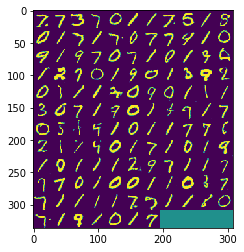

In [39]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('generated_image.png')
imgplot = plt.imshow(img)
plt.show()